In [1]:
!pip install pytorch-lightning

     |████████████████████████████████| 296kB 11.6MB/s 
     |████████████████████████████████| 829kB 32.4MB/s 
     |████████████████████████████████| 276kB 20.9MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=046d97cafe9b8afd1c033d2e373c81882602ce9f4a9a647bc17b51776f8a3140
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=d9268d39b54ced7b038643e4bc3c27df2a7ce84808a51265f504b5b13bd3d6b6
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning import seed_everything

In [3]:
seed_everything(1)

transform_list = transforms.Compose([
            #transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
            #transforms.Normalize([0.5,],[0.5,])
        ])

class CNNModel(pl.LightningModule):
    def __init__(self):
        super(CNNModel, self).__init__()
        
         # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
         
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
      
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
         
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
         
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(64 * 5 * 5, 10) 
     
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x) 
        out = self.relu1(out) 
         
        # Max pool 1
        out = self.maxpool1(out)
         
        # Convolution 2 
        out = self.cnn2(out) 
        out = self.relu2(out) 
         
        # Max pool 2 
        out = self.maxpool2(out)
         

        out = out.view(out.size(0), -1)
 
        # Linear function (readout)
        out = self.fc1(out)
         
        return out

    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)
    
    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        return {'val_loss': F.cross_entropy(y_hat, y)}

    def validation_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        return {'test_loss': F.cross_entropy(y_hat, y)}

    def test_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}
        return {'test_loss': avg_loss, 'log': logs, 'progress_bar': logs}
    
    def train_dataloader(self):
        # REQUIRED
        return DataLoader(CIFAR10(os.getcwd(), train=True, download=True, transform=transform_list), batch_size=128)

    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(CIFAR10(os.getcwd(), train=True, download=True, transform=transform_list), batch_size=128)

    def test_dataloader(self):
        # OPTIONAL
        return DataLoader(CIFAR10(os.getcwd(), train=False, download=True, transform=transform_list), batch_size=128)

In [4]:
if torch.cuda.is_available():
    gpus_value=1  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    gpus_value=0
    print("Running on the CPU")
    
input_dim = 32*32
hidden_dim = 200
output_dim = 10

model = CNNModel()
trainer = pl.Trainer(gpus = gpus_value, max_epochs=5)
trainer.fit(model)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Running on the GPU



  | Name     | Type      | Params
---------------------------------------
0 | cnn1     | Conv2d    | 2 K   
1 | relu1    | ReLU      | 0     
2 | maxpool1 | MaxPool2d | 0     
3 | cnn2     | Conv2d    | 51 K  
4 | relu2    | ReLU      | 0     
5 | maxpool2 | MaxPool2d | 0     
6 | fc1      | Linear    | 16 K  


Extracting /content/cifar-10-python.tar.gz to /content


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Files already downloaded and verified


1

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix

# confusion matrix
cm = np.zeros((10,10), dtype=np.int)

labels_list = []
predicted_list = []

with torch.no_grad():     
    # Iterate through test dataset
    for images, labels in model.test_dataloader():
        images = images.cuda()
        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        #print(labels)
        #print(predicted)pre
        
        labels_list.extend(labels.tolist())
        predicted_list.extend(predicted.tolist())
        
cm += confusion_matrix(labels_list, predicted_list)

print(cm)

Files already downloaded and verified
[[667  29  42  53  24  24   9  18 114  20]
 [ 22 768  10  27   4  11  17   7  53  81]
 [ 77  10 392 121 106 143  74  51  17   9]
 [ 15   9  40 546  55 218  60  35  13   9]
 [ 30   8  63 109 526  86  57 104  15   2]
 [ 13   4  39 235  35 585  20  59   6   4]
 [  3  10  35 129  44  50 708  10   6   5]
 [ 20   1  19  78  55 114  10 694   3   6]
 [ 78  50  10  45  10  14   5  10 756  22]
 [ 53 165  10  44   9  18  18  35  62 586]]


Files already downloaded and verified
After 1st CNN layer


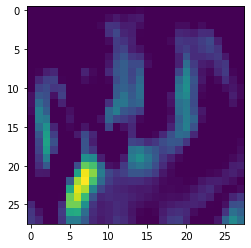

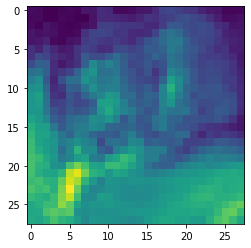

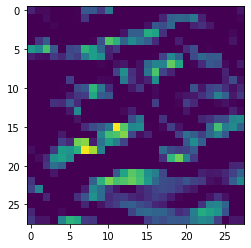

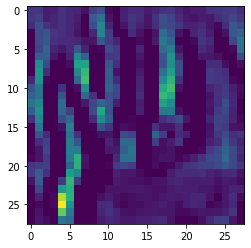

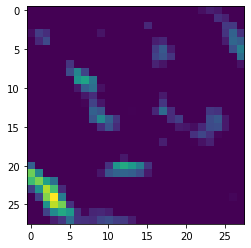

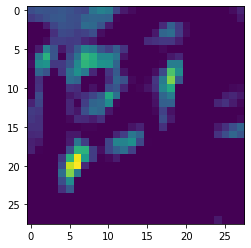

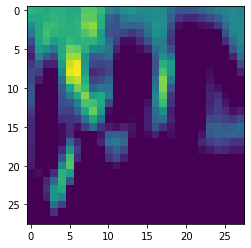

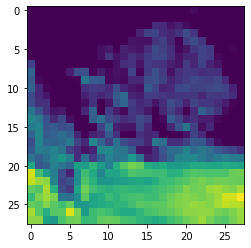

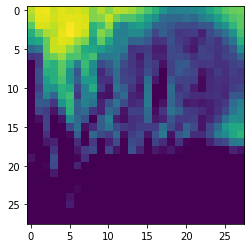

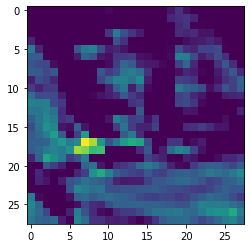

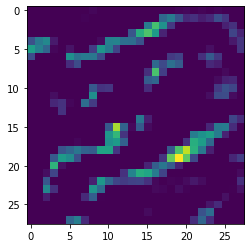

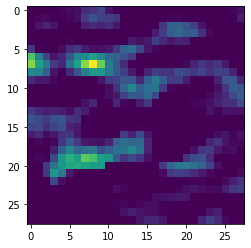

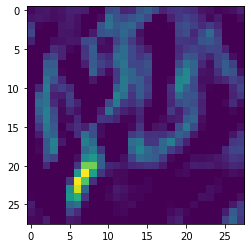

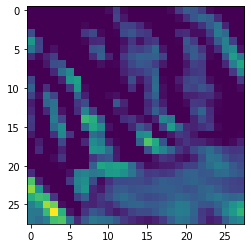

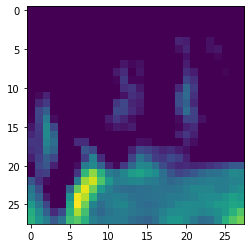

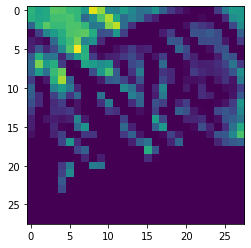

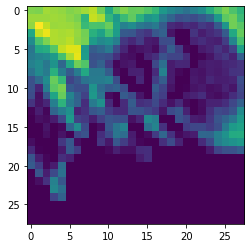

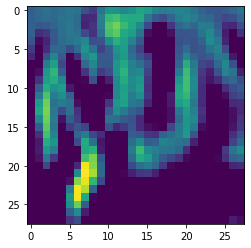

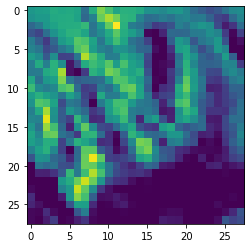

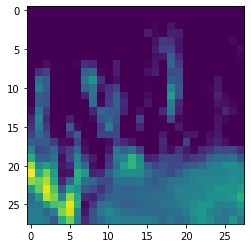

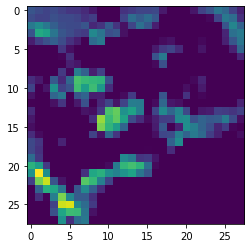

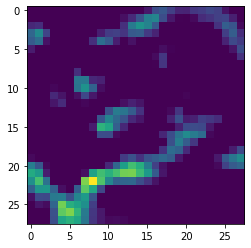

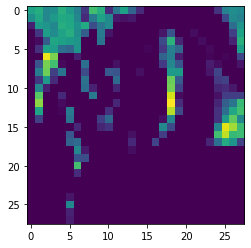

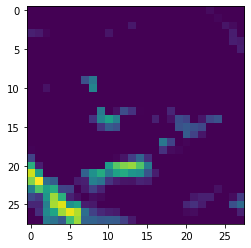

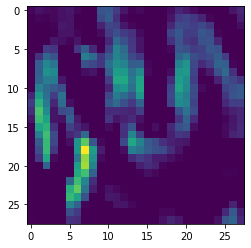

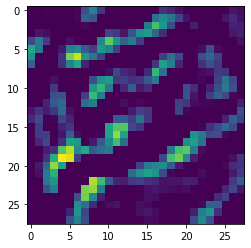

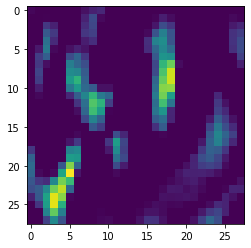

After 2nd CNN layer


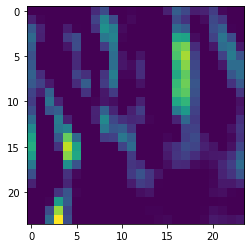

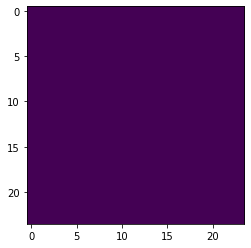

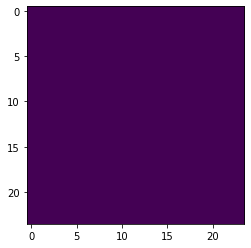

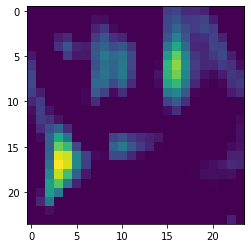

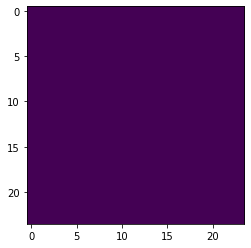

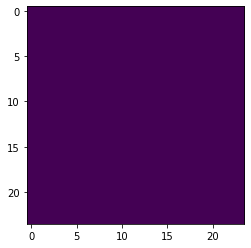

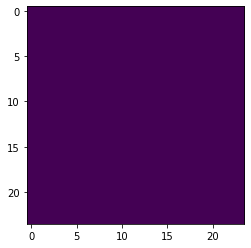

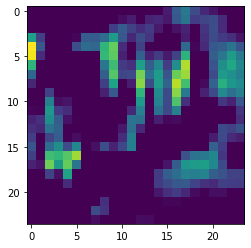

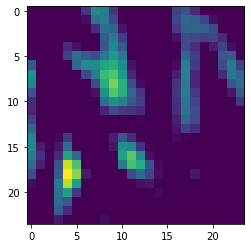

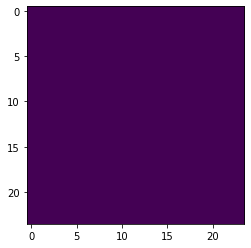

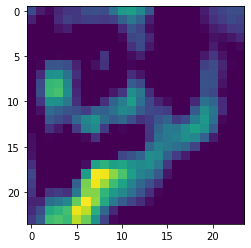

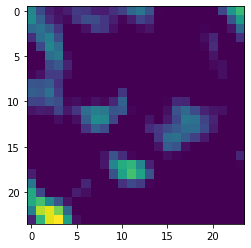

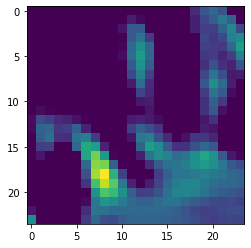

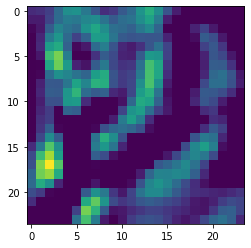

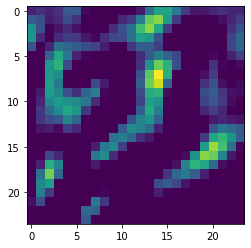

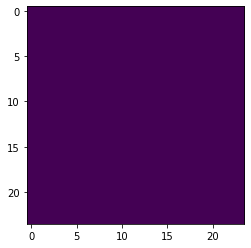

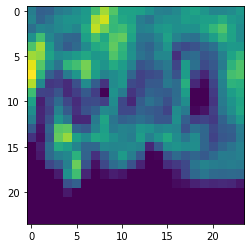

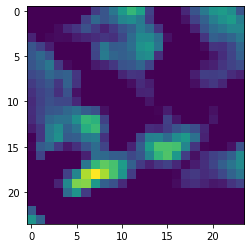

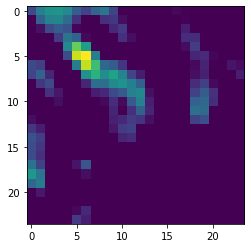

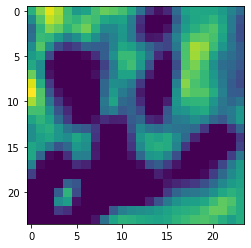

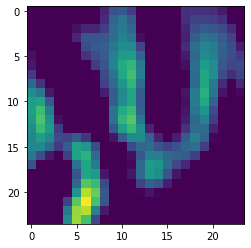

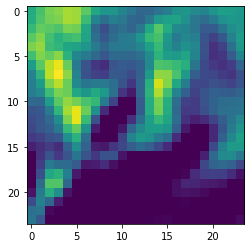

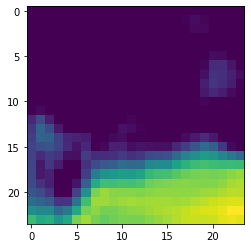

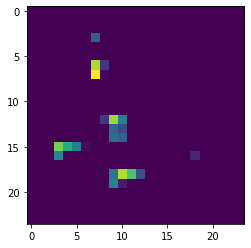

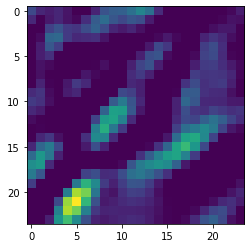

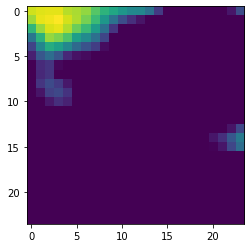

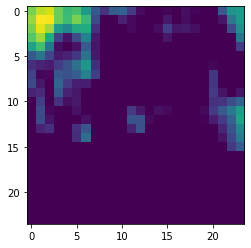

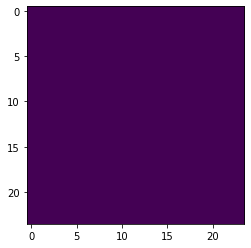

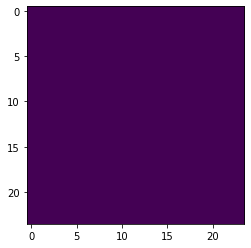

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

for images, labels in model.test_dataloader():
    images = images.cuda()
    
    out = model.cnn1(images)
    out = model.relu1(out)
    out_cpu = torch.FloatTensor(out[0].cpu().detach().numpy())
    print('After 1st CNN layer')
    for i in range(32):
      plt.imshow(out_cpu[i])
      plt.show()
        
    # Convolution 2 
    out = model.cnn2(out) 
    out = model.relu2(out)
    out_cpu = torch.FloatTensor(out[0].cpu().detach().numpy())
    print('After 2nd CNN layer')
    for i in range(32):
      plt.imshow(out_cpu[i])
      plt.show()

    break

cnn1.weight : NEW LAYER
tensor([[[ 0.0686, -0.0249,  0.0125,  0.0352, -0.1806],
         [ 0.0719, -0.0047,  0.0962, -0.0169, -0.1135],
         [ 0.0616,  0.0248,  0.0636, -0.1147, -0.1512],
         [ 0.0320,  0.0506,  0.0216,  0.0203, -0.1101],
         [-0.0375, -0.0729, -0.0305, -0.1413, -0.1560]],

        [[ 0.0339,  0.1241,  0.1351, -0.0920,  0.0354],
         [ 0.0525,  0.1554,  0.1509, -0.0945, -0.1697],
         [-0.0078,  0.1474,  0.0390,  0.0225, -0.1571],
         [ 0.1778,  0.0171,  0.1475, -0.0388, -0.1709],
         [ 0.0904, -0.0307,  0.0582, -0.0922, -0.1061]],

        [[-0.0934, -0.0071,  0.1288, -0.0109,  0.0760],
         [ 0.1006,  0.0332, -0.0099,  0.0743, -0.0311],
         [-0.0438,  0.1095,  0.1187,  0.0693, -0.1761],
         [ 0.0247,  0.0506,  0.0690, -0.1317, -0.1976],
         [ 0.0725, -0.0096,  0.0703, -0.0585, -0.0635]]])


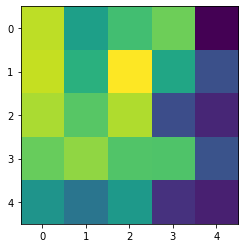

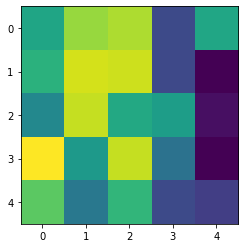

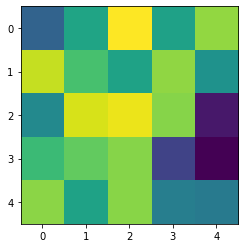

tensor([[[ 0.0185,  0.0293,  0.0359, -0.1188,  0.0384],
         [-0.0879, -0.1005, -0.0156, -0.0355,  0.0409],
         [-0.0758, -0.1182,  0.0597, -0.0321,  0.0417],
         [ 0.0291, -0.1050, -0.0015,  0.0201, -0.0936],
         [-0.0724,  0.0117, -0.0131, -0.0696, -0.0595]],

        [[ 0.1224, -0.0108,  0.0654,  0.0577, -0.0715],
         [-0.0830,  0.1181,  0.0057,  0.0886,  0.0263],
         [ 0.0524,  0.0925,  0.1132, -0.0550,  0.0305],
         [ 0.1062,  0.0912,  0.0786, -0.0521, -0.0595],
         [-0.0560,  0.0163,  0.1129, -0.0583,  0.0706]],

        [[-0.0371, -0.0844, -0.0087,  0.0846,  0.1195],
         [-0.0515,  0.0416,  0.1112,  0.0950,  0.0838],
         [ 0.1014,  0.0872,  0.0431, -0.0479, -0.0719],
         [-0.0280,  0.0020, -0.0562,  0.0772,  0.0628],
         [-0.0127,  0.0486,  0.0385,  0.0838,  0.0847]]])


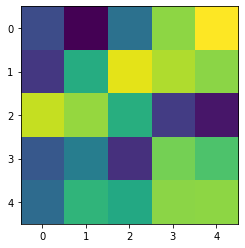

tensor([[[-0.0156,  0.1645,  0.0323,  0.0161, -0.0916],
         [-0.1247, -0.1039, -0.0815,  0.0596, -0.0681],
         [-0.1281, -0.0092, -0.0138,  0.0413, -0.0986],
         [ 0.0415, -0.0255, -0.0093, -0.0874, -0.0471],
         [-0.0191,  0.0902,  0.0783,  0.0786,  0.1455]],

        [[ 0.1427,  0.1376,  0.0579, -0.0534,  0.1127],
         [-0.0663, -0.0303, -0.1149, -0.0329, -0.0982],
         [ 0.0733, -0.1415, -0.1261, -0.0272, -0.0991],
         [ 0.0562, -0.0266, -0.0335,  0.0114,  0.0825],
         [-0.0808,  0.0827,  0.1213,  0.1505, -0.0681]],

        [[ 0.0374, -0.0477,  0.1368, -0.0322,  0.0781],
         [-0.0464, -0.0387, -0.0226,  0.0046,  0.0219],
         [-0.0270, -0.0145, -0.1448,  0.0510,  0.0479],
         [ 0.0903,  0.0833, -0.0817, -0.0610,  0.0732],
         [-0.1146,  0.1038, -0.0729, -0.0746,  0.0360]]])


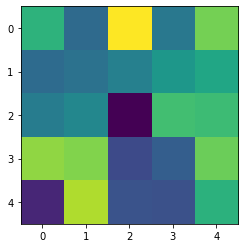

tensor([[[-0.0944, -0.0524,  0.1034,  0.0764,  0.0575],
         [-0.0544, -0.1354,  0.1440, -0.0248, -0.0967],
         [ 0.0049, -0.1228,  0.1109,  0.0972, -0.1323],
         [-0.0995, -0.0330,  0.0822,  0.0354, -0.0796],
         [ 0.0059, -0.1180, -0.0535, -0.0441,  0.0926]],

        [[ 0.0990, -0.0541,  0.0418,  0.0524, -0.0288],
         [-0.0798,  0.0284,  0.1121,  0.0026, -0.0596],
         [ 0.0895,  0.0650, -0.0238,  0.1417, -0.0136],
         [-0.0750,  0.0454, -0.0478,  0.1474, -0.0963],
         [ 0.0407,  0.0296,  0.0604,  0.1330, -0.0466]],

        [[-0.0557, -0.1188,  0.0307, -0.0578, -0.0442],
         [-0.0481, -0.0055,  0.1379,  0.0370, -0.0905],
         [-0.0716, -0.1416,  0.1342, -0.0012, -0.0306],
         [ 0.0056, -0.0966,  0.0979,  0.0972, -0.0289],
         [-0.0566, -0.0599,  0.0299, -0.0336, -0.0713]]])


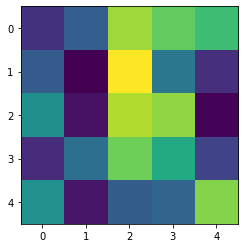

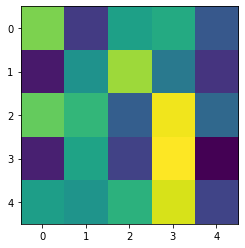

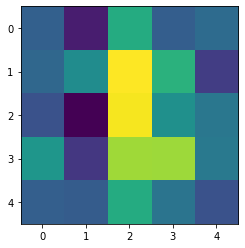

tensor([[[ 0.0084, -0.0020,  0.0649,  0.0019,  0.0089],
         [-0.0171, -0.0586,  0.1623,  0.0800,  0.1479],
         [-0.0268, -0.0123, -0.0704, -0.0024,  0.1207],
         [-0.1420, -0.0635,  0.0546,  0.0708,  0.0712],
         [-0.0265, -0.0304, -0.0569, -0.0611,  0.0518]],

        [[-0.0325, -0.0519,  0.0427, -0.0725, -0.0200],
         [ 0.0637,  0.0695,  0.1386, -0.0438,  0.0230],
         [-0.0752, -0.0824, -0.0577,  0.0425,  0.0314],
         [-0.1247, -0.1504, -0.1556,  0.0803, -0.0226],
         [-0.0543, -0.0977, -0.1319, -0.1623, -0.0969]],

        [[ 0.0928,  0.0534, -0.0116, -0.0226,  0.0862],
         [ 0.1084,  0.1587,  0.0913,  0.1034,  0.0223],
         [-0.0795, -0.1000,  0.1027,  0.0143,  0.0802],
         [-0.0252, -0.1376, -0.0840,  0.0224, -0.0098],
         [-0.1103,  0.0185, -0.0403, -0.0714,  0.0328]]])


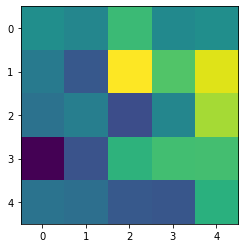

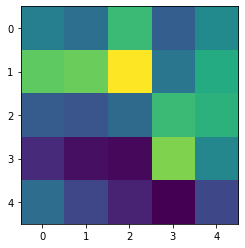

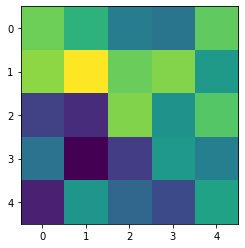

tensor([[[-0.0116, -0.0870,  0.0678,  0.0358,  0.0003],
         [-0.0461, -0.1130,  0.0933, -0.0202, -0.0640],
         [ 0.0657,  0.0523,  0.0638,  0.0122, -0.0197],
         [ 0.0404,  0.1216,  0.0590, -0.0151,  0.1369],
         [ 0.0526,  0.1406,  0.0683,  0.1333,  0.0947]],

        [[-0.0961,  0.0329, -0.0375, -0.1150, -0.0385],
         [-0.1548, -0.1021, -0.1001,  0.0677, -0.0350],
         [-0.0774,  0.0202,  0.0408, -0.0805,  0.0207],
         [ 0.0108, -0.1138,  0.0925, -0.0787, -0.0689],
         [-0.1055,  0.0988,  0.0099,  0.0784, -0.0115]],

        [[ 0.0623, -0.0483, -0.0937,  0.0329,  0.0139],
         [-0.0285, -0.0651,  0.0176,  0.0551,  0.0651],
         [-0.1181,  0.0518,  0.0369,  0.1059,  0.0896],
         [-0.0972,  0.1190, -0.0924,  0.0866,  0.0118],
         [ 0.0724, -0.0421,  0.0816, -0.0525, -0.0982]]])


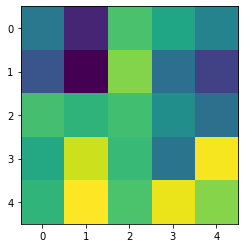

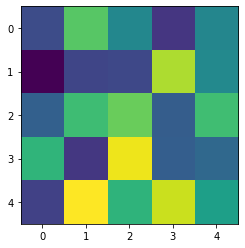

tensor([[[ 0.0581,  0.0722,  0.1379,  0.0392,  0.1607],
         [ 0.0974, -0.0460, -0.0552,  0.1056, -0.0235],
         [ 0.0836, -0.0961,  0.1108,  0.0805,  0.0292],
         [ 0.0702, -0.0783,  0.0181,  0.0737, -0.0115],
         [-0.0218, -0.0530,  0.1405,  0.1480,  0.1398]],

        [[ 0.0717, -0.1457,  0.0272,  0.0722, -0.0489],
         [ 0.0179, -0.1051,  0.0113,  0.0524,  0.1211],
         [-0.0824, -0.1406,  0.0953,  0.0684,  0.0809],
         [ 0.0133, -0.0803,  0.0823, -0.0489,  0.0581],
         [ 0.0294,  0.0473, -0.0479, -0.0420,  0.0755]],

        [[-0.1233, -0.1405, -0.1213, -0.0257,  0.0187],
         [-0.1069, -0.1024, -0.1159,  0.0857, -0.0003],
         [-0.0998, -0.0267, -0.1017,  0.1031,  0.0975],
         [-0.1468, -0.1319, -0.0625, -0.0059,  0.0634],
         [-0.1385, -0.1151,  0.0663,  0.0037, -0.0066]]])


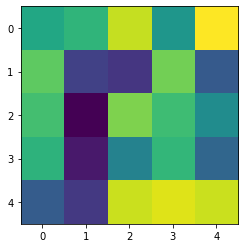

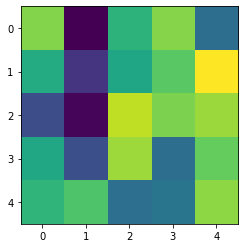

tensor([[[-9.1038e-02,  4.6939e-02,  5.0328e-03, -4.3776e-02, -6.4721e-02],
         [ 2.0983e-02,  2.5372e-02,  5.1288e-02,  3.6392e-02, -1.7201e-02],
         [-1.0830e-01,  5.2276e-02, -1.4275e-02, -8.1261e-02,  9.6548e-02],
         [ 4.1520e-02, -1.1416e-01, -8.3366e-02, -5.9225e-02, -8.3191e-02],
         [ 3.2797e-02, -9.5678e-02,  9.3687e-02, -6.3259e-02,  5.3714e-02]],

        [[ 4.6495e-03, -5.6606e-02,  6.7746e-02, -9.2380e-02, -6.1796e-02],
         [ 8.1119e-03,  8.2752e-02, -5.1188e-02, -6.6470e-02, -7.1426e-02],
         [-6.8909e-02, -5.8443e-02, -3.2620e-02, -5.9925e-02,  4.0300e-02],
         [-1.6533e-02, -9.1099e-02, -8.2087e-02,  1.4281e-02, -9.4231e-03],
         [ 6.6698e-02, -2.4888e-02, -1.0560e-01, -1.0161e-01, -4.9097e-02]],

        [[ 4.9902e-03,  3.9683e-02, -5.8220e-05,  7.4614e-02, -7.8144e-03],
         [ 1.1148e-01,  5.3583e-02,  2.6969e-03,  1.4786e-01,  6.9638e-02],
         [-5.9857e-02, -4.1806e-02,  1.1148e-01,  1.0355e-01,  1.3556e-01],
        

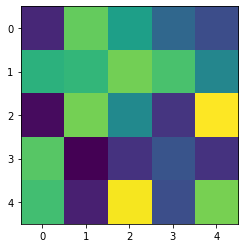

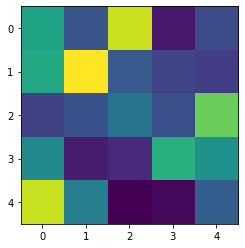

tensor([[[ 0.0640, -0.0073,  0.1281,  0.0394, -0.0506],
         [-0.1001,  0.0917,  0.1415, -0.0714,  0.0720],
         [ 0.0158,  0.0147,  0.0099,  0.0350,  0.0596],
         [ 0.0872,  0.0656,  0.0752,  0.1078,  0.0646],
         [ 0.0301, -0.0349,  0.1019,  0.0291,  0.0952]],

        [[ 0.0822, -0.0417,  0.0773, -0.0588,  0.0917],
         [ 0.0691, -0.0457,  0.0057, -0.0933, -0.0555],
         [-0.0450,  0.0029, -0.0383, -0.1498, -0.0752],
         [-0.0322, -0.0494,  0.0720,  0.0598,  0.0637],
         [ 0.0329, -0.1160,  0.0936, -0.1248, -0.0517]],

        [[-0.1039,  0.0323, -0.0922, -0.0824, -0.0741],
         [-0.0853, -0.0520,  0.1208, -0.0457,  0.0352],
         [-0.1309,  0.1111, -0.0186, -0.1414,  0.0795],
         [-0.0510,  0.0944, -0.0898, -0.1383, -0.0921],
         [ 0.0314, -0.0390, -0.1243, -0.0033, -0.0215]]])


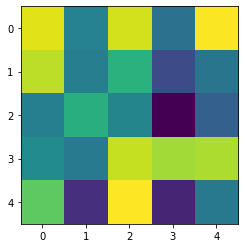

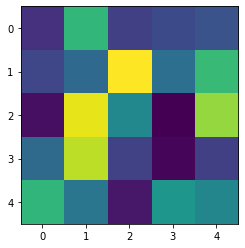

tensor([[[ 0.0442, -0.0654, -0.0915,  0.1023, -0.0264],
         [ 0.0908,  0.1068, -0.0790, -0.0380,  0.0353],
         [-0.1393,  0.0077, -0.0859, -0.0836, -0.1178],
         [ 0.0383, -0.0928, -0.1138, -0.0373, -0.0685],
         [-0.0748,  0.0874, -0.0004,  0.1358,  0.1375]],

        [[-0.0701, -0.0725, -0.0474,  0.0882,  0.0171],
         [-0.0224,  0.0938,  0.1230,  0.1076, -0.0657],
         [-0.0427, -0.0371,  0.0754, -0.0803, -0.0886],
         [-0.0086, -0.0390,  0.0266,  0.0069, -0.0778],
         [ 0.1193,  0.1101,  0.0615, -0.0594,  0.0999]],

        [[ 0.0685,  0.0158, -0.0637,  0.0129, -0.0377],
         [ 0.1177,  0.1250, -0.0080, -0.0633,  0.0843],
         [ 0.0339,  0.0403, -0.1145,  0.0165, -0.0722],
         [-0.1209, -0.1030,  0.0219,  0.0290, -0.1156],
         [ 0.0875,  0.1096,  0.1082,  0.0959,  0.0156]]])


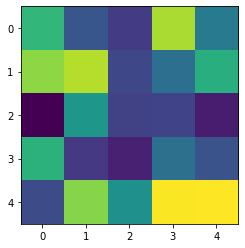

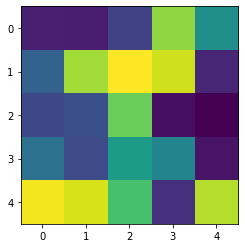

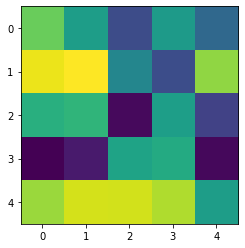

tensor([[[ 0.1357,  0.1554,  0.1255, -0.0503, -0.0259],
         [ 0.1421,  0.0972,  0.0239, -0.1150, -0.0398],
         [-0.1145, -0.1398, -0.0240, -0.1559, -0.0008],
         [-0.0060, -0.0877,  0.0125, -0.0010,  0.1008],
         [-0.0823,  0.0316, -0.0797,  0.0978,  0.1371]],

        [[-0.0341,  0.0309, -0.0447, -0.0935, -0.0925],
         [-0.0517, -0.0195, -0.1110, -0.0992, -0.1322],
         [-0.1349, -0.2048, -0.2145,  0.0363,  0.0821],
         [-0.1477, -0.0351,  0.0070,  0.0970,  0.1790],
         [ 0.0385,  0.1058, -0.0035,  0.0356, -0.0352]],

        [[ 0.0422,  0.1340,  0.1076,  0.1200, -0.0679],
         [ 0.0044,  0.0045,  0.0177, -0.1958, -0.0944],
         [-0.0384, -0.1603, -0.0808, -0.0734, -0.0051],
         [ 0.0139,  0.0566,  0.0959,  0.0665,  0.0413],
         [ 0.0831,  0.0951, -0.0439,  0.0625,  0.0169]]])


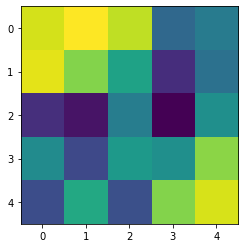

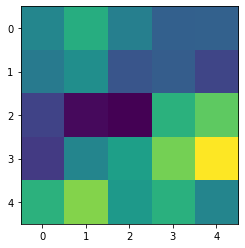

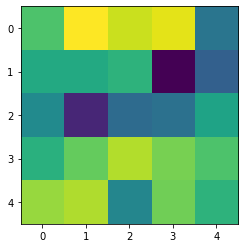

tensor([[[-0.0707, -0.0694, -0.0841, -0.1352, -0.0769],
         [ 0.0535,  0.0935,  0.0122, -0.1156,  0.0509],
         [ 0.0225,  0.1641, -0.0396,  0.0220,  0.1163],
         [ 0.1054, -0.0023, -0.0370,  0.0435,  0.0762],
         [-0.0531, -0.0624,  0.0289,  0.0047,  0.0988]],

        [[-0.1436, -0.0722, -0.1571, -0.0808, -0.1103],
         [ 0.0444, -0.0984, -0.0950, -0.0738, -0.1165],
         [ 0.1279,  0.0431,  0.0081,  0.1314,  0.0004],
         [ 0.1157,  0.0225, -0.0300,  0.0736,  0.1055],
         [-0.0688,  0.0494,  0.0565,  0.0450,  0.0245]],

        [[-0.0852, -0.1607, -0.0660, -0.1572, -0.1658],
         [-0.0513, -0.1028,  0.0100,  0.0534,  0.0549],
         [-0.0387,  0.1005,  0.1322,  0.0292,  0.0552],
         [ 0.1029,  0.1274,  0.1078,  0.0762, -0.0311],
         [-0.0360, -0.0343,  0.1096, -0.0155,  0.0127]]])


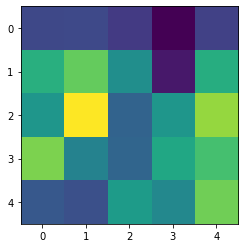

tensor([[[-0.1554, -0.0549, -0.0677, -0.1068,  0.0540],
         [-0.1559, -0.0703, -0.0312, -0.1274,  0.0433],
         [-0.0751,  0.0262,  0.0640,  0.1047,  0.0286],
         [ 0.0971,  0.1243,  0.0485, -0.0050, -0.0188],
         [ 0.0393,  0.0578, -0.0944,  0.0910,  0.0232]],

        [[-0.1135,  0.0299,  0.0782,  0.0488,  0.0980],
         [-0.0284, -0.1146,  0.0090,  0.0887, -0.0557],
         [ 0.0206,  0.0144, -0.0067,  0.0124,  0.0567],
         [-0.0815,  0.0813,  0.0965,  0.0761,  0.1203],
         [-0.0118, -0.0894, -0.0008, -0.0480,  0.0270]],

        [[ 0.1111, -0.0482,  0.0332,  0.1428, -0.0616],
         [-0.0358,  0.1086,  0.1043,  0.0525, -0.0348],
         [-0.0344, -0.1106, -0.0914, -0.0932,  0.1220],
         [ 0.0824,  0.0474, -0.0158,  0.1037, -0.0332],
         [ 0.0529, -0.0326, -0.0798, -0.0671, -0.0587]]])


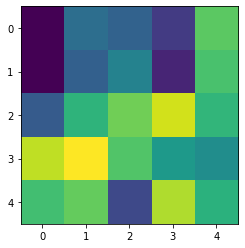

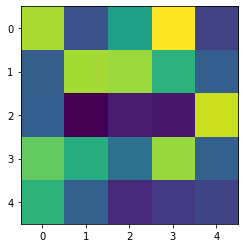

tensor([[[-8.1206e-02,  5.9536e-02, -9.1424e-03,  8.3922e-02,  1.1007e-01],
         [-1.3716e-02,  7.6284e-02,  4.9981e-02,  7.1112e-02, -8.6430e-02],
         [-1.0194e-03,  2.4508e-03,  1.4191e-01, -1.2824e-01, -1.0124e-01],
         [ 4.3437e-02,  1.6217e-01,  1.0194e-01, -1.3823e-01, -9.2591e-02],
         [ 1.4543e-01,  5.8571e-02, -1.0183e-01, -5.8521e-02,  6.1448e-02]],

        [[-1.8336e-02, -8.5578e-02, -7.5557e-02, -6.5282e-02,  1.4411e-04],
         [ 3.3859e-02,  5.6435e-02, -5.5720e-02, -6.5029e-02, -1.4321e-01],
         [ 7.8267e-02,  1.3547e-01,  1.2439e-01, -2.0888e-02, -1.0944e-01],
         [ 1.4683e-02,  8.6624e-02, -1.0098e-01, -5.9549e-02, -1.3951e-01],
         [-8.8928e-02,  2.7386e-02, -5.8169e-02, -1.1521e-01,  1.2883e-02]],

        [[ 2.2858e-02,  3.7545e-02, -4.9595e-02, -9.6428e-02,  2.7913e-02],
         [-4.3217e-02, -1.9105e-02,  1.0582e-01, -5.8125e-03,  2.0263e-02],
         [-2.4642e-02, -5.1012e-02,  5.7787e-02, -1.2525e-01, -5.0564e-02],
        

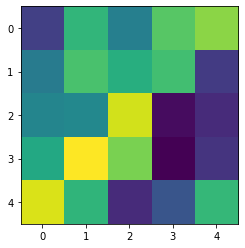

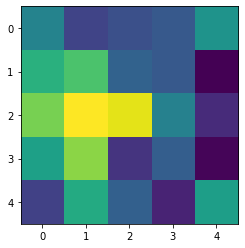

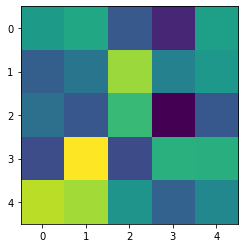

tensor([[[-0.0887, -0.1380,  0.1335,  0.0330,  0.0526],
         [-0.0433, -0.0297, -0.0710, -0.0349,  0.1297],
         [ 0.0167, -0.0158, -0.1916,  0.0096, -0.0711],
         [ 0.0260, -0.0106, -0.1408, -0.1764, -0.0127],
         [ 0.1376,  0.1510, -0.0361, -0.0462, -0.1424]],

        [[-0.1210, -0.0526,  0.1508,  0.0053,  0.0099],
         [ 0.0803, -0.0233,  0.1115,  0.1488,  0.1630],
         [ 0.0146, -0.1434, -0.1544, -0.0376,  0.1476],
         [ 0.1256,  0.0519, -0.1243, -0.1290,  0.0955],
         [ 0.0331, -0.0538,  0.0373, -0.0391, -0.0329]],

        [[ 0.0052,  0.0072, -0.0673,  0.0141, -0.0740],
         [ 0.0402, -0.0019,  0.0645,  0.1583,  0.0922],
         [-0.1266, -0.0342, -0.1533,  0.0160,  0.0310],
         [ 0.1736, -0.0672, -0.1655, -0.0981, -0.0034],
         [ 0.1327,  0.1544,  0.1327,  0.0096, -0.0848]]])


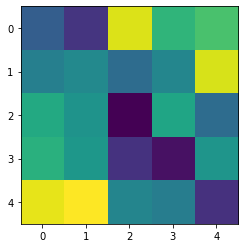

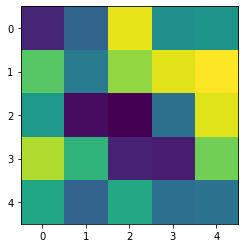

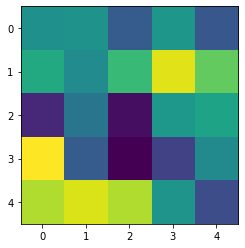

tensor([[[-0.0429, -0.0620,  0.0298, -0.0826,  0.0423],
         [ 0.0530,  0.0870, -0.1076,  0.0825, -0.0744],
         [-0.0212,  0.0993,  0.0574, -0.0503,  0.0661],
         [-0.1358,  0.0891,  0.1022, -0.0233,  0.0132],
         [-0.0625, -0.0800, -0.0689, -0.0480, -0.1163]],

        [[-0.1141,  0.0195, -0.0668, -0.0814, -0.0268],
         [-0.0817,  0.1065, -0.0283, -0.0889, -0.0581],
         [-0.0970,  0.0679,  0.1016, -0.0919, -0.0701],
         [ 0.1017, -0.0675,  0.0269, -0.1248, -0.1325],
         [-0.0167, -0.0557,  0.0500, -0.0873, -0.0385]],

        [[-0.0523,  0.0855,  0.1471, -0.0053, -0.0719],
         [-0.1015,  0.1444,  0.0975,  0.0576,  0.0220],
         [ 0.0910,  0.0869,  0.0969,  0.0848,  0.0205],
         [ 0.1328,  0.1299,  0.0337, -0.0420,  0.0106],
         [ 0.1148,  0.1270, -0.0177, -0.0369,  0.0389]]])


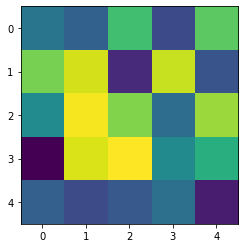

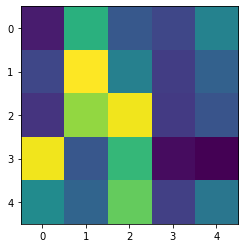

tensor([[[ 3.3260e-02,  9.4269e-02,  3.2911e-02,  1.9945e-02,  1.1144e-04],
         [-1.2574e-01, -6.3846e-02, -2.2360e-02, -1.2228e-01, -1.5212e-01],
         [ 5.1223e-02,  1.8933e-02, -1.0942e-01, -2.9967e-02,  1.2169e-02],
         [ 5.1387e-02,  8.2700e-02, -7.0717e-02,  3.2695e-02, -1.1467e-01],
         [-2.1768e-02, -8.9459e-02, -5.8884e-02,  3.3834e-02,  3.9081e-02]],

        [[-4.7198e-02, -1.9265e-02, -2.2089e-02, -3.9577e-02, -7.2771e-02],
         [ 9.8585e-02,  9.2386e-02,  9.5384e-02, -7.5731e-02,  5.7023e-02],
         [-3.8195e-02, -1.9433e-02, -1.7919e-02, -1.9492e-02, -9.0361e-02],
         [ 1.1998e-02, -8.0335e-02,  3.9381e-02, -1.0844e-01, -6.2569e-02],
         [-8.4171e-02,  7.2006e-02,  5.0151e-02, -1.2896e-01, -9.4681e-02]],

        [[ 1.5001e-01,  7.6822e-02,  1.1310e-01, -5.3753e-02,  6.9112e-02],
         [ 1.2385e-01,  2.4191e-02,  3.0883e-02,  1.0546e-01,  3.1952e-02],
         [ 6.8095e-02,  4.8956e-02,  6.4163e-03, -4.7807e-02,  1.0439e-01],
        

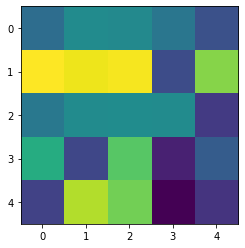

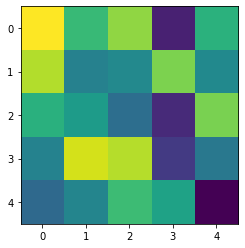

tensor([[[-0.0625, -0.1207, -0.1263,  0.0749, -0.0980],
         [ 0.0083, -0.0134, -0.0066, -0.0165,  0.0597],
         [ 0.0317,  0.1127,  0.0200, -0.0326,  0.0193],
         [ 0.0875,  0.0518,  0.1064, -0.0141, -0.0071],
         [ 0.1040, -0.1061,  0.0366,  0.1449, -0.0387]],

        [[ 0.0032, -0.0129,  0.0474,  0.0837,  0.0334],
         [ 0.0693, -0.0442,  0.0440, -0.0222,  0.0951],
         [-0.0140, -0.0618,  0.0116,  0.0366,  0.0076],
         [ 0.0087,  0.0334,  0.0875,  0.0059, -0.1121],
         [-0.0789,  0.0032,  0.0130,  0.1502, -0.0079]],

        [[ 0.1038, -0.1129, -0.1114,  0.0192, -0.0806],
         [-0.0215,  0.0067, -0.1217,  0.0767, -0.0640],
         [ 0.0926,  0.0610, -0.0391, -0.1517,  0.0090],
         [-0.0789,  0.1130, -0.0950, -0.0640, -0.1042],
         [-0.0942, -0.0915, -0.0168,  0.0205,  0.0078]]])


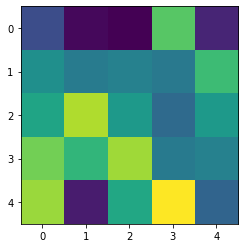

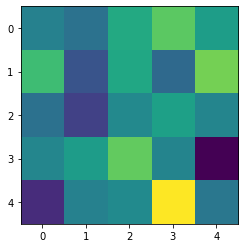

tensor([[[ 0.0793, -0.0311, -0.0653, -0.0106,  0.1273],
         [ 0.0170, -0.0559,  0.1180,  0.0475,  0.0468],
         [ 0.0359,  0.1231, -0.0061,  0.1239,  0.1394],
         [-0.0186,  0.0912,  0.1169,  0.1786,  0.0120],
         [-0.0415, -0.0444, -0.0550,  0.0643,  0.1679]],

        [[ 0.1256,  0.0937,  0.0033, -0.0011,  0.0791],
         [ 0.0691, -0.0062, -0.0449,  0.0194, -0.0200],
         [-0.1119, -0.0654,  0.0829,  0.0761, -0.0783],
         [-0.0602, -0.0957, -0.0415,  0.1188, -0.1252],
         [ 0.0491, -0.1506, -0.0803, -0.0102,  0.0192]],

        [[-0.0056, -0.0472, -0.0634, -0.0824, -0.0888],
         [-0.0709,  0.1136, -0.0791, -0.1390,  0.0459],
         [ 0.0189,  0.0699, -0.1337, -0.1482, -0.1352],
         [-0.0847, -0.0325,  0.0440,  0.0712, -0.1375],
         [ 0.0562, -0.1028,  0.0069,  0.0484,  0.0223]]])


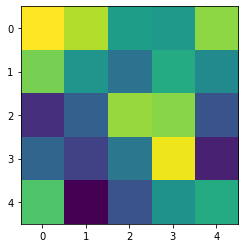

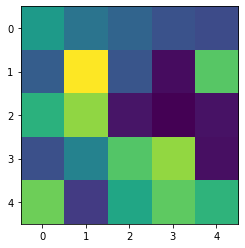

tensor([[[ 0.0814,  0.0408,  0.1154,  0.0526,  0.1141],
         [ 0.0645, -0.0088,  0.1187,  0.0199,  0.1091],
         [ 0.0253,  0.1747, -0.0170,  0.0476, -0.0979],
         [ 0.1069,  0.0637,  0.1020, -0.1034, -0.1248],
         [ 0.0854, -0.0099,  0.0692, -0.0819, -0.0631]],

        [[-0.0070,  0.0625,  0.0336, -0.0733, -0.1085],
         [-0.0078,  0.0619, -0.1221, -0.1162, -0.2078],
         [ 0.0170,  0.0046,  0.0554, -0.0054, -0.1991],
         [-0.0523, -0.0102, -0.0130, -0.0982, -0.1503],
         [-0.0335,  0.0110,  0.0844, -0.0845,  0.0093]],

        [[-0.0583,  0.0400, -0.0820, -0.1275, -0.0147],
         [-0.0165,  0.1298,  0.1085, -0.1517, -0.0541],
         [ 0.0196, -0.0054, -0.0465, -0.1032,  0.0014],
         [ 0.0609,  0.1171,  0.0253,  0.0367,  0.0003],
         [ 0.0204,  0.0473, -0.0685, -0.0044, -0.0446]]])


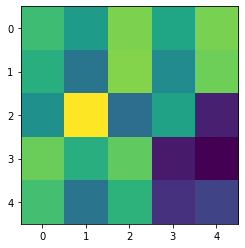

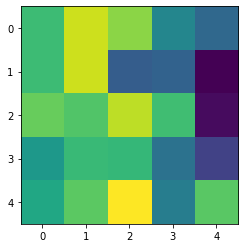

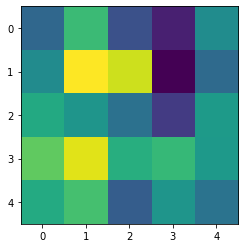

tensor([[[-0.0560, -0.0668, -0.0522, -0.1127, -0.0240],
         [-0.0131, -0.0474,  0.0930,  0.0793,  0.0250],
         [-0.0375,  0.0227, -0.0700,  0.1141,  0.1216],
         [-0.0030,  0.1136,  0.1048, -0.0044, -0.0585],
         [ 0.0019, -0.0033, -0.1504, -0.0239, -0.0441]],

        [[ 0.0787, -0.0065,  0.0662,  0.0940, -0.0513],
         [ 0.0313, -0.0154, -0.0461, -0.0489,  0.0057],
         [ 0.0524, -0.0027,  0.0368,  0.1158,  0.0691],
         [ 0.0756,  0.0697, -0.0847, -0.0600, -0.0970],
         [ 0.0845, -0.1119, -0.1191,  0.0724,  0.0751]],

        [[-0.1152,  0.0545, -0.0491,  0.0044, -0.0946],
         [-0.0175,  0.0100,  0.0794,  0.0733, -0.0693],
         [-0.0633,  0.0037,  0.0445,  0.1007, -0.0997],
         [ 0.0146,  0.0398, -0.0545,  0.0961, -0.0485],
         [-0.1056, -0.0834, -0.0359, -0.0946,  0.0299]]])


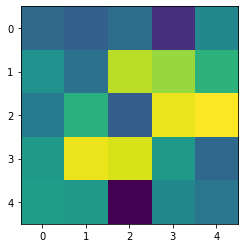

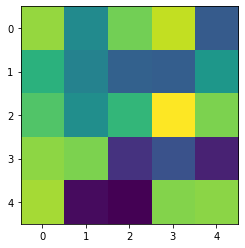

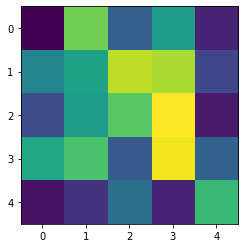

tensor([[[ 0.0941, -0.0121, -0.0465,  0.0873,  0.0532],
         [ 0.0751,  0.0118,  0.0055, -0.0975,  0.0003],
         [ 0.1179,  0.0163, -0.1050,  0.0475,  0.0900],
         [ 0.0974,  0.0158,  0.0253,  0.0069, -0.0660],
         [-0.0149,  0.0993,  0.0173,  0.1077, -0.0883]],

        [[-0.0379, -0.0209, -0.0937,  0.0655,  0.0484],
         [-0.0703,  0.0958,  0.0972, -0.0800, -0.0171],
         [ 0.1107, -0.0767, -0.0334, -0.1008,  0.0654],
         [ 0.0089,  0.0473,  0.0747, -0.0362, -0.1404],
         [-0.0032, -0.0137,  0.0368,  0.0455, -0.0773]],

        [[-0.0566,  0.0587,  0.0122,  0.0095,  0.0268],
         [ 0.0570, -0.0790,  0.0044,  0.0042, -0.1184],
         [ 0.0312,  0.0055,  0.0779, -0.1289,  0.0932],
         [-0.0575,  0.0756,  0.0826, -0.0294, -0.0862],
         [-0.0234, -0.0714,  0.0128,  0.0410, -0.0016]]])


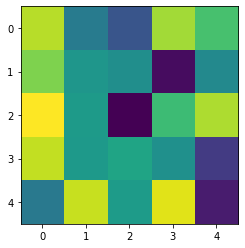

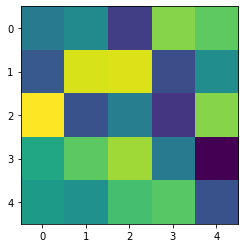

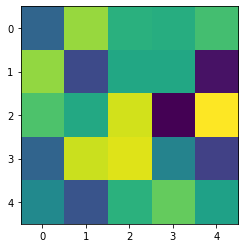

tensor([[[-0.0751,  0.0647,  0.1124, -0.0318,  0.0629],
         [-0.0378,  0.0422, -0.0681, -0.0931,  0.0012],
         [-0.1308,  0.0387,  0.1150, -0.0162,  0.0242],
         [-0.0112, -0.0686, -0.0091,  0.0416,  0.1286],
         [-0.1221, -0.0147, -0.1008, -0.0022,  0.0340]],

        [[-0.0616,  0.0691,  0.0818, -0.0522, -0.0323],
         [-0.0674, -0.0011,  0.0515,  0.1055, -0.1181],
         [ 0.0143, -0.0708, -0.0888,  0.0877, -0.0269],
         [-0.0927,  0.0239, -0.0282, -0.1052, -0.0423],
         [-0.0720, -0.0164, -0.0840, -0.1171,  0.0829]],

        [[-0.0817,  0.0150,  0.1306, -0.0247, -0.0744],
         [ 0.0334,  0.1301,  0.0330,  0.0199,  0.0621],
         [ 0.0183,  0.0571,  0.1001,  0.0798, -0.0533],
         [-0.0331,  0.1110,  0.0516,  0.0596,  0.1532],
         [ 0.0925,  0.0831,  0.1455, -0.0702,  0.0652]]])


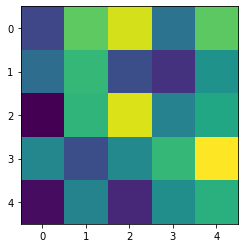

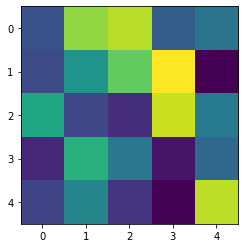

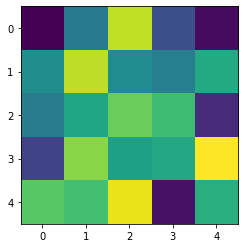

tensor([[[ 2.3291e-02, -6.2065e-02, -1.0674e-01,  9.2807e-03, -1.0474e-01],
         [-8.1541e-02,  2.7465e-02, -1.0866e-01, -5.0334e-02,  1.8945e-02],
         [-9.2441e-02, -5.8490e-02, -1.8769e-01,  3.8419e-02, -1.3621e-01],
         [-3.8850e-02, -1.7008e-01, -1.4479e-01,  7.2423e-02, -8.1100e-02],
         [-2.2229e-02, -2.3669e-02,  8.7711e-02,  4.0720e-02,  5.9523e-02]],

        [[-4.0674e-02, -5.8119e-02,  5.6854e-02,  5.9104e-02,  5.3360e-02],
         [-8.9786e-02, -1.1684e-01, -9.4458e-05, -6.1263e-02,  9.0390e-02],
         [ 7.3863e-02, -7.5650e-02, -9.2229e-02,  1.3780e-01, -4.2133e-02],
         [-1.0613e-01, -9.3170e-02,  2.3754e-02,  5.3170e-02,  1.0758e-01],
         [ 1.0479e-01,  5.4590e-02,  3.5503e-02,  1.5019e-01, -3.5541e-03]],

        [[-1.8028e-02,  8.0778e-02, -5.5033e-02,  9.4253e-02,  6.2872e-02],
         [ 3.9573e-02, -4.3721e-02, -1.0922e-01,  1.2645e-01,  1.2163e-01],
         [-1.0595e-01, -6.9564e-02,  1.1869e-03,  9.8116e-02,  1.7397e-02],
        

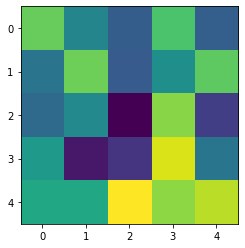

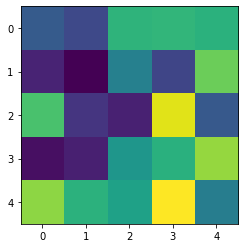

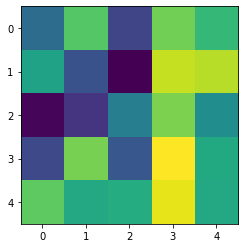

tensor([[[ 0.1038,  0.0708, -0.0379,  0.0948, -0.0506],
         [ 0.0878,  0.0130,  0.0709,  0.0161,  0.0595],
         [-0.0152,  0.0730,  0.0839, -0.0740,  0.1347],
         [-0.0973, -0.0503,  0.0576,  0.1258,  0.0582],
         [-0.0819, -0.0009, -0.0820,  0.0482,  0.0023]],

        [[ 0.0264, -0.0619,  0.0866,  0.1284, -0.0515],
         [ 0.0477, -0.0338, -0.0160,  0.1170, -0.0883],
         [-0.0303,  0.0334,  0.0459, -0.0486, -0.0636],
         [-0.0092, -0.1414, -0.0158, -0.0932, -0.0345],
         [ 0.0616, -0.1513, -0.1066, -0.1275,  0.0409]],

        [[ 0.1255, -0.0320,  0.1114,  0.1063, -0.0539],
         [ 0.0617,  0.0843,  0.0074,  0.1046,  0.0276],
         [-0.0043,  0.0749, -0.0983, -0.1012,  0.0381],
         [ 0.0057, -0.0019, -0.0801,  0.0896, -0.0671],
         [-0.0669, -0.1207, -0.1362,  0.0106, -0.0555]]])


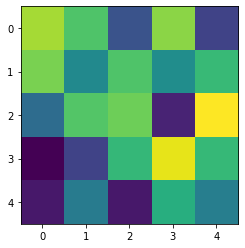

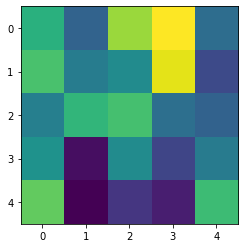

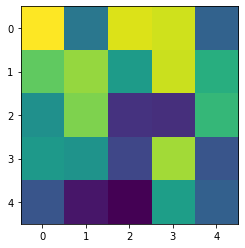

tensor([[[ 1.1988e-01,  1.6743e-01,  9.2073e-02,  1.6005e-01, -1.5428e-02],
         [ 9.1726e-02,  9.6208e-02, -2.5173e-02,  1.0173e-02, -3.9844e-02],
         [ 2.1139e-02, -1.0891e-01, -8.8675e-02, -1.2215e-01, -2.1124e-02],
         [-1.3636e-02, -1.3758e-01, -8.8351e-02,  4.8057e-02,  5.0235e-03],
         [-1.8796e-02, -9.9563e-02, -7.5735e-02, -1.3012e-01,  9.6289e-02]],

        [[ 4.6751e-02,  9.3005e-02,  1.1043e-01,  1.5336e-01, -1.8511e-02],
         [ 5.1579e-02, -7.7444e-02,  5.8245e-02, -4.1675e-02,  7.5413e-02],
         [-7.1987e-02,  6.8578e-02,  7.1404e-02,  5.1104e-02, -9.5056e-02],
         [ 5.7498e-02, -1.0378e-01, -1.3910e-01,  6.9153e-02,  3.1638e-02],
         [-6.8574e-02, -1.3409e-01,  4.3239e-03, -6.2437e-02, -9.1584e-02]],

        [[ 5.1805e-03, -7.3809e-02,  8.5501e-02, -3.4975e-02,  1.7217e-02],
         [-1.0268e-01, -6.3238e-05, -2.6345e-02,  7.7073e-02,  4.9297e-03],
         [ 1.0135e-01,  1.2504e-01,  2.6713e-02, -4.1735e-02, -8.2022e-02],
        

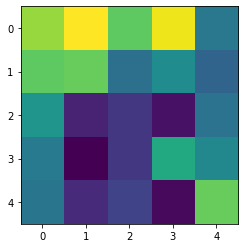

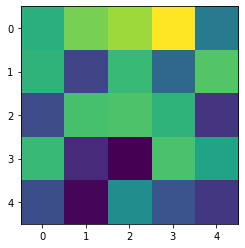

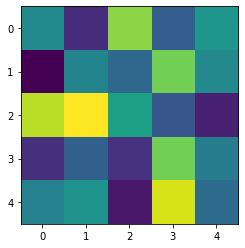

tensor([[[-0.1393, -0.0137, -0.0959, -0.0068, -0.1176],
         [-0.0530, -0.0406,  0.0907,  0.0653,  0.0957],
         [-0.0046,  0.0784, -0.0960, -0.0979,  0.0700],
         [ 0.0132,  0.0378,  0.0767,  0.0807,  0.0566],
         [-0.0331, -0.0374,  0.0395,  0.1260,  0.0038]],

        [[-0.0604,  0.0715,  0.1005, -0.0065, -0.0616],
         [-0.1288,  0.0152,  0.0578, -0.0956, -0.0938],
         [-0.1276,  0.1005,  0.1112,  0.0968,  0.1128],
         [-0.0282,  0.0534,  0.0765, -0.0287, -0.0751],
         [ 0.0982, -0.0192,  0.0518, -0.0330, -0.0610]],

        [[-0.0459,  0.0095,  0.0880,  0.0676, -0.0428],
         [ 0.0996, -0.0586,  0.0239, -0.0867,  0.0114],
         [ 0.0877, -0.0949,  0.0163, -0.1384, -0.0249],
         [-0.0866, -0.0167, -0.0944,  0.0085, -0.1396],
         [ 0.0073, -0.0766, -0.0864,  0.0934, -0.0159]]])


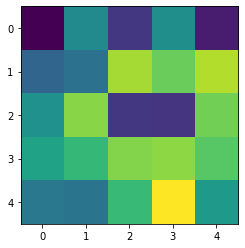

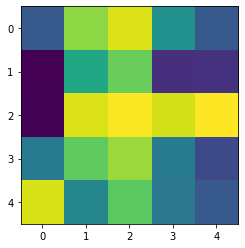

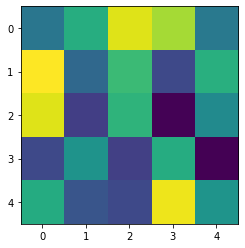

tensor([[[-0.0561, -0.0506, -0.0395, -0.0516,  0.0406],
         [ 0.0178,  0.1253,  0.0297, -0.0263,  0.1382],
         [ 0.0300, -0.0192,  0.0851,  0.1094, -0.0841],
         [-0.1227, -0.1043, -0.1384, -0.0604,  0.0293],
         [-0.1228, -0.1299, -0.1242, -0.0718,  0.0736]],

        [[ 0.1244,  0.1314,  0.0158, -0.0779,  0.1445],
         [-0.0629,  0.0681,  0.0851,  0.0739,  0.0810],
         [-0.1075, -0.0326, -0.0686,  0.0978, -0.0485],
         [-0.0241,  0.0823,  0.0569, -0.1003, -0.1027],
         [ 0.0811,  0.0246, -0.1037,  0.0975, -0.0752]],

        [[ 0.1105,  0.0884,  0.0844, -0.0138,  0.0298],
         [-0.0943,  0.0744,  0.0188,  0.1093, -0.0190],
         [ 0.1030,  0.0725, -0.0384,  0.0384, -0.0760],
         [-0.1021, -0.1038, -0.1011,  0.0103, -0.0595],
         [-0.0540,  0.0685,  0.0011, -0.0617, -0.0258]]])


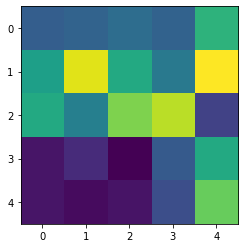

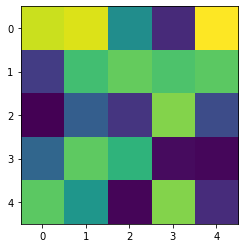

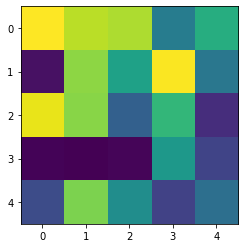

tensor([[[-0.0238,  0.0607,  0.0841,  0.0690, -0.1049],
         [-0.0021,  0.0470, -0.0285,  0.0448, -0.0710],
         [ 0.0390, -0.0455,  0.1368, -0.0844, -0.0607],
         [-0.0818,  0.1203,  0.0493,  0.0554, -0.1391],
         [ 0.0079,  0.0666,  0.1155,  0.0891, -0.0647]],

        [[-0.0102,  0.0362, -0.0544, -0.0969, -0.1658],
         [-0.1041, -0.0464,  0.0172, -0.0504, -0.0862],
         [ 0.0445,  0.0293, -0.0697,  0.0699, -0.1784],
         [ 0.0132,  0.0786,  0.0689, -0.0621, -0.1752],
         [ 0.0952,  0.0250,  0.1386,  0.0478, -0.0142]],

        [[ 0.0340, -0.0204, -0.0733, -0.0292,  0.0575],
         [ 0.0823,  0.1230,  0.1145,  0.0343, -0.1551],
         [-0.0284,  0.0554, -0.0058, -0.0547, -0.1233],
         [ 0.1263,  0.0384,  0.1665, -0.0854, -0.1740],
         [ 0.0304,  0.0592,  0.0034, -0.0473, -0.0151]]])


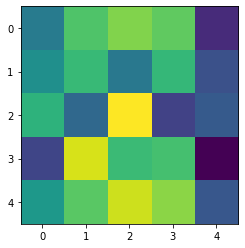

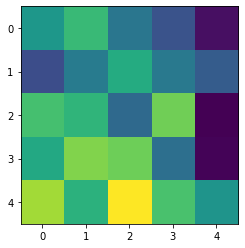

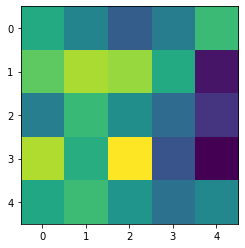

tensor([[[-0.0026, -0.0253,  0.0723, -0.0496,  0.0836],
         [-0.0689, -0.0998,  0.0254,  0.1028,  0.0064],
         [-0.0673, -0.0072, -0.0677, -0.0402, -0.0076],
         [ 0.0303,  0.0141, -0.0748, -0.0892, -0.0934],
         [-0.1428,  0.0778,  0.0833,  0.0790,  0.0059]],

        [[-0.0480, -0.0715,  0.0802, -0.0622,  0.0870],
         [-0.0465, -0.1434, -0.0915,  0.1341,  0.1009],
         [ 0.0517, -0.0010,  0.0686,  0.0676,  0.0842],
         [-0.0756,  0.0616,  0.1131, -0.1091,  0.1236],
         [-0.0977, -0.0036,  0.0259,  0.0374,  0.0455]],

        [[-0.0763,  0.0396,  0.0453, -0.0154, -0.1253],
         [ 0.1218, -0.0943, -0.0823,  0.1482, -0.0552],
         [ 0.0944,  0.0556, -0.1214, -0.1061, -0.0571],
         [ 0.0306,  0.1465, -0.0072, -0.0748, -0.0344],
         [-0.1127,  0.1419,  0.0288, -0.0862, -0.0748]]])


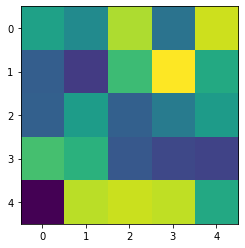

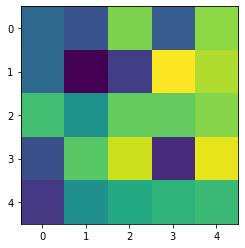

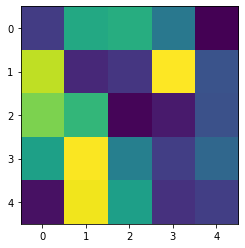

tensor([[[ 0.0957,  0.0998,  0.1078, -0.0443, -0.0569],
         [ 0.0737,  0.0288, -0.0681, -0.0517, -0.1099],
         [-0.0832, -0.0590, -0.1501, -0.0231,  0.0578],
         [ 0.0855, -0.0020, -0.0156, -0.0404,  0.0300],
         [-0.0356, -0.0850,  0.0495,  0.1371,  0.1182]],

        [[-0.0127,  0.0249,  0.1539, -0.0549, -0.1459],
         [ 0.0491,  0.0470, -0.0677, -0.0903, -0.1361],
         [ 0.0422, -0.1070, -0.0226,  0.0698, -0.0236],
         [-0.0667, -0.0192, -0.0086,  0.1192,  0.0769],
         [ 0.0057, -0.0305,  0.0673,  0.0910, -0.0388]],

        [[ 0.0783,  0.0131,  0.1283, -0.1658, -0.0681],
         [ 0.0893,  0.1092, -0.0368, -0.1559, -0.1462],
         [-0.0957,  0.0509, -0.1782, -0.0745,  0.1014],
         [ 0.0249, -0.1445,  0.0051,  0.0588,  0.1819],
         [-0.0318,  0.0423,  0.0158,  0.1536,  0.0338]]])


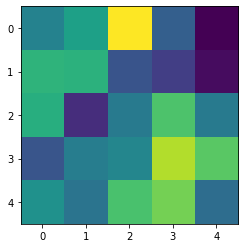

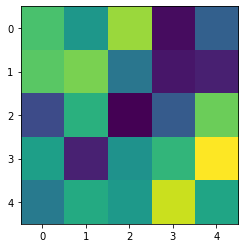

tensor([[[-0.0962, -0.0057, -0.0610,  0.0536,  0.1052],
         [-0.1237, -0.1036,  0.0282,  0.0513,  0.0171],
         [ 0.0207,  0.0082, -0.0242,  0.0700,  0.0380],
         [-0.1354,  0.0204, -0.0619,  0.0417,  0.1060],
         [-0.1357, -0.0004,  0.1228,  0.0726, -0.0223]],

        [[-0.0412, -0.1642, -0.0031,  0.1072,  0.1142],
         [-0.0654, -0.0016, -0.0096,  0.0119,  0.0474],
         [-0.1592, -0.0114,  0.0629,  0.0160,  0.0284],
         [-0.1538, -0.0191,  0.0573,  0.1348, -0.0792],
         [-0.1372, -0.0078,  0.1214,  0.0276,  0.0563]],

        [[-0.0360, -0.0586,  0.0771,  0.1142, -0.0313],
         [-0.1227, -0.1175,  0.0012,  0.0643,  0.1634],
         [-0.1926,  0.0428, -0.0343,  0.0824,  0.0724],
         [ 0.0030, -0.1103, -0.0429,  0.0551,  0.1108],
         [-0.0794,  0.0450,  0.0091, -0.0631,  0.0595]]])


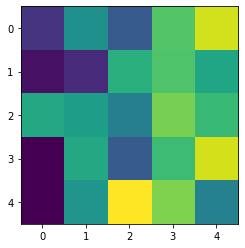

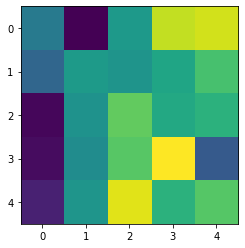

cnn2.weight : NEW LAYER
tensor([[[ 1.4321e-02,  2.5732e-02,  8.8657e-02,  6.4558e-03, -5.1351e-02],
         [-2.6610e-03, -6.2144e-02,  7.0275e-02,  1.6958e-03, -3.6668e-02],
         [-8.7548e-03, -5.7353e-02,  9.2320e-02,  7.5490e-02, -4.7842e-02],
         [-6.6830e-03, -3.5398e-02,  2.0431e-02,  4.5420e-02, -5.1950e-02],
         [-7.0318e-02, -4.6869e-02, -4.3570e-02,  5.1051e-02, -7.3973e-03]],

        [[ 7.6974e-03, -3.8741e-03, -2.4581e-02, -3.1975e-02, -3.7573e-02],
         [ 1.3910e-02,  2.0810e-02,  4.1149e-02, -1.8918e-02, -3.0501e-02],
         [-1.4299e-02,  1.5382e-03,  3.1527e-02, -5.2283e-02, -5.4391e-02],
         [ 7.6582e-03,  8.1143e-04,  3.8826e-03, -3.6813e-02, -3.8765e-02],
         [-3.0245e-02, -1.1024e-02, -2.3302e-02, -2.2162e-02,  1.4766e-02]],

        [[-4.3482e-03, -2.7237e-02, -7.9953e-02,  2.0074e-03, -1.7936e-02],
         [-2.7923e-02, -3.5854e-02, -8.0629e-02, -8.1188e-02, -1.1047e-02],
         [ 3.1972e-02,  1.8801e-02, -5.4775e-02, -3.2939e-02

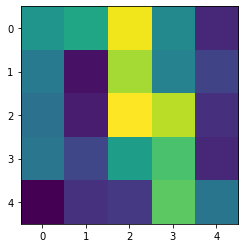

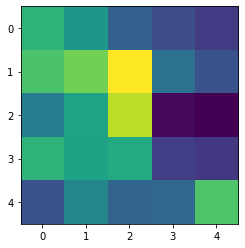

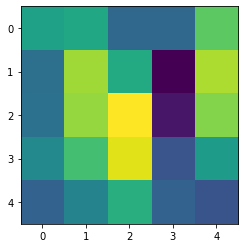

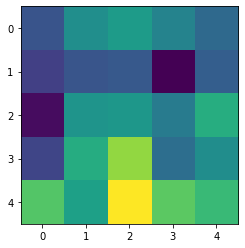

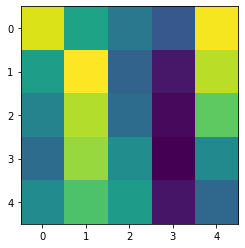

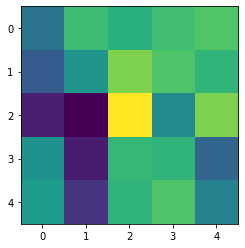

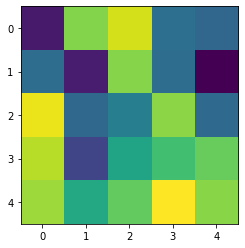

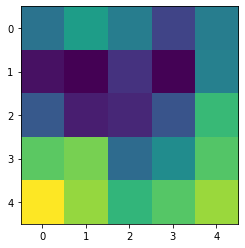

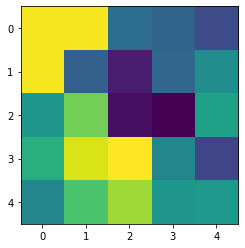

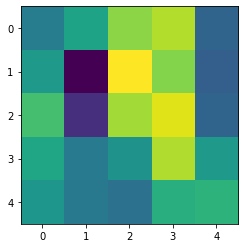

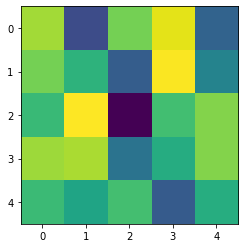

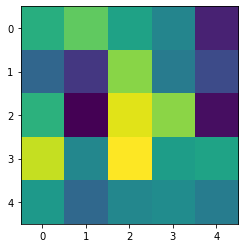

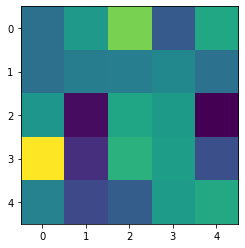

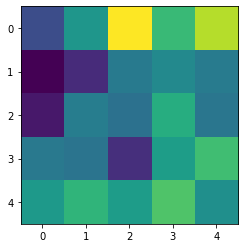

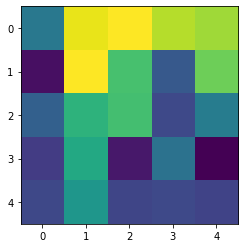

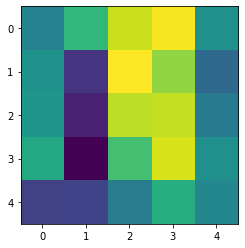

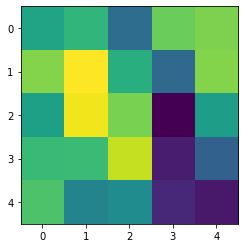

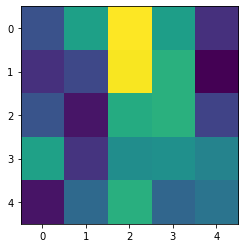

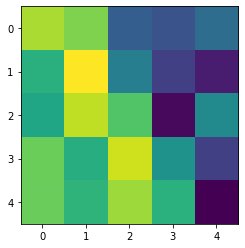

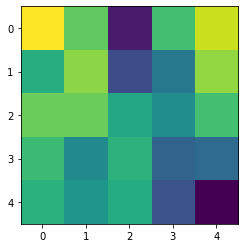

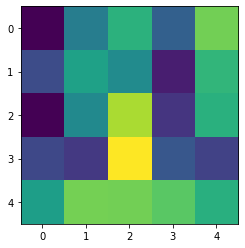

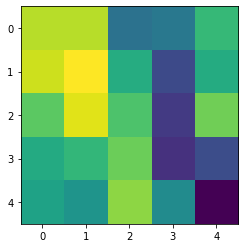

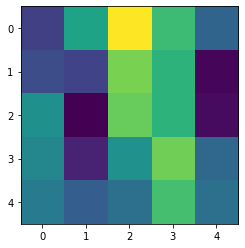

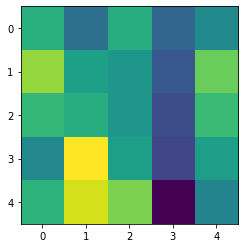

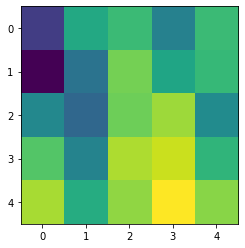

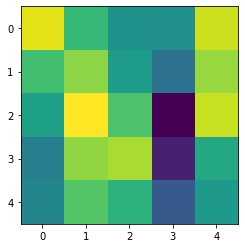

tensor([[[ 1.5770e-02, -1.2931e-02,  2.0033e-02, -3.8671e-02, -6.1353e-03],
         [ 2.5090e-02,  6.0404e-03, -2.9591e-02,  5.5339e-03,  1.6025e-02],
         [-6.6293e-03,  1.8575e-02, -2.5187e-02,  2.2975e-02, -3.3405e-02],
         [ 1.4521e-02, -2.7549e-02, -8.3274e-03, -9.1736e-03, -6.2825e-03],
         [ 5.2953e-04, -2.2589e-02, -2.4320e-02,  1.9076e-02,  8.2013e-03]],

        [[ 5.4263e-04, -8.5794e-03,  3.5137e-03,  2.5608e-03, -1.2779e-02],
         [ 6.4073e-04,  1.0440e-04,  2.9685e-02, -3.5250e-02, -2.4593e-02],
         [-1.4558e-02,  1.9538e-02, -2.4727e-02, -1.8827e-02, -1.6217e-02],
         [-2.2848e-03, -3.1373e-02,  2.8966e-03,  2.6618e-02,  2.2186e-02],
         [-2.5233e-02, -1.2130e-02,  1.4753e-02,  9.3692e-03,  1.5670e-02]],

        [[ 9.5694e-03, -1.5255e-02,  2.1310e-02,  2.9746e-02,  8.6916e-03],
         [-9.5106e-03,  1.0417e-02,  2.0797e-02, -3.2424e-02,  4.7740e-03],
         [-2.0126e-02, -2.0684e-03, -2.7584e-02, -9.1882e-03, -3.3364e-03],
        

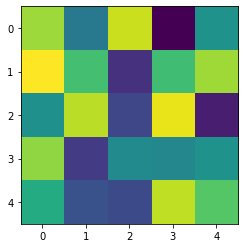

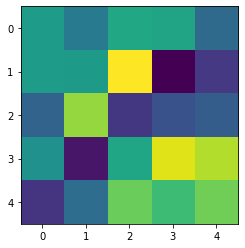

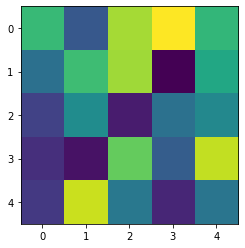

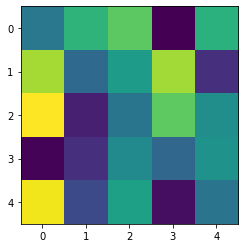

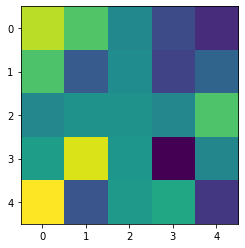

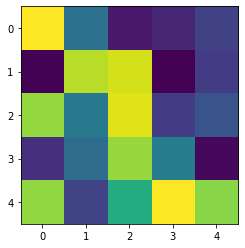

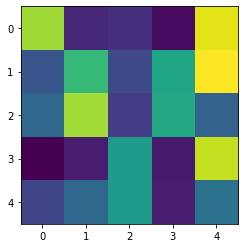

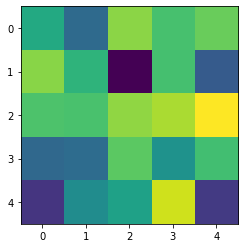

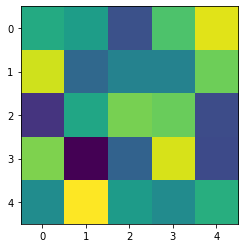

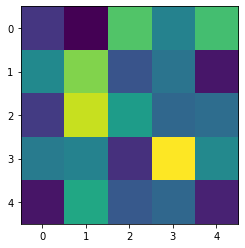

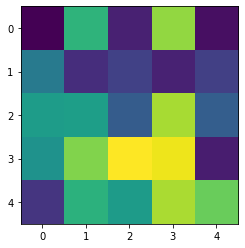

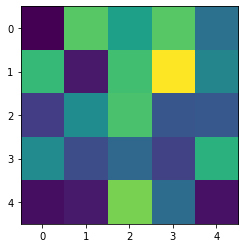

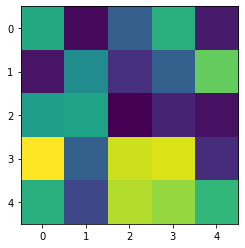

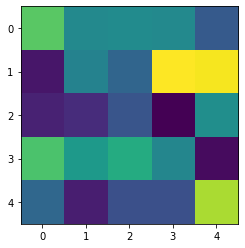

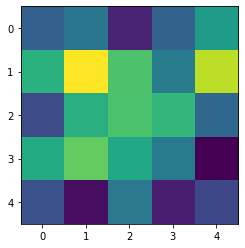

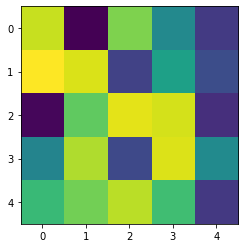

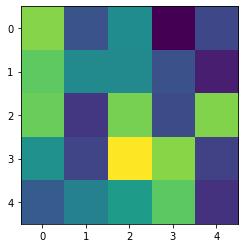

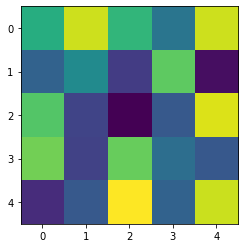

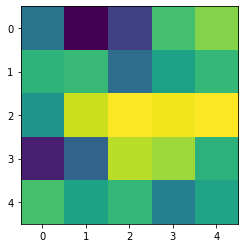

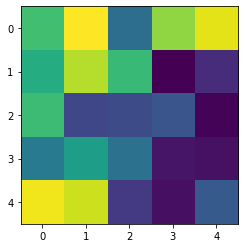

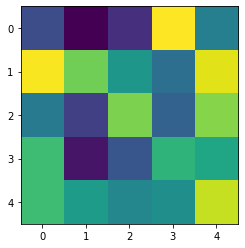

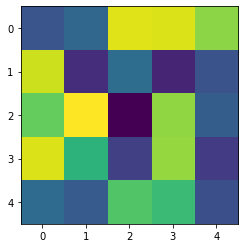

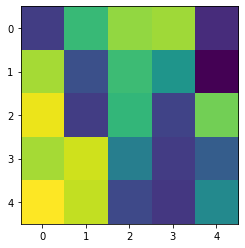

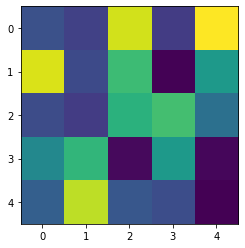

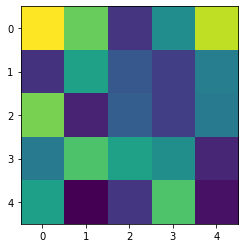

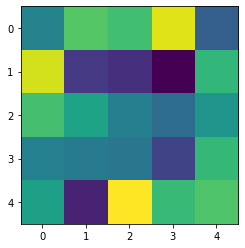

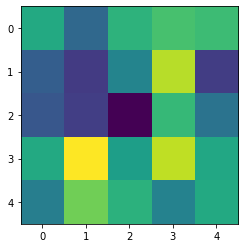

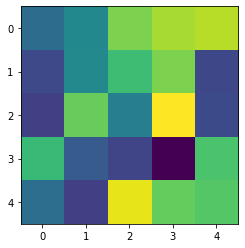

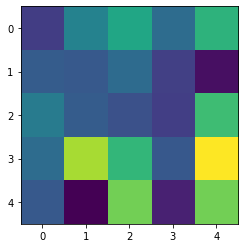

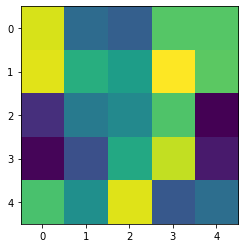

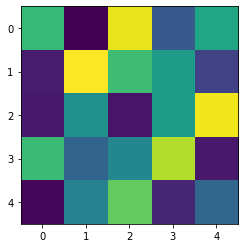

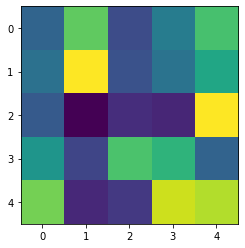

tensor([[[ 1.3868e-02,  2.6410e-03, -3.3949e-02, -5.0049e-02, -2.1336e-02],
         [ 1.4558e-02,  7.0209e-03, -2.9438e-02, -3.1034e-02, -2.4747e-02],
         [ 2.6406e-02, -2.0153e-02,  7.5473e-03, -2.2219e-02, -1.4750e-02],
         [-2.6285e-02, -1.8532e-02,  5.6329e-03, -3.1225e-02,  1.1560e-02],
         [ 7.3716e-03,  1.4151e-02, -3.4210e-02,  1.7606e-02, -1.4301e-02]],

        [[-4.4662e-02,  7.8519e-03, -6.2385e-02,  3.0741e-03, -1.9109e-02],
         [ 1.3294e-03, -1.3414e-02, -5.8366e-02, -1.2344e-02, -5.5186e-02],
         [-3.0571e-02, -2.9468e-02, -4.1703e-02, -2.9824e-02, -1.0508e-03],
         [-7.7776e-05, -4.1466e-02,  3.8143e-03, -7.7474e-03, -1.3663e-02],
         [-1.1432e-02, -3.1076e-02, -4.2656e-02, -3.1889e-03,  1.7189e-02]],

        [[-4.3072e-02,  2.8469e-02,  2.7474e-02,  1.4253e-02,  7.2026e-03],
         [ 8.7064e-03, -1.8003e-03, -2.3281e-02, -3.8236e-02, -4.1533e-02],
         [-1.4330e-02, -9.1501e-03, -7.1835e-03, -3.5417e-02,  1.1320e-02],
        

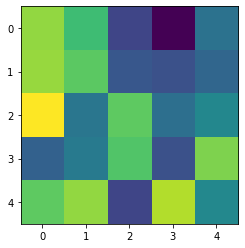

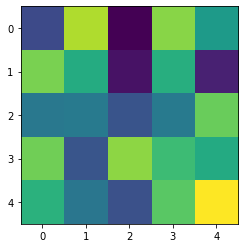

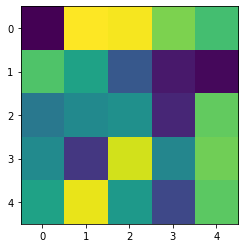

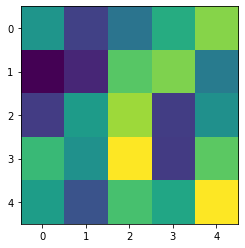

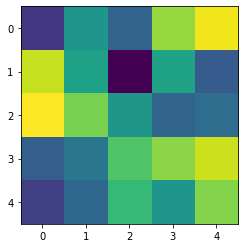

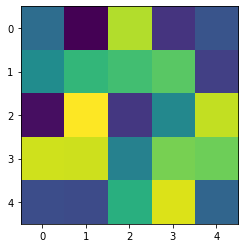

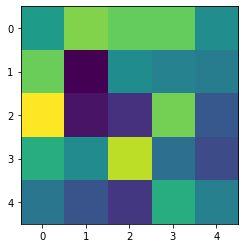

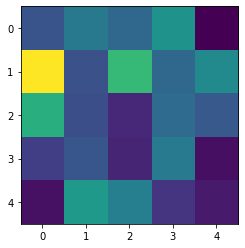

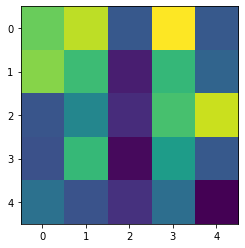

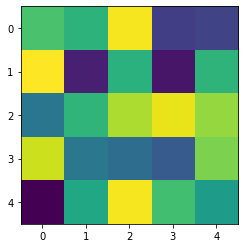

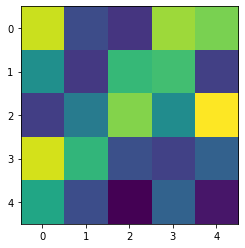

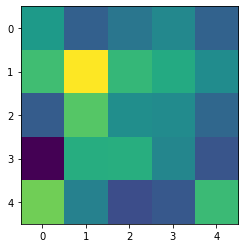

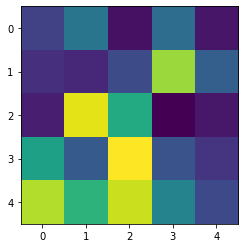

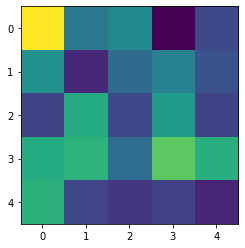

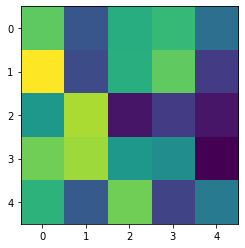

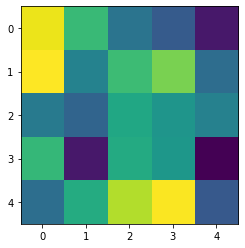

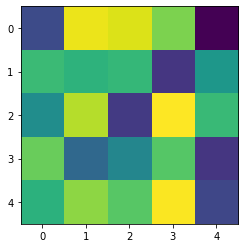

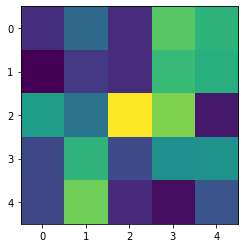

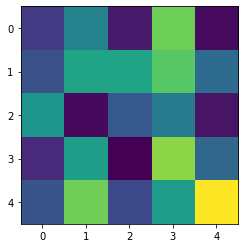

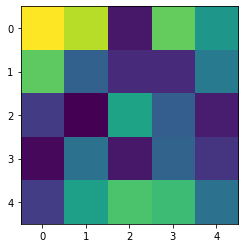

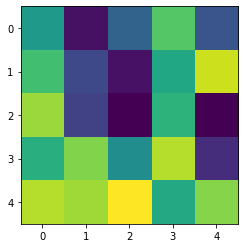

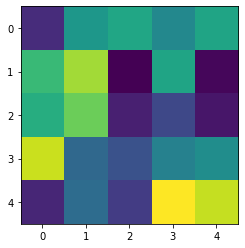

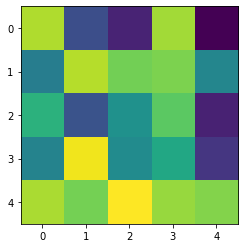

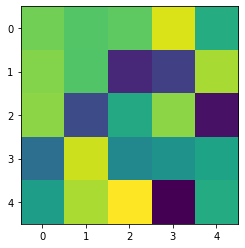

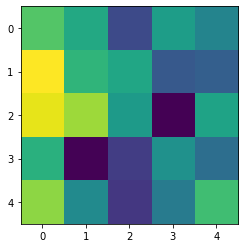

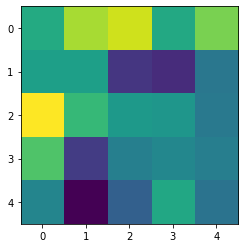

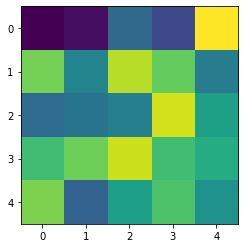

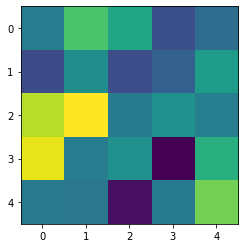

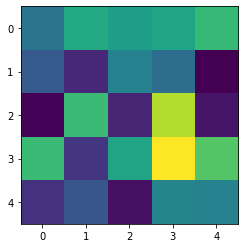

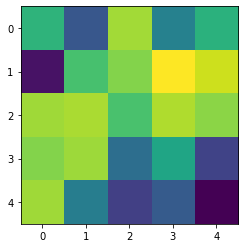

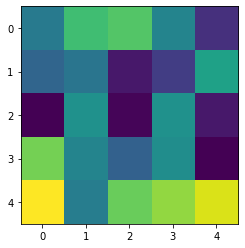

tensor([[[-0.0013, -0.0066, -0.0129,  0.0077, -0.0475],
         [-0.0209, -0.0280,  0.0237,  0.0367, -0.0269],
         [-0.0416,  0.0012, -0.0091, -0.0370, -0.0387],
         [-0.0412,  0.0280, -0.0171, -0.0159,  0.0040],
         [-0.0246,  0.0434, -0.0113, -0.0189, -0.0112]],

        [[-0.0599, -0.0196, -0.0185, -0.0228, -0.0158],
         [-0.0460,  0.0066, -0.0247, -0.0597, -0.0485],
         [-0.0197, -0.0018, -0.0410, -0.0431, -0.0297],
         [-0.0617, -0.0383, -0.0489,  0.0039, -0.0495],
         [-0.0327,  0.0006, -0.0317,  0.0047, -0.0461]],

        [[-0.0205, -0.0208, -0.0524, -0.0030, -0.0200],
         [-0.0532, -0.0051, -0.0414, -0.0388, -0.0091],
         [-0.0147, -0.0452, -0.0150, -0.0152, -0.0396],
         [-0.0092, -0.0240, -0.0116, -0.0308, -0.0164],
         [-0.0170,  0.0100, -0.0549, -0.0371, -0.0039]],

        [[-0.0436, -0.0531,  0.0058, -0.0062,  0.0060],
         [-0.0073, -0.0342, -0.0456, -0.0433, -0.0201],
         [-0.0185,  0.0161, -0.0103, -0.02

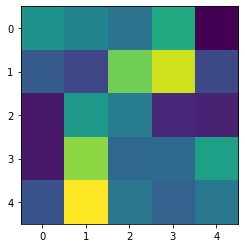

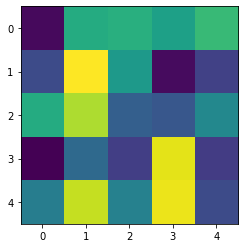

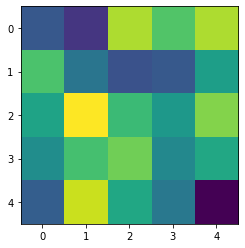

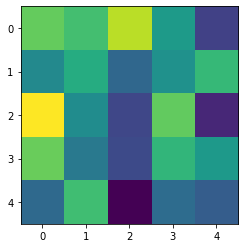

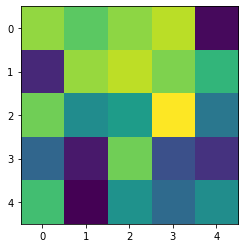

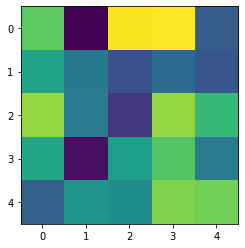

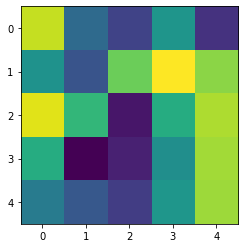

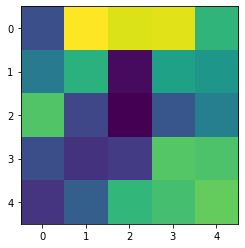

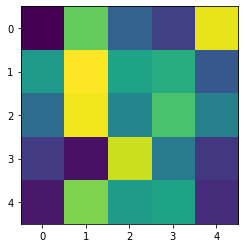

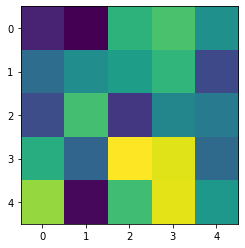

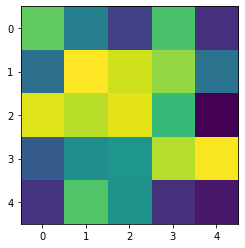

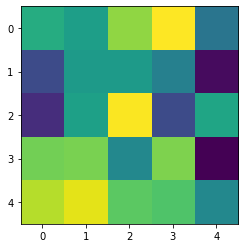

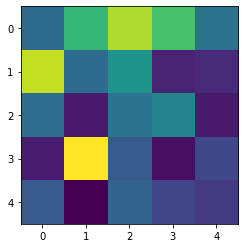

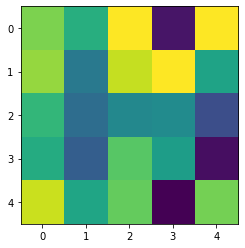

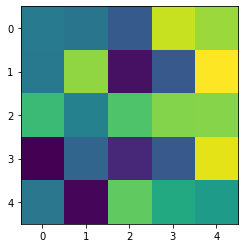

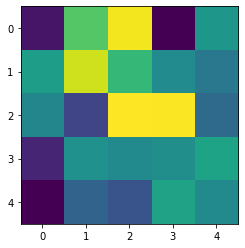

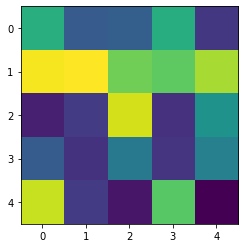

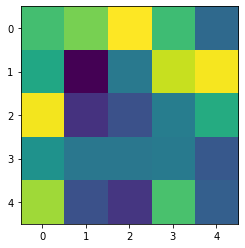

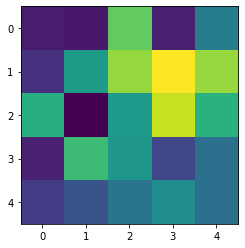

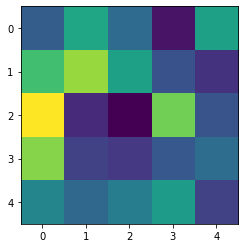

tensor([[[-7.9038e-02, -1.0945e-01, -9.7603e-02, -1.0004e-01, -1.3347e-01],
         [ 4.6033e-03, -4.4412e-02, -4.1860e-02, -1.1443e-01, -4.0134e-02],
         [ 3.2431e-02, -2.4653e-02, -5.4873e-02, -1.0035e-01,  3.0994e-02],
         [ 3.6438e-02,  4.3321e-02,  3.8464e-02, -2.8957e-02,  7.9545e-02],
         [ 5.4350e-02,  4.7146e-02,  1.6566e-02,  5.7036e-02,  1.4732e-01]],

        [[-5.6499e-02, -4.2121e-02, -5.9729e-02, -2.4617e-02, -1.0701e-02],
         [-2.1957e-02,  1.4188e-02, -1.3119e-03, -3.8706e-02, -1.1797e-02],
         [ 3.4073e-02, -1.4972e-03, -3.9145e-02, -2.2838e-03, -4.7181e-02],
         [ 1.5088e-02, -1.7705e-02,  4.2435e-02, -1.5931e-02, -1.9542e-02],
         [ 4.7367e-02, -2.4826e-03,  5.7299e-02,  2.7100e-02,  2.9727e-02]],

        [[-1.8213e-02, -2.6301e-02, -4.0979e-02, -5.6481e-02, -7.2936e-02],
         [ 5.1655e-02,  3.6346e-03, -2.6448e-02, -5.0627e-02, -1.2435e-02],
         [ 1.2492e-02, -3.5636e-02, -2.1718e-02, -6.2471e-03,  1.5623e-02],
        

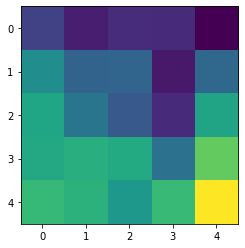

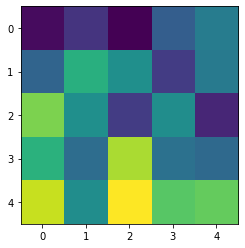

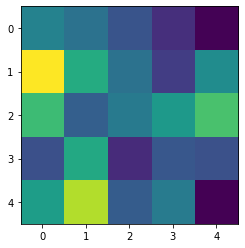

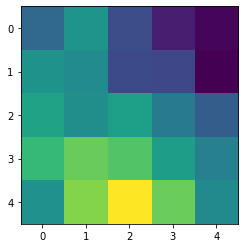

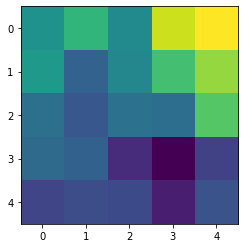

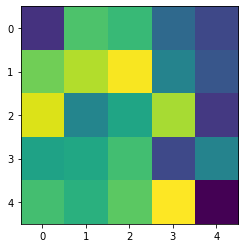

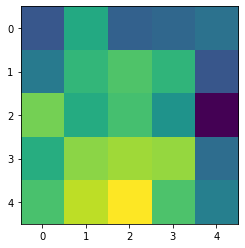

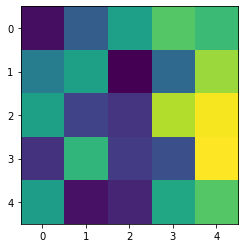

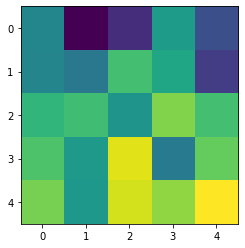

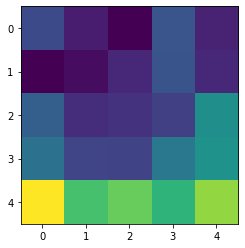

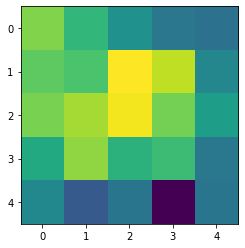

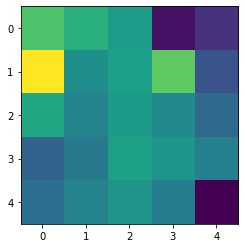

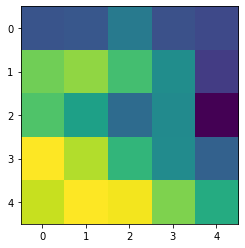

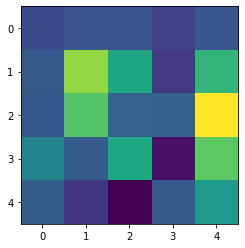

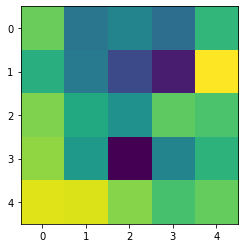

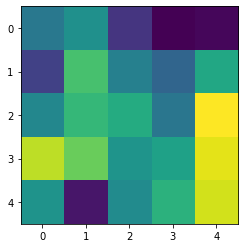

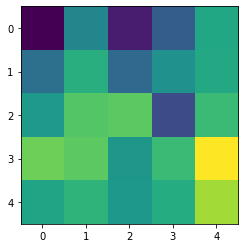

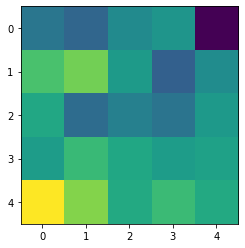

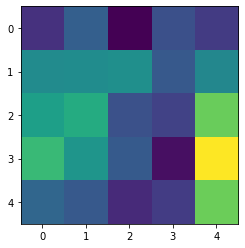

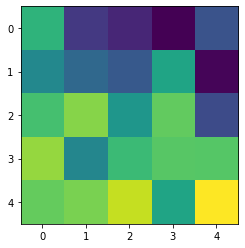

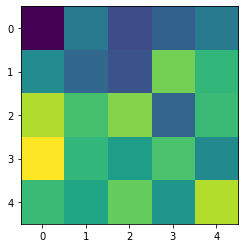

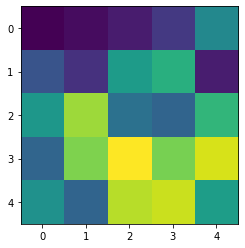

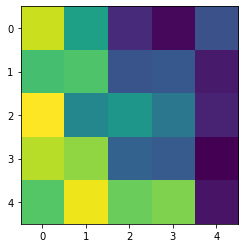

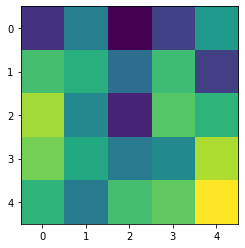

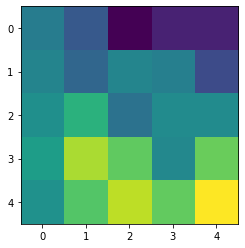

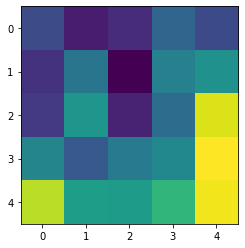

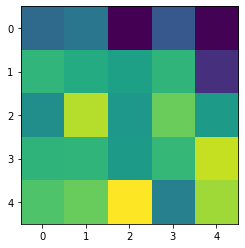

tensor([[[-2.0426e-02,  2.3934e-02, -3.2821e-02,  8.5219e-03, -3.6841e-02],
         [-5.6839e-03,  5.8419e-03, -7.7497e-03,  2.2596e-02,  2.8084e-03],
         [-1.2603e-02, -3.6437e-02, -2.8451e-02,  1.1905e-02,  1.7427e-02],
         [ 1.8829e-02, -1.4791e-02, -3.0463e-02,  2.6016e-02, -3.5325e-02],
         [ 7.5257e-03,  1.2562e-02,  8.5817e-03,  2.5094e-02, -1.7887e-03]],

        [[-3.4474e-02, -1.0501e-02, -3.0878e-03, -1.2655e-02,  7.6592e-03],
         [ 1.1292e-02, -2.1245e-02, -1.4060e-02, -1.6781e-02, -2.0209e-02],
         [-3.6325e-02, -1.8743e-02, -1.0204e-02, -3.4490e-02, -3.3297e-02],
         [ 2.3989e-02,  1.7598e-02, -3.3787e-02, -2.8184e-02,  7.5095e-03],
         [ 3.2957e-03, -2.8884e-02, -9.0424e-03, -3.1236e-02, -6.2572e-03]],

        [[-3.0562e-02, -1.1040e-02, -7.9365e-03, -2.7026e-02,  2.3713e-02],
         [-1.2780e-02,  1.2727e-02, -8.7583e-04, -2.0807e-02,  1.3609e-02],
         [-8.5852e-03, -2.1699e-02, -1.0357e-02, -3.2847e-02, -1.1257e-02],
        

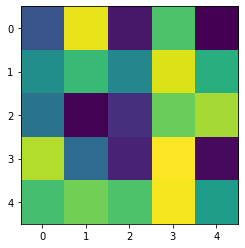

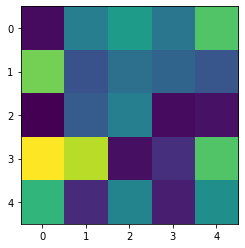

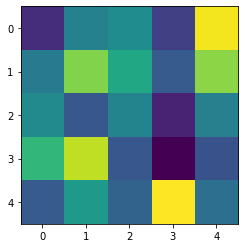

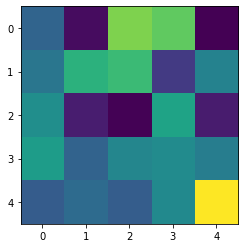

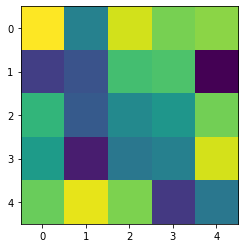

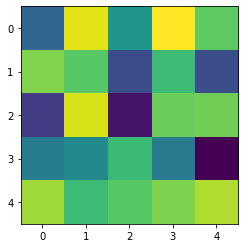

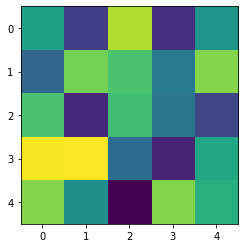

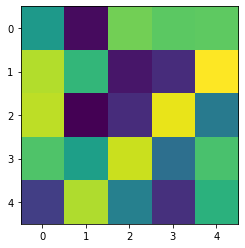

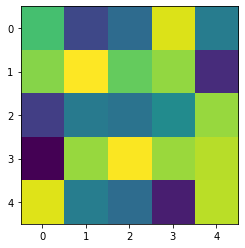

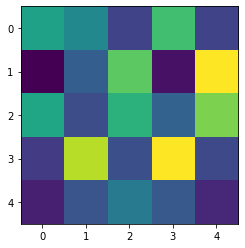

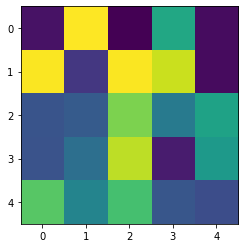

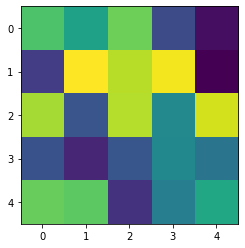

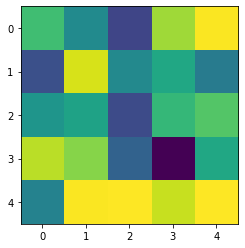

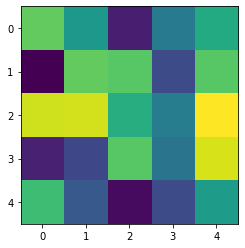

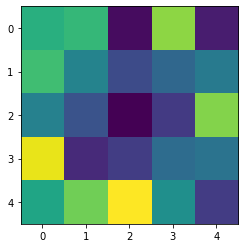

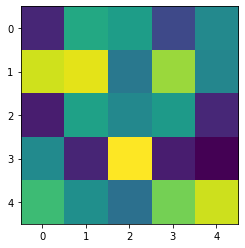

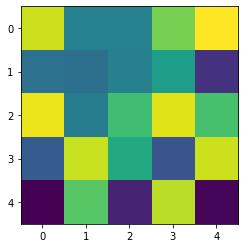

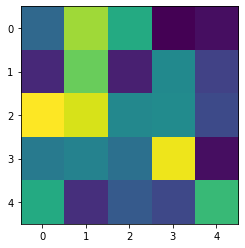

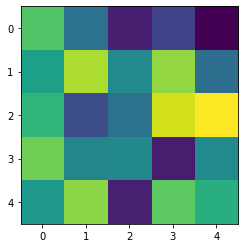

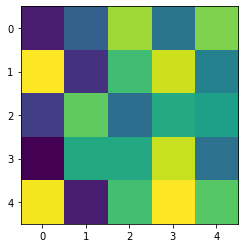

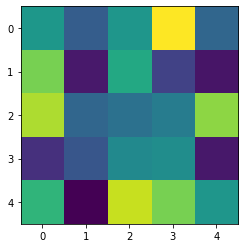

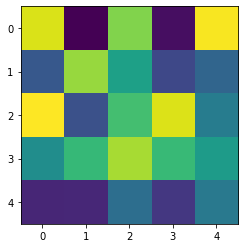

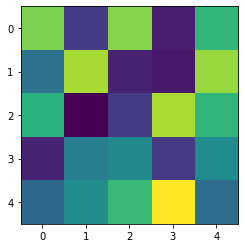

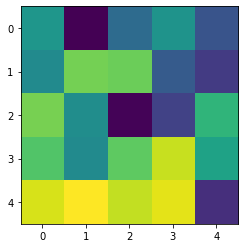

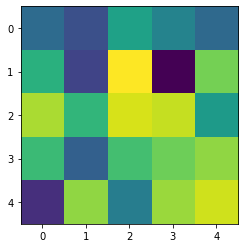

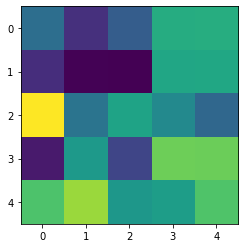

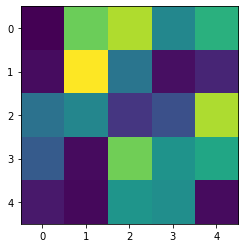

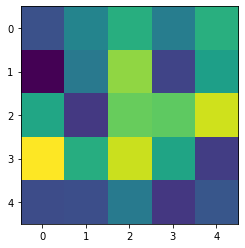

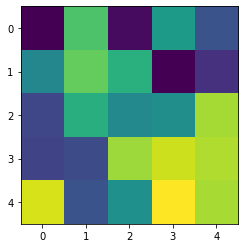

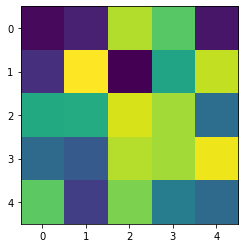

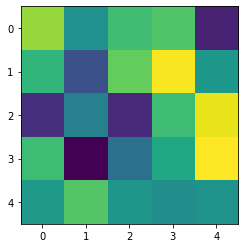

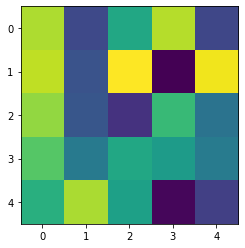

tensor([[[ 3.4167e-04,  3.2488e-02,  2.3960e-02, -2.1914e-02, -8.0564e-04],
         [-2.8167e-02,  3.6945e-03,  1.3650e-02, -3.1769e-02, -7.6133e-03],
         [-8.2494e-03,  1.5725e-02, -1.1919e-02, -2.0224e-02,  2.1708e-02],
         [-2.1979e-02, -2.5611e-02, -1.1966e-02,  1.1422e-02, -2.5783e-02],
         [ 2.3738e-02, -1.3641e-02,  1.0180e-02,  2.1833e-02, -3.7312e-02]],

        [[ 2.1990e-02, -1.4971e-02,  1.5506e-02,  4.1080e-03, -1.2919e-02],
         [-2.5594e-02, -3.8952e-04,  1.2661e-02,  1.7583e-02,  2.1504e-02],
         [ 2.0520e-02, -3.9519e-02,  2.7910e-02,  1.7195e-03, -2.8301e-02],
         [-3.6018e-02,  2.9114e-02, -2.2935e-02,  3.3114e-03, -2.4488e-02],
         [-4.1041e-02,  1.4134e-02, -3.3808e-02, -1.8237e-03,  2.9192e-02]],

        [[ 2.3685e-02,  3.3489e-03, -2.2517e-02, -3.7600e-02, -2.2587e-02],
         [-2.0978e-02,  2.7887e-02, -1.8671e-02, -4.0775e-02, -7.2226e-03],
         [-3.4149e-02, -9.3776e-03, -2.5969e-02,  2.1401e-02, -1.9949e-02],
        

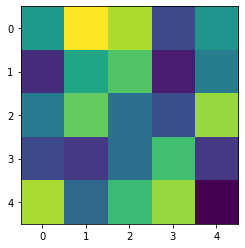

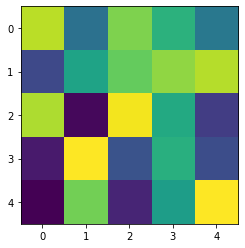

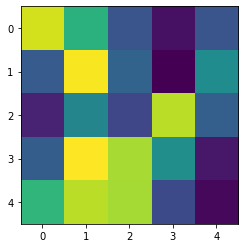

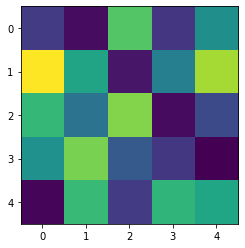

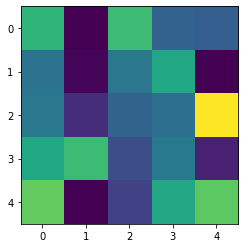

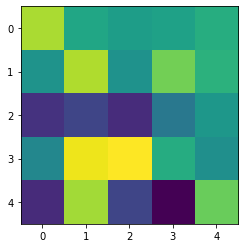

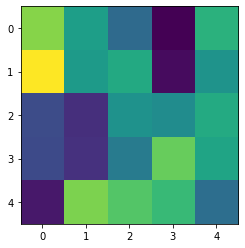

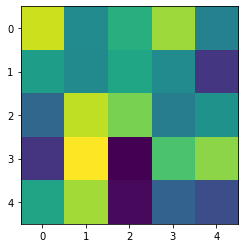

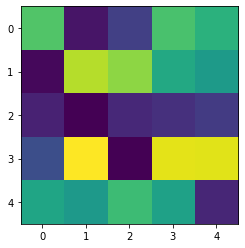

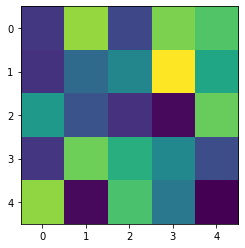

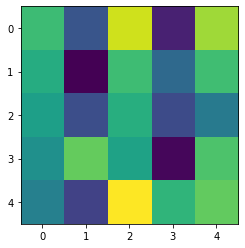

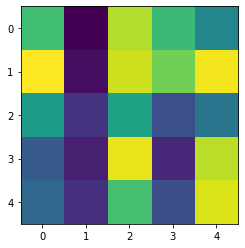

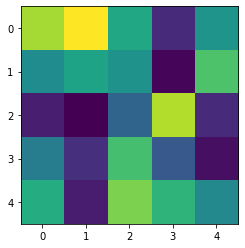

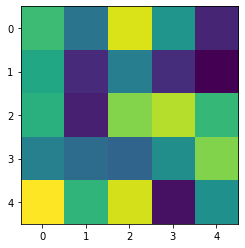

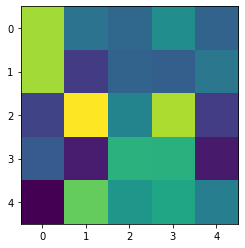

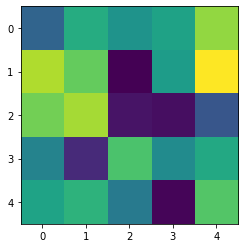

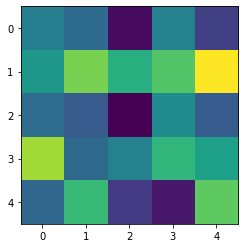

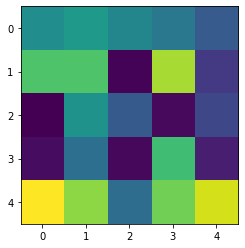

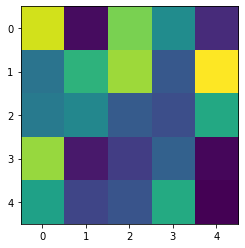

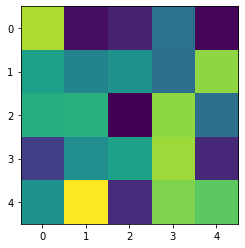

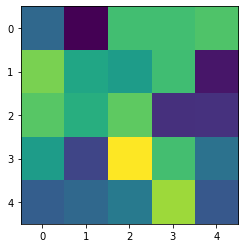

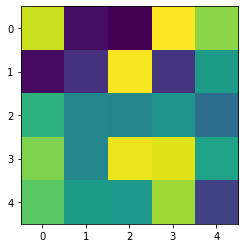

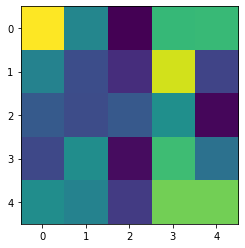

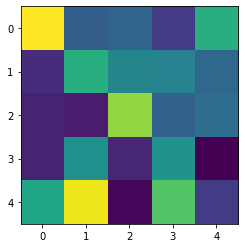

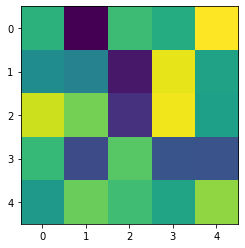

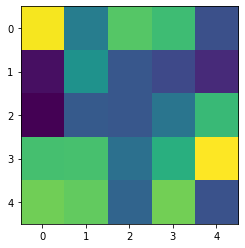

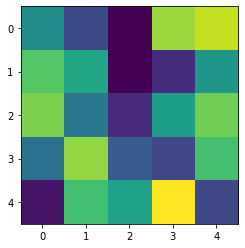

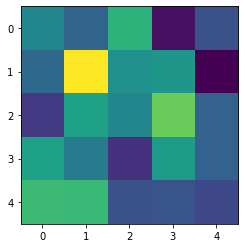

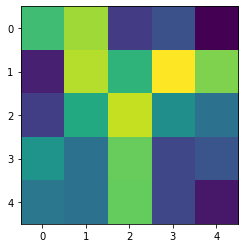

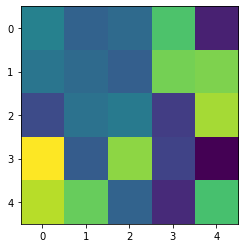

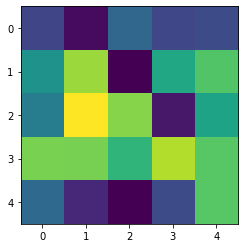

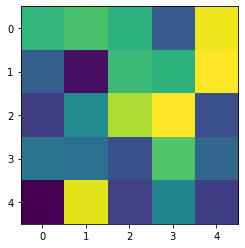

tensor([[[-2.5425e-02, -2.1878e-03, -1.3087e-02, -1.9362e-02, -3.6568e-02],
         [ 4.7811e-03, -3.8046e-02, -1.7490e-02, -2.7213e-02, -1.9111e-02],
         [ 2.8784e-02, -1.2461e-02,  8.0896e-04, -3.4295e-02, -2.1363e-03],
         [-6.5547e-03, -3.3719e-02, -4.0057e-02,  8.8897e-03, -2.9281e-02],
         [-1.8965e-02,  7.4497e-03,  1.1479e-02,  1.8311e-02, -2.2204e-02]],

        [[-2.4438e-02,  1.9457e-02,  2.4758e-02, -3.7384e-02,  1.6168e-02],
         [ 2.9750e-03, -4.2396e-03, -1.0802e-02, -1.2519e-02, -3.0825e-02],
         [-2.9799e-02, -2.6433e-02, -3.6305e-02, -2.2180e-02,  2.9203e-02],
         [-7.7782e-03, -1.1239e-02,  9.7297e-04,  1.4990e-02, -6.2634e-03],
         [-2.8976e-02, -2.1294e-02, -3.6245e-02,  1.4818e-02,  5.7643e-03]],

        [[-1.7277e-02, -2.8503e-02, -8.8332e-03, -1.3173e-02, -3.1098e-02],
         [ 1.4871e-02, -4.0328e-02, -1.6719e-02, -4.1146e-02,  2.3621e-02],
         [-4.0539e-02,  1.3280e-02,  1.8698e-02, -2.2111e-02, -1.3965e-04],
        

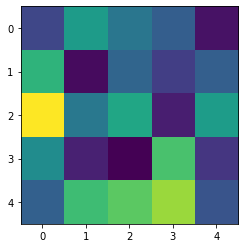

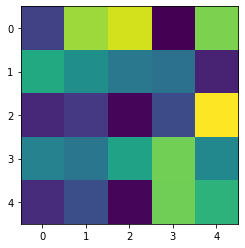

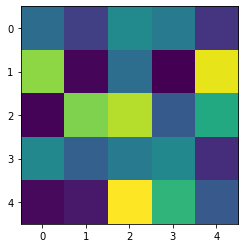

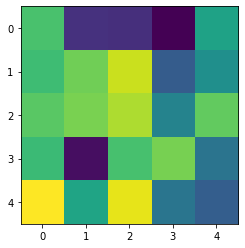

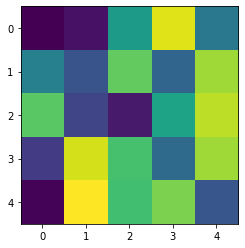

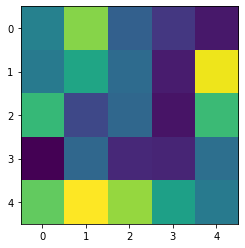

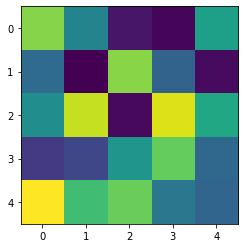

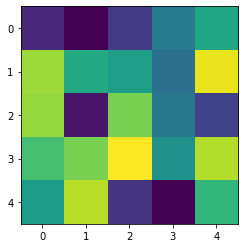

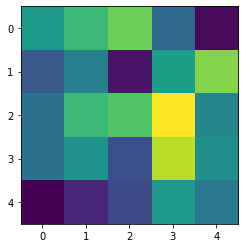

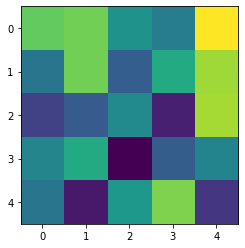

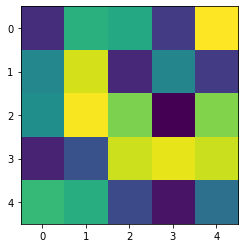

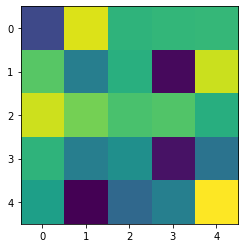

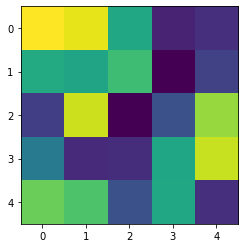

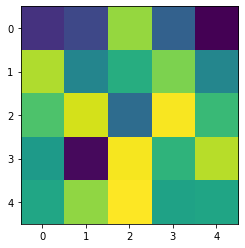

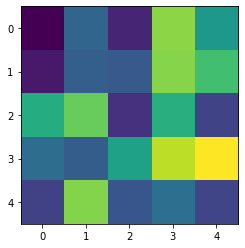

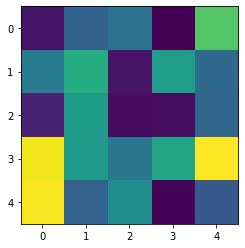

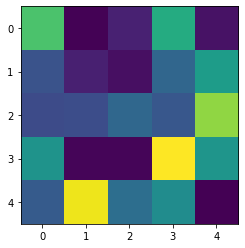

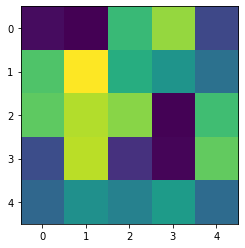

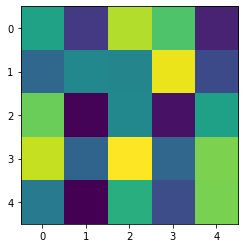

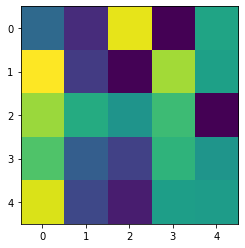

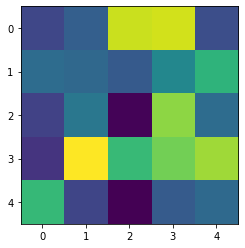

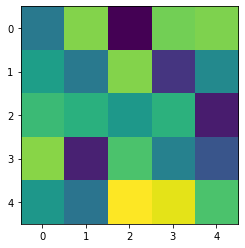

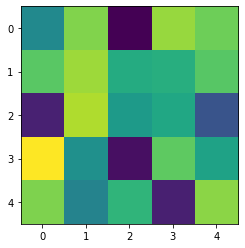

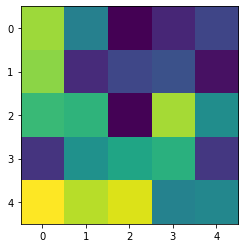

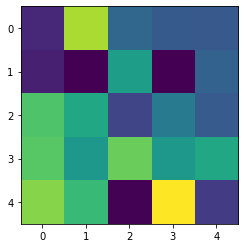

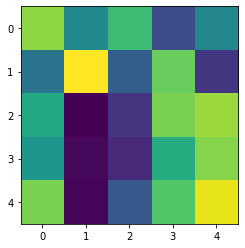

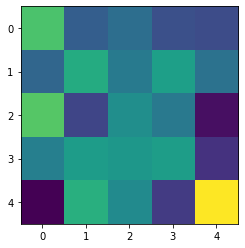

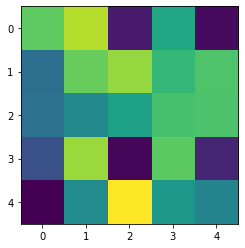

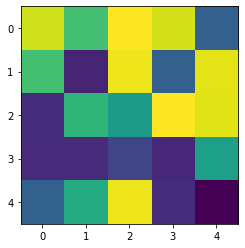

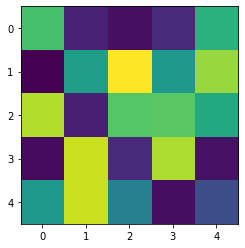

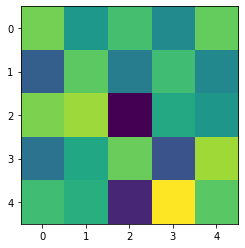

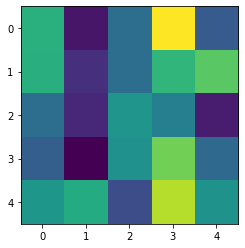

tensor([[[ 1.4047e-01, -1.1452e-01,  5.2490e-02, -7.7720e-03,  1.5043e-02],
         [ 1.2024e-01, -1.9717e-01,  3.9952e-02, -6.7710e-02, -3.3345e-02],
         [ 7.4087e-02, -1.7883e-01,  5.2687e-02, -7.8177e-02, -3.3517e-02],
         [-5.4336e-02, -1.3829e-01,  2.9758e-02, -6.3967e-02, -1.6566e-02],
         [-1.5349e-01, -1.4156e-01, -6.1568e-02, -1.2405e-01, -8.3839e-02]],

        [[ 1.8492e-02, -8.5942e-03,  4.4205e-04,  2.8969e-02, -3.5655e-02],
         [-6.6498e-03, -3.0972e-02,  3.2875e-02, -3.0754e-02,  1.7024e-02],
         [-8.3081e-03, -2.0979e-02, -1.2086e-02, -9.3110e-03,  2.7760e-02],
         [-1.1334e-02,  2.4919e-02,  2.7093e-02,  2.6815e-02,  5.4547e-03],
         [ 6.1927e-03,  4.7949e-02,  3.4789e-02,  2.5852e-02,  3.9118e-02]],

        [[ 2.2894e-02,  3.9981e-02, -2.6711e-02, -6.7356e-02,  1.4981e-02],
         [ 1.7263e-02,  7.3627e-02, -4.1694e-02, -2.6187e-02, -2.9439e-02],
         [ 8.7752e-02,  3.1641e-02, -4.5841e-03,  6.4526e-02, -3.2951e-02],
        

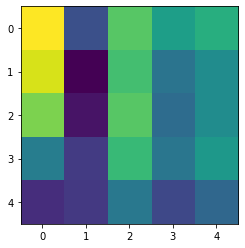

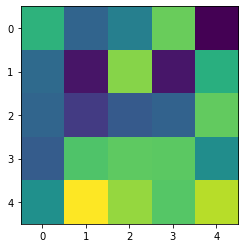

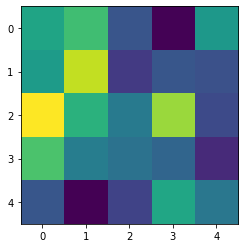

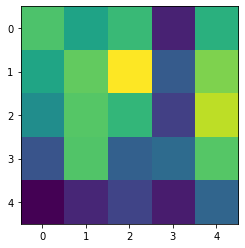

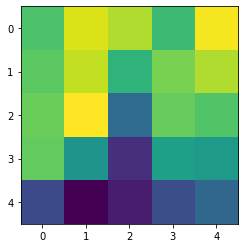

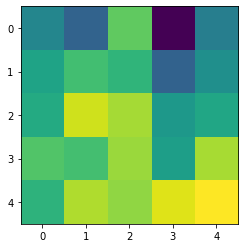

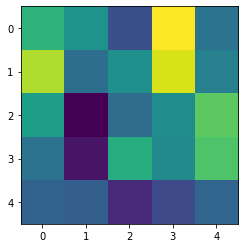

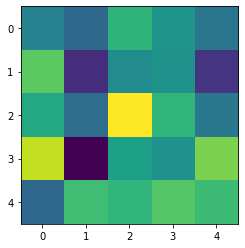

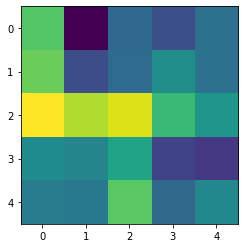

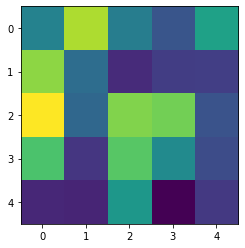

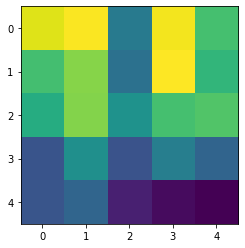

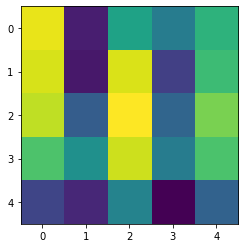

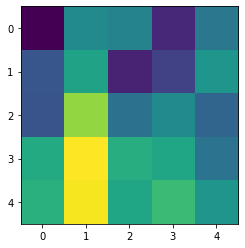

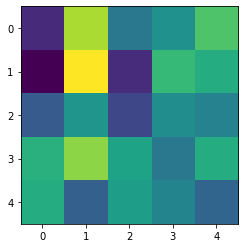

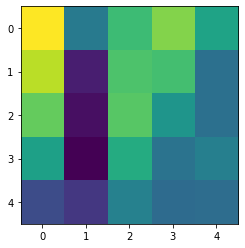

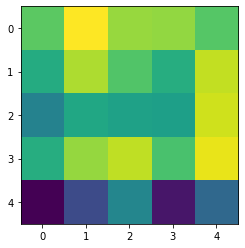

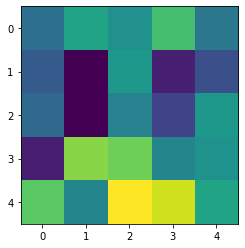

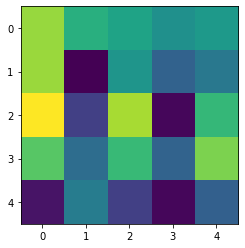

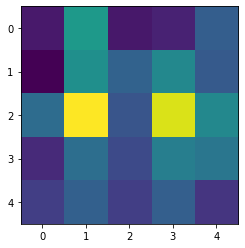

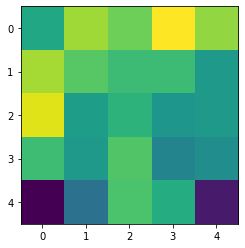

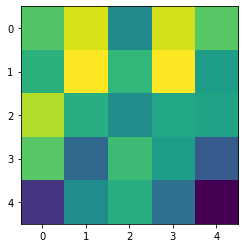

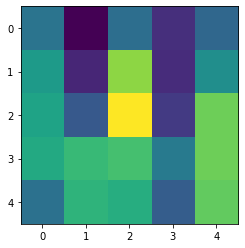

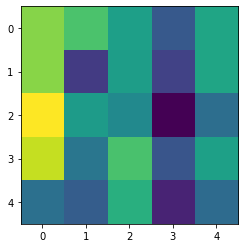

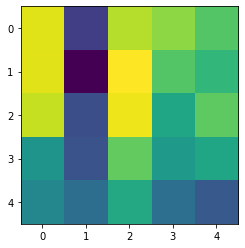

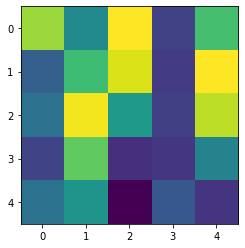

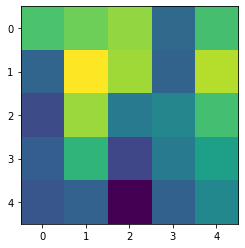

tensor([[[ 3.5139e-03,  3.0009e-02, -5.1488e-02, -9.4052e-02, -1.5366e-01],
         [-8.7728e-04, -2.5021e-02, -1.1852e-02,  2.5072e-02,  2.8994e-02],
         [ 2.0842e-02,  2.1593e-02,  2.1281e-02,  8.6523e-02,  8.3991e-02],
         [ 1.7549e-02,  7.3067e-02,  3.6981e-02,  3.7553e-02,  3.9137e-02],
         [ 7.8184e-03,  7.4380e-02,  8.4314e-03, -4.4502e-02,  3.6510e-02]],

        [[ 4.6492e-02,  3.0693e-02, -3.4413e-03, -7.2945e-02, -8.7588e-02],
         [ 3.4599e-02,  2.6226e-02,  1.2032e-02, -5.0240e-02, -5.3363e-02],
         [ 3.0613e-02,  2.9768e-02,  2.7941e-02,  2.2300e-02, -1.0245e-02],
         [ 5.6002e-02,  8.3079e-02,  2.1899e-02,  2.7301e-02,  7.3346e-03],
         [ 5.5589e-02,  6.2913e-02,  3.6609e-02,  1.3713e-02,  1.0460e-02]],

        [[-1.8015e-02,  4.9114e-03,  1.6041e-02,  4.7439e-02, -3.8752e-02],
         [-1.2745e-02, -5.8849e-02, -5.1611e-02,  3.8519e-02,  1.1687e-01],
         [-5.7917e-03, -5.8260e-02, -1.0701e-01, -9.0619e-02,  5.3727e-02],
        

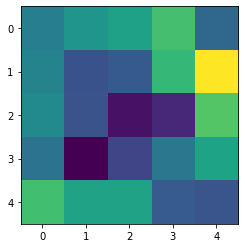

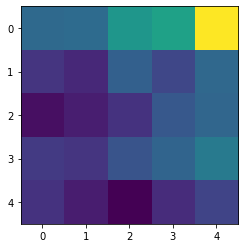

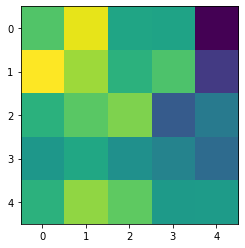

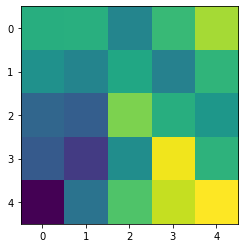

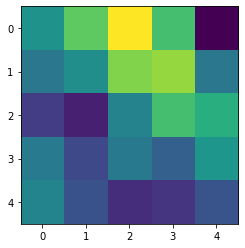

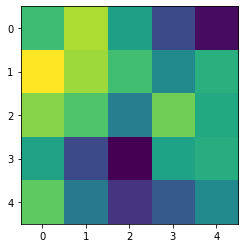

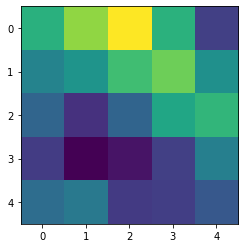

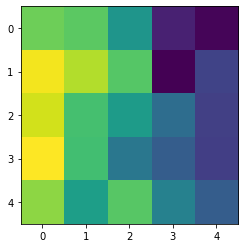

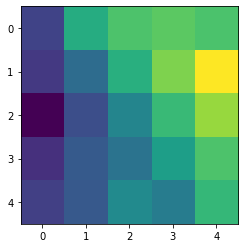

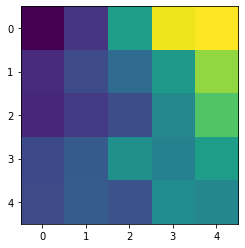

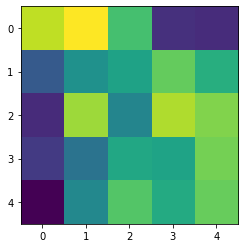

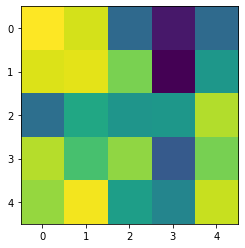

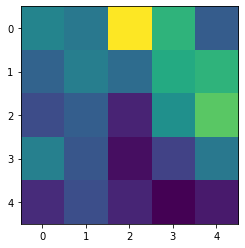

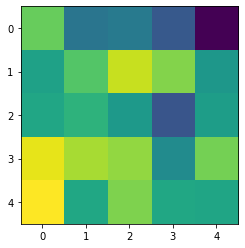

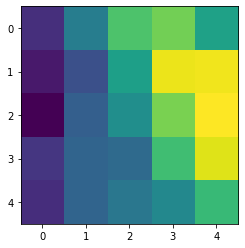

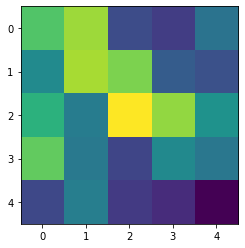

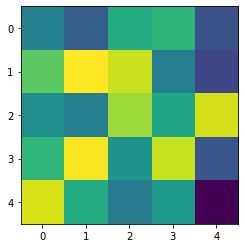

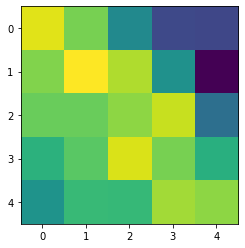

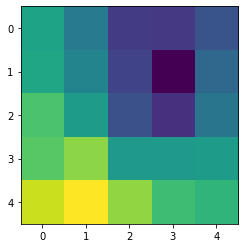

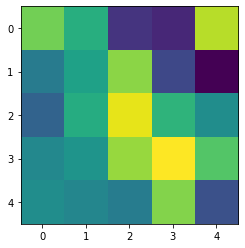

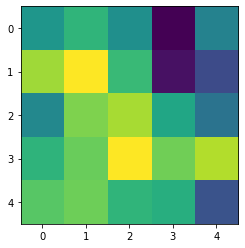

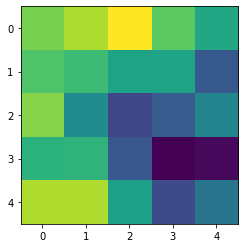

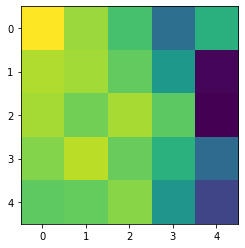

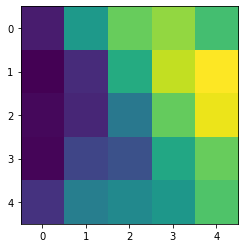

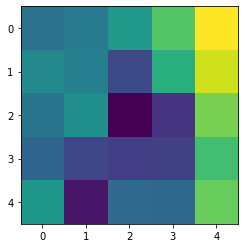

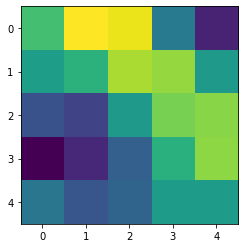

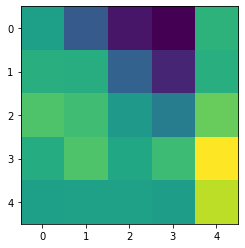

tensor([[[-3.3530e-02, -1.7079e-02, -3.1341e-02,  1.3299e-02, -9.7930e-03],
         [ 1.3831e-02,  2.2286e-03,  1.4770e-02, -3.0945e-03, -1.0480e-02],
         [-2.0632e-02, -2.1502e-02, -4.9710e-03,  1.6583e-02,  1.4877e-02],
         [-3.7181e-02, -1.5631e-02,  1.0260e-02, -2.9109e-02,  1.6654e-02],
         [ 1.2879e-02, -1.3516e-02, -3.4710e-02,  2.9033e-03,  1.0365e-02]],

        [[ 2.0519e-02,  2.8788e-02, -3.3093e-03,  2.6205e-02, -2.6163e-02],
         [-1.8090e-02, -9.4533e-03, -2.8692e-02, -1.4612e-02, -3.4632e-02],
         [ 2.4342e-02,  5.8869e-03, -1.8474e-02, -9.2521e-03, -2.6879e-02],
         [-4.0778e-02, -1.9979e-02,  1.2381e-02, -7.2713e-03, -5.4101e-03],
         [ 1.5001e-02, -1.2093e-02, -2.2921e-02, -2.4257e-03, -1.3260e-02]],

        [[-1.2098e-02,  1.8974e-03, -6.3891e-03, -7.4523e-03,  1.1438e-02],
         [-1.2324e-02,  1.1717e-02, -1.4236e-02,  8.5632e-04,  2.4730e-02],
         [-1.9745e-02, -2.6492e-02,  9.2885e-04, -1.5672e-02, -3.1939e-02],
        

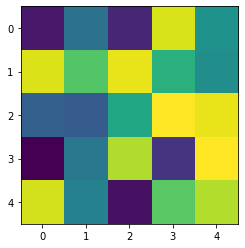

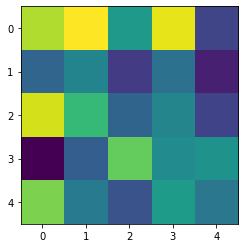

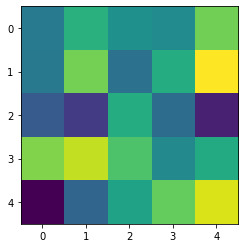

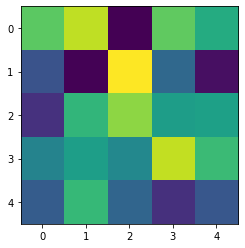

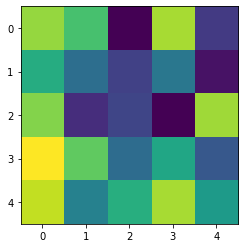

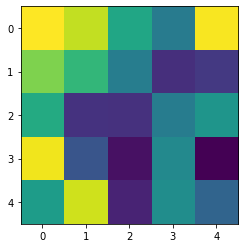

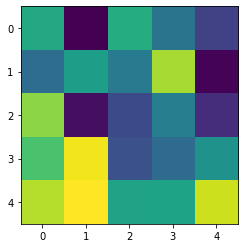

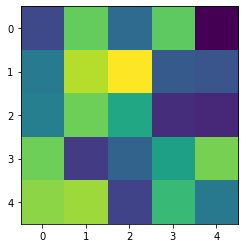

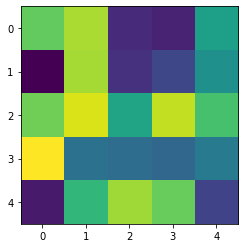

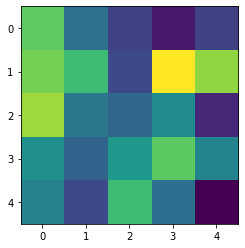

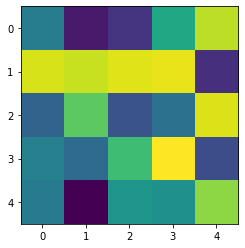

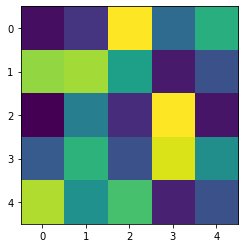

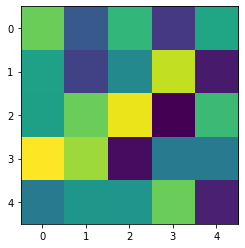

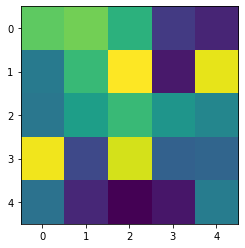

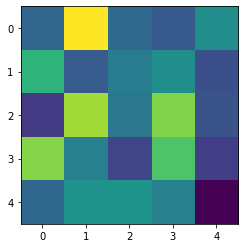

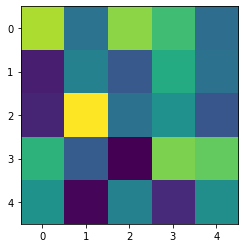

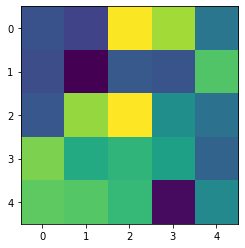

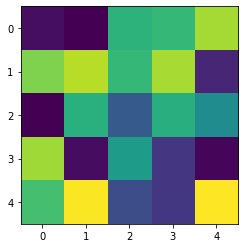

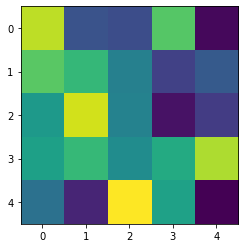

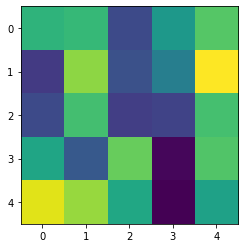

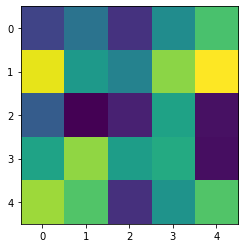

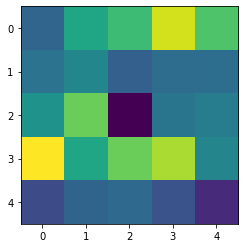

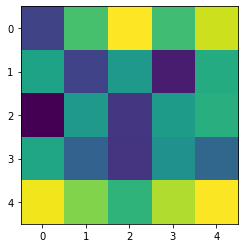

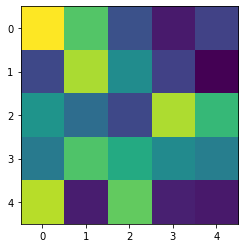

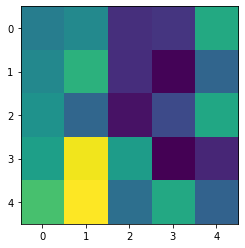

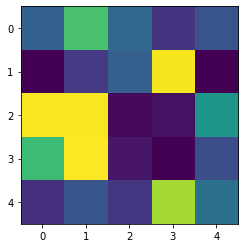

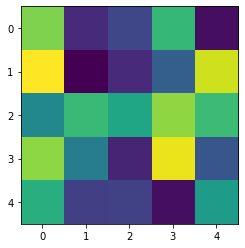

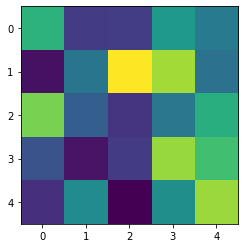

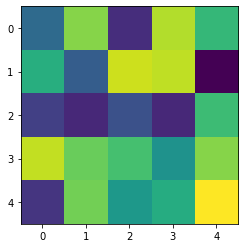

tensor([[[-0.0033, -0.0304,  0.0280,  0.0792,  0.0372],
         [ 0.0675, -0.0307, -0.0233,  0.0301,  0.0359],
         [ 0.0253, -0.0035, -0.0062,  0.0588,  0.0229],
         [ 0.0038,  0.0331,  0.0285,  0.0144, -0.0089],
         [ 0.0332, -0.0321, -0.0021,  0.0360, -0.0416]],

        [[ 0.0766,  0.0511,  0.0210,  0.0925,  0.0410],
         [ 0.0439,  0.0342,  0.0035,  0.0449,  0.0174],
         [ 0.0046,  0.0434,  0.0292, -0.0023,  0.0215],
         [-0.0084,  0.0304, -0.0120,  0.0515,  0.0014],
         [ 0.0332, -0.0156, -0.0225,  0.0427, -0.0087]],

        [[ 0.0475,  0.0124, -0.0388, -0.0384, -0.0132],
         [-0.0253, -0.0708, -0.0576,  0.0033, -0.0274],
         [-0.0558, -0.0712, -0.0456, -0.0595, -0.0667],
         [-0.0277, -0.0278, -0.0351,  0.0048,  0.0329],
         [-0.0089, -0.0086,  0.0019, -0.0193,  0.0498]],

        [[-0.0623, -0.0857,  0.0125,  0.0313, -0.0144],
         [-0.1077, -0.0596, -0.0087, -0.0645, -0.0517],
         [-0.0526, -0.0507, -0.0066, -0.02

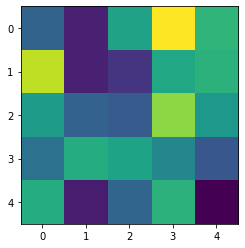

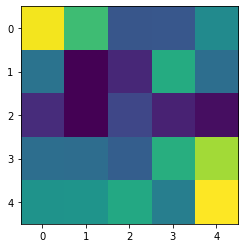

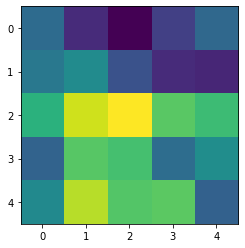

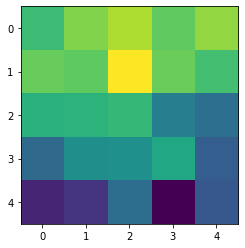

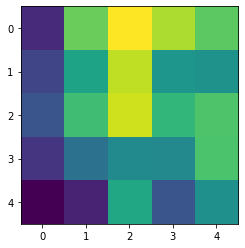

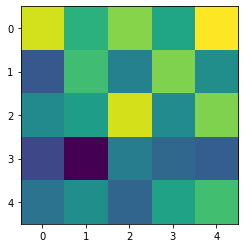

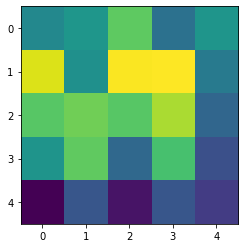

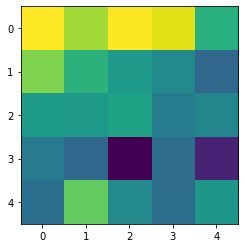

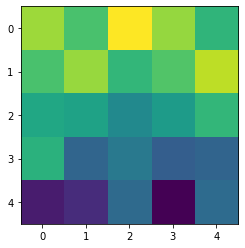

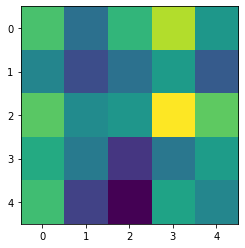

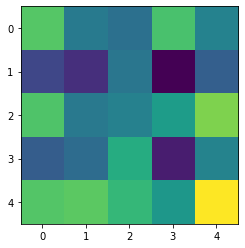

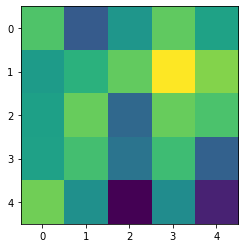

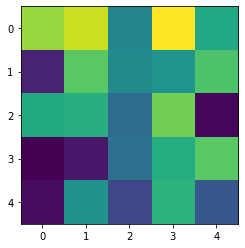

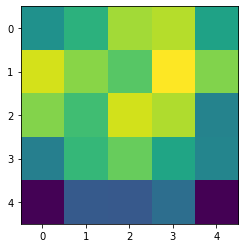

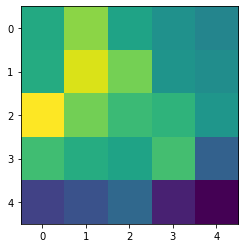

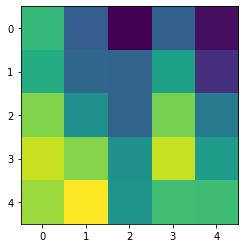

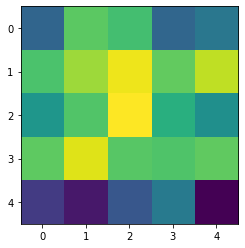

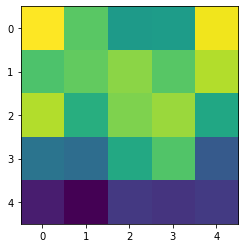

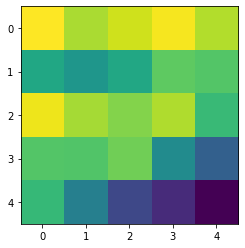

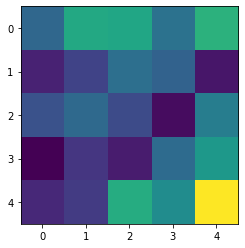

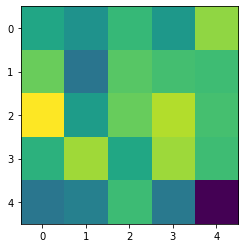

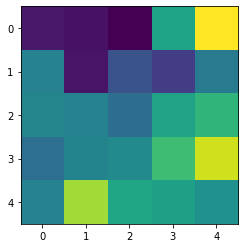

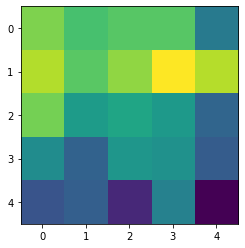

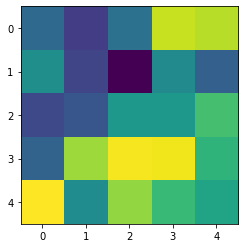

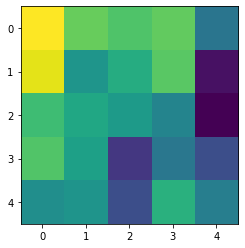

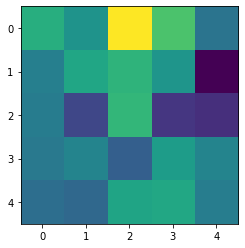

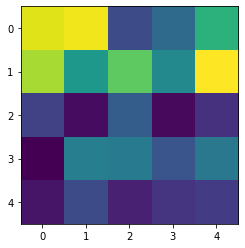

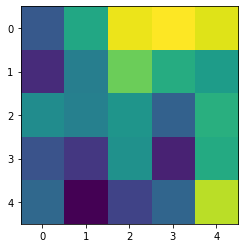

tensor([[[-1.3045e-01, -1.2951e-01, -1.0930e-01, -1.4456e-01, -9.8093e-02],
         [-1.0397e-01, -1.0535e-01, -1.9709e-01, -1.5390e-01, -1.2168e-01],
         [-1.0981e-01, -7.1774e-02, -6.7182e-02, -6.5074e-02, -8.1870e-02],
         [-7.1720e-02, -3.3308e-02, -3.9891e-02, -1.4126e-03, -4.2168e-03],
         [-5.4212e-02, -5.7680e-02,  3.4941e-02,  4.2808e-03,  2.3212e-02]],

        [[-1.1079e-01, -1.0057e-01, -1.0635e-01, -4.3422e-02, -8.3505e-02],
         [-6.8292e-02, -1.0139e-01, -9.1394e-02, -1.1276e-01, -9.9378e-02],
         [-9.1139e-02, -6.9984e-02, -3.7018e-02, -6.6228e-02, -3.7759e-02],
         [-1.8588e-02,  1.2302e-04, -1.9391e-02, -3.1496e-02,  1.0404e-03],
         [-2.3105e-02,  8.0005e-03,  1.8326e-02, -3.1921e-03, -3.6011e-03]],

        [[ 2.9887e-02,  3.8601e-02,  7.0239e-02,  2.9253e-02, -1.8087e-02],
         [ 6.3306e-03, -3.6555e-02, -4.5607e-02, -6.4594e-02, -1.2642e-01],
         [ 1.2715e-02, -1.8796e-03, -7.8300e-02, -5.4170e-02, -9.8133e-02],
        

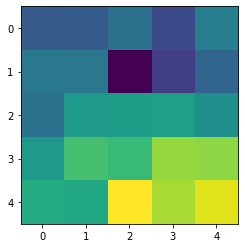

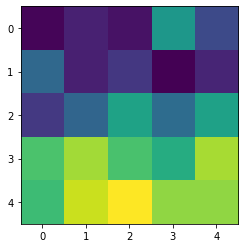

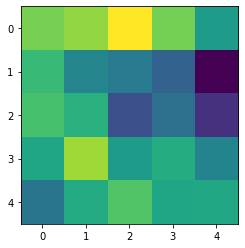

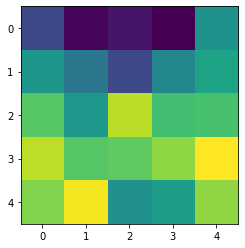

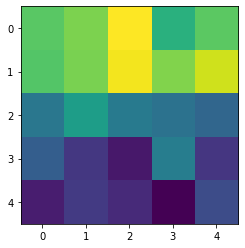

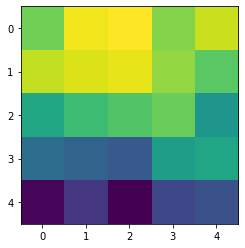

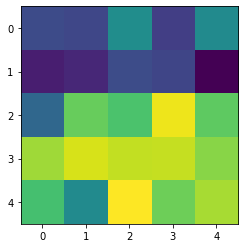

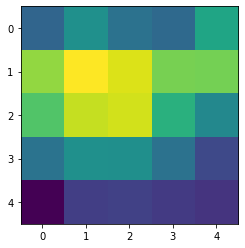

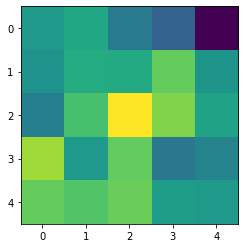

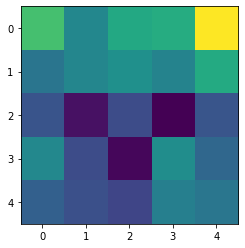

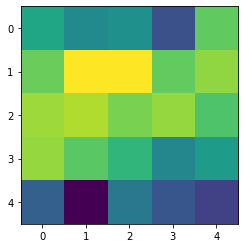

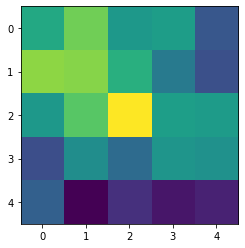

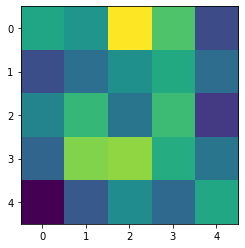

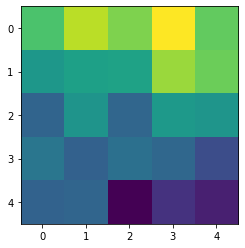

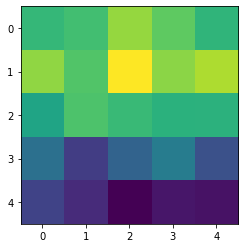

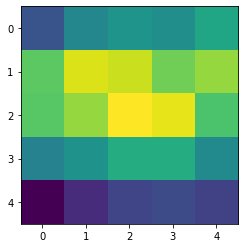

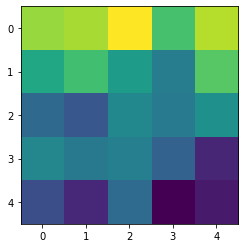

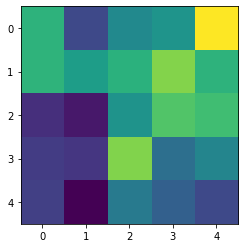

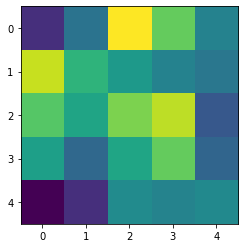

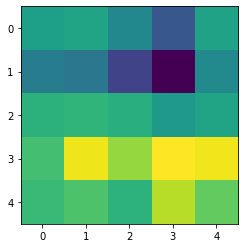

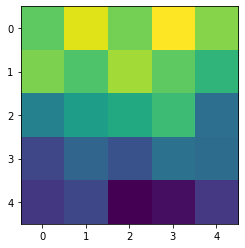

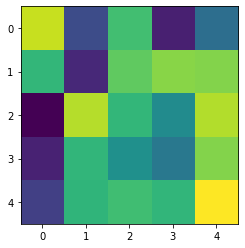

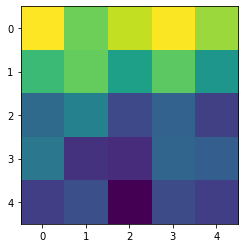

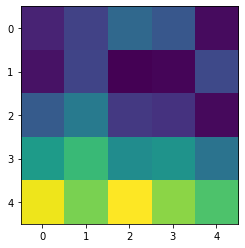

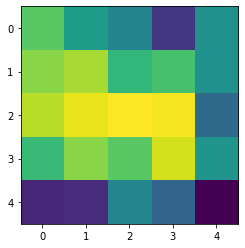

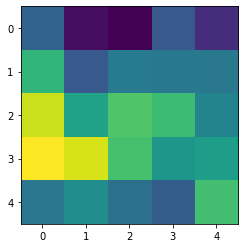

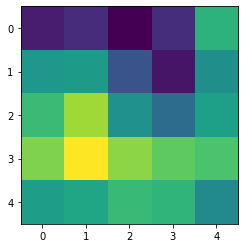

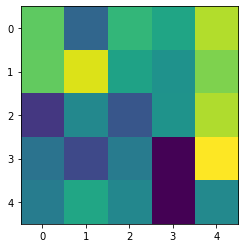

tensor([[[ 1.5850e-02, -6.4499e-02, -1.2643e-01, -8.8917e-02, -1.0183e-01],
         [ 2.6630e-02, -5.3897e-02, -1.3220e-01, -8.5805e-02, -6.1870e-02],
         [-4.8489e-02, -1.0343e-01, -1.2045e-01, -5.1409e-02,  2.4859e-02],
         [-4.9584e-02, -6.7149e-02, -6.0589e-02,  2.1667e-03,  1.6039e-02],
         [ 1.0976e-03, -5.4436e-04, -2.6236e-02,  1.7008e-02,  6.5717e-02]],

        [[ 3.3024e-02,  3.2545e-02,  3.5830e-02,  4.3120e-02,  4.7318e-02],
         [-3.2437e-03,  1.2011e-02,  5.2047e-02,  5.6235e-02,  3.7572e-02],
         [ 1.3949e-02, -1.3877e-02,  4.1804e-02,  6.5861e-03,  4.5312e-02],
         [ 4.3465e-03,  4.2422e-02,  3.7982e-03,  6.4833e-02,  7.8786e-02],
         [ 4.6300e-02, -4.1291e-04,  4.7155e-02,  2.0009e-02,  3.2087e-02]],

        [[ 1.9470e-02,  5.1973e-02,  4.2783e-02,  4.2080e-02,  8.7458e-02],
         [ 6.4030e-03,  2.5032e-03,  2.2817e-02,  5.7835e-02,  1.0558e-01],
         [ 2.9355e-02,  7.9294e-02,  7.4319e-02,  7.0603e-02,  5.9180e-02],
        

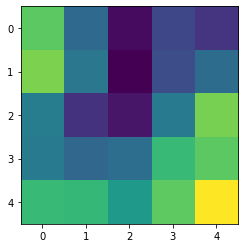

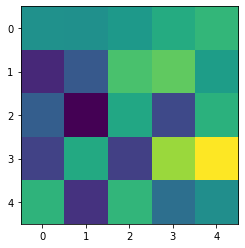

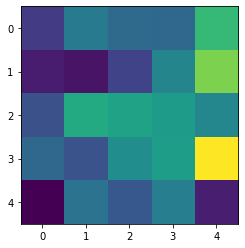

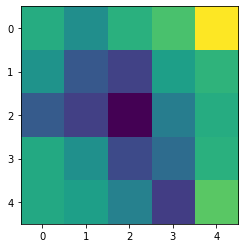

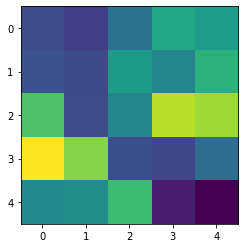

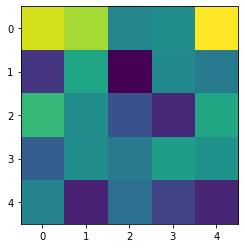

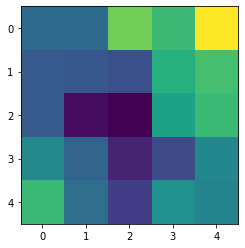

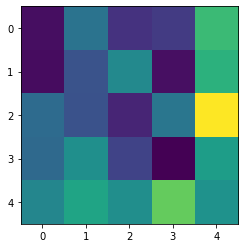

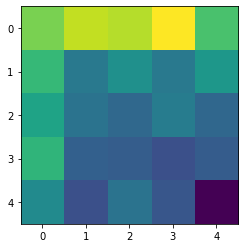

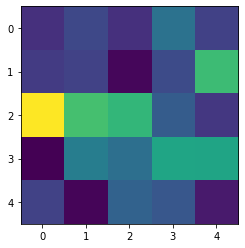

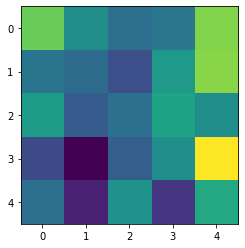

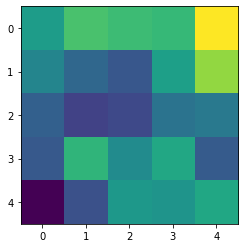

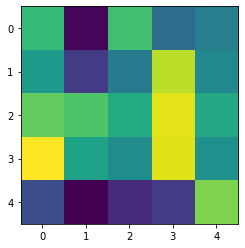

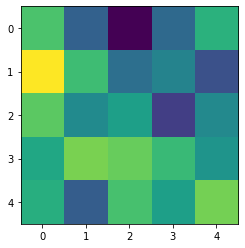

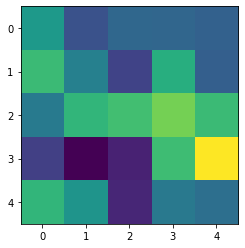

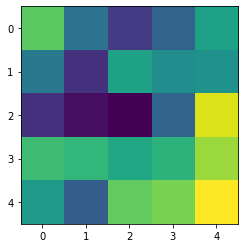

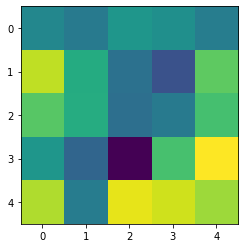

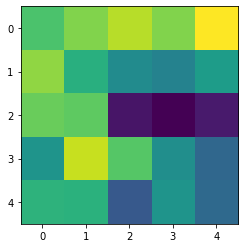

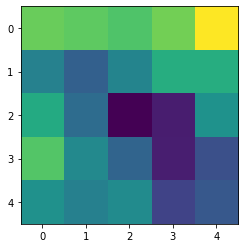

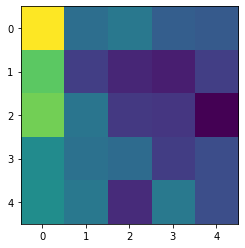

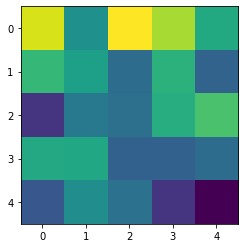

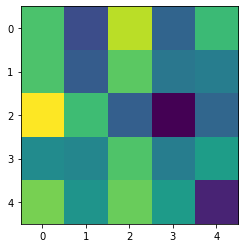

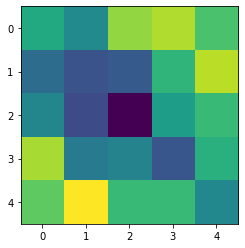

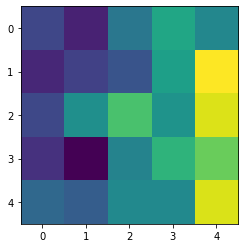

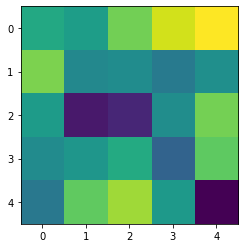

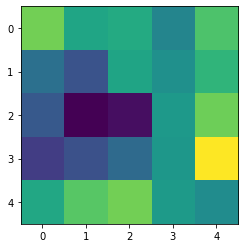

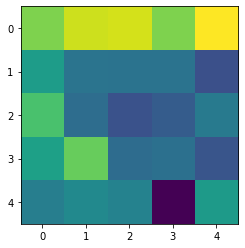

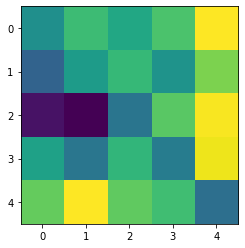

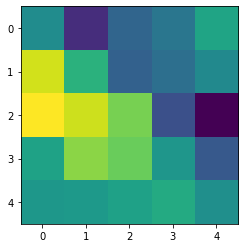

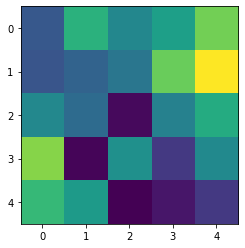

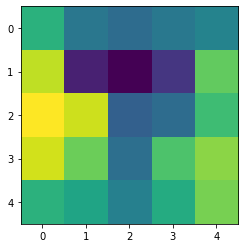

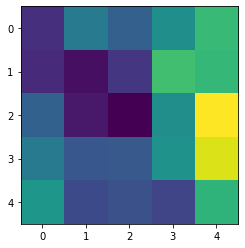

tensor([[[ 5.0655e-02,  4.0489e-02,  5.4490e-02,  2.2206e-02, -1.0452e-02],
         [ 1.3980e-02, -3.6704e-02, -2.0409e-02, -1.5579e-02, -8.7352e-03],
         [-1.0284e-02, -7.8319e-02, -6.0793e-02,  1.8377e-03,  1.7577e-02],
         [-8.2165e-02, -1.0218e-01, -6.9117e-02, -3.7460e-02,  3.4616e-02],
         [-2.5448e-02, -7.8508e-02, -6.7653e-02, -2.4294e-02,  2.1712e-02]],

        [[ 2.9189e-02, -1.1706e-02, -2.2133e-02, -8.3745e-03, -2.7158e-02],
         [ 4.0552e-02, -2.2381e-02, -1.9827e-02,  5.2122e-03,  2.1388e-02],
         [-2.5460e-02,  4.9341e-03, -1.5551e-02, -3.1579e-02,  5.8333e-02],
         [-5.2990e-03, -3.1762e-02, -2.6358e-02,  2.9123e-02,  4.0284e-02],
         [-2.3464e-02, -3.7749e-03,  1.3697e-02, -4.9040e-03,  7.0207e-02]],

        [[-5.6667e-02, -5.6449e-02, -2.6467e-02, -1.5845e-02,  3.7888e-02],
         [-1.8410e-02,  4.3546e-02,  4.3407e-02, -6.2973e-02, -2.9477e-02],
         [-8.0669e-03,  4.0218e-03, -3.4173e-02, -5.1863e-02, -3.0249e-02],
        

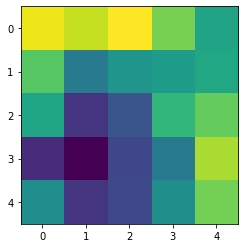

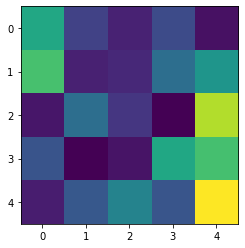

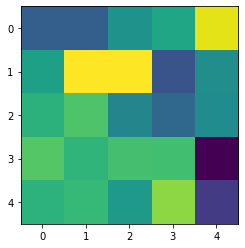

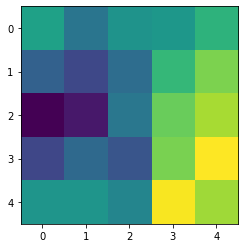

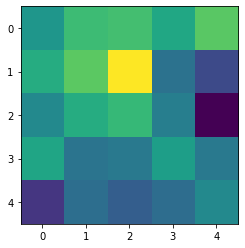

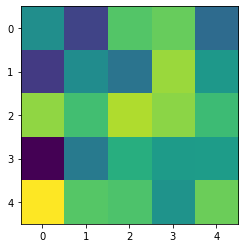

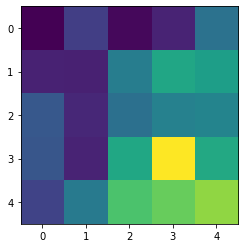

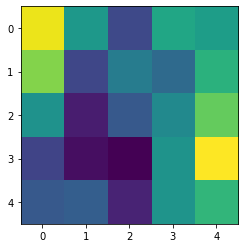

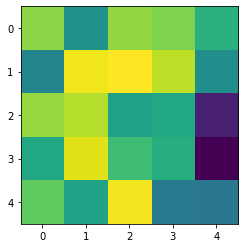

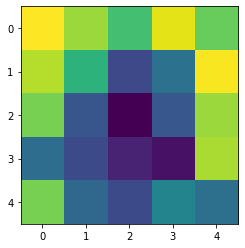

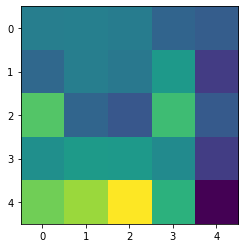

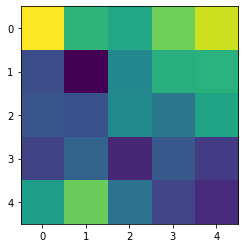

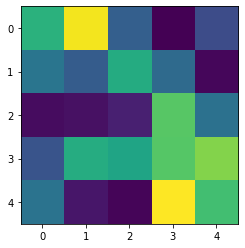

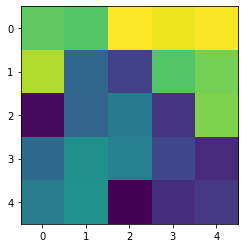

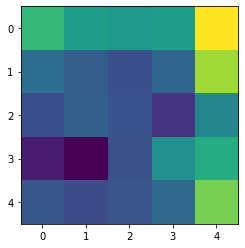

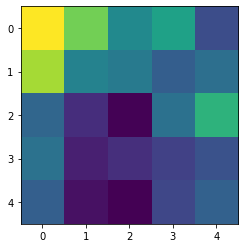

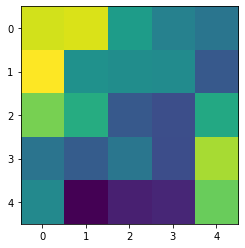

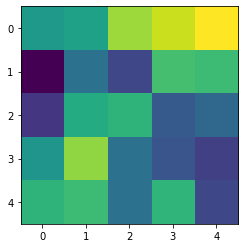

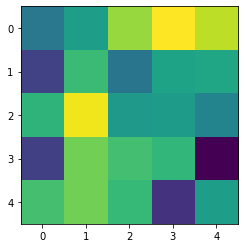

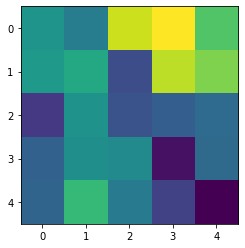

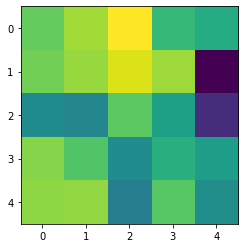

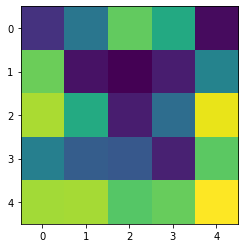

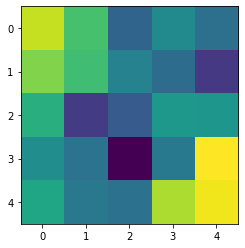

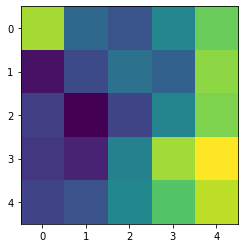

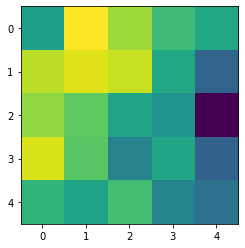

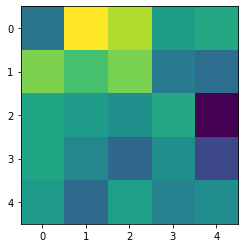

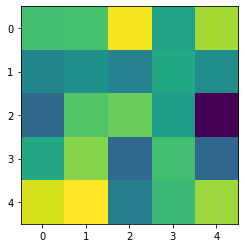

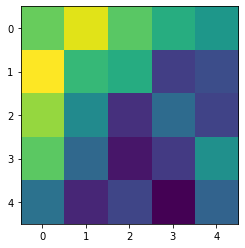

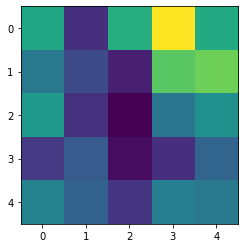

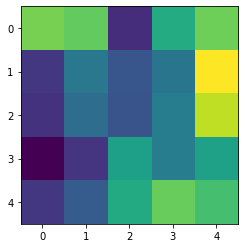

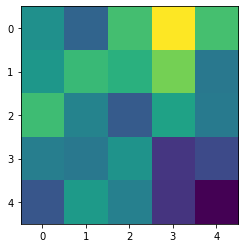

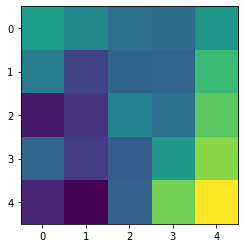

tensor([[[ 7.2075e-02,  5.2888e-02, -4.8898e-02, -8.2671e-02,  2.5064e-02],
         [ 7.6576e-02,  4.9607e-02, -9.1400e-02, -2.5336e-02, -6.0911e-04],
         [ 9.9186e-02, -4.1362e-02, -9.5851e-03, -7.2839e-02,  4.7852e-02],
         [ 5.7561e-02, -2.7636e-02,  5.8819e-02, -8.0266e-02,  1.6112e-02],
         [ 2.3900e-02, -3.1501e-02, -2.0171e-02, -9.4419e-02, -4.4044e-02]],

        [[ 1.5738e-02, -1.1907e-02, -1.1250e-02,  1.3769e-02,  2.6774e-02],
         [ 4.0489e-03, -2.5508e-02,  1.3308e-02, -4.1481e-05,  4.9435e-02],
         [-3.9343e-06, -3.0297e-02,  9.5923e-03,  1.0667e-03,  5.1622e-02],
         [-1.4026e-02,  2.7969e-02,  2.3968e-02, -6.6689e-03,  1.2563e-02],
         [-3.7909e-02,  2.3185e-02, -1.4054e-02, -3.0694e-02,  2.8175e-02]],

        [[-1.0666e-01, -7.9678e-02, -2.8691e-02,  2.7620e-02, -2.1311e-02],
         [-1.0866e-01, -5.8229e-02,  3.4720e-02,  2.2650e-02, -3.8453e-02],
         [-3.1637e-02,  5.2562e-03, -6.8564e-02, -6.2627e-02, -9.3766e-02],
        

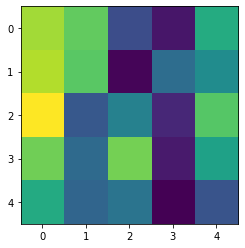

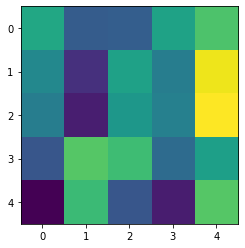

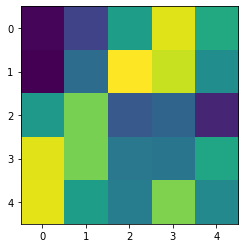

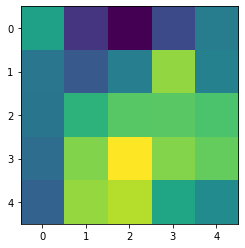

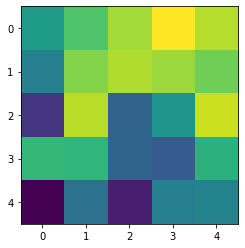

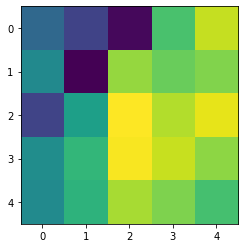

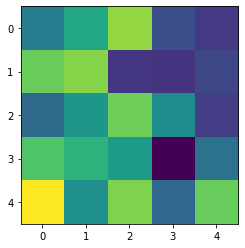

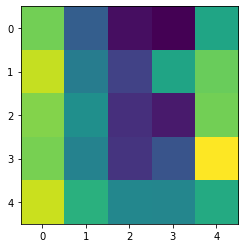

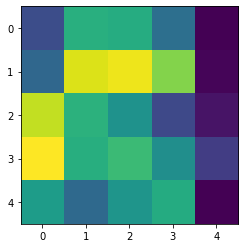

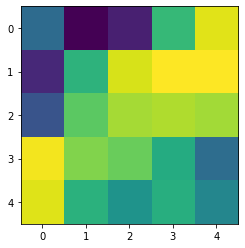

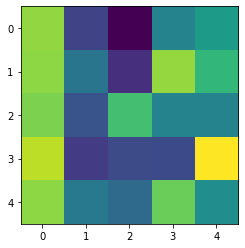

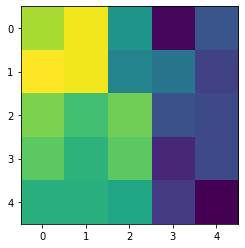

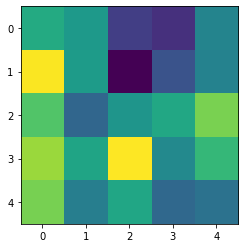

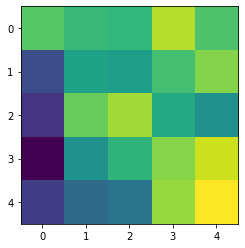

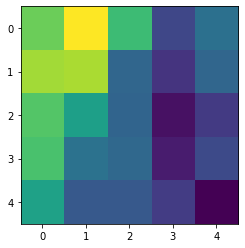

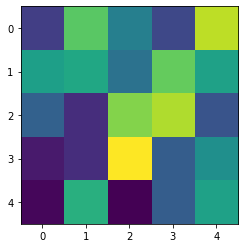

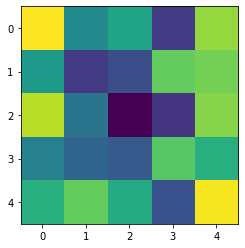

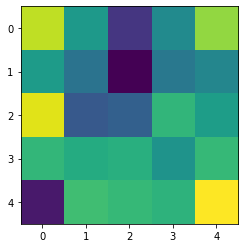

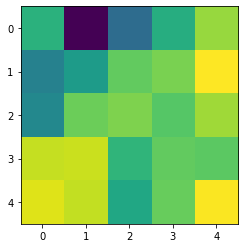

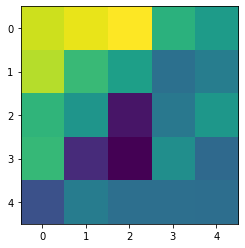

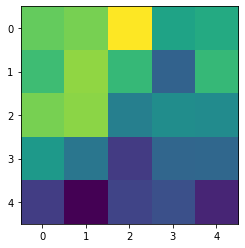

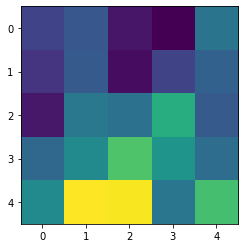

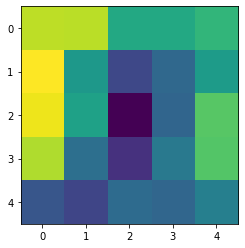

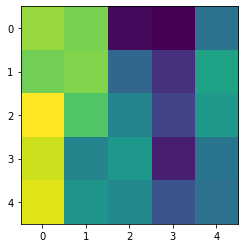

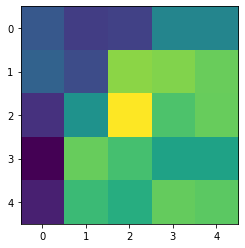

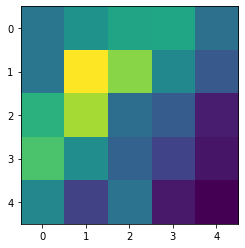

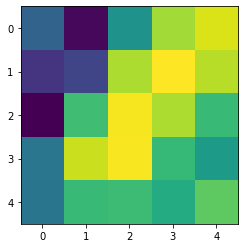

tensor([[[-2.1872e-02, -1.3839e-02,  4.6247e-03,  2.7445e-02,  2.0806e-02],
         [-1.4970e-02, -2.7924e-02, -4.6311e-03, -1.5891e-02, -1.6914e-02],
         [ 2.3198e-02, -3.0214e-02,  1.1386e-03, -7.2750e-03,  1.2151e-02],
         [-4.0569e-02, -2.9942e-02,  6.0910e-03, -8.5201e-03, -1.0732e-02],
         [-4.0037e-02, -3.7305e-02, -5.7055e-03, -4.0258e-03,  2.5555e-02]],

        [[-2.6454e-02, -7.8942e-03,  1.2967e-02, -2.2523e-03, -1.7815e-02],
         [ 5.5470e-03, -8.7121e-03, -4.0899e-02,  9.8852e-03, -2.8048e-02],
         [ 2.6408e-02,  2.0735e-02, -6.2277e-03,  1.9175e-02,  2.8798e-02],
         [ 3.7497e-03, -7.3596e-03,  6.8337e-03, -3.0667e-02, -2.9541e-02],
         [ 5.9276e-03, -2.7983e-02,  1.1315e-03,  2.5080e-02, -5.7958e-03]],

        [[-9.2983e-03,  2.3791e-02,  1.2751e-02, -1.5974e-02,  2.6254e-02],
         [-1.5472e-02, -6.3184e-03, -2.1459e-02,  1.6900e-02,  5.4222e-03],
         [ 1.0049e-02,  2.2168e-02, -1.8788e-02,  1.1408e-02, -3.6689e-02],
        

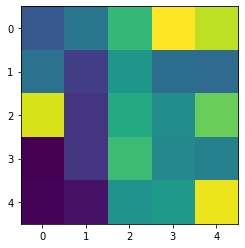

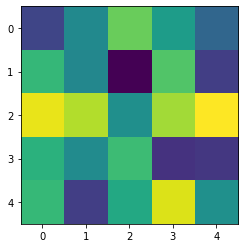

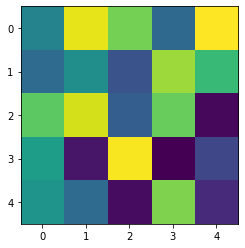

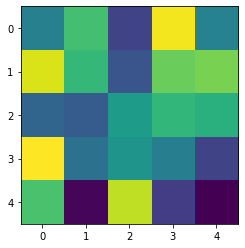

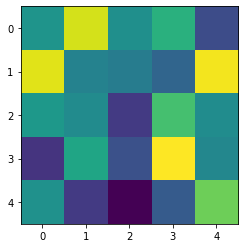

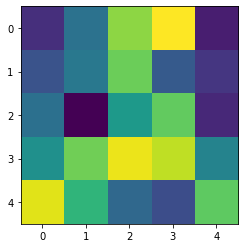

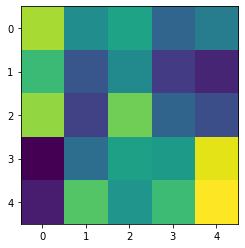

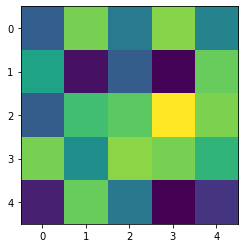

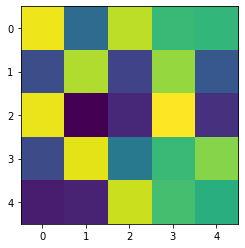

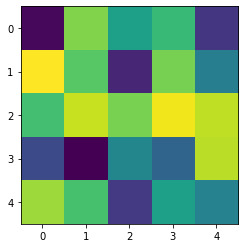

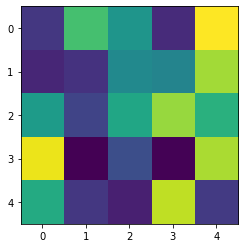

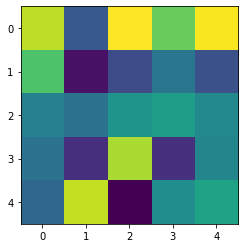

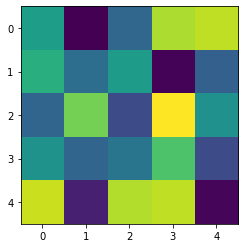

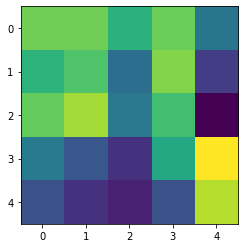

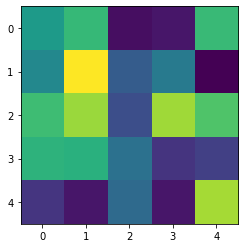

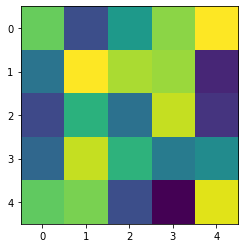

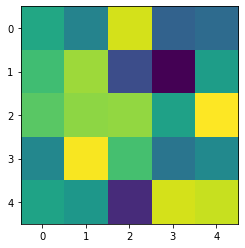

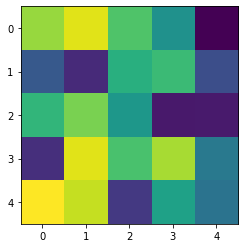

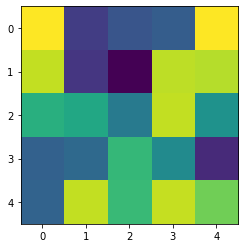

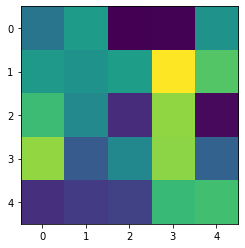

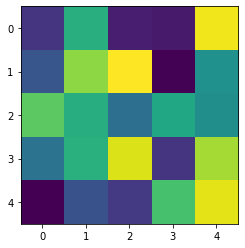

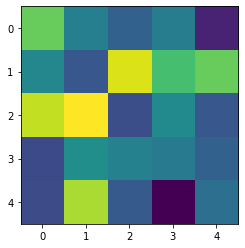

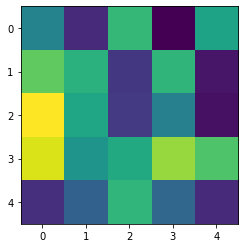

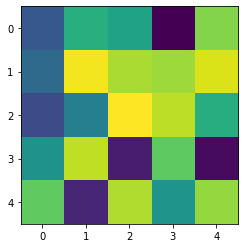

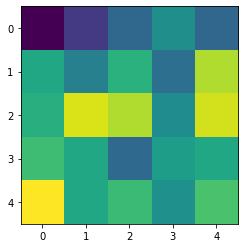

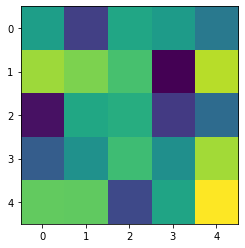

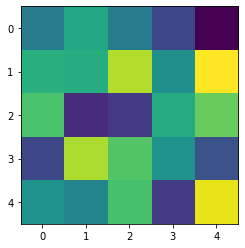

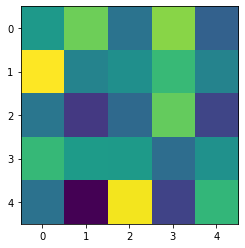

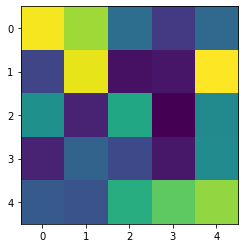

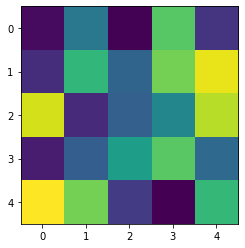

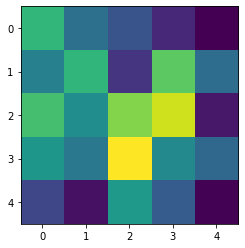

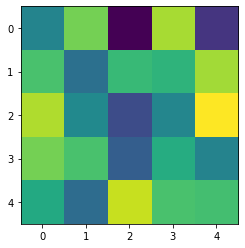

tensor([[[-0.0143, -0.0020, -0.0176, -0.0091,  0.0137],
         [-0.0402, -0.0358, -0.0156, -0.0303,  0.0245],
         [-0.0072,  0.0072,  0.0134,  0.0126, -0.0163],
         [-0.0389,  0.0025,  0.0006,  0.0140, -0.0087],
         [-0.0095, -0.0259,  0.0312,  0.0487,  0.0504]],

        [[ 0.0367,  0.0486,  0.0619,  0.0525,  0.0715],
         [ 0.0202,  0.0780,  0.0533,  0.0294,  0.0567],
         [ 0.0323,  0.0605,  0.0546,  0.0463,  0.0595],
         [ 0.0231,  0.0907,  0.0767,  0.0865,  0.0949],
         [ 0.0927,  0.0827,  0.0766,  0.0562,  0.0953]],

        [[-0.0535, -0.0732, -0.1023, -0.0065, -0.0586],
         [-0.0859, -0.0577, -0.0646, -0.0403,  0.0303],
         [-0.0625, -0.0853, -0.0104, -0.0379, -0.0189],
         [ 0.0457,  0.0300,  0.0264,  0.0881,  0.0459],
         [ 0.0340,  0.0640,  0.0260,  0.0523,  0.0462]],

        [[-0.0729, -0.0421, -0.0018, -0.0267, -0.0548],
         [-0.0743, -0.0800, -0.0273, -0.0874, -0.0520],
         [-0.1253, -0.1318, -0.0589, -0.09

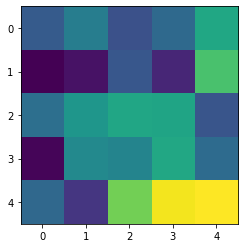

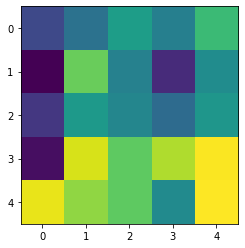

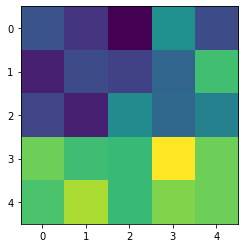

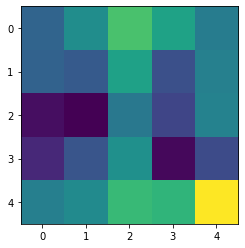

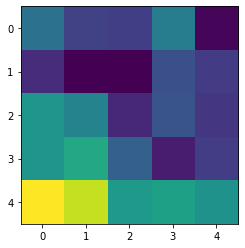

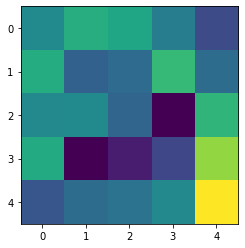

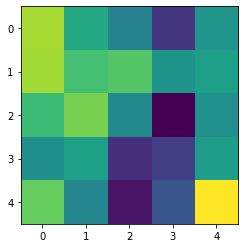

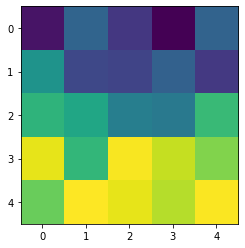

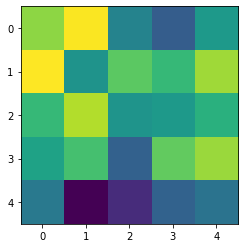

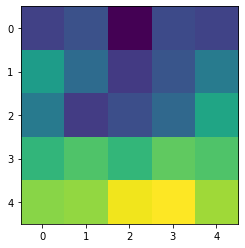

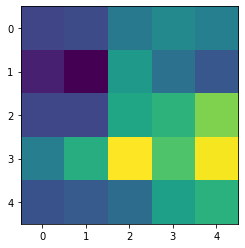

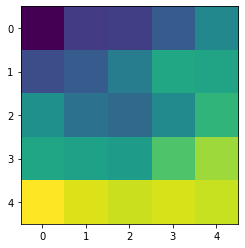

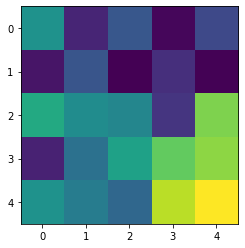

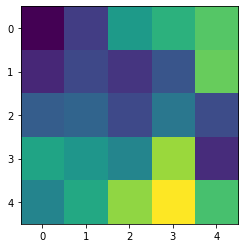

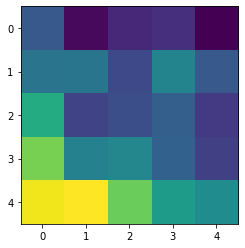

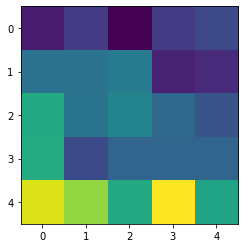

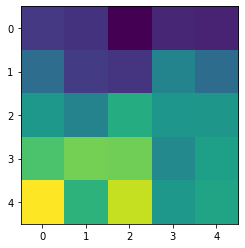

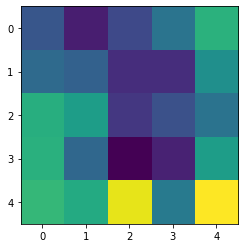

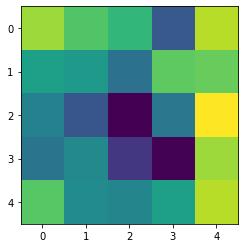

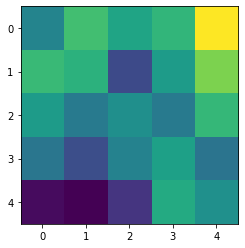

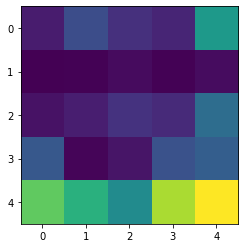

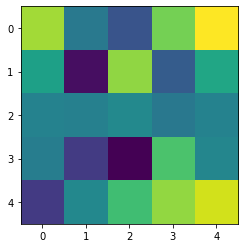

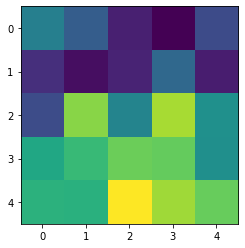

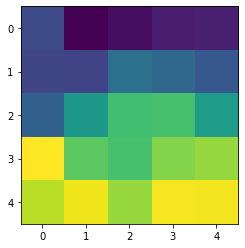

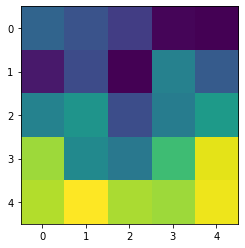

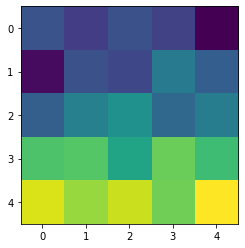

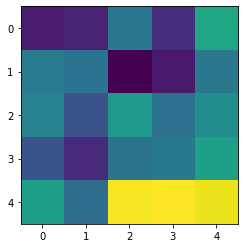

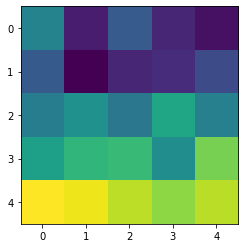

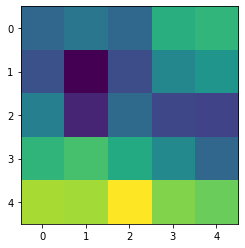

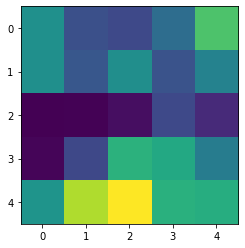

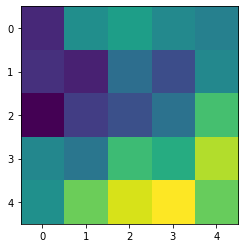

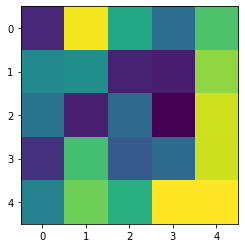

tensor([[[-2.3545e-02,  1.5748e-02,  3.2144e-04,  1.8152e-02, -3.7233e-02],
         [ 8.4901e-03, -9.2623e-02,  1.3231e-02, -9.3193e-03, -4.6514e-02],
         [-6.0540e-02,  1.7418e-02,  4.8239e-02, -1.2362e-01, -3.1501e-02],
         [-3.1681e-02,  1.4811e-02,  1.2310e-02,  2.9109e-02, -1.6267e-03],
         [-4.8986e-02, -5.5281e-02, -4.7795e-02, -4.3261e-04, -4.5837e-02]],

        [[ 2.5815e-02,  3.5772e-02, -2.0536e-02,  1.0774e-02, -5.6049e-03],
         [-1.6088e-02, -6.3902e-03,  2.0191e-02,  8.5092e-03,  2.9354e-02],
         [-7.2004e-04,  4.3949e-02,  4.6467e-02,  1.0701e-02,  2.9574e-02],
         [ 3.0652e-02, -6.3670e-03,  1.4487e-02,  1.0516e-02,  2.1786e-02],
         [ 2.6506e-02,  6.0913e-03, -1.2456e-02, -1.4072e-02,  3.7299e-02]],

        [[ 6.1952e-02, -4.2903e-02,  1.7979e-02, -3.3000e-02,  3.1642e-02],
         [ 1.3815e-01,  7.3081e-02,  1.0709e-02,  1.5974e-02,  5.3437e-02],
         [ 9.4709e-02,  6.6634e-03,  4.3266e-02,  1.1397e-01,  1.9788e-02],
        

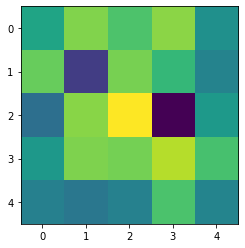

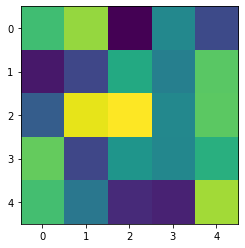

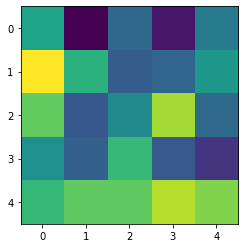

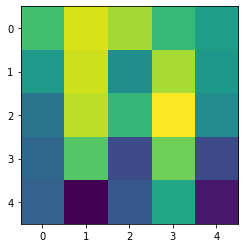

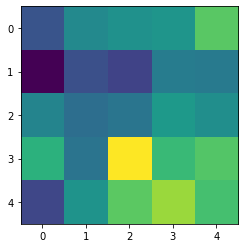

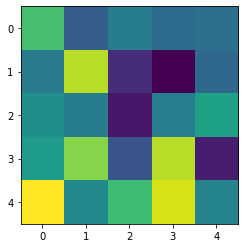

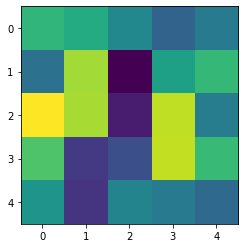

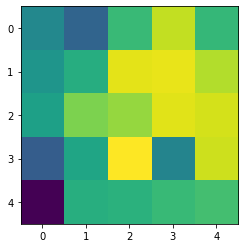

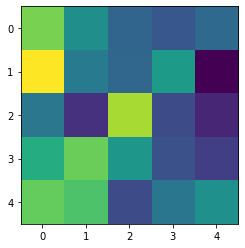

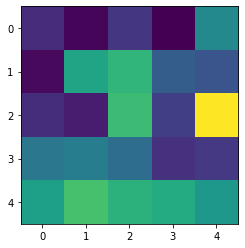

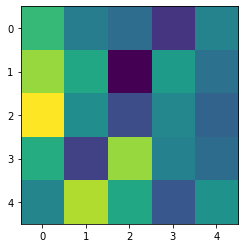

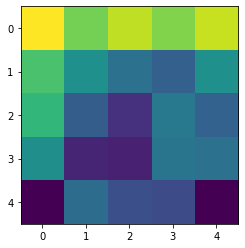

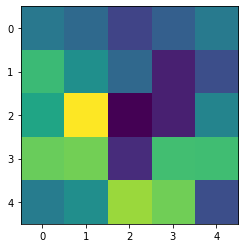

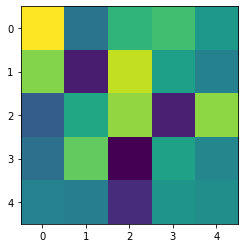

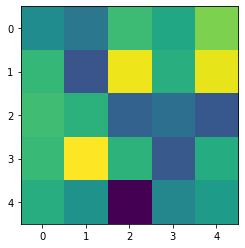

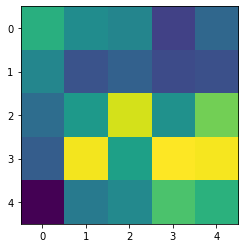

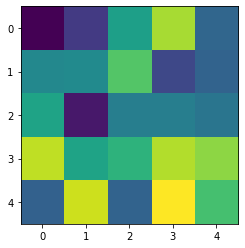

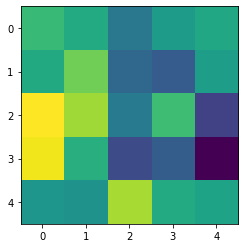

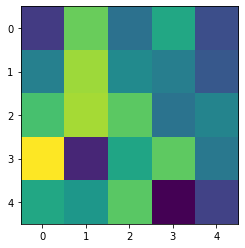

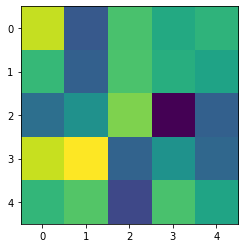

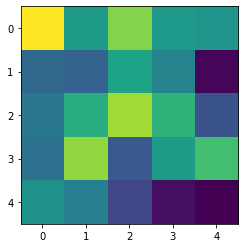

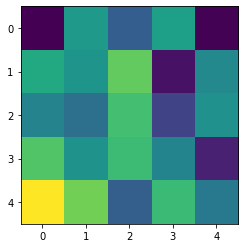

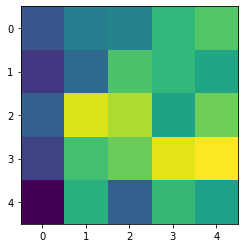

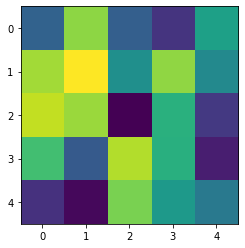

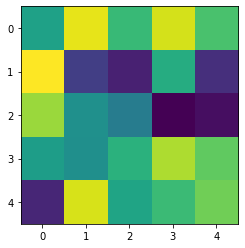

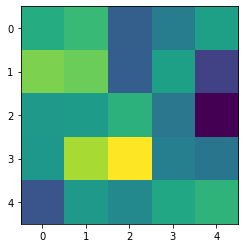

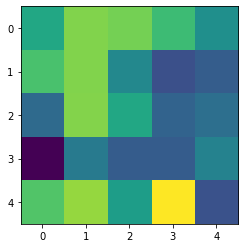

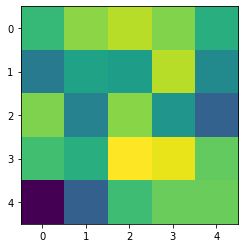

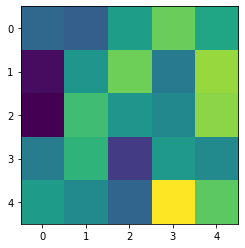

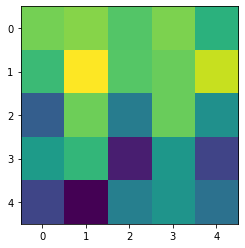

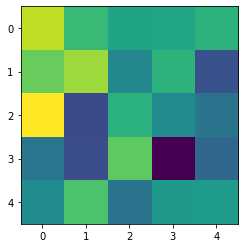

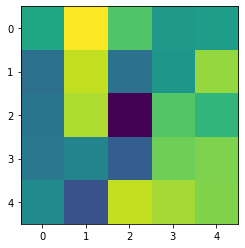

tensor([[[-1.1734e-01,  1.2852e-02, -4.7349e-02, -1.3352e-01, -3.2404e-02],
         [-1.6616e-02, -3.9612e-02, -5.4179e-02,  5.2102e-03,  4.0892e-02],
         [-2.6816e-02, -3.4360e-02,  4.2809e-02,  2.6356e-02, -1.1906e-02],
         [-1.9342e-02,  4.6441e-02,  4.1013e-02, -2.6631e-02, -9.6517e-03],
         [ 1.3233e-01,  3.2767e-03, -7.6870e-02, -4.1438e-02,  3.3947e-02]],

        [[-3.9224e-02, -1.8348e-02, -1.8722e-02, -2.4851e-02, -3.3707e-03],
         [-4.7229e-03, -2.5106e-02, -6.7371e-03,  5.1616e-02, -2.6553e-03],
         [ 2.0522e-02,  1.3910e-03,  7.5371e-04, -1.7236e-02,  2.8106e-02],
         [ 6.1114e-02,  5.4446e-02,  3.5384e-02,  1.7921e-02, -3.6045e-02],
         [ 3.0576e-02,  6.8536e-02,  3.7147e-02,  2.8776e-02, -5.4554e-03]],

        [[ 5.7327e-02,  2.2307e-02,  3.6706e-02, -1.5937e-02, -2.1174e-01],
         [-1.0302e-01,  3.2829e-02,  3.2468e-02, -7.0194e-02, -6.7800e-02],
         [-5.7846e-02,  9.3869e-04, -2.0125e-02,  1.5031e-02,  9.5610e-02],
        

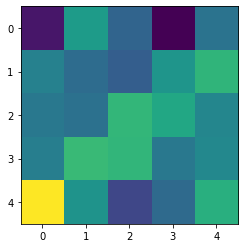

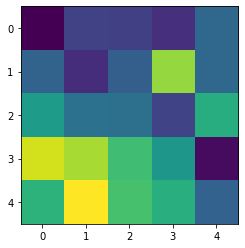

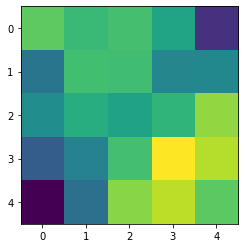

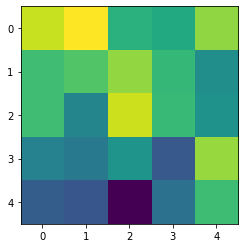

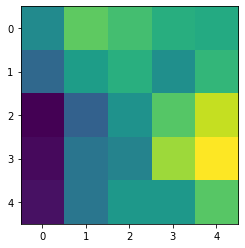

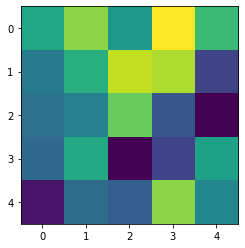

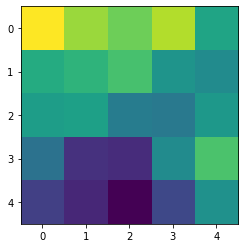

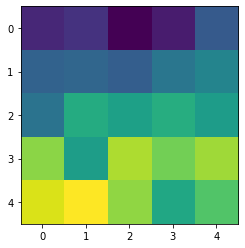

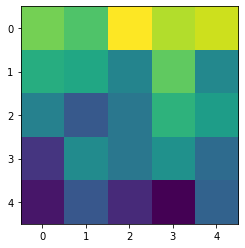

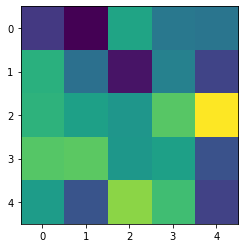

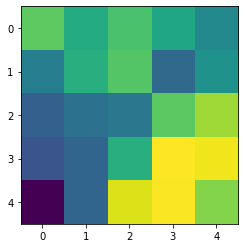

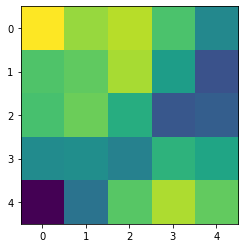

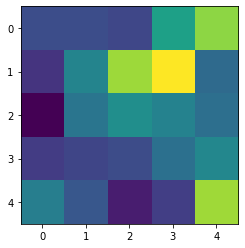

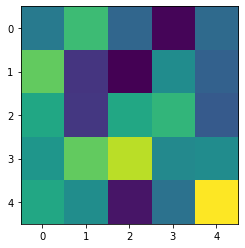

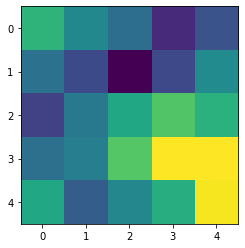

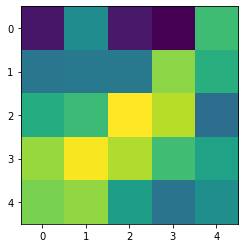

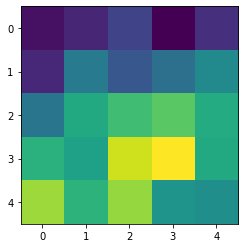

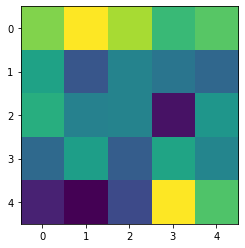

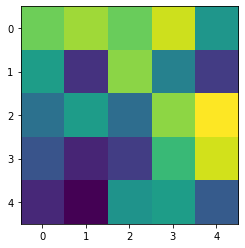

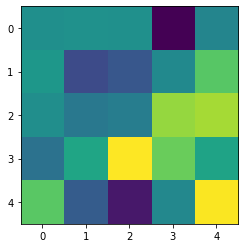

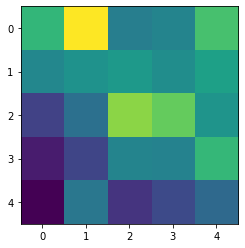

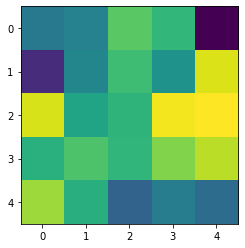

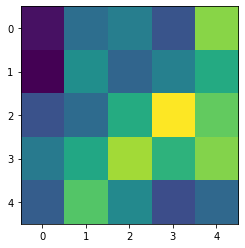

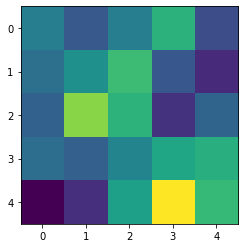

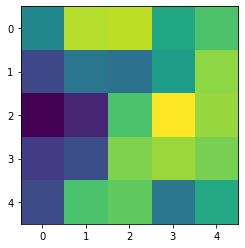

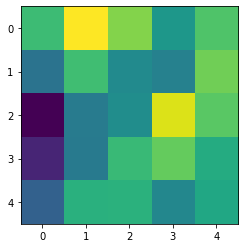

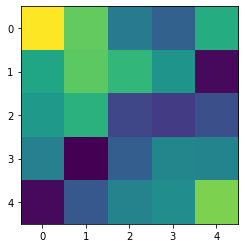

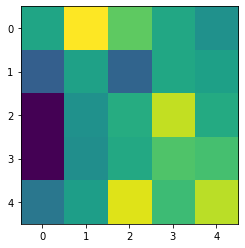

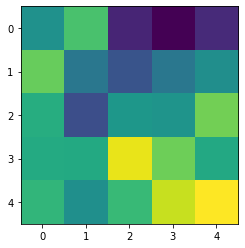

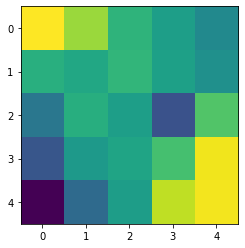

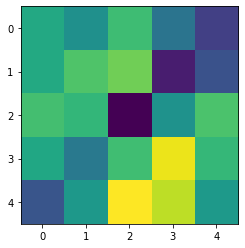

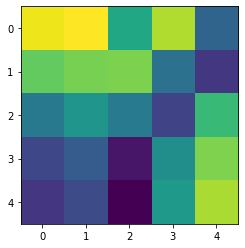

tensor([[[ 4.1834e-02,  3.5769e-02,  6.8217e-02,  4.2490e-02, -3.1864e-02],
         [-3.6297e-02, -2.2256e-02, -4.0358e-02, -4.7658e-02, -9.1309e-03],
         [-1.2900e-01, -4.4038e-02, -1.1872e-02, -6.7997e-02, -4.2724e-02],
         [-7.9213e-02, -8.2090e-02, -4.6832e-02, -6.7625e-02, -1.2587e-02],
         [ 2.6335e-02,  2.3716e-02, -2.9487e-02, -2.7924e-02, -4.8680e-03]],

        [[ 6.3514e-02,  7.9458e-02,  6.5287e-03,  2.4044e-02,  5.3848e-02],
         [ 6.7537e-02,  7.0266e-02,  5.9732e-03, -7.9852e-03,  5.0174e-03],
         [ 7.1329e-02,  2.9985e-03,  1.5408e-02,  1.0879e-02,  3.9376e-03],
         [ 1.4744e-02,  6.9333e-02,  2.2346e-02,  1.0322e-02,  3.5860e-02],
         [ 3.6870e-02,  3.8079e-02,  2.5307e-02,  3.5489e-02,  2.0098e-02]],

        [[-3.9466e-02,  1.0291e-01,  7.5595e-02,  8.9403e-02, -1.4912e-02],
         [-1.0550e-01,  1.7008e-02,  9.7293e-02,  7.4123e-02,  1.0522e-02],
         [-1.3195e-01, -1.4479e-01, -6.3253e-02,  2.7972e-02, -1.0777e-02],
        

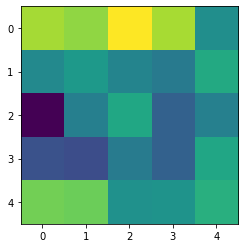

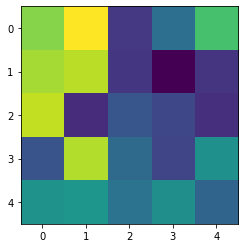

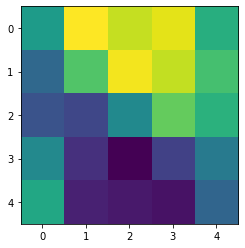

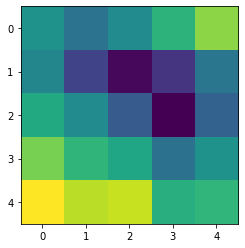

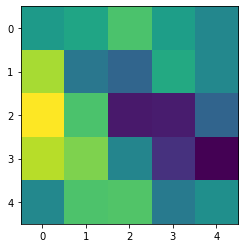

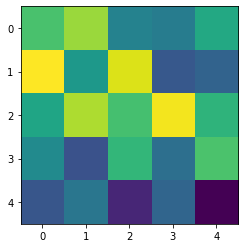

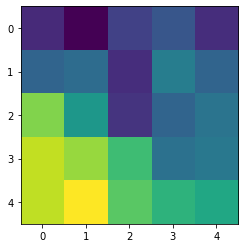

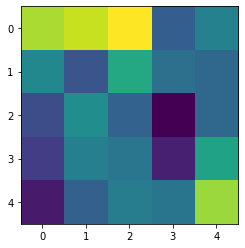

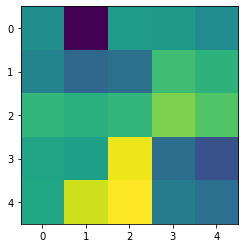

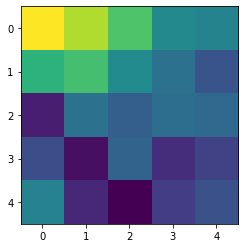

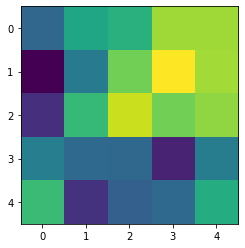

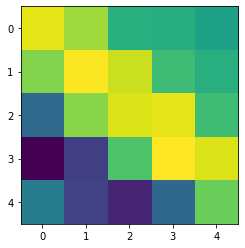

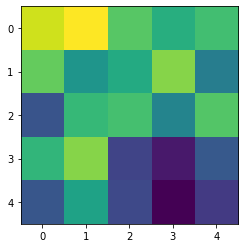

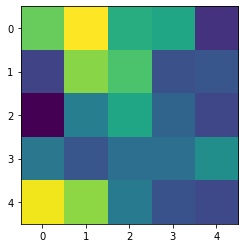

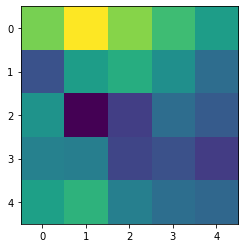

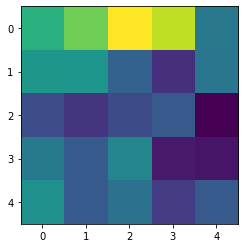

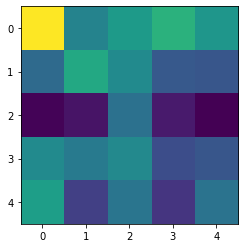

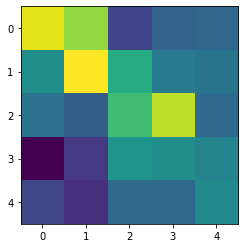

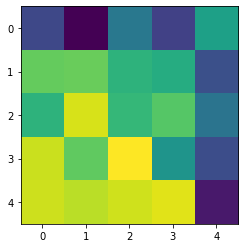

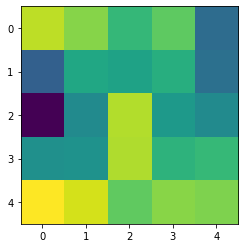

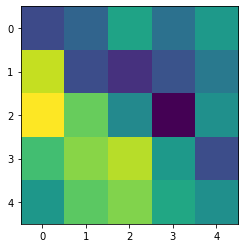

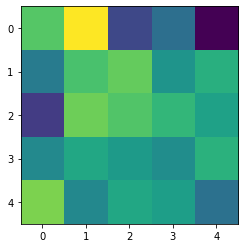

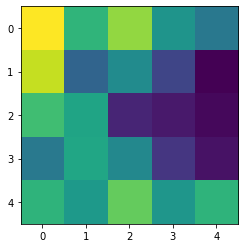

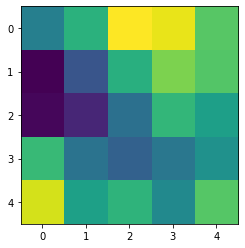

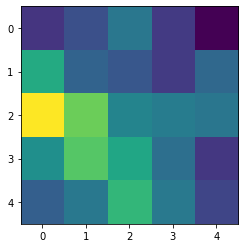

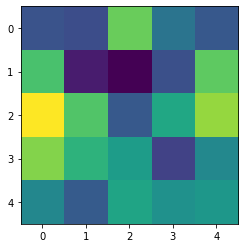

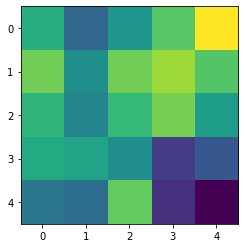

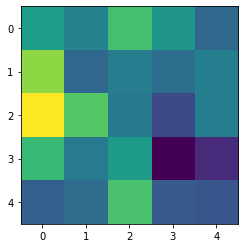

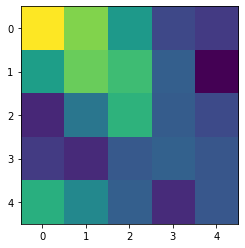

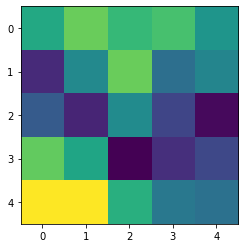

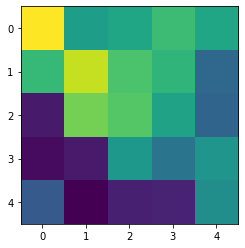

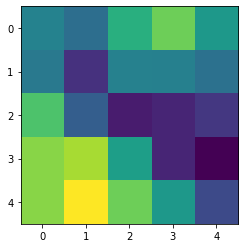

tensor([[[ 9.7389e-03, -3.6573e-02, -4.3987e-03,  2.2144e-02,  2.5400e-02],
         [-5.1013e-03,  4.3224e-03,  3.0417e-02,  4.1992e-02, -1.8710e-02],
         [ 1.7994e-02, -3.1115e-02,  9.1837e-03,  3.1108e-02, -5.4731e-02],
         [-5.0063e-02,  5.5637e-02,  1.3098e-02, -1.6837e-02,  3.8936e-04],
         [ 1.0211e-02,  6.5490e-02,  4.5332e-02, -7.9500e-04,  2.4080e-02]],

        [[ 4.1861e-02,  2.3500e-02,  4.4130e-02,  5.5273e-02, -9.4342e-03],
         [ 2.1012e-02,  6.4643e-02,  6.2688e-02,  5.0955e-02,  3.8391e-03],
         [ 5.8535e-02,  8.0667e-02,  2.4636e-02,  3.1971e-02,  2.5967e-02],
         [ 7.6340e-02,  4.0368e-02,  2.8617e-02,  3.5735e-02, -8.7042e-03],
         [ 7.6089e-02,  6.9817e-02,  7.1256e-02,  2.5457e-02,  6.2914e-02]],

        [[-1.0564e-01, -8.3657e-02, -1.6880e-01, -1.1194e-01, -1.2619e-01],
         [-5.8772e-02, -5.2171e-02, -1.3305e-01, -7.6510e-02, -6.0313e-02],
         [-7.0686e-02, -5.7991e-02, -5.2648e-02, -8.1534e-02, -1.1035e-02],
        

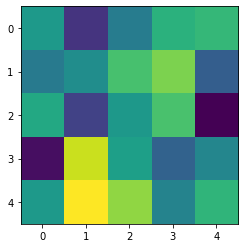

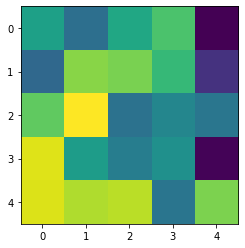

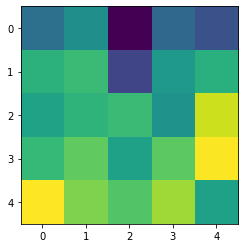

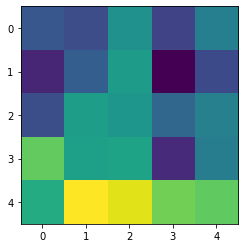

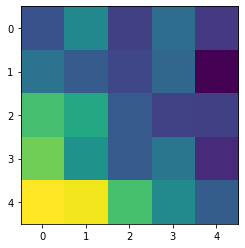

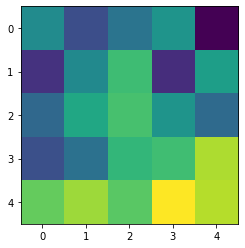

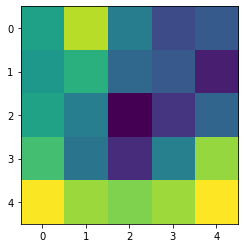

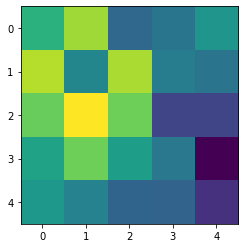

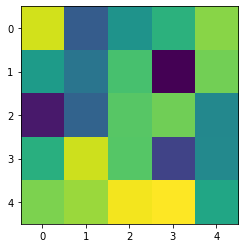

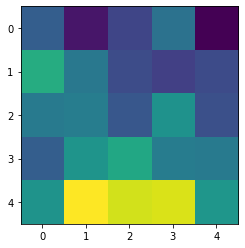

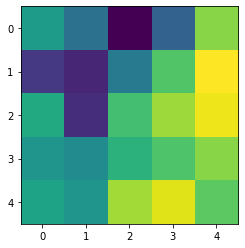

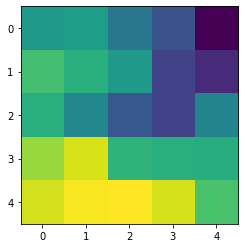

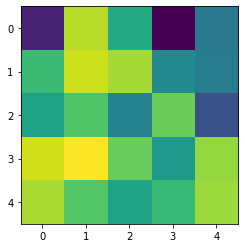

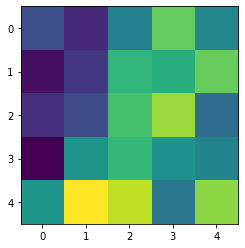

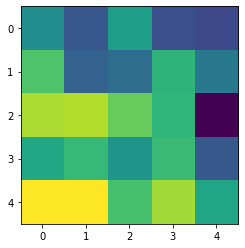

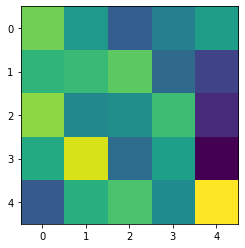

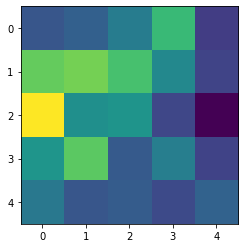

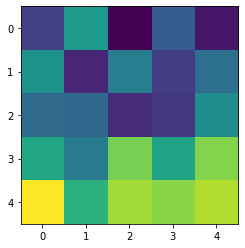

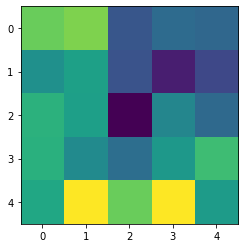

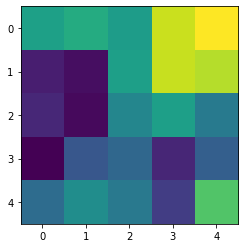

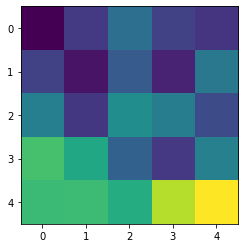

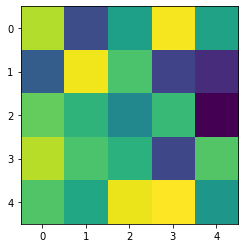

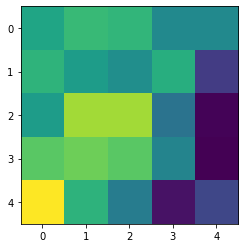

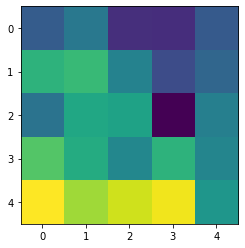

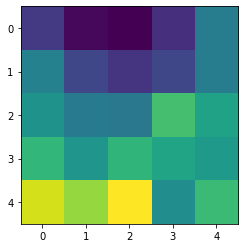

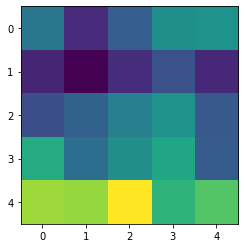

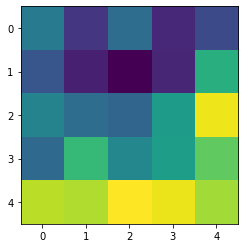

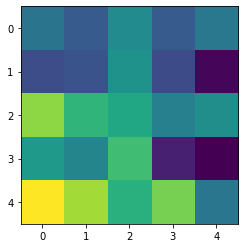

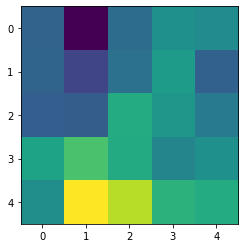

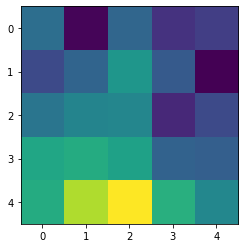

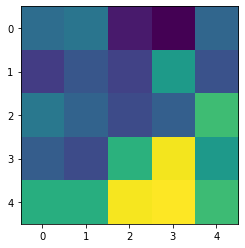

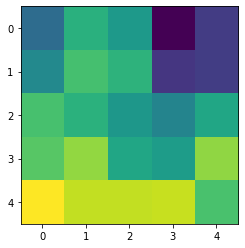

tensor([[[ 7.2744e-02,  6.3992e-02,  6.9350e-02,  4.7823e-02,  3.0050e-02],
         [ 8.7080e-02,  3.2766e-02,  2.9638e-02,  6.7028e-02,  5.2854e-02],
         [ 1.2781e-01,  7.4396e-02,  2.1190e-02, -3.2850e-02, -1.0908e-02],
         [ 1.9772e-02,  5.2687e-02,  6.8862e-03, -3.0240e-02, -2.5866e-02],
         [ 7.7368e-02,  1.8102e-03,  3.6939e-02,  1.5128e-02,  8.7178e-03]],

        [[ 6.3377e-02,  3.8012e-02,  9.3425e-03,  1.2141e-03, -2.5377e-02],
         [ 4.5230e-02,  7.3181e-02, -1.0486e-02, -1.6384e-03, -2.5972e-02],
         [ 7.7011e-02,  1.2928e-02,  5.9339e-03, -3.9476e-02, -6.5951e-02],
         [ 3.5255e-02,  5.0551e-02,  3.2139e-02, -1.3526e-02, -4.2206e-02],
         [ 3.5088e-02,  3.3575e-02,  2.3478e-02,  3.2539e-02,  1.7637e-02]],

        [[-2.5278e-02,  1.4075e-02, -4.1126e-02, -6.6419e-02, -5.5917e-02],
         [-3.8679e-02, -3.5874e-02, -3.8156e-02, -1.9890e-02, -3.7233e-02],
         [-2.1867e-02, -7.3406e-03, -5.3701e-02, -8.9499e-02, -4.9810e-02],
        

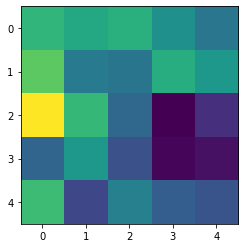

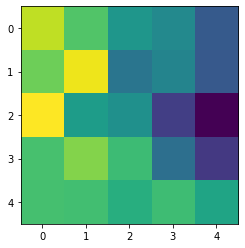

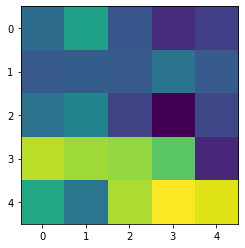

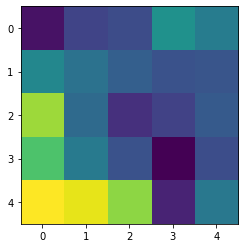

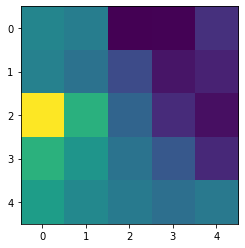

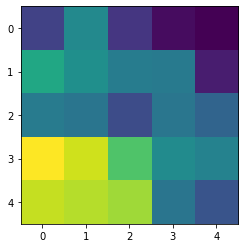

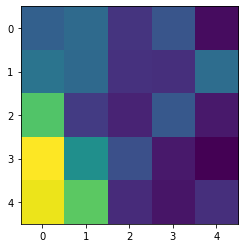

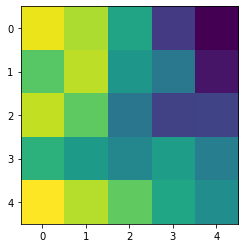

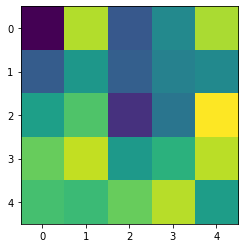

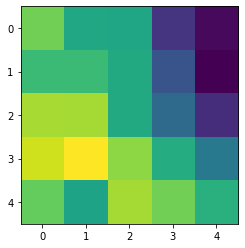

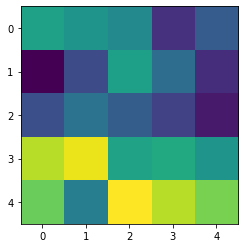

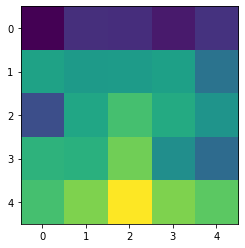

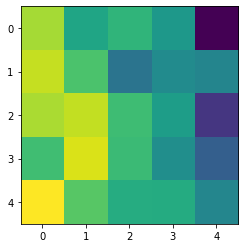

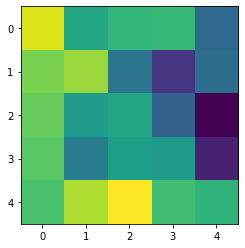

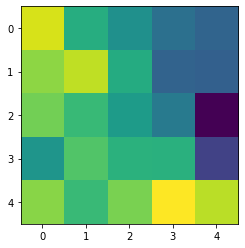

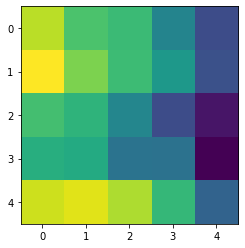

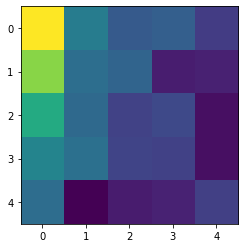

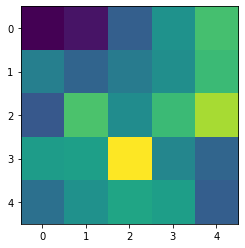

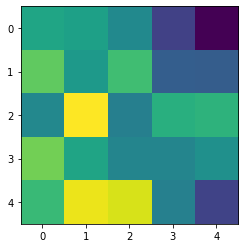

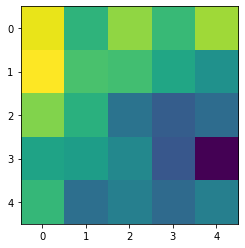

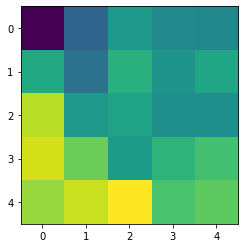

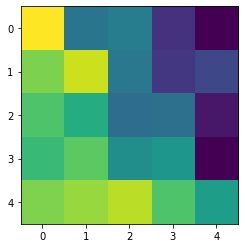

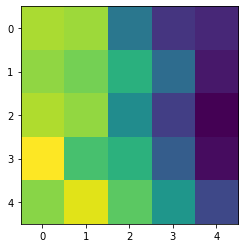

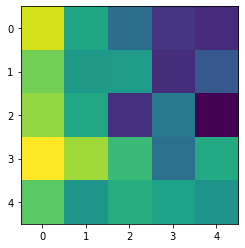

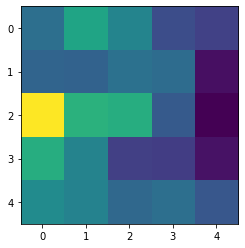

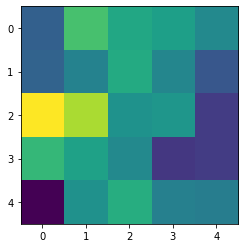

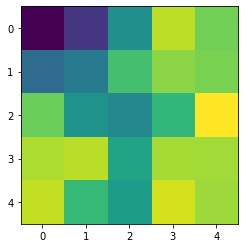

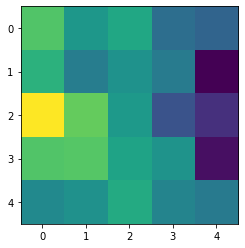

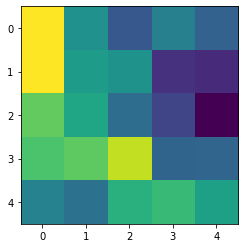

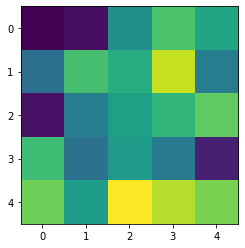

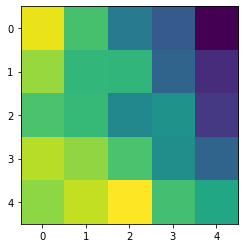

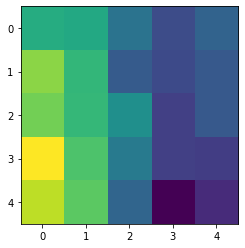

tensor([[[ 5.2385e-03, -3.8748e-02,  1.4434e-03, -2.5065e-02, -3.9081e-02],
         [-2.7363e-02,  1.4402e-02,  2.0988e-02, -5.0100e-02,  1.8463e-02],
         [-2.9546e-02, -4.0125e-02, -6.8495e-03, -1.6715e-02,  2.0266e-02],
         [-4.7537e-02, -3.8035e-02, -2.2736e-02,  3.3321e-02, -1.7212e-02],
         [ 3.6092e-02, -9.4989e-04,  4.5107e-02,  4.5525e-02, -4.1235e-03]],

        [[ 4.6624e-02,  3.3838e-02, -2.2840e-03,  3.1341e-02,  3.6792e-03],
         [-4.1879e-03,  1.8793e-02,  4.8004e-02,  1.6797e-02,  7.6744e-02],
         [ 1.6415e-02,  1.5434e-02,  6.2919e-02,  3.8297e-02,  7.3306e-03],
         [ 5.4039e-02,  3.7071e-02,  2.6982e-02,  6.3219e-02,  5.0427e-02],
         [ 9.8865e-03,  3.0264e-02,  8.8174e-03,  3.0074e-02,  5.4158e-02]],

        [[-2.9545e-02, -6.3212e-02, -1.8221e-02, -7.9858e-03, -2.4640e-02],
         [-6.2009e-03,  2.1872e-02,  1.1737e-02, -2.6920e-02, -2.0865e-02],
         [-5.8915e-03, -3.3150e-02, -7.6456e-02, -2.1530e-02, -4.4595e-03],
        

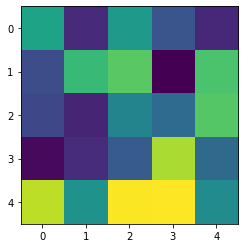

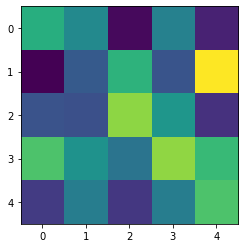

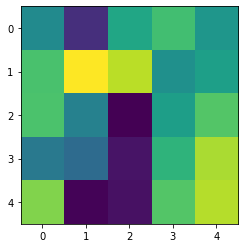

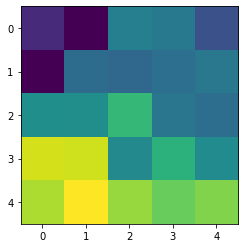

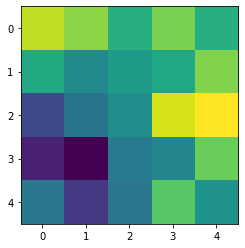

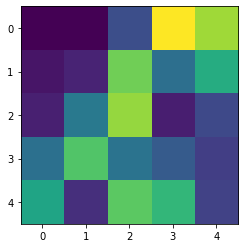

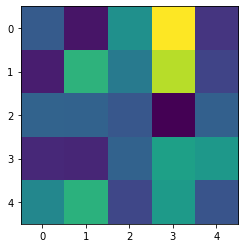

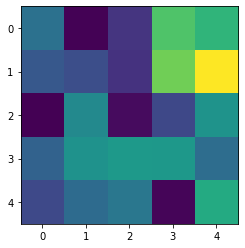

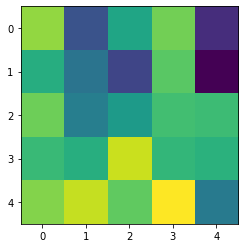

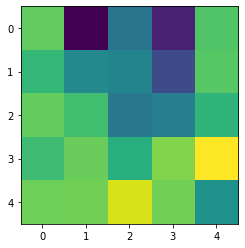

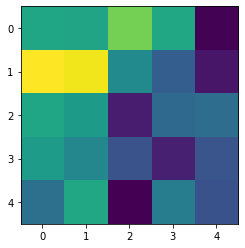

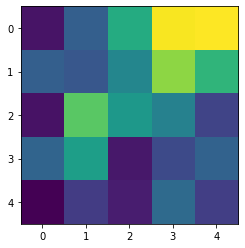

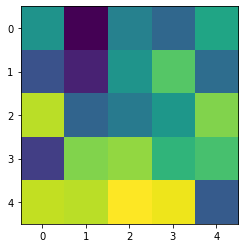

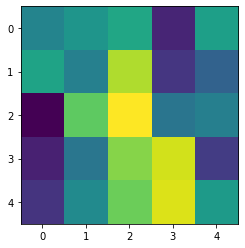

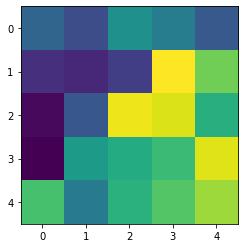

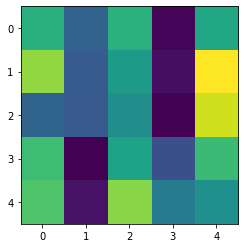

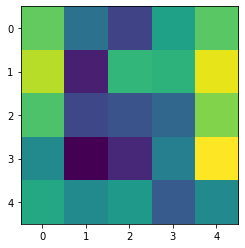

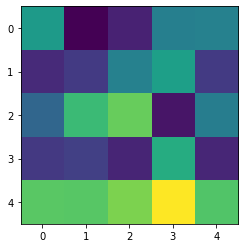

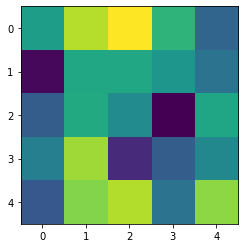

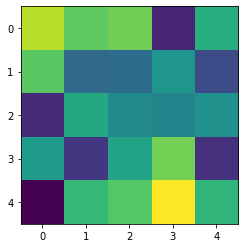

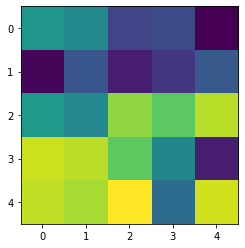

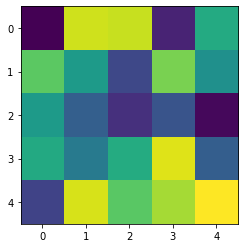

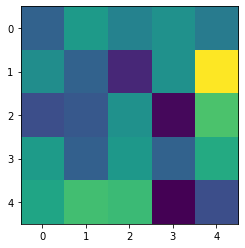

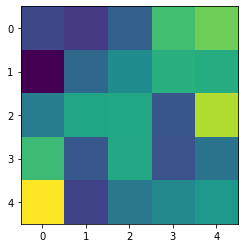

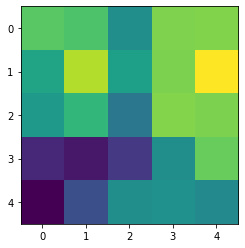

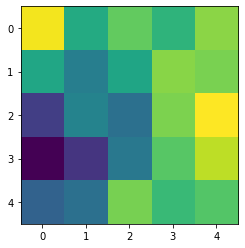

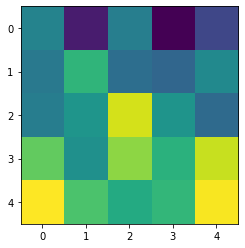

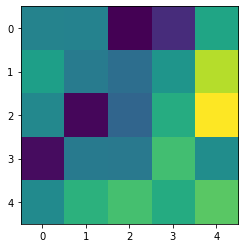

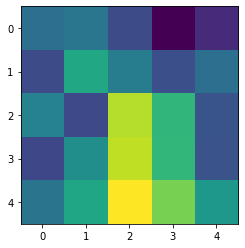

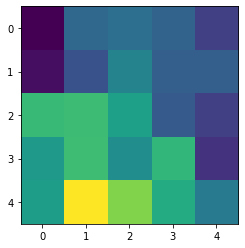

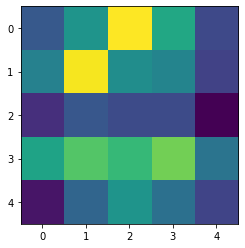

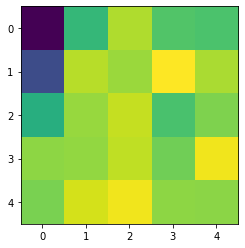

tensor([[[ 5.0036e-02, -8.7497e-03, -3.4095e-02, -6.8771e-02, -5.8179e-02],
         [ 7.7992e-02,  6.7014e-02, -3.3080e-02, -8.5104e-03, -1.4876e-02],
         [ 5.1633e-02,  1.2673e-02,  1.8926e-02, -9.7560e-04, -7.1861e-03],
         [ 7.9883e-02,  7.7743e-02,  2.8027e-04,  1.8131e-02,  1.0804e-02],
         [ 2.2489e-02,  7.7710e-02,  9.3317e-03,  4.4210e-02,  3.9337e-02]],

        [[ 2.4961e-02,  4.9414e-02, -2.9517e-03,  5.5994e-02,  4.4259e-02],
         [ 3.9463e-02,  2.6304e-02,  8.3311e-03,  5.1928e-02,  4.3407e-03],
         [ 7.8099e-02,  6.3373e-02,  6.6042e-02,  1.1170e-02,  7.7829e-03],
         [ 8.1462e-02,  5.9642e-02,  4.2802e-02,  6.1697e-02,  7.2655e-02],
         [ 6.3542e-02,  5.5907e-02,  5.1550e-02,  7.5993e-02,  4.9594e-02]],

        [[ 6.0795e-02,  1.1685e-02,  1.7536e-02, -2.4153e-02,  2.0752e-02],
         [ 3.0875e-02,  9.5053e-03, -1.2076e-02, -3.3272e-03, -9.8917e-03],
         [ 4.7447e-02,  5.3625e-02,  7.7724e-02,  4.6242e-03,  3.3471e-03],
        

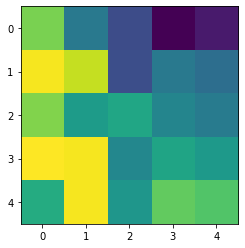

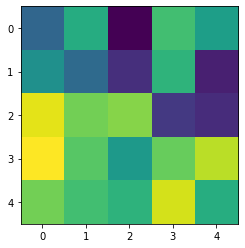

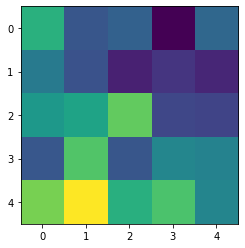

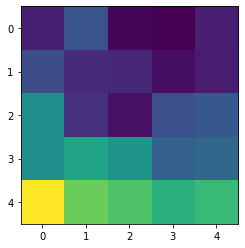

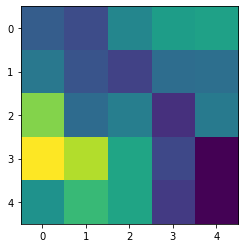

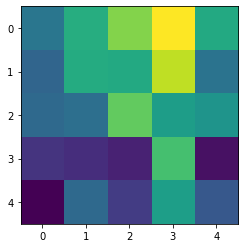

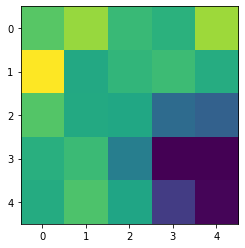

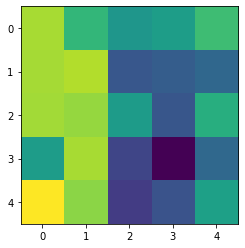

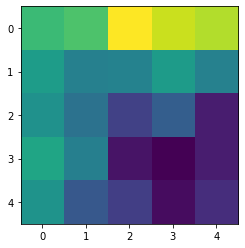

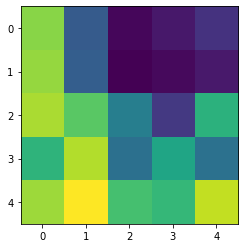

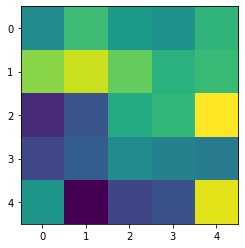

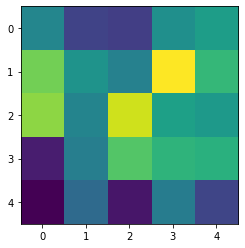

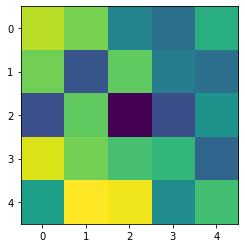

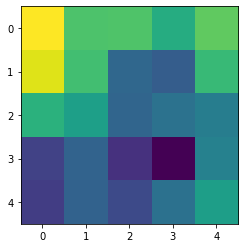

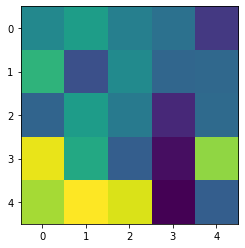

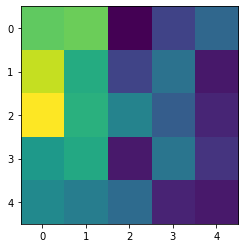

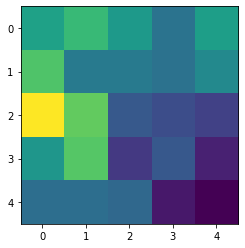

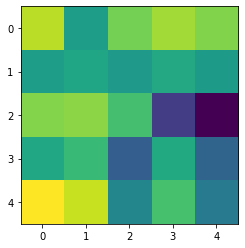

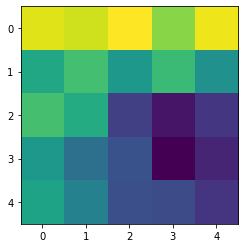

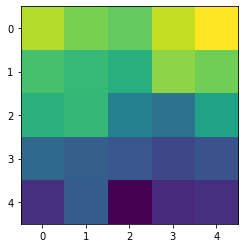

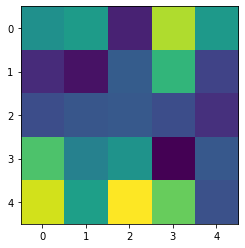

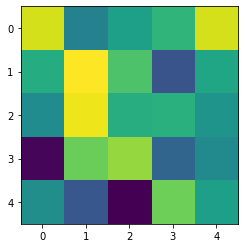

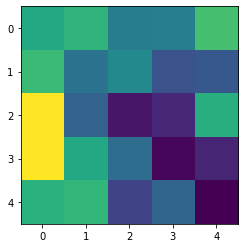

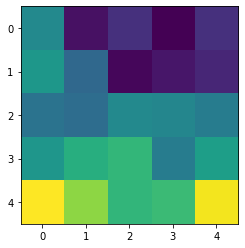

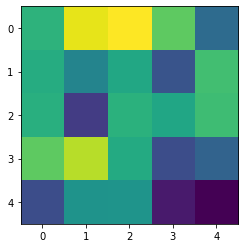

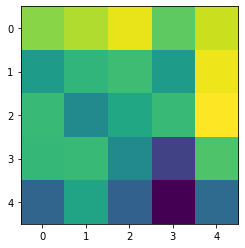

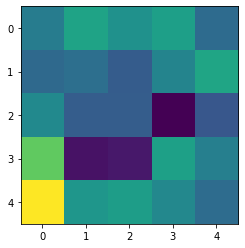

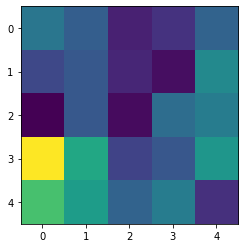

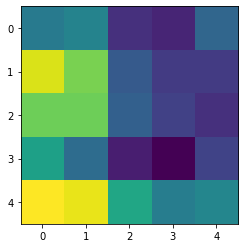

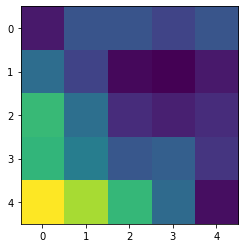

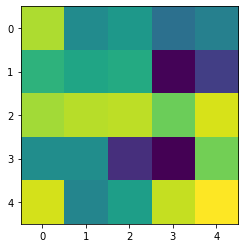

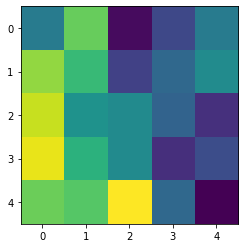

tensor([[[ 6.6564e-03, -9.2516e-03,  1.6467e-02, -2.3338e-02, -3.6764e-02],
         [ 2.8696e-02, -8.5704e-03,  2.9080e-02, -4.1769e-02,  3.4375e-02],
         [ 6.2103e-03, -2.4898e-03,  2.6448e-02, -3.7272e-02,  5.7856e-02],
         [-1.5222e-01, -1.4628e-01, -9.9934e-02, -9.4906e-02, -8.8159e-03],
         [-1.2609e-01, -1.0019e-01, -7.1528e-02, -3.1152e-02,  1.4185e-02]],

        [[ 2.5099e-02, -1.7567e-02, -1.3526e-02,  2.3563e-03,  2.6648e-02],
         [ 1.4342e-02,  3.5292e-02,  5.0761e-03,  2.5806e-02, -2.5599e-02],
         [-1.6470e-02,  2.1287e-02, -3.4124e-02,  9.6221e-03, -2.4491e-02],
         [-4.8998e-02,  5.0945e-03,  8.3707e-03,  1.6417e-02,  1.6816e-02],
         [-2.0240e-02,  2.9709e-03, -4.6358e-02, -3.0380e-02, -4.6530e-02]],

        [[ 3.7567e-02,  7.0453e-02,  8.3432e-02,  3.4817e-02,  5.8961e-02],
         [-1.7510e-02, -8.3184e-03,  9.1558e-03, -1.4667e-02, -1.1760e-02],
         [ 2.6335e-02, -4.1240e-03,  2.1040e-02, -1.8655e-02, -7.0474e-03],
        

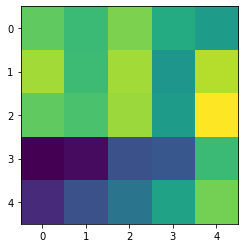

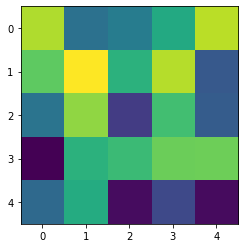

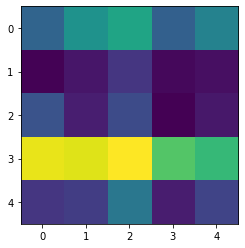

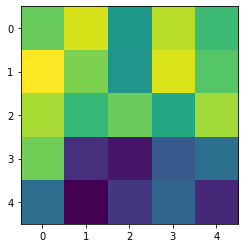

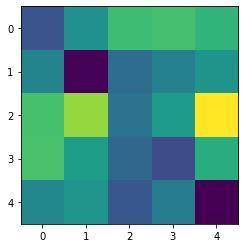

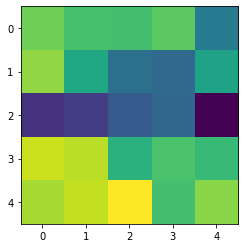

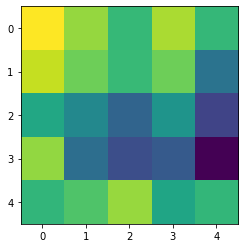

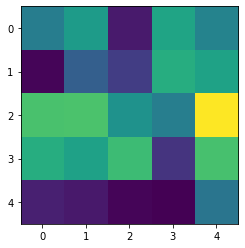

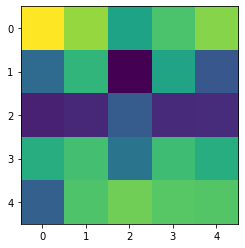

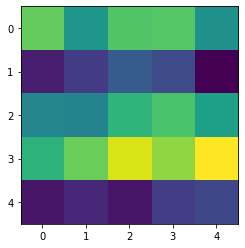

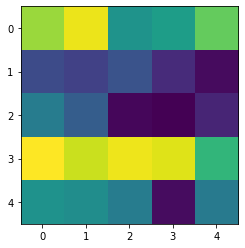

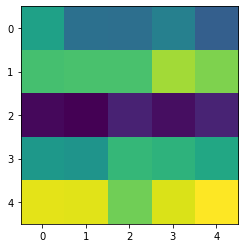

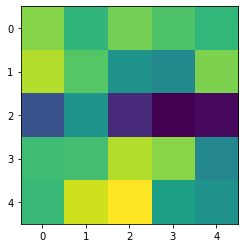

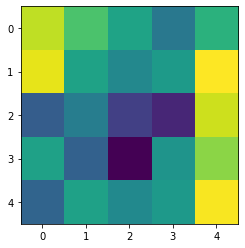

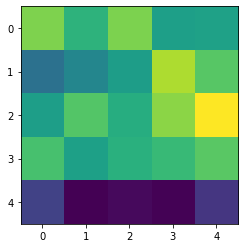

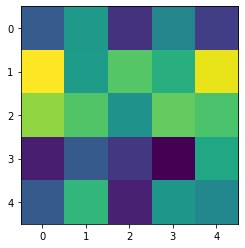

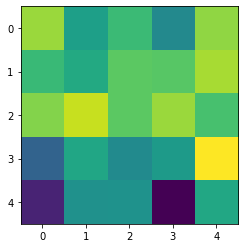

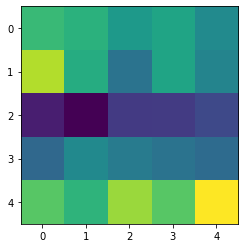

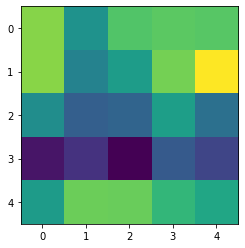

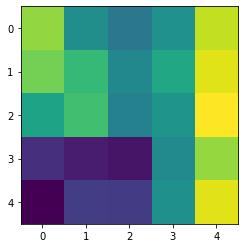

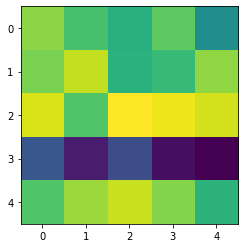

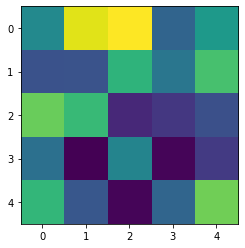

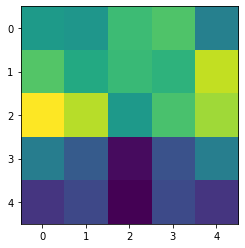

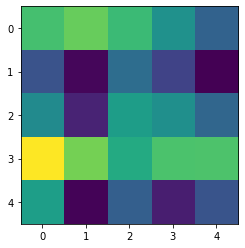

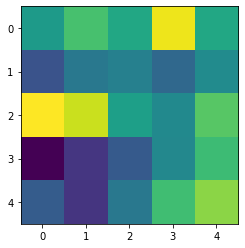

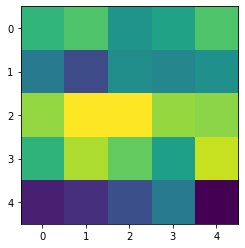

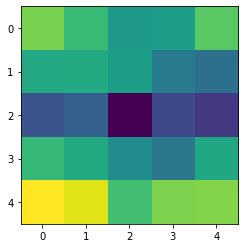

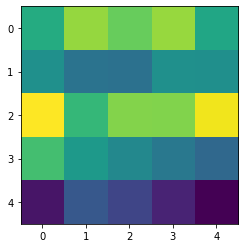

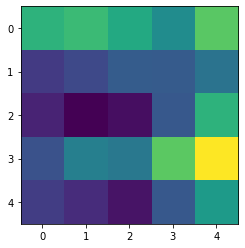

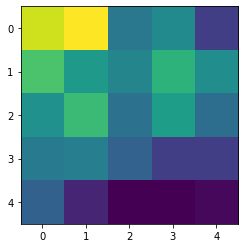

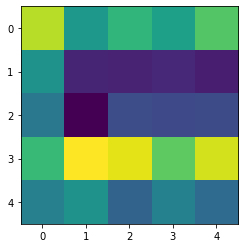

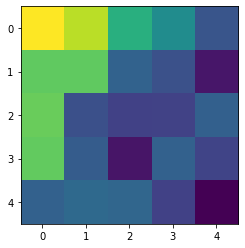

tensor([[[ 5.8892e-02,  2.5612e-02, -9.9343e-03,  1.5133e-02,  5.2332e-02],
         [-7.6021e-03, -1.1408e-02, -2.1693e-02, -1.1442e-02,  3.0342e-02],
         [-3.7611e-02,  1.3052e-02,  4.7297e-02, -1.2006e-03,  6.5243e-02],
         [-4.3754e-02,  2.6526e-02,  3.7983e-02, -4.3094e-03, -9.3794e-03],
         [-2.7482e-02,  8.1253e-02, -1.7052e-02,  1.0084e-02,  8.4252e-02]],

        [[-4.9645e-04,  3.1994e-02,  4.2480e-02,  5.1523e-02,  6.4415e-02],
         [-2.0177e-02, -2.2686e-02,  2.3175e-02,  3.4382e-02,  1.9037e-02],
         [ 1.7291e-02, -1.1255e-02,  2.9089e-02, -1.5262e-02,  4.1611e-02],
         [-3.7337e-03, -4.8256e-02,  3.5898e-03,  9.5819e-03,  1.7361e-02],
         [-5.5874e-02, -5.5521e-02, -5.8608e-02, -2.8211e-02, -2.2007e-02]],

        [[-3.9689e-02, -2.6021e-02, -7.0566e-02, -4.9042e-02, -4.8627e-02],
         [-1.2321e-02,  6.0101e-03, -3.1190e-02,  3.1676e-02,  2.2477e-02],
         [ 5.2451e-02,  3.3868e-02,  3.0601e-02,  5.9471e-02,  9.2208e-02],
        

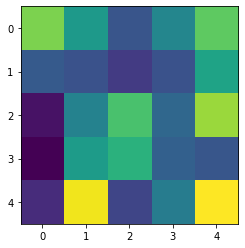

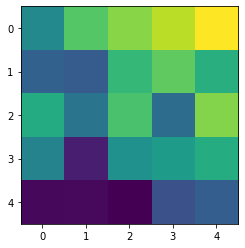

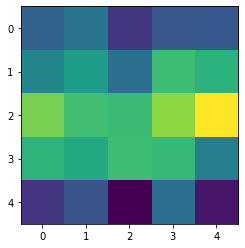

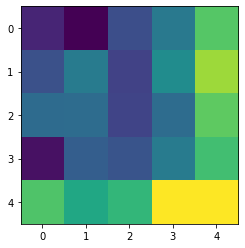

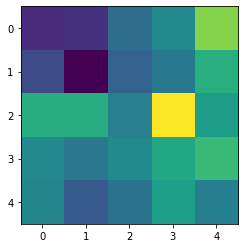

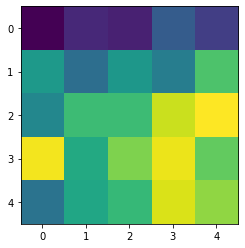

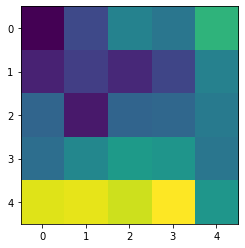

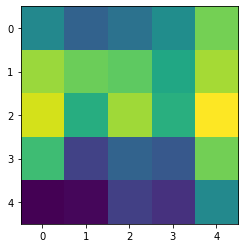

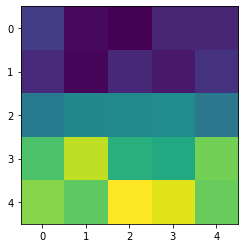

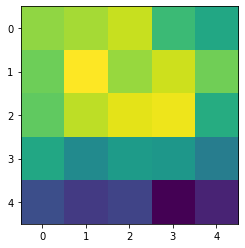

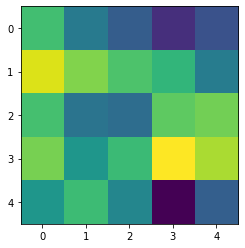

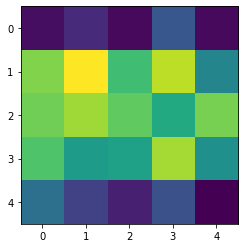

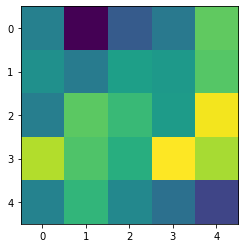

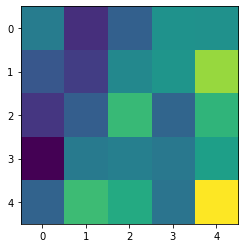

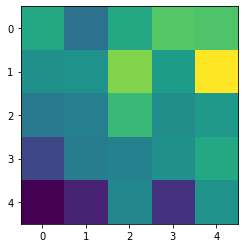

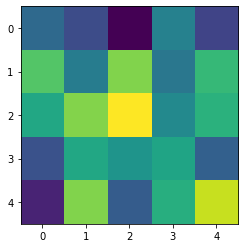

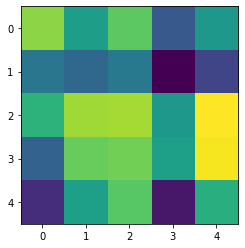

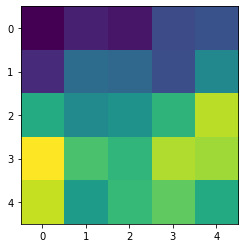

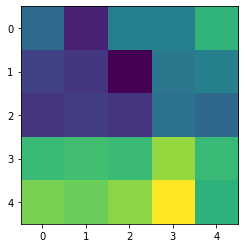

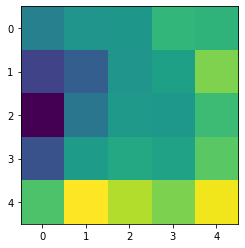

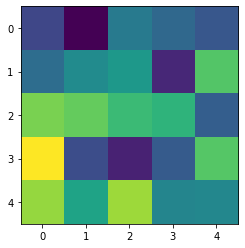

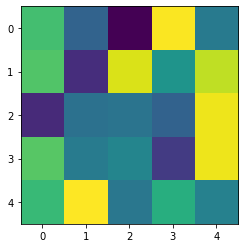

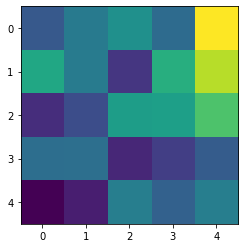

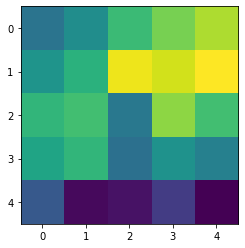

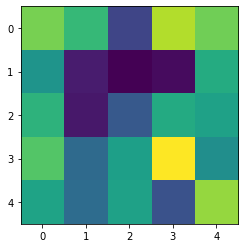

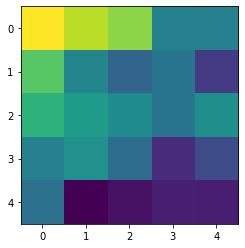

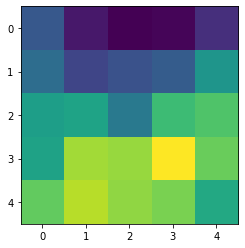

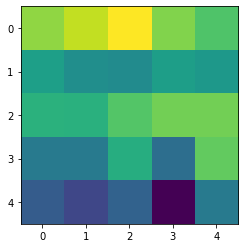

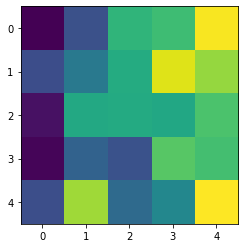

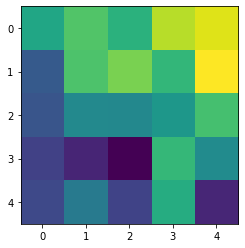

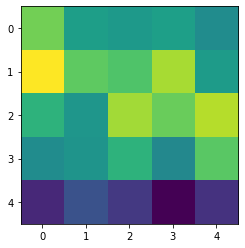

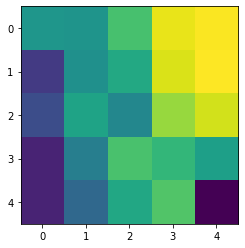

tensor([[[ 1.2293e-01,  6.3767e-02,  5.1791e-02,  3.1424e-02,  6.6616e-02],
         [ 1.4324e-03,  3.4255e-02,  8.6305e-02,  8.5970e-02,  7.8322e-02],
         [-6.5774e-03,  9.7226e-02,  9.4422e-02,  5.3298e-02,  7.2315e-02],
         [ 4.1887e-02,  1.0202e-01,  1.6190e-02,  1.1703e-02,  5.3293e-02],
         [ 3.1808e-02, -3.8680e-02, -2.5970e-02,  7.9485e-02,  4.2401e-02]],

        [[ 5.9092e-02,  2.8602e-02,  4.6936e-02,  1.8348e-02,  1.0600e-02],
         [ 4.6144e-03,  1.6461e-03,  1.8649e-03, -8.5890e-03, -2.1866e-02],
         [ 7.5211e-03, -5.0396e-03, -1.0622e-02, -1.7682e-02, -6.5947e-02],
         [-3.9605e-02, -2.2408e-02, -8.5976e-02, -7.4196e-02, -2.2961e-02],
         [-3.4881e-02, -9.2407e-02, -2.9949e-02, -4.9202e-02,  1.4999e-02]],

        [[ 8.0658e-02,  2.6484e-02, -1.2527e-02, -2.8503e-02,  5.3166e-02],
         [ 4.1020e-02,  2.5381e-02, -1.9463e-02,  5.0714e-02,  1.4193e-01],
         [ 4.7225e-02, -3.1415e-02,  3.7896e-02,  8.4944e-02,  1.5125e-01],
        

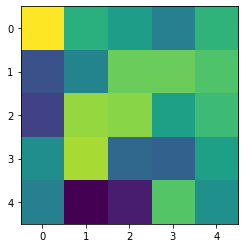

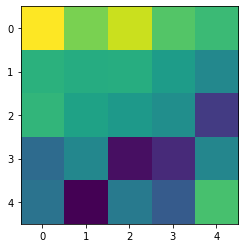

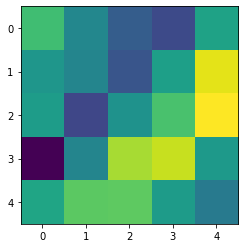

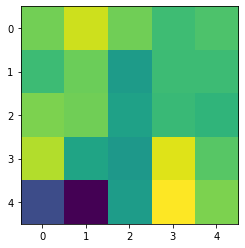

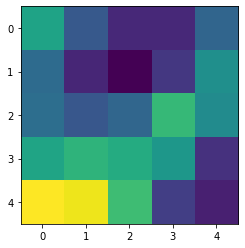

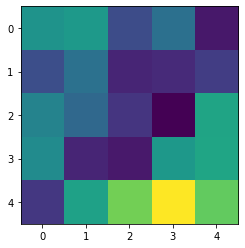

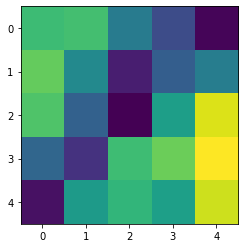

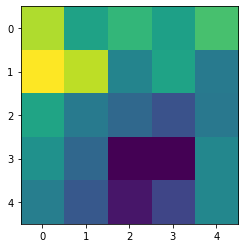

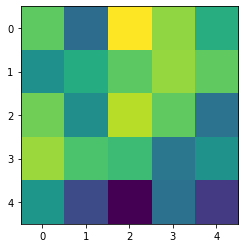

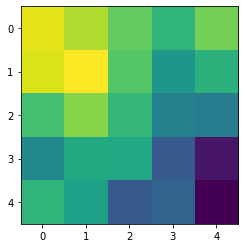

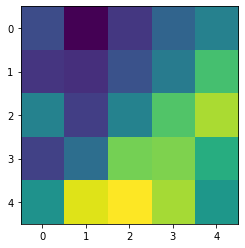

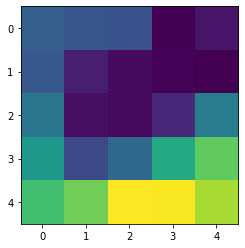

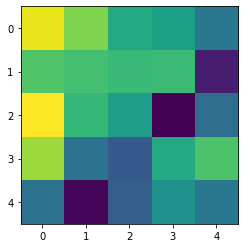

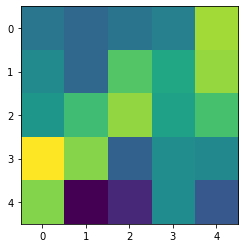

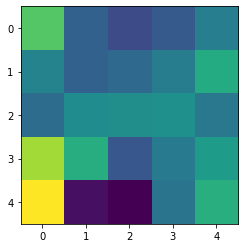

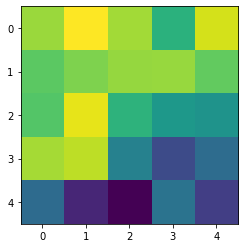

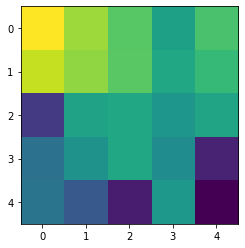

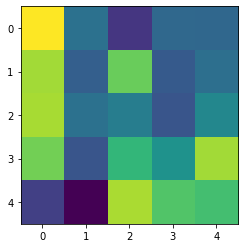

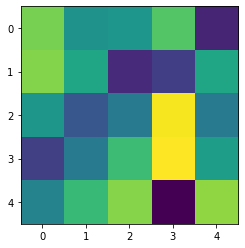

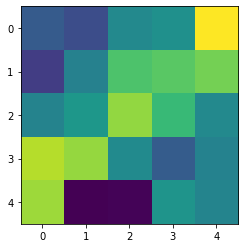

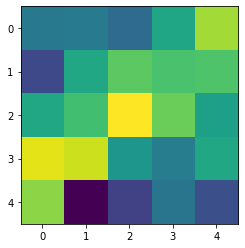

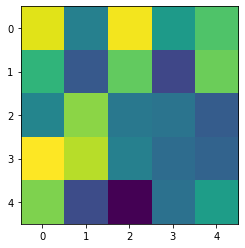

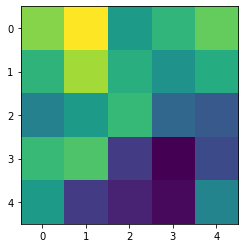

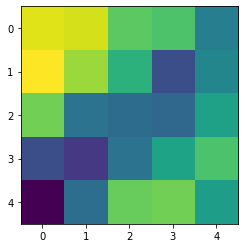

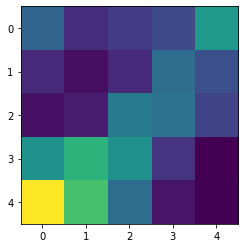

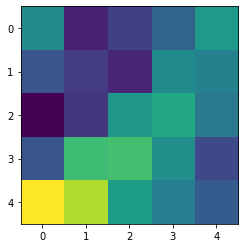

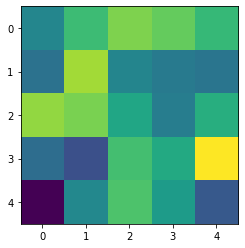

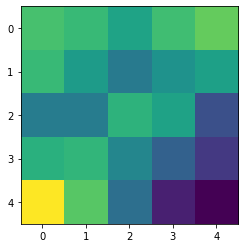

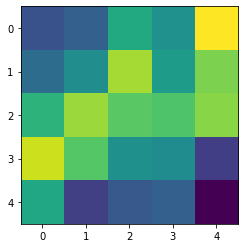

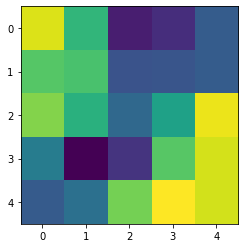

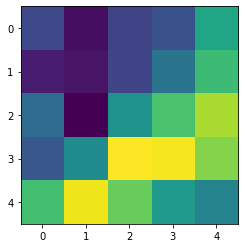

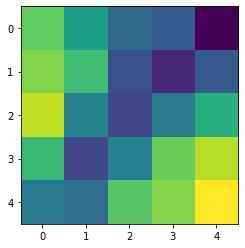

tensor([[[-3.4811e-03, -1.4842e-02, -1.2195e-02,  1.6717e-02, -4.3454e-02],
         [-2.9868e-02, -4.4608e-02, -6.0901e-03,  1.5541e-02, -3.2941e-03],
         [ 9.3571e-03, -4.8372e-02,  1.7679e-02, -7.2314e-03, -4.8558e-03],
         [-8.2799e-03, -4.8380e-02,  2.6665e-03, -3.9810e-02, -1.0683e-02],
         [-4.3920e-02, -1.3677e-02, -3.2652e-02, -4.5110e-02, -3.6333e-02]],

        [[ 1.0366e-02, -6.3643e-03,  1.9363e-02,  8.8160e-03, -3.8600e-02],
         [-4.6711e-02, -9.4028e-03, -3.1376e-02,  5.9488e-03, -3.1065e-03],
         [-1.0222e-02, -2.2303e-02, -1.1690e-03,  3.1170e-03,  1.3069e-04],
         [-2.3641e-02, -3.0927e-02, -1.6789e-02,  8.2133e-03, -4.9139e-02],
         [-3.8424e-02,  9.1312e-03, -2.2905e-02,  8.4193e-03,  1.7078e-02]],

        [[ 1.0897e-02,  1.1057e-02, -9.4661e-03, -6.0602e-03, -2.1139e-02],
         [ 1.6663e-02, -1.2591e-02,  7.5112e-03, -1.9651e-03,  2.5042e-02],
         [ 1.4603e-02, -1.8588e-02, -1.0936e-02, -3.1625e-02,  3.2488e-03],
        

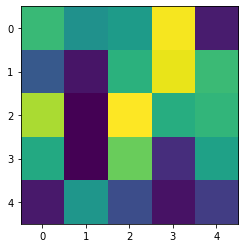

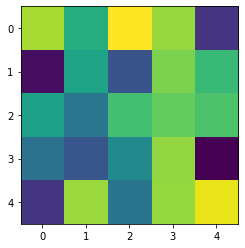

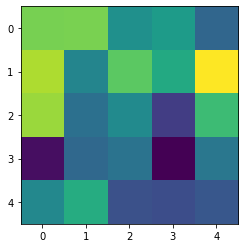

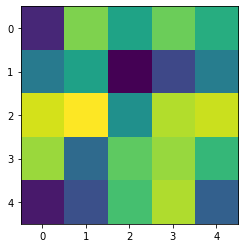

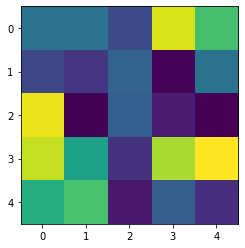

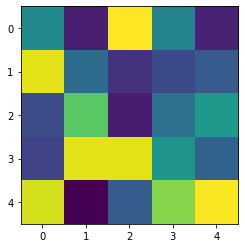

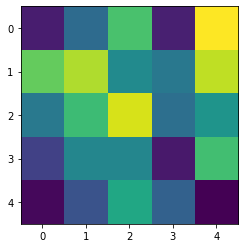

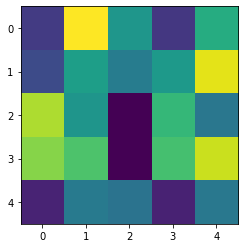

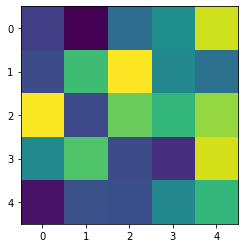

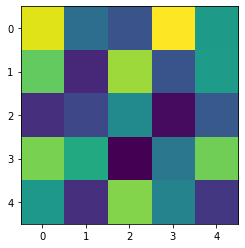

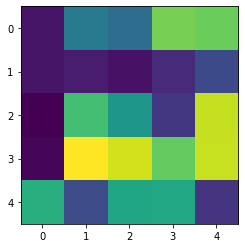

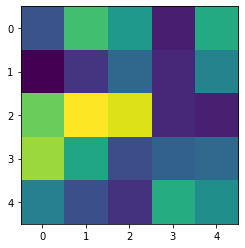

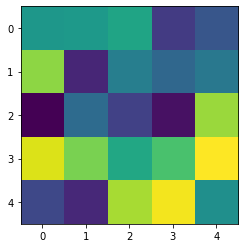

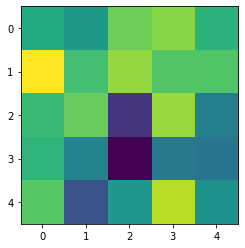

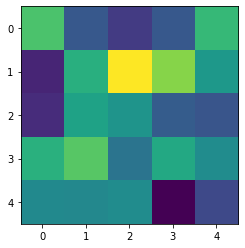

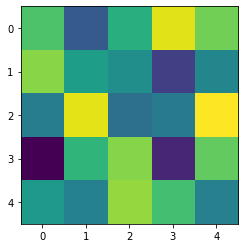

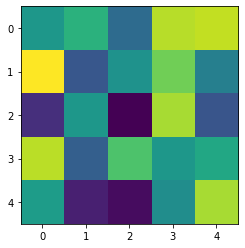

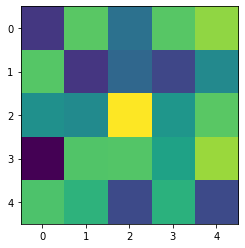

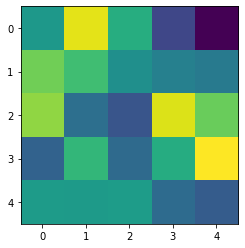

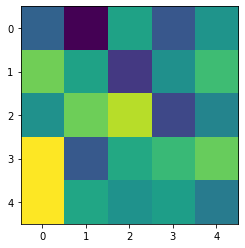

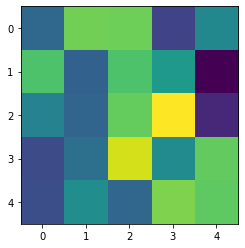

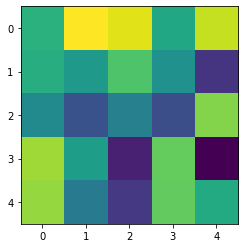

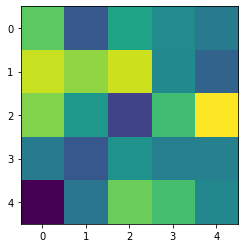

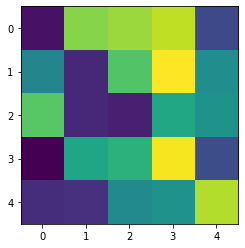

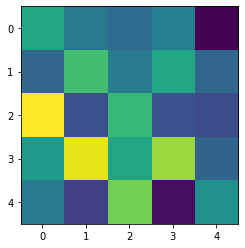

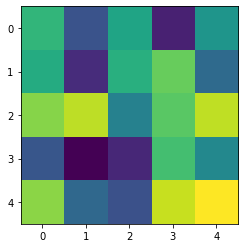

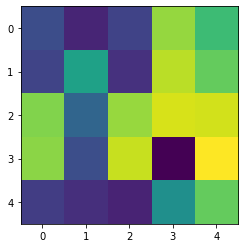

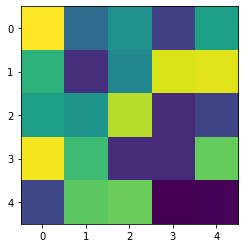

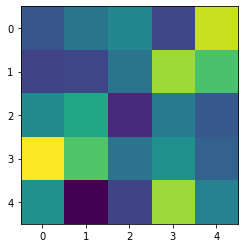

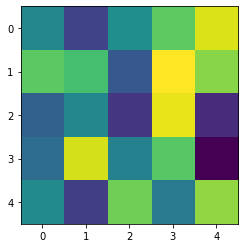

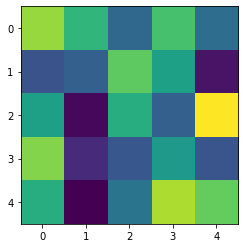

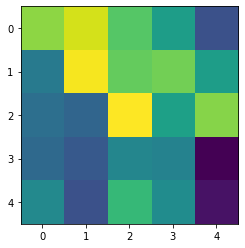

tensor([[[ 4.3583e-02, -5.4538e-02, -7.9646e-02, -7.6790e-02, -6.9964e-02],
         [ 6.5141e-02,  3.7555e-02, -7.1160e-02, -7.0352e-02, -8.5844e-02],
         [ 3.6410e-02,  6.2957e-02, -7.6180e-02, -1.3402e-01, -9.2434e-02],
         [ 2.4041e-02,  6.2397e-02, -6.6349e-02, -1.5878e-01, -1.1553e-01],
         [-2.5761e-02, -3.0629e-02, -7.1253e-02, -1.9264e-01, -1.8812e-01]],

        [[ 2.7327e-02,  1.6168e-02,  3.4281e-02,  2.5737e-02,  1.2680e-02],
         [ 6.6918e-02,  5.2944e-02,  4.4320e-02, -2.0439e-02, -2.8553e-03],
         [ 4.8132e-02,  1.4253e-02,  4.9794e-02,  4.0831e-03,  3.9096e-02],
         [ 4.6787e-02,  3.1700e-02,  1.8872e-02,  3.8515e-02,  1.9647e-02],
         [ 4.0910e-02,  6.4781e-02, -3.1195e-03,  1.3805e-02,  2.3396e-02]],

        [[-8.8940e-02, -9.5896e-02, -1.4076e-01, -1.1969e-01, -1.7462e-01],
         [-7.4789e-03, -2.2994e-02, -7.0664e-02, -1.7223e-01, -1.2203e-01],
         [ 1.7638e-02, -8.1831e-02, -7.2533e-02, -8.1299e-02, -1.1826e-01],
        

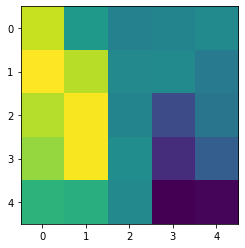

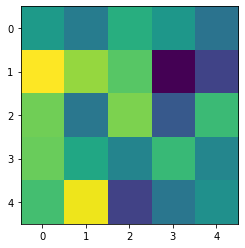

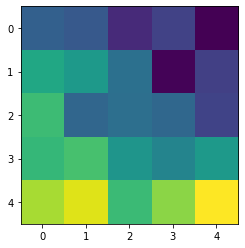

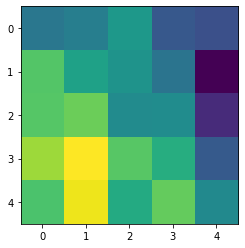

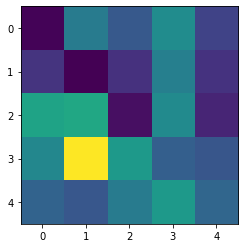

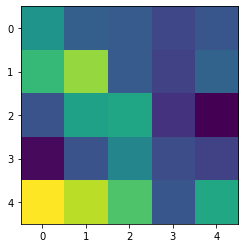

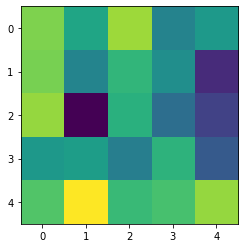

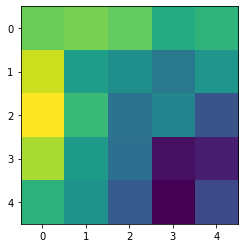

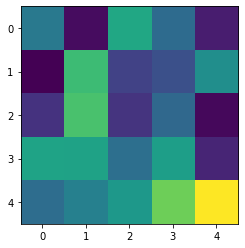

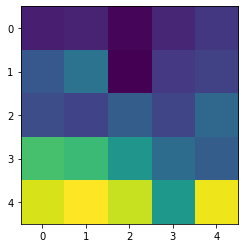

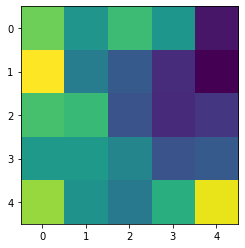

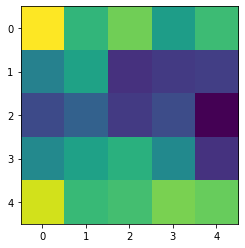

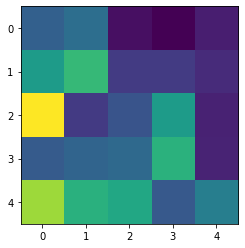

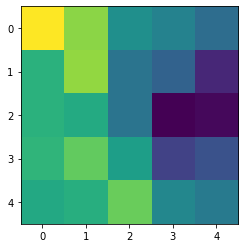

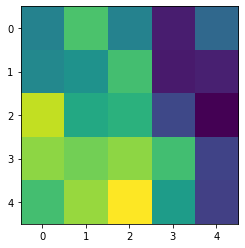

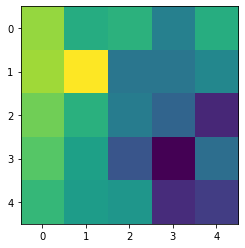

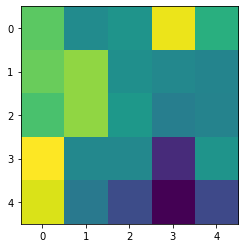

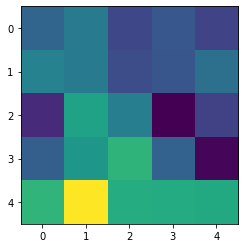

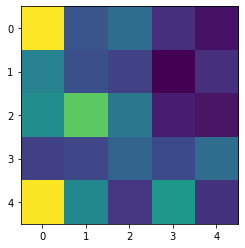

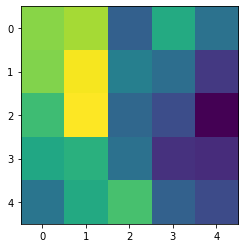

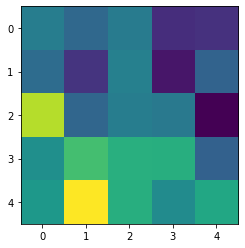

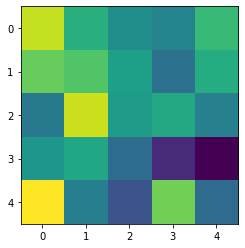

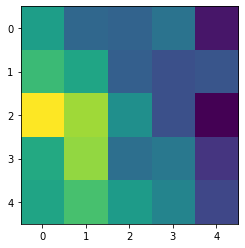

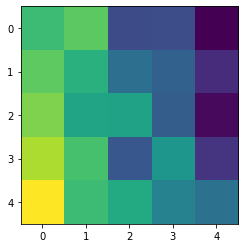

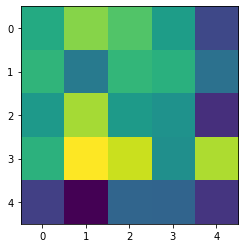

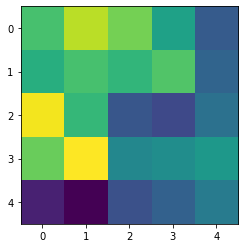

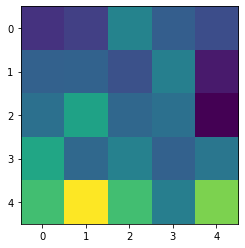

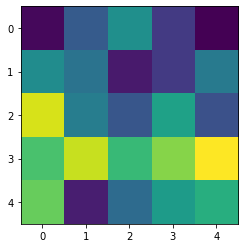

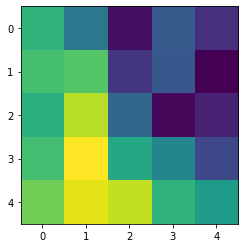

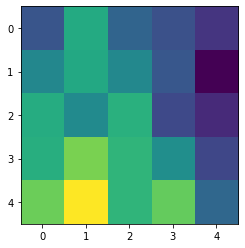

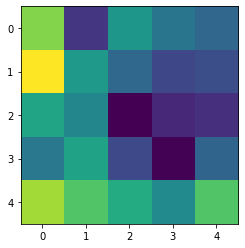

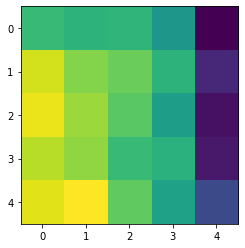

tensor([[[ 0.0011, -0.0012,  0.0293, -0.0384, -0.0051],
         [-0.0226,  0.0281,  0.0257,  0.0239,  0.0007],
         [-0.0247, -0.0031,  0.0140,  0.0291, -0.0215],
         [-0.0158,  0.0108,  0.0011, -0.0174,  0.0124],
         [-0.0111, -0.0403, -0.0235,  0.0134, -0.0270]],

        [[ 0.0280, -0.0040,  0.0132,  0.0028,  0.0254],
         [-0.0007,  0.0112, -0.0122,  0.0074, -0.0183],
         [ 0.0239, -0.0101, -0.0342, -0.0329, -0.0358],
         [ 0.0063, -0.0343,  0.0211, -0.0374,  0.0211],
         [-0.0228,  0.0241, -0.0068, -0.0076,  0.0204]],

        [[ 0.0049, -0.0244, -0.0174,  0.0244,  0.0076],
         [ 0.0075,  0.0261, -0.0408, -0.0328, -0.0405],
         [ 0.0208,  0.0208,  0.0162, -0.0120,  0.0132],
         [-0.0059, -0.0190,  0.0218,  0.0173,  0.0170],
         [-0.0383,  0.0289, -0.0022, -0.0072,  0.0248]],

        [[-0.0010, -0.0114, -0.0276,  0.0246,  0.0043],
         [-0.0148,  0.0157, -0.0101,  0.0101, -0.0036],
         [-0.0169,  0.0283, -0.0271, -0.02

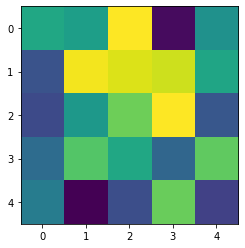

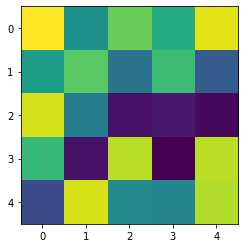

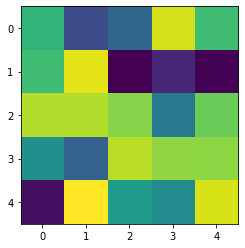

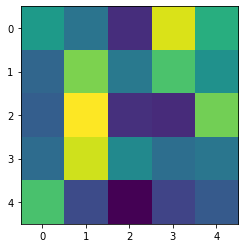

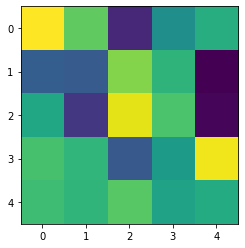

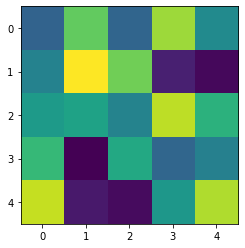

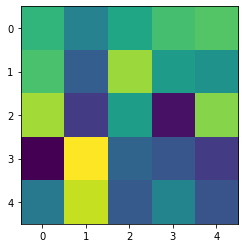

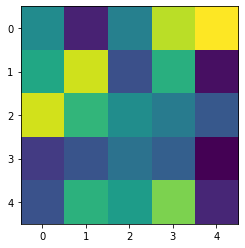

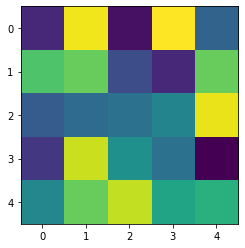

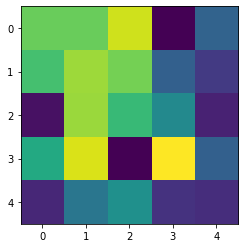

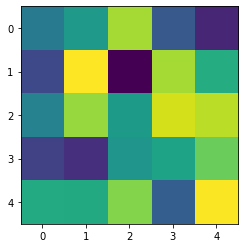

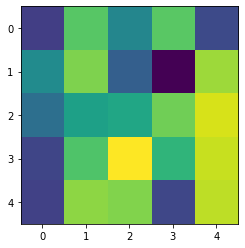

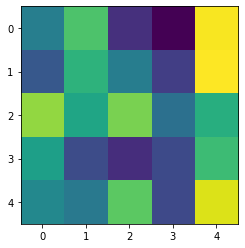

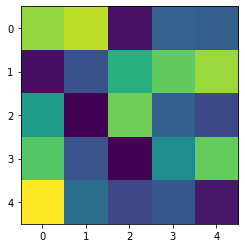

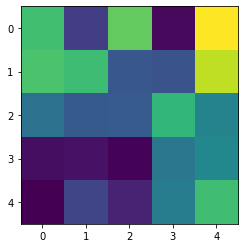

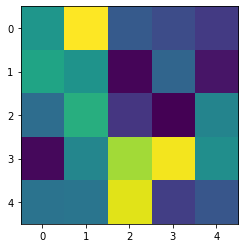

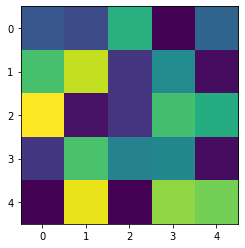

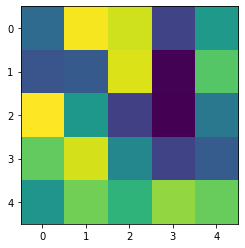

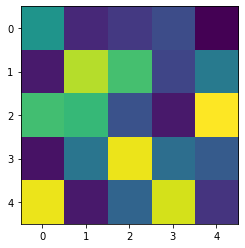

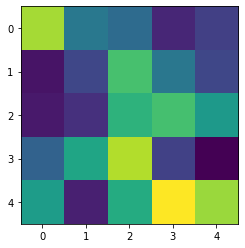

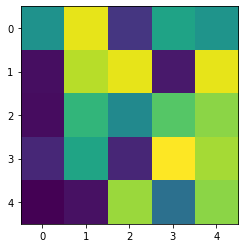

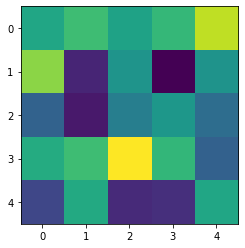

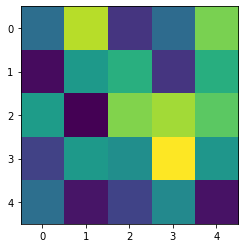

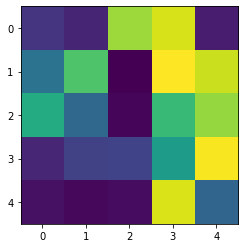

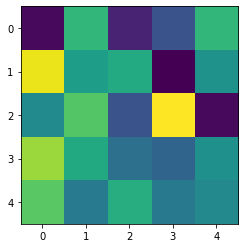

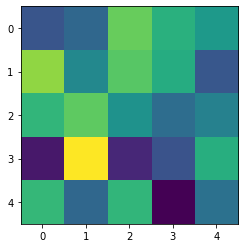

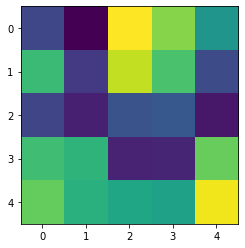

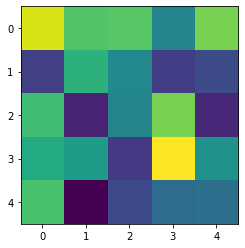

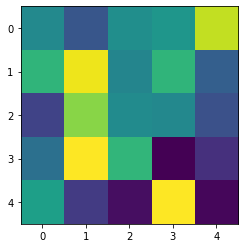

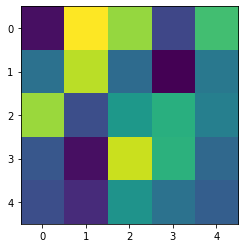

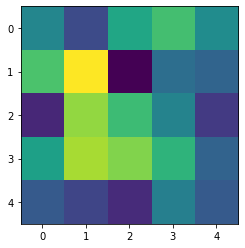

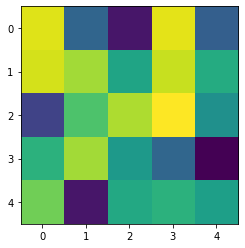

tensor([[[-4.0520e-02,  1.4127e-02, -3.2739e-02,  1.2077e-02,  7.4644e-03],
         [ 2.0765e-02,  1.7987e-03, -1.3899e-02, -1.9575e-02, -3.1498e-02],
         [-3.1290e-02, -2.3712e-02,  2.6056e-02, -8.8269e-03, -5.3502e-04],
         [-1.0084e-02, -2.4694e-02,  1.5091e-02, -4.9761e-03,  9.9821e-03],
         [-3.4134e-02,  3.5354e-03,  2.3226e-02, -1.1969e-02,  1.3062e-02]],

        [[-1.7596e-02, -4.0538e-02, -2.8919e-02, -1.6983e-02,  2.3961e-02],
         [ 2.5870e-02,  4.6080e-03, -1.6036e-04, -8.3259e-03, -3.2185e-02],
         [-5.6276e-03,  1.2623e-02, -3.1036e-02,  2.1509e-02,  1.0058e-03],
         [-2.7110e-02, -3.9146e-02, -1.6721e-02, -4.0629e-02,  4.6783e-03],
         [-2.5353e-02, -4.1156e-02,  2.7167e-02,  9.7073e-03, -2.3687e-02]],

        [[ 2.8718e-02, -1.2174e-02, -1.2747e-02, -3.4672e-02,  1.2192e-02],
         [-1.9184e-02,  1.3246e-03, -7.9143e-03,  6.0603e-03, -2.8790e-03],
         [ 1.6340e-02, -1.9648e-02,  9.6283e-03, -8.7242e-03, -3.1305e-02],
        

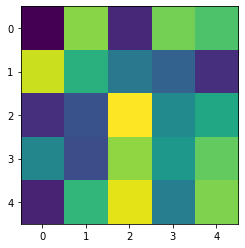

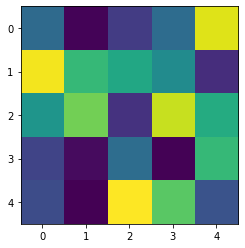

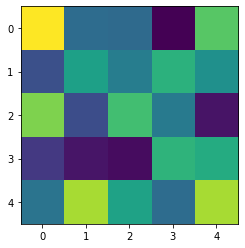

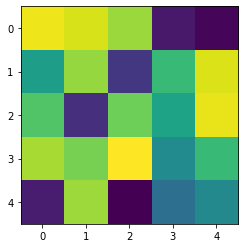

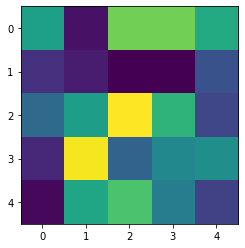

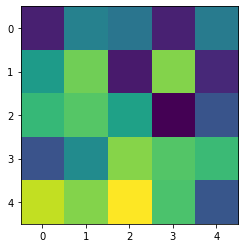

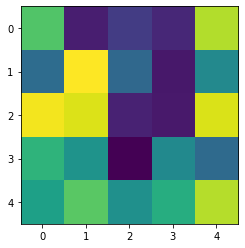

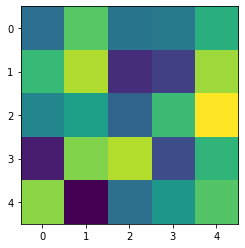

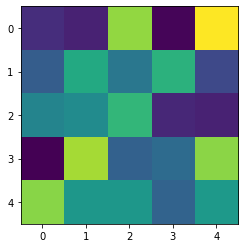

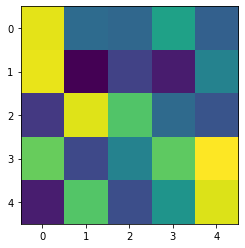

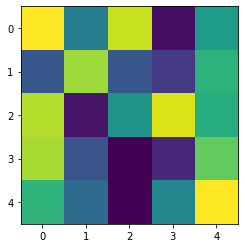

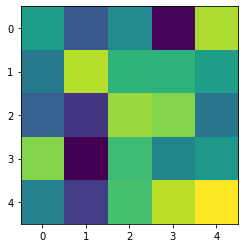

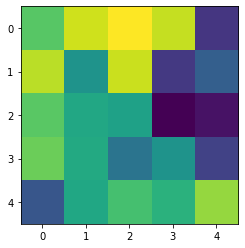

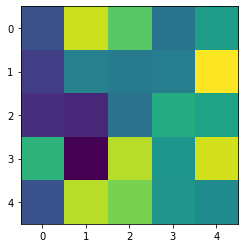

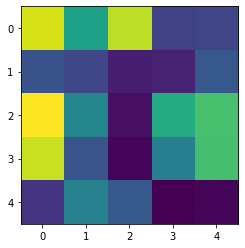

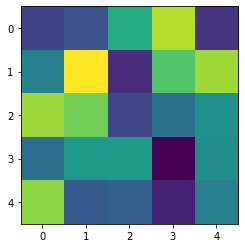

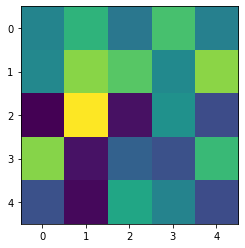

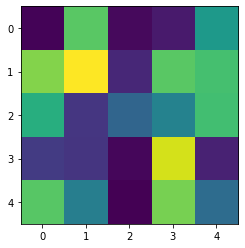

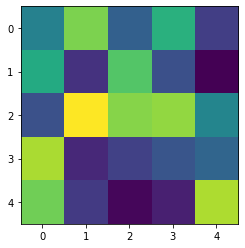

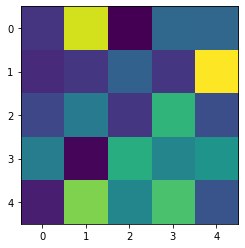

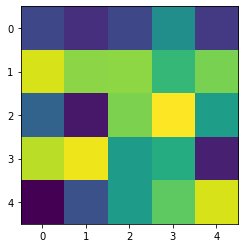

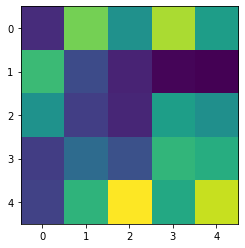

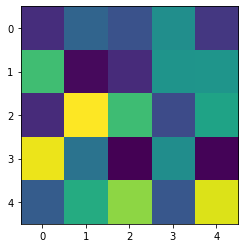

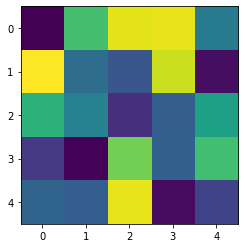

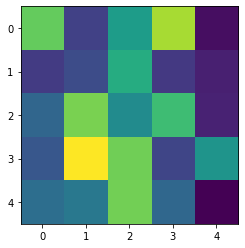

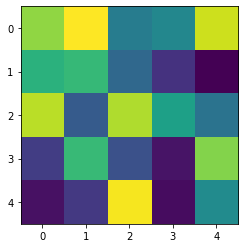

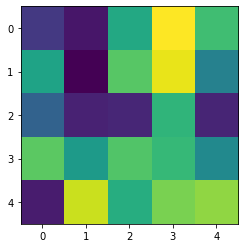

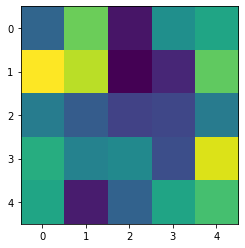

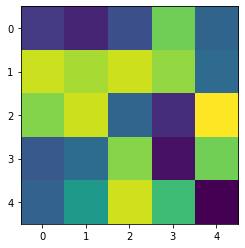

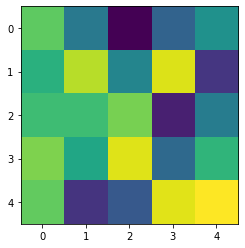

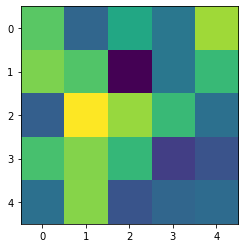

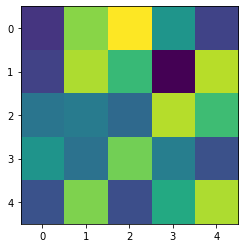

tensor([[[ 1.5940e-02, -7.1328e-03, -1.2576e-02, -1.3729e-02, -2.8621e-02],
         [ 2.2348e-03, -3.7978e-02, -1.5153e-02, -2.9971e-02, -5.1185e-04],
         [-3.1946e-02,  1.3350e-02,  2.1583e-02,  2.1436e-02, -2.3908e-02],
         [-7.6471e-03,  2.4986e-03, -1.1179e-02, -1.7626e-02, -3.8808e-02],
         [-2.0867e-02,  1.2632e-02,  1.2496e-02, -3.5355e-02, -2.8036e-02]],

        [[-2.9629e-02, -1.8227e-02, -2.7017e-02, -1.6360e-02, -6.0040e-03],
         [-8.2926e-03,  3.5724e-03, -3.6217e-03, -9.7752e-03,  1.9816e-03],
         [ 8.3979e-03, -1.6115e-02,  2.6163e-02, -3.8853e-02, -5.6344e-03],
         [-4.1057e-02,  2.0672e-02, -1.5785e-02, -7.0488e-03,  2.7275e-02],
         [ 9.3405e-03, -2.0395e-02, -2.9515e-02,  1.4602e-02, -1.2369e-02]],

        [[-4.1116e-03,  7.9692e-03, -1.0790e-02, -3.0187e-02,  1.0690e-02],
         [ 1.0761e-02, -1.2135e-02, -2.5482e-03, -3.6220e-02, -1.3424e-02],
         [-2.4697e-02, -1.6510e-02, -3.0230e-02, -2.4327e-02, -6.4447e-03],
        

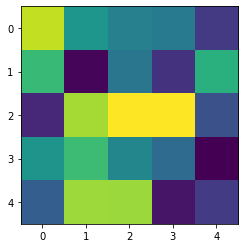

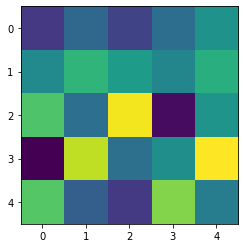

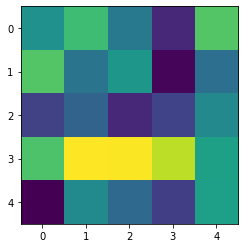

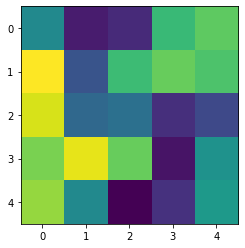

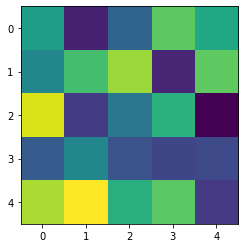

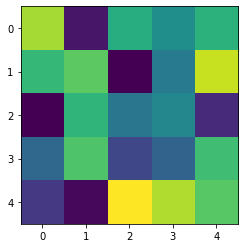

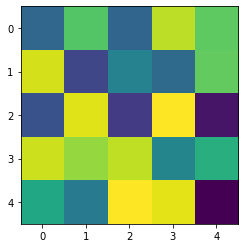

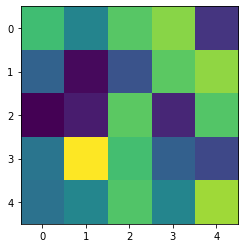

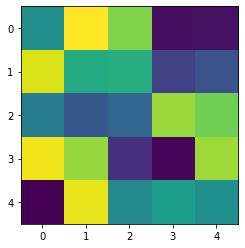

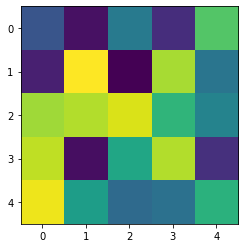

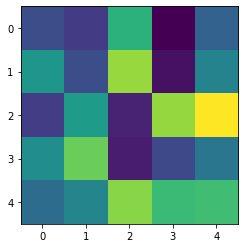

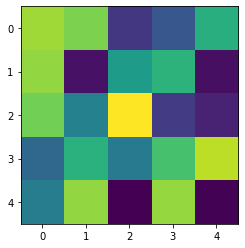

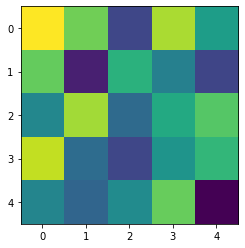

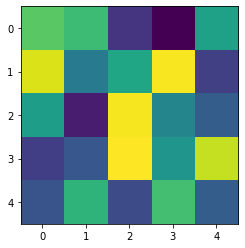

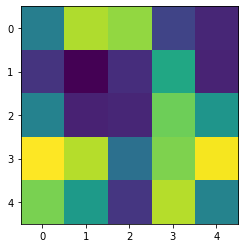

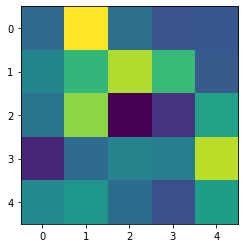

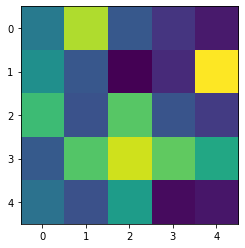

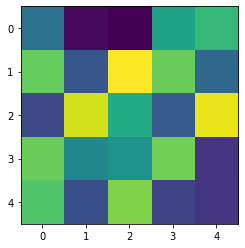

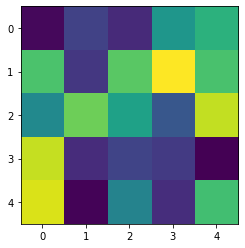

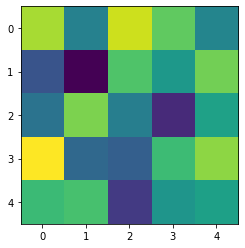

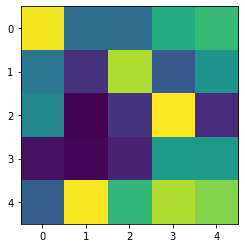

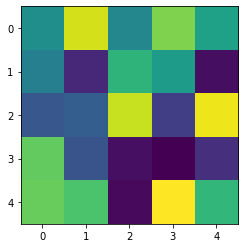

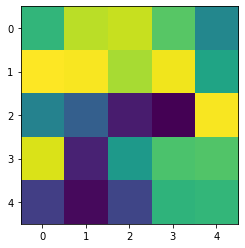

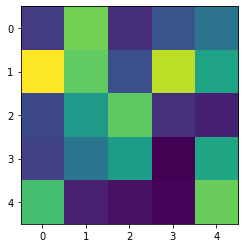

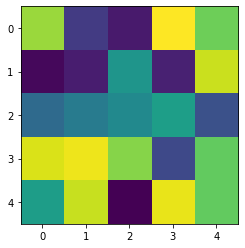

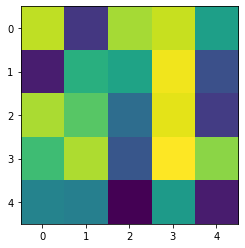

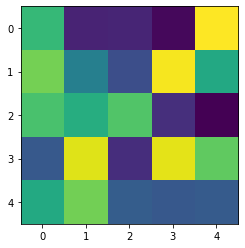

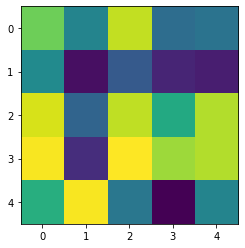

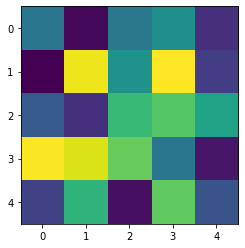

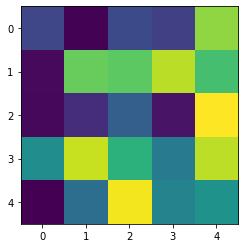

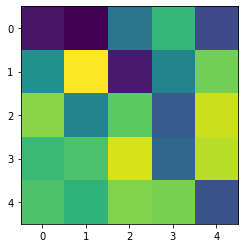

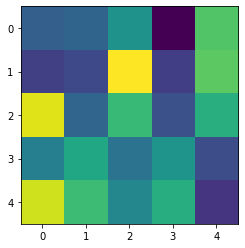

tensor([[[ 1.8447e-02,  3.3200e-02, -8.0215e-03, -2.6168e-02, -4.0603e-03],
         [-1.0649e-02,  1.1353e-02,  7.4641e-03,  1.3250e-03,  2.5158e-02],
         [-6.2947e-02, -6.1658e-03,  2.4946e-02,  1.8467e-02,  4.2359e-02],
         [-3.6035e-02,  2.3524e-02,  4.6114e-02,  7.1530e-02,  1.3610e-02],
         [ 2.1128e-02, -2.0940e-03,  4.9208e-02,  1.9503e-02, -4.9871e-02]],

        [[-5.1174e-04,  2.0339e-03,  1.0567e-02,  1.1145e-02, -9.7507e-03],
         [-3.2057e-04, -2.4945e-02, -2.4663e-02, -9.7028e-03,  4.4713e-02],
         [ 9.3521e-03,  2.4846e-02, -2.5466e-02,  1.6246e-02,  2.7933e-02],
         [-1.9040e-02,  2.1581e-02,  5.0858e-02,  4.3046e-02, -6.0541e-03],
         [ 4.1506e-02,  2.3630e-02,  9.1245e-03,  2.7227e-02,  3.8627e-02]],

        [[ 1.3800e-02,  1.6831e-02, -3.0146e-02, -4.6876e-02, -7.2472e-02],
         [-1.0778e-02, -3.2855e-02, -1.0910e-01, -6.3886e-02, -1.2617e-02],
         [ 1.8966e-02, -5.1495e-02,  9.7273e-03, -3.3078e-03,  1.6519e-02],
        

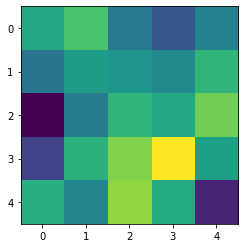

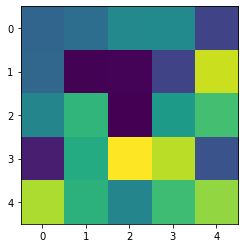

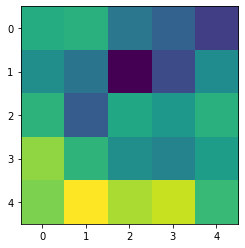

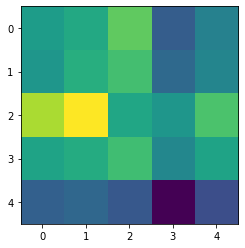

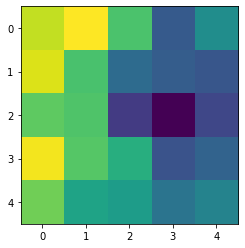

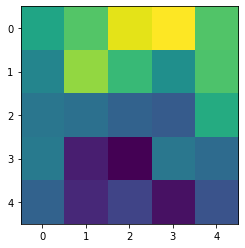

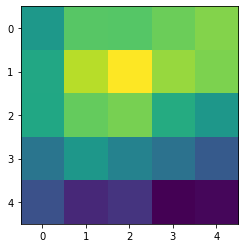

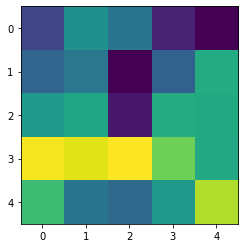

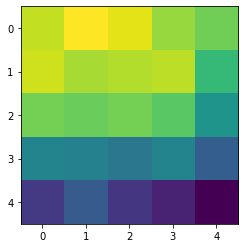

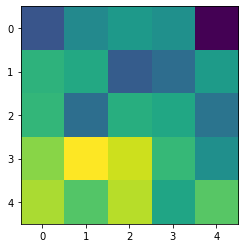

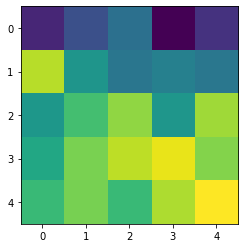

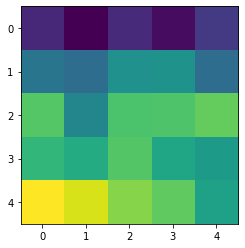

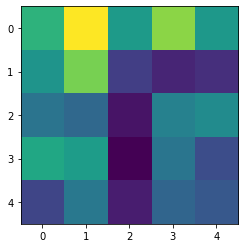

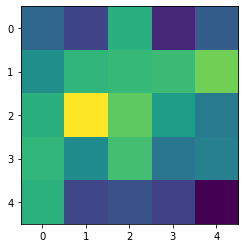

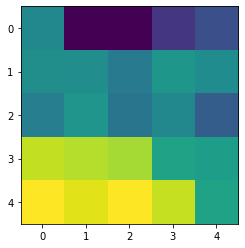

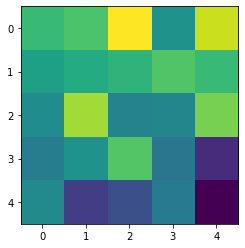

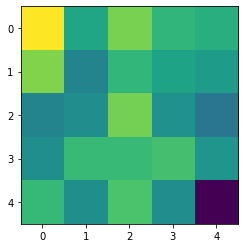

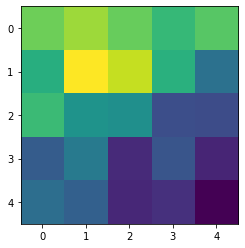

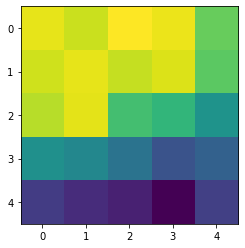

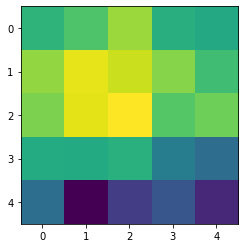

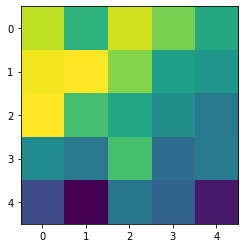

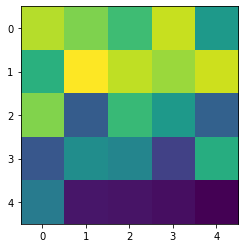

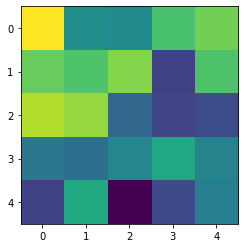

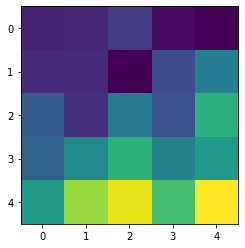

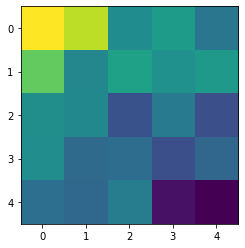

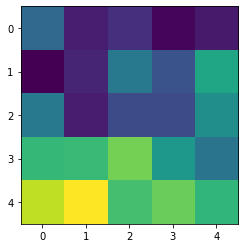

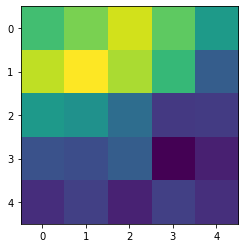

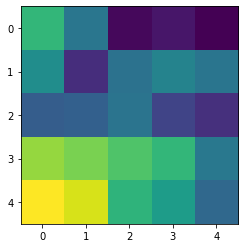

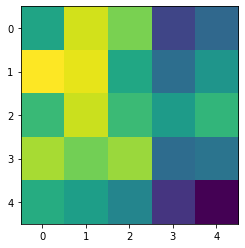

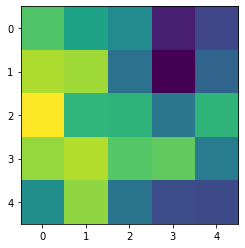

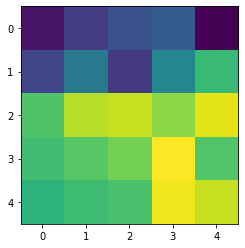

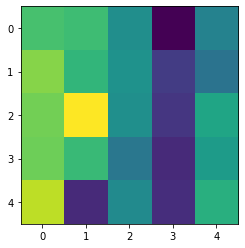

tensor([[[ 2.1852e-02,  3.8303e-02,  2.0787e-02,  7.2572e-02,  4.8762e-02],
         [ 4.8549e-02, -2.4311e-02,  1.5946e-02,  4.9019e-02,  2.2785e-02],
         [ 4.5484e-02,  2.6875e-02, -1.1136e-02,  1.5512e-02,  2.3791e-02],
         [ 3.3850e-02,  9.1476e-03, -3.9947e-03,  3.5138e-02,  3.3585e-02],
         [-1.5761e-02, -6.0392e-03, -1.0367e-01, -4.1223e-02, -2.1052e-02]],

        [[ 9.7109e-04,  2.4917e-02,  7.0803e-03,  4.6554e-02,  2.4412e-02],
         [ 6.6511e-02,  6.2300e-02,  4.7871e-02,  2.9847e-02, -6.2341e-03],
         [ 1.2217e-02,  6.3422e-02,  2.9122e-02,  5.0376e-02,  5.1283e-03],
         [ 6.2253e-02,  2.0057e-02,  2.2530e-02,  3.1177e-02,  2.7900e-02],
         [ 6.1733e-02,  4.3703e-03,  2.7596e-02,  1.8710e-03,  1.5736e-02]],

        [[ 1.1568e-02, -5.4735e-03, -3.6283e-02, -4.2937e-02,  2.1494e-02],
         [-4.0219e-02, -1.0897e-01, -1.1518e-01, -1.0480e-01,  1.5306e-03],
         [-1.7252e-02, -2.3455e-02, -2.0203e-02, -5.3585e-02,  5.3937e-02],
        

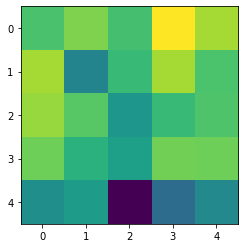

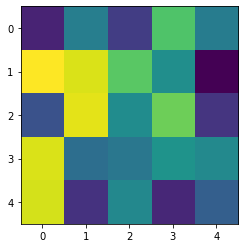

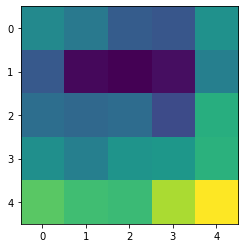

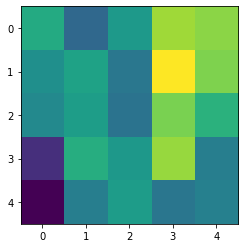

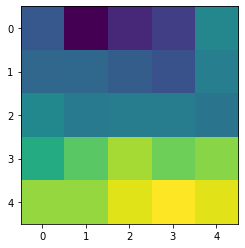

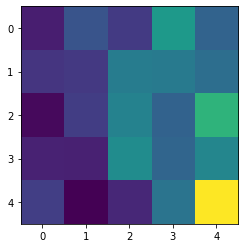

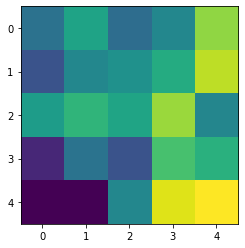

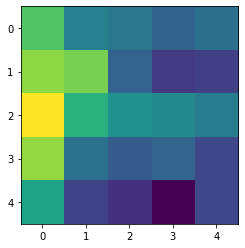

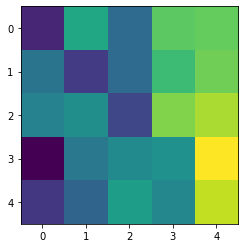

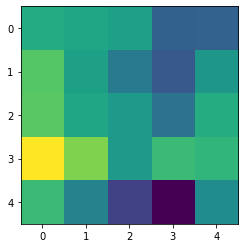

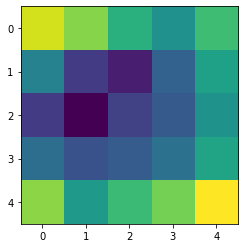

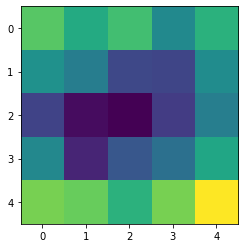

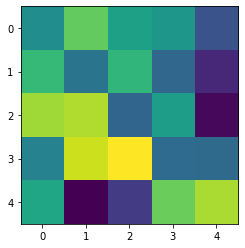

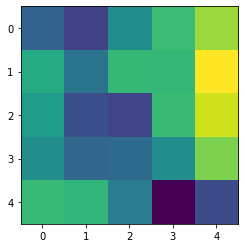

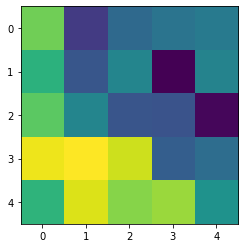

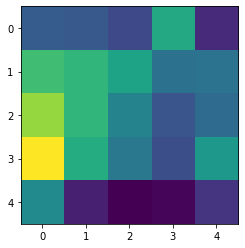

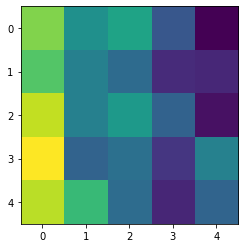

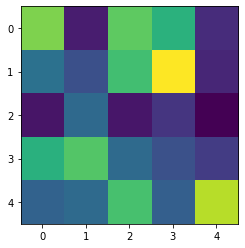

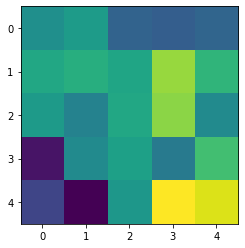

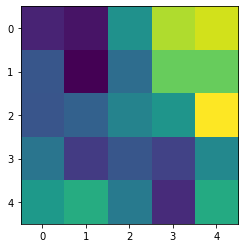

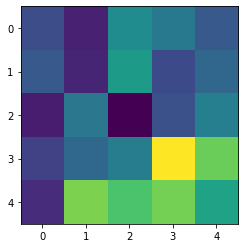

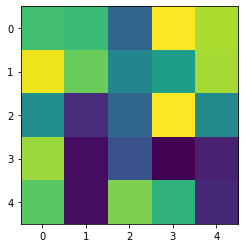

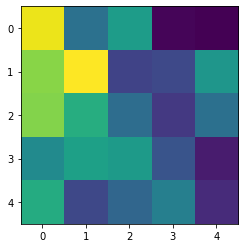

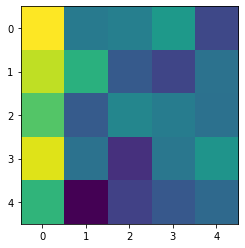

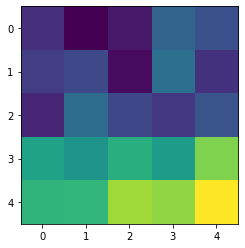

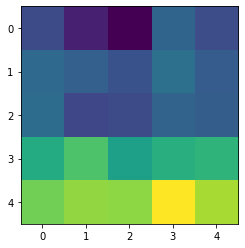

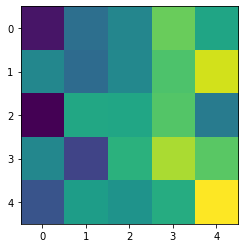

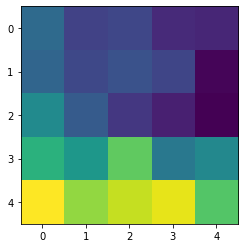

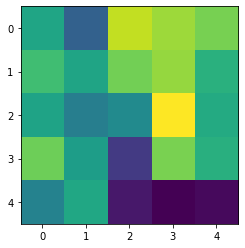

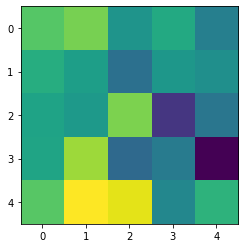

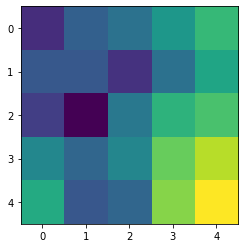

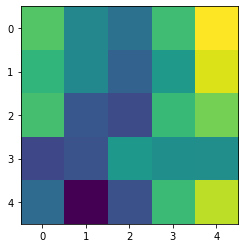

tensor([[[-0.0367,  0.0267,  0.0240,  0.0164, -0.0292],
         [-0.0074,  0.0191,  0.0071,  0.0067, -0.0547],
         [-0.0220,  0.0201, -0.0430, -0.0199, -0.0205],
         [-0.0486,  0.0004, -0.0141, -0.0414, -0.0005],
         [-0.0178, -0.0388,  0.0246, -0.0143, -0.0091]],

        [[-0.0424, -0.0550, -0.0355, -0.0238, -0.0358],
         [-0.0154, -0.0338, -0.0410,  0.0074,  0.0012],
         [-0.0347, -0.0034,  0.0103, -0.0473, -0.0165],
         [-0.0045, -0.0385, -0.0053, -0.0461, -0.0014],
         [-0.0487, -0.0291, -0.0468, -0.0138, -0.0219]],

        [[-0.0301, -0.0189, -0.0509, -0.0517, -0.0393],
         [-0.0185,  0.0009, -0.0320,  0.0272, -0.0280],
         [-0.0158,  0.0071, -0.0079,  0.0027, -0.0125],
         [-0.0169, -0.0038, -0.0285, -0.0004,  0.0114],
         [ 0.0078, -0.0505, -0.0563, -0.0073, -0.0209]],

        [[ 0.0019,  0.0048, -0.0373,  0.0011,  0.0203],
         [-0.0198,  0.0104, -0.0431, -0.0339, -0.0294],
         [-0.0231,  0.0100, -0.0041, -0.01

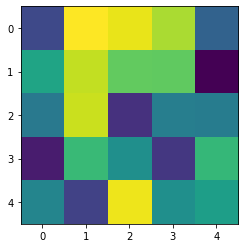

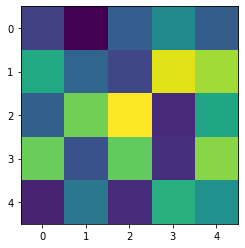

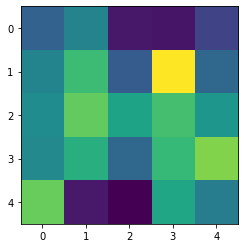

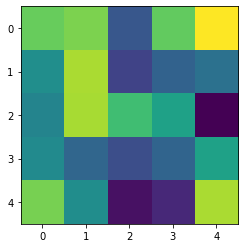

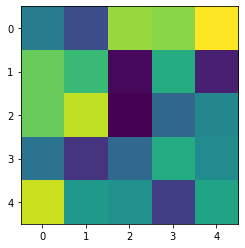

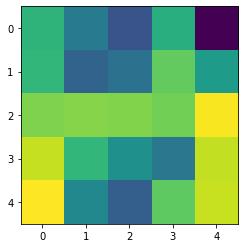

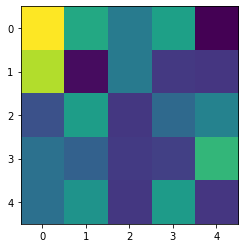

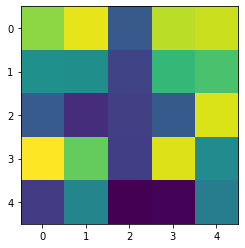

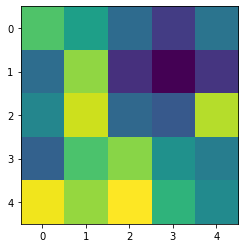

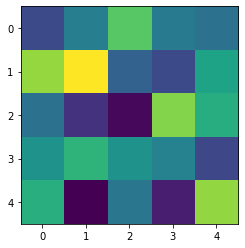

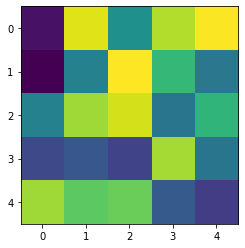

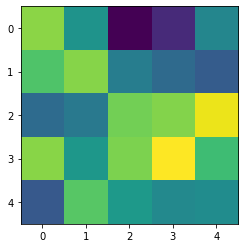

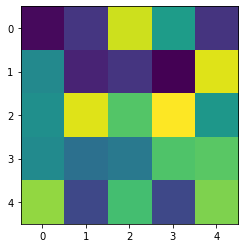

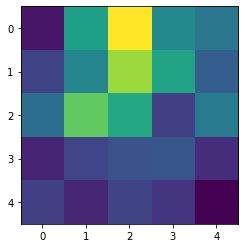

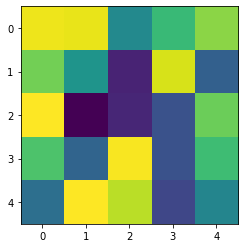

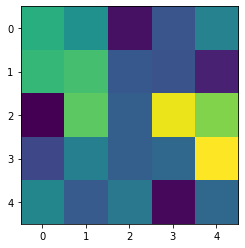

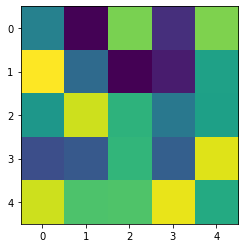

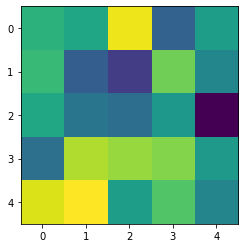

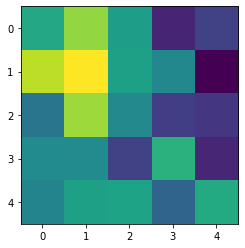

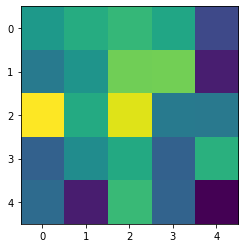

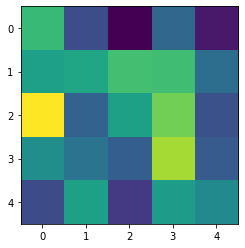

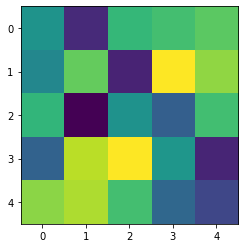

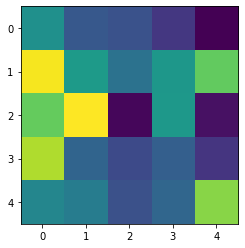

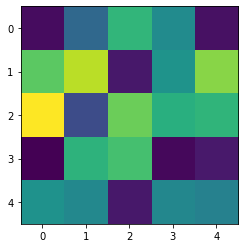

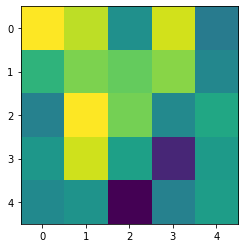

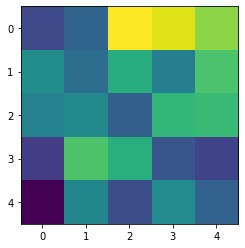

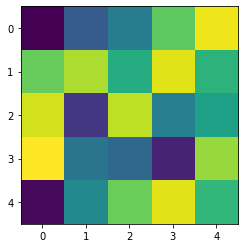

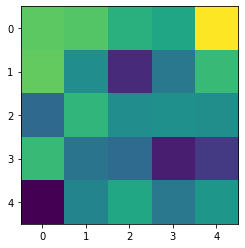

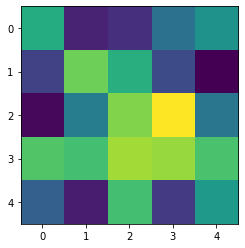

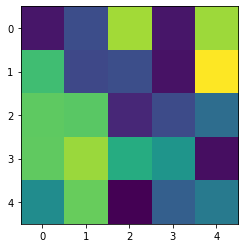

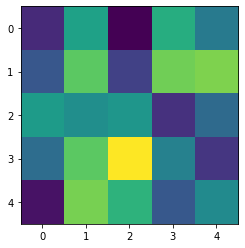

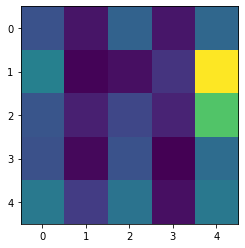

tensor([[[ 7.5389e-03,  1.6347e-02,  3.6137e-03, -2.3052e-02, -2.2146e-02],
         [-3.4229e-02, -4.9641e-02, -4.0972e-02, -4.3003e-02, -3.1732e-03],
         [-9.5282e-02, -7.4560e-02, -2.7325e-02, -1.4324e-02, -5.0085e-02],
         [-9.8961e-02, -9.6460e-02, -1.0521e-01, -7.3256e-02, -4.5952e-02],
         [-1.2751e-03,  9.3250e-03,  2.9604e-02,  1.3903e-03, -3.6054e-02]],

        [[-2.5106e-03,  2.2305e-02,  2.9783e-02,  4.5529e-02,  3.5135e-02],
         [ 1.3251e-02,  6.3764e-03, -1.0630e-02, -1.8496e-02,  3.3773e-02],
         [-3.8306e-02, -1.7781e-02,  2.2792e-02, -1.2103e-04,  3.7040e-02],
         [ 1.4812e-02, -3.2532e-02, -1.7460e-02, -3.9402e-02, -5.2893e-03],
         [-4.4692e-02, -4.3838e-02, -2.1758e-02, -1.6849e-02, -3.2395e-02]],

        [[ 4.9479e-02,  6.8257e-02,  9.6898e-02,  1.5165e-01,  1.1240e-01],
         [ 5.7227e-02,  5.1756e-02,  8.9502e-02,  7.5074e-02,  4.9637e-02],
         [ 7.6263e-02,  5.7118e-02, -1.7991e-02, -5.2434e-02,  2.5100e-02],
        

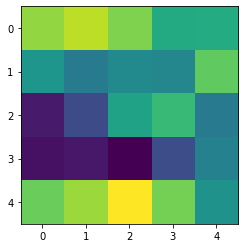

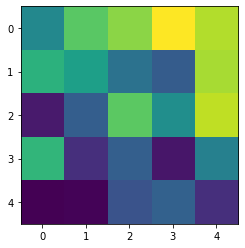

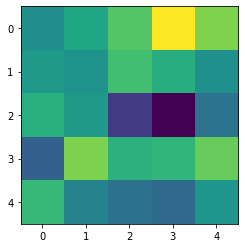

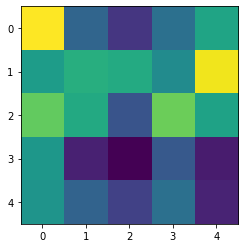

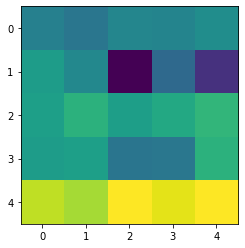

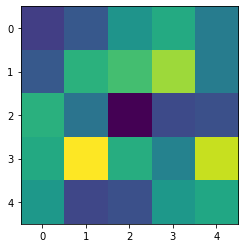

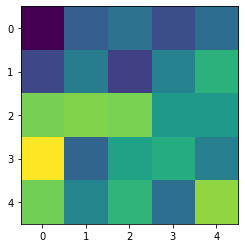

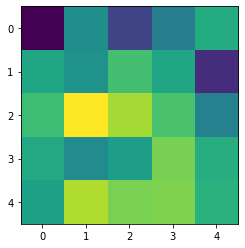

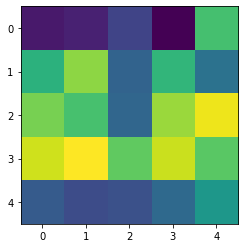

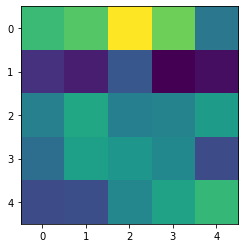

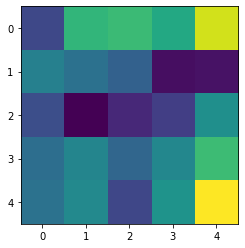

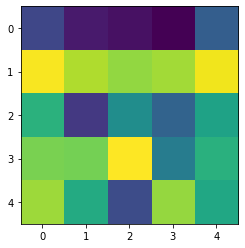

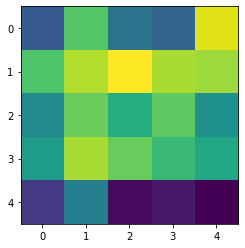

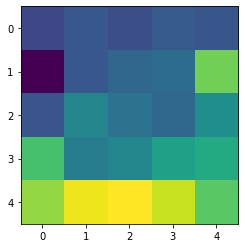

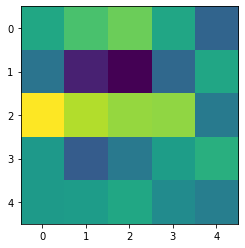

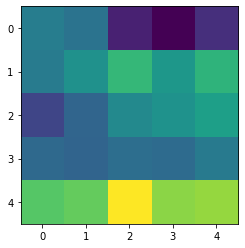

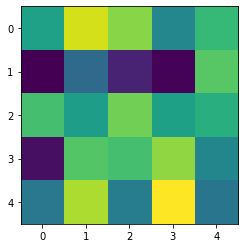

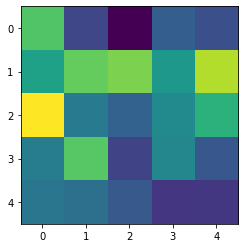

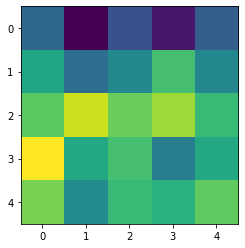

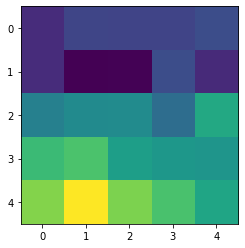

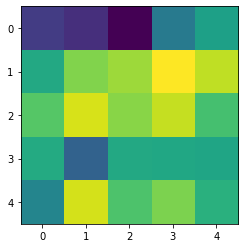

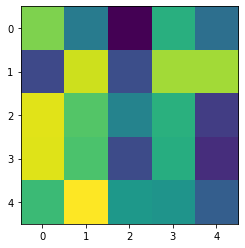

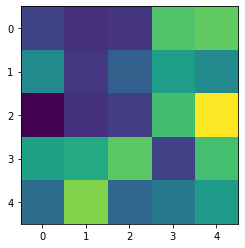

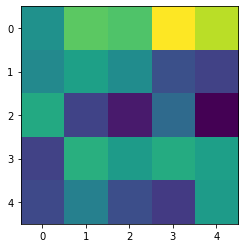

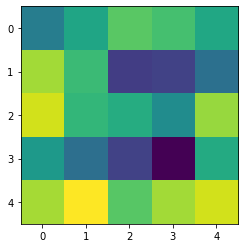

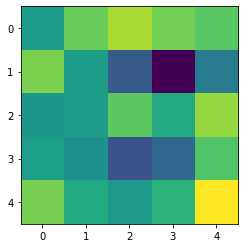

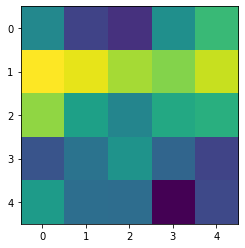

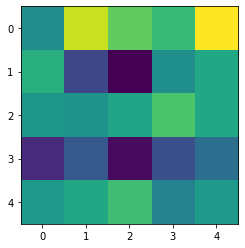

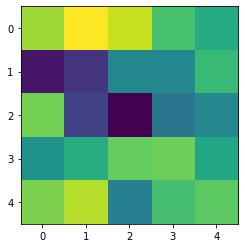

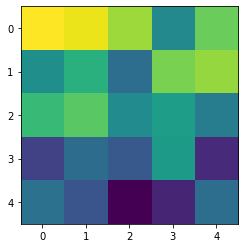

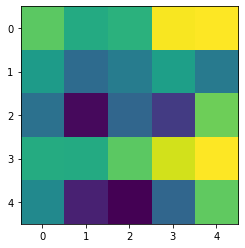

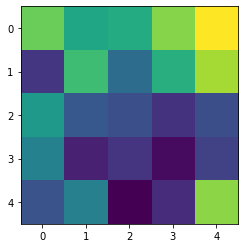

tensor([[[-1.7359e-01, -1.3246e-01, -5.6384e-02,  5.1345e-02,  1.3836e-01],
         [-1.1101e-01, -1.9690e-01, -1.5300e-01, -1.0712e-02,  8.7557e-02],
         [-1.0961e-01, -2.9597e-01, -2.6779e-01, -4.6354e-02,  7.3507e-02],
         [-5.6701e-02, -2.3549e-01, -2.0049e-01,  3.8713e-02,  1.1436e-01],
         [ 2.0187e-02, -8.8328e-02, -3.4938e-02,  1.6721e-01,  2.0527e-01]],

        [[ 2.0217e-03, -1.1107e-02,  3.3525e-02,  6.4614e-02,  1.0009e-01],
         [-3.4567e-02, -5.0512e-02, -1.6173e-02,  1.9374e-02,  3.1324e-02],
         [-2.8740e-02, -6.6280e-02, -8.4928e-02, -4.4985e-02,  7.1873e-02],
         [ 3.4450e-02, -5.2938e-02, -7.8300e-03,  3.2553e-02,  7.4093e-02],
         [ 1.7919e-02,  6.9249e-02,  6.7775e-02,  9.0616e-02,  1.0068e-01]],

        [[ 1.8090e-01,  1.4993e-01,  1.7939e-01,  1.5238e-01,  1.6345e-01],
         [-6.6048e-02, -1.1273e-01, -1.1711e-01, -8.9052e-02, -3.1992e-02],
         [ 1.2219e-03, -2.1653e-02, -1.4032e-01, -1.0103e-01, -7.2284e-02],
        

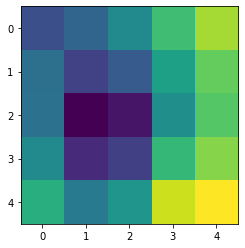

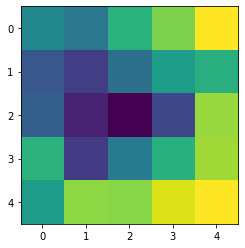

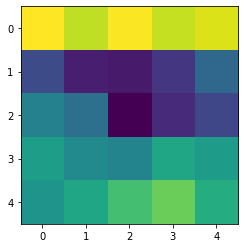

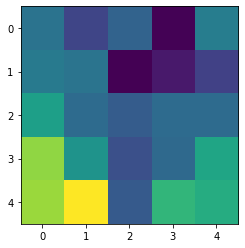

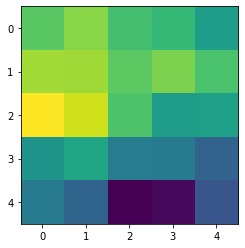

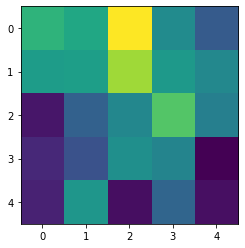

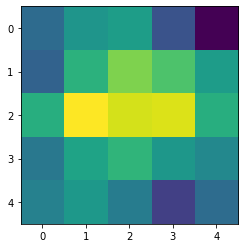

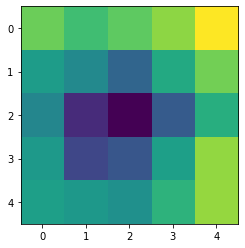

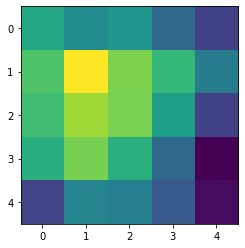

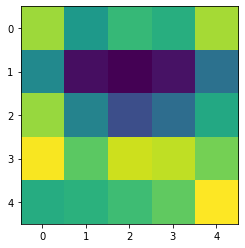

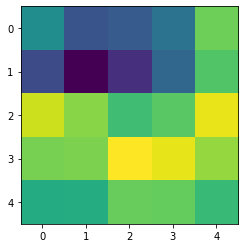

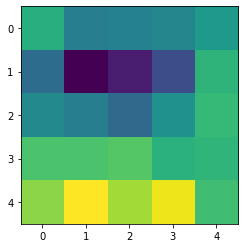

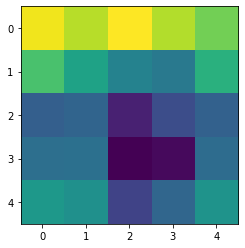

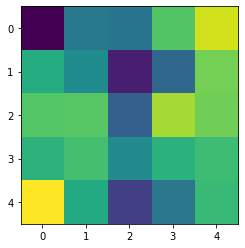

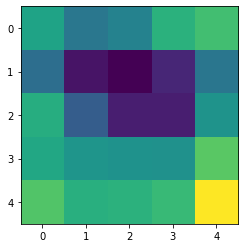

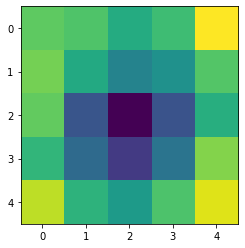

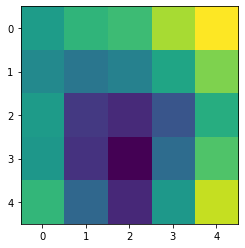

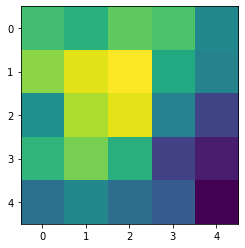

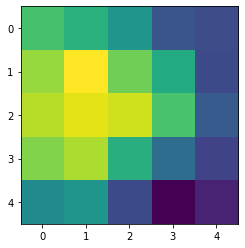

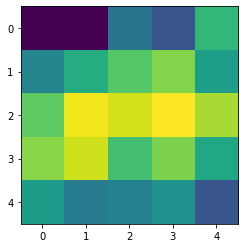

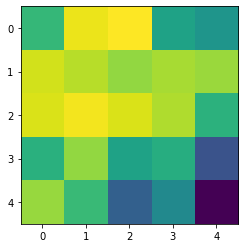

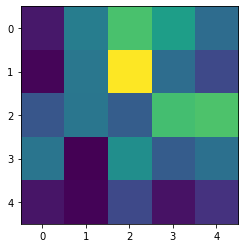

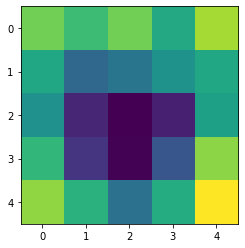

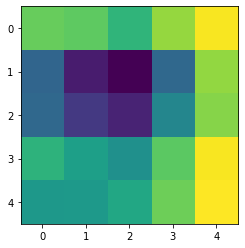

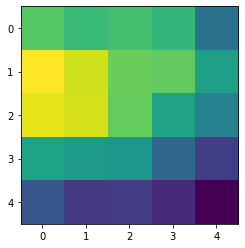

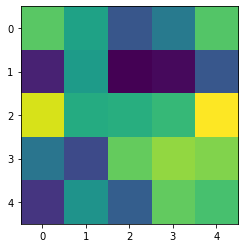

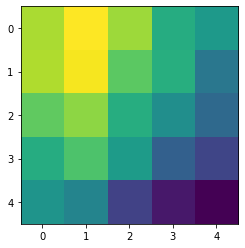

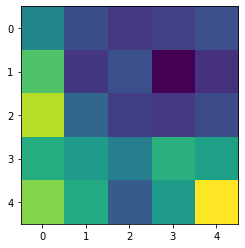

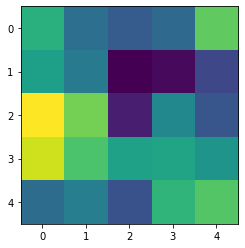

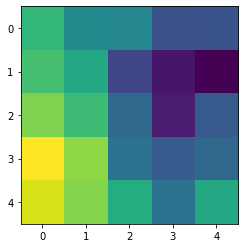

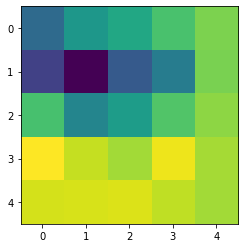

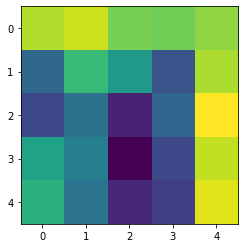

tensor([[[ 1.2902e-02, -5.2881e-03,  2.1679e-02,  2.7846e-03,  4.2783e-03],
         [ 1.2776e-02, -3.8854e-02, -3.7787e-02, -2.0690e-02,  2.0750e-02],
         [-2.4958e-02, -7.1387e-03,  1.6157e-02, -3.4639e-02, -3.6437e-02],
         [-2.7463e-02,  5.5125e-03, -1.5674e-02, -3.7288e-02,  2.4819e-02],
         [-1.4644e-03, -9.1056e-03, -2.4914e-02, -3.5630e-02,  2.3901e-02]],

        [[-1.7345e-02, -3.6856e-02,  1.2321e-02,  1.9272e-02, -1.3830e-02],
         [-1.3817e-02,  5.6616e-03,  1.1460e-04, -3.5131e-02,  4.5472e-03],
         [-1.8646e-02,  2.0745e-02,  2.8439e-02,  1.2745e-02,  6.5244e-03],
         [ 2.4441e-02,  1.3645e-02, -2.3441e-02,  2.4061e-03, -1.9308e-02],
         [-3.8027e-02, -2.3460e-02, -2.6660e-02, -1.8604e-02,  2.1277e-02]],

        [[-2.2575e-02,  1.3435e-02, -8.7535e-03, -2.2566e-03,  5.2428e-03],
         [-9.3200e-03,  4.3594e-03, -2.7425e-02,  6.1441e-03, -1.9995e-02],
         [-1.5631e-02, -2.6296e-03,  1.0493e-02,  1.2399e-02, -3.2687e-02],
        

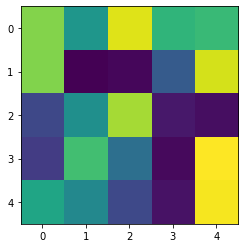

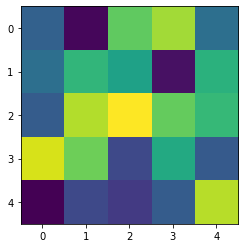

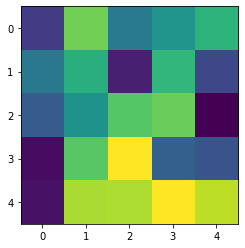

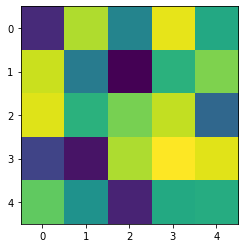

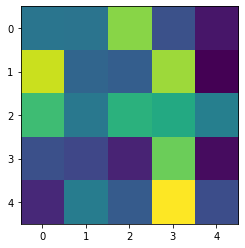

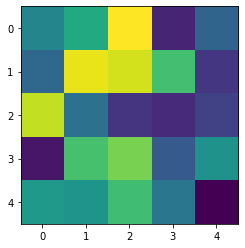

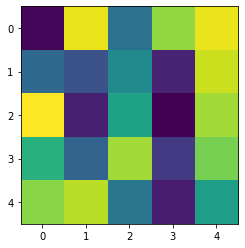

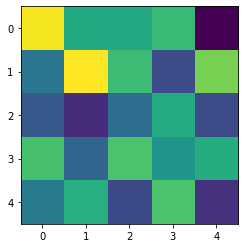

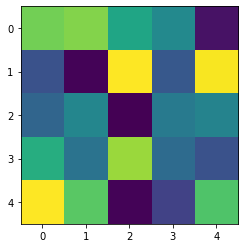

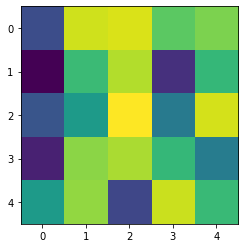

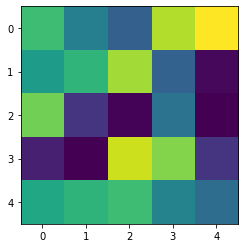

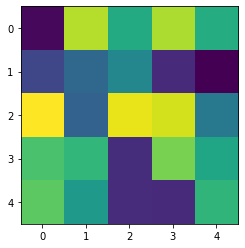

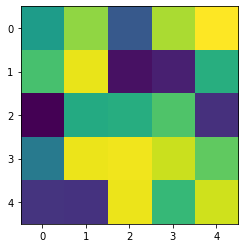

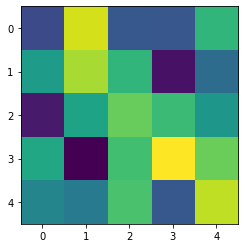

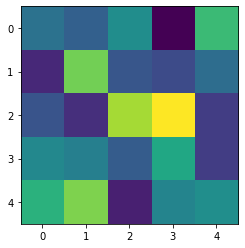

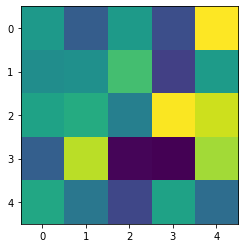

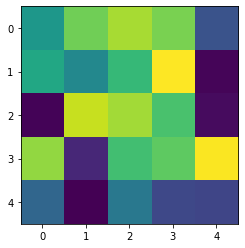

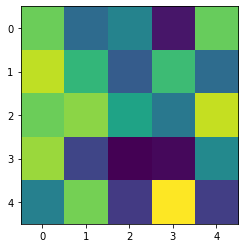

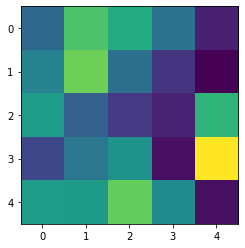

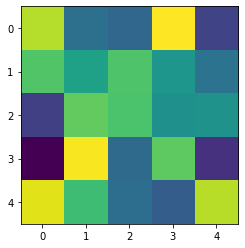

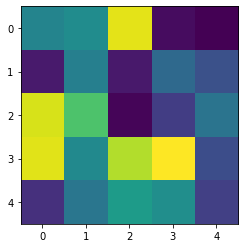

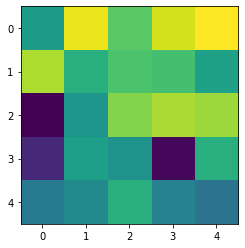

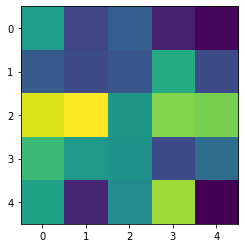

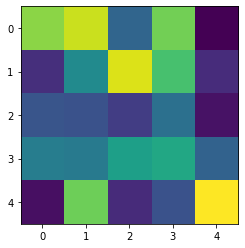

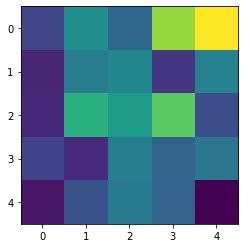

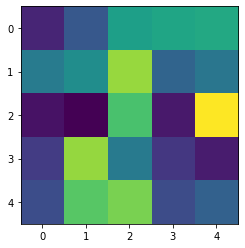

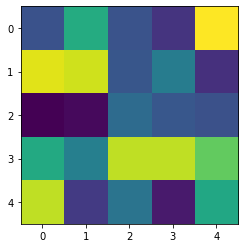

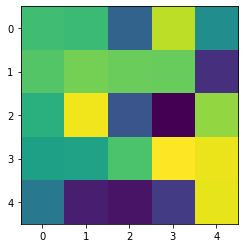

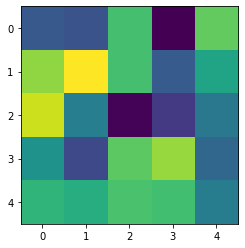

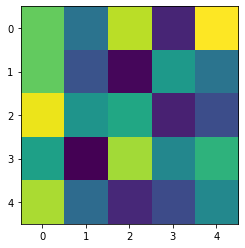

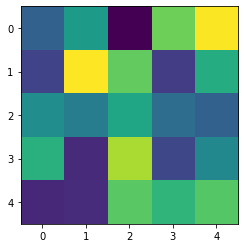

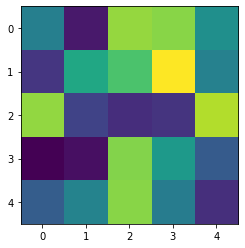

tensor([[[-3.1171e-02, -1.9751e-02,  2.5817e-02, -1.2331e-02,  1.8340e-02],
         [ 2.0617e-02,  1.7872e-02,  9.0566e-03, -1.0564e-02, -2.6928e-02],
         [-2.2959e-02, -2.0182e-02, -3.9971e-02, -2.8015e-02, -1.5444e-02],
         [-3.1582e-02, -6.4332e-03,  1.9078e-02, -3.0876e-02, -1.1104e-02],
         [-8.2861e-03,  3.6471e-03, -9.6571e-03,  1.6234e-02, -4.3189e-03]],

        [[-1.6620e-02,  1.8806e-02, -2.7781e-02,  2.0358e-02, -2.5066e-02],
         [-3.3338e-02,  4.8684e-03, -3.6765e-02, -3.8177e-02,  4.3132e-03],
         [-1.1426e-02, -6.0028e-03, -1.6725e-02, -3.0153e-02, -8.2814e-03],
         [ 2.7511e-02, -3.7181e-02,  3.2660e-03,  1.7203e-02,  1.9337e-02],
         [-2.1793e-02, -6.4256e-03, -1.9765e-02,  2.3172e-02,  2.2070e-02]],

        [[ 2.7251e-02, -1.0171e-02, -1.3315e-02, -3.8823e-02, -2.0052e-03],
         [-7.9200e-03, -1.1893e-02, -2.7884e-02, -4.0573e-02,  1.3339e-03],
         [ 9.3153e-03, -2.7909e-02,  1.9338e-02, -1.6155e-02, -3.5401e-03],
        

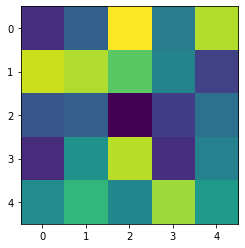

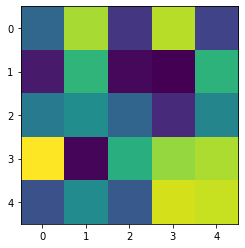

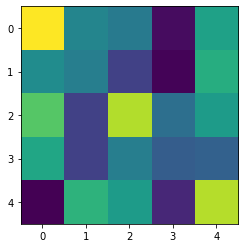

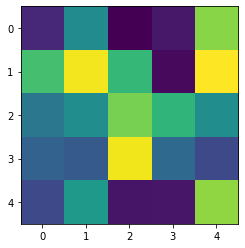

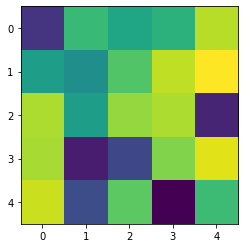

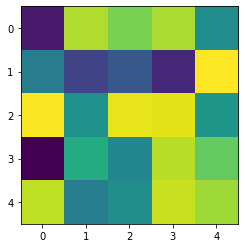

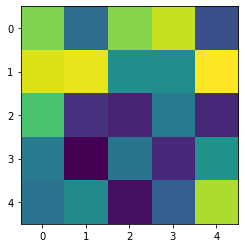

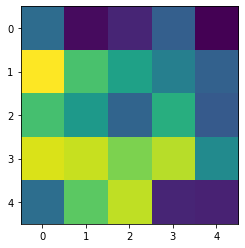

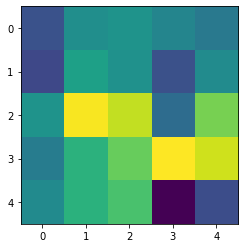

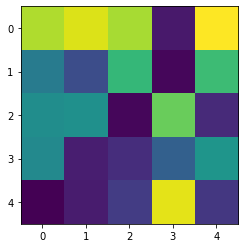

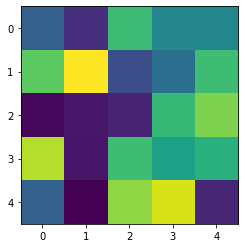

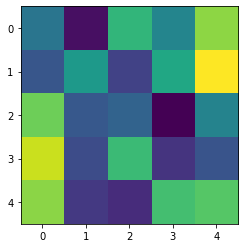

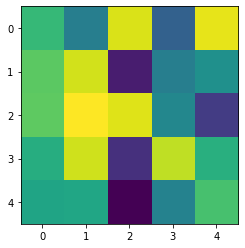

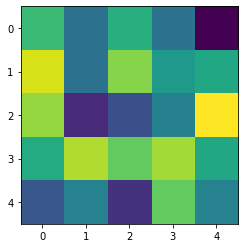

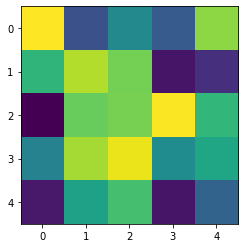

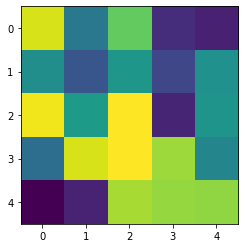

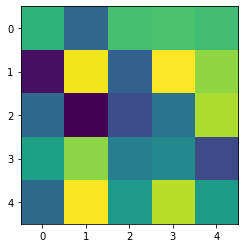

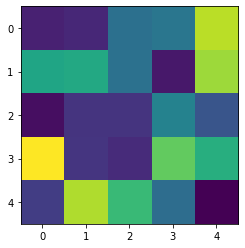

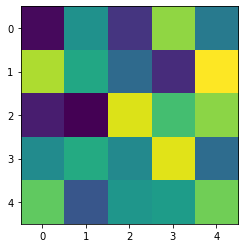

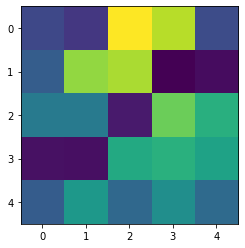

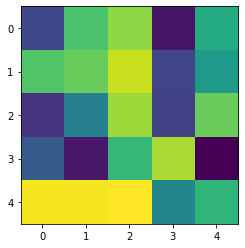

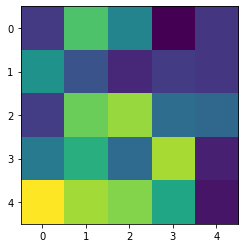

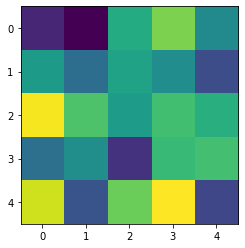

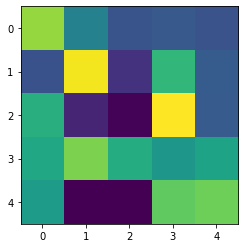

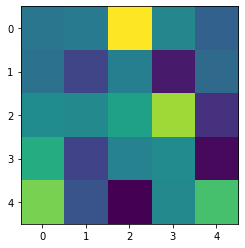

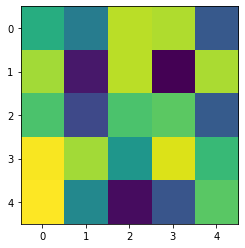

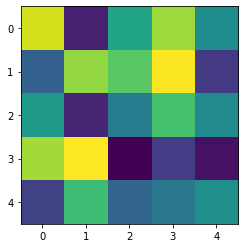

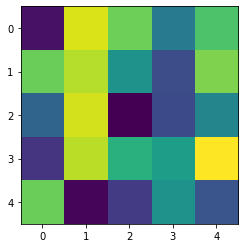

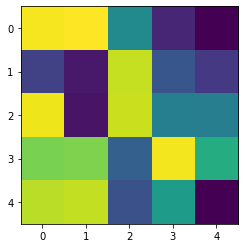

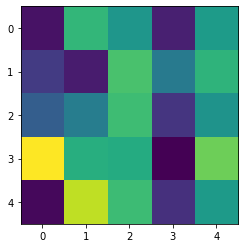

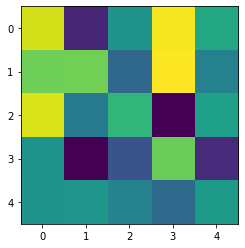

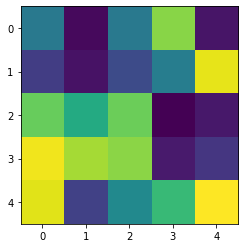

tensor([[[-1.5964e-02, -3.1433e-02, -3.5483e-02, -2.6939e-02, -9.9792e-03],
         [ 3.0339e-03, -3.2841e-02, -1.5710e-02, -5.4513e-03, -1.2629e-02],
         [ 3.5056e-02, -4.1121e-02,  2.7352e-02,  1.0222e-02,  6.7042e-03],
         [-2.7015e-02, -2.1758e-02, -3.0788e-02, -2.1632e-02,  3.7534e-03],
         [-2.5027e-02,  3.4992e-02,  3.1059e-02, -2.6758e-02, -1.2189e-02]],

        [[ 9.0557e-03,  1.8493e-02, -3.1214e-02, -1.1346e-02,  2.0060e-02],
         [-2.4900e-02, -2.4820e-04, -1.2984e-02, -3.8400e-02,  3.8966e-03],
         [-3.3432e-02, -5.1575e-03,  7.3454e-03,  2.3768e-02, -3.3346e-02],
         [-2.2537e-02, -3.9831e-02,  1.1579e-02, -3.4710e-02,  5.4521e-05],
         [-2.2639e-02, -7.4198e-03, -9.2408e-03, -1.0525e-02, -1.0773e-02]],

        [[-1.2893e-02, -6.7572e-03,  1.6235e-02,  1.8915e-02, -1.5980e-03],
         [-1.0318e-02,  2.5729e-02,  2.0451e-02, -1.9081e-02,  1.5158e-02],
         [ 3.8343e-02, -2.2157e-05,  2.1351e-03, -3.8447e-02, -2.2673e-02],
        

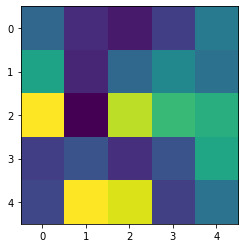

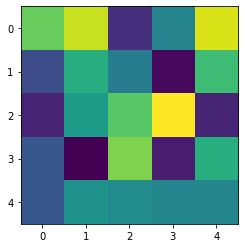

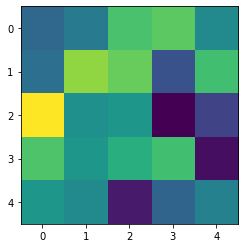

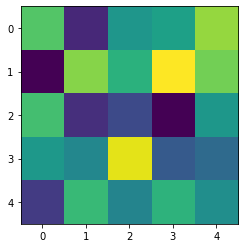

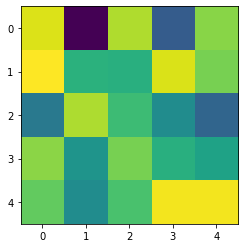

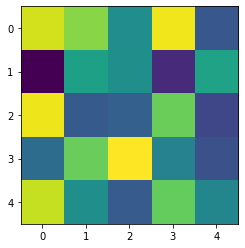

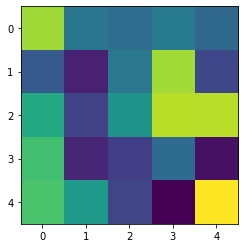

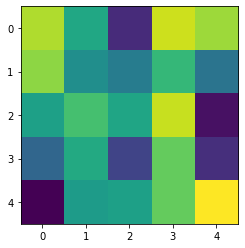

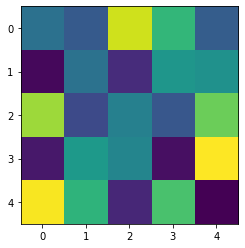

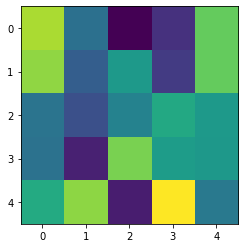

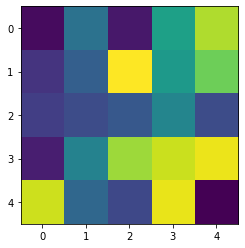

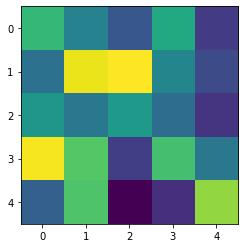

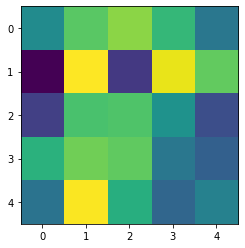

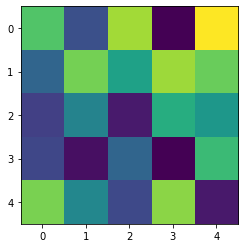

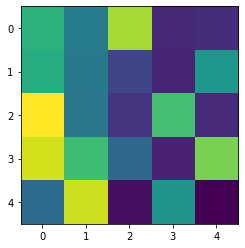

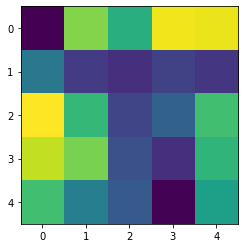

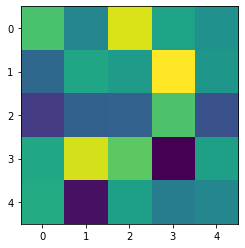

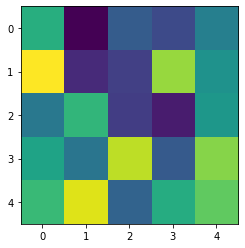

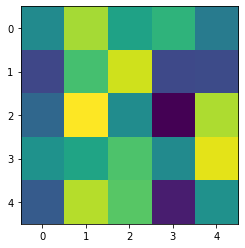

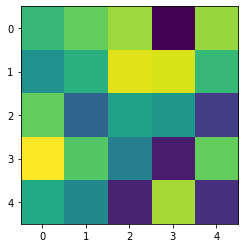

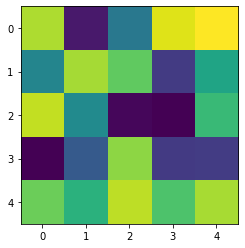

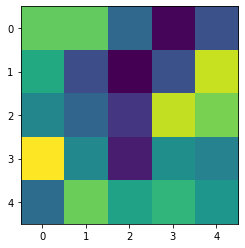

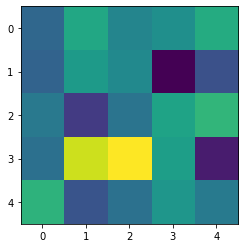

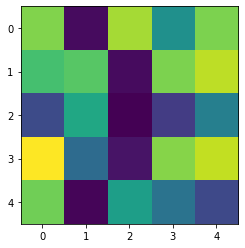

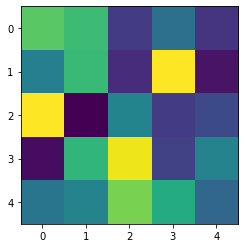

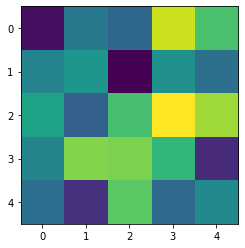

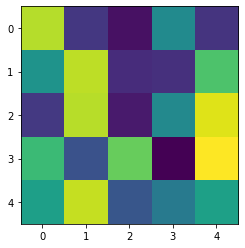

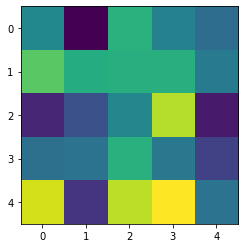

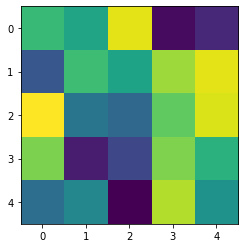

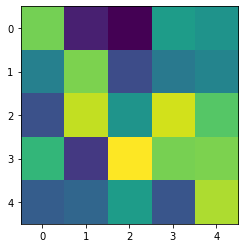

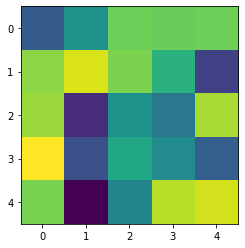

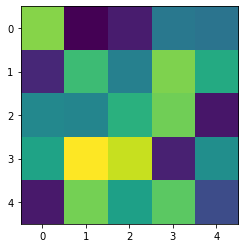

tensor([[[-3.2801e-03, -9.7215e-03, -1.9411e-02, -2.8461e-02, -2.4815e-03],
         [ 2.7914e-02,  2.4098e-02, -7.1773e-03, -3.7757e-02, -4.0586e-02],
         [ 2.5530e-02, -2.0618e-02,  7.6085e-03, -7.7997e-03, -2.0634e-02],
         [ 1.7393e-02, -3.0021e-03,  1.0907e-02,  7.2719e-04,  1.0934e-02],
         [ 3.6584e-03, -1.4414e-02, -1.7965e-02, -2.1412e-02,  1.8161e-02]],

        [[-1.0979e-02,  1.4306e-04,  2.8960e-02, -8.6399e-03, -2.4077e-02],
         [ 2.1555e-02, -2.5062e-02, -2.1273e-02, -1.6788e-02, -2.8362e-02],
         [-2.1445e-03, -5.7243e-03, -1.1257e-02,  1.4692e-02,  1.9770e-02],
         [-2.3164e-02, -6.4573e-03,  1.8072e-02, -2.5177e-02,  1.2168e-02],
         [ 1.1977e-02, -1.8942e-02,  2.5908e-02,  1.9323e-02, -3.1429e-02]],

        [[-1.6144e-02,  4.1037e-03,  6.4793e-03,  1.6465e-02, -8.1006e-03],
         [-9.5509e-03,  1.4570e-04,  8.9255e-03, -8.6228e-03, -1.3588e-02],
         [-1.9034e-02, -1.1655e-02, -9.3682e-04, -3.0932e-02, -1.5655e-02],
        

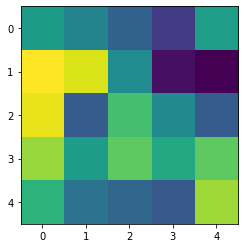

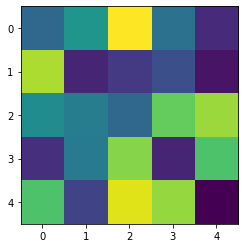

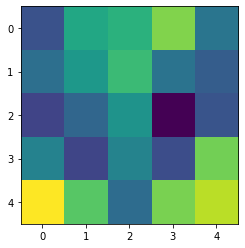

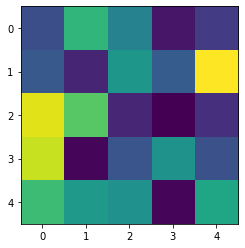

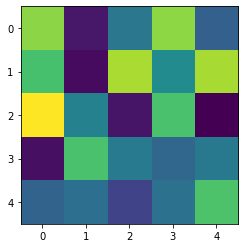

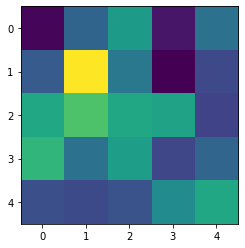

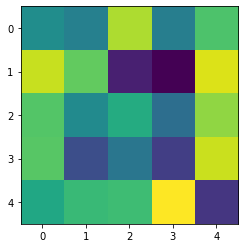

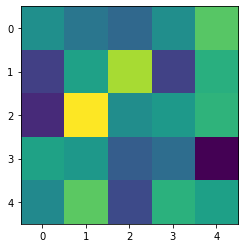

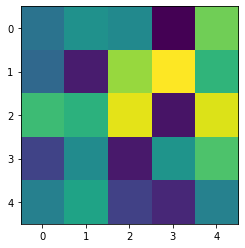

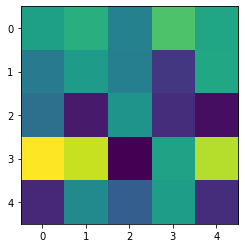

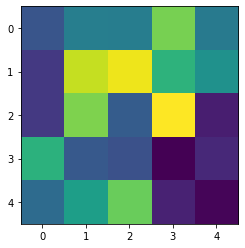

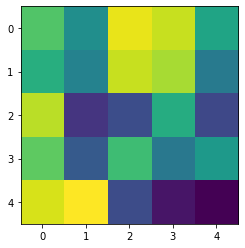

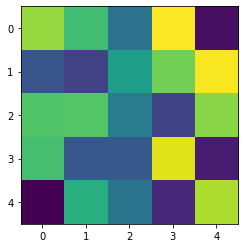

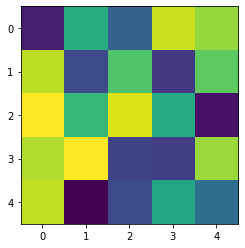

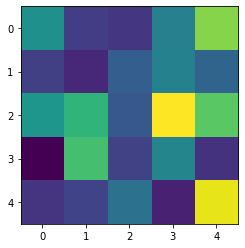

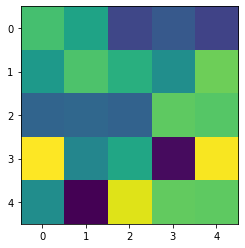

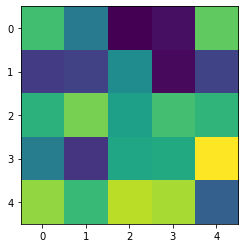

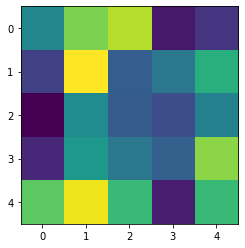

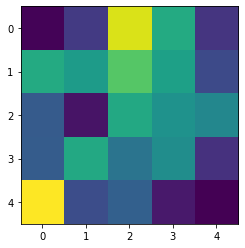

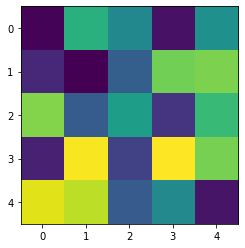

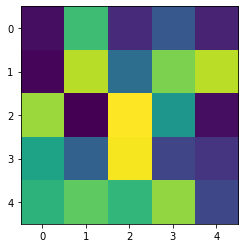

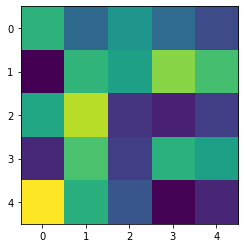

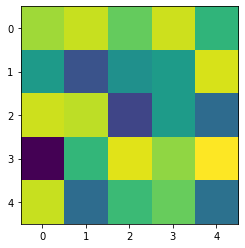

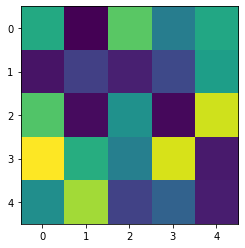

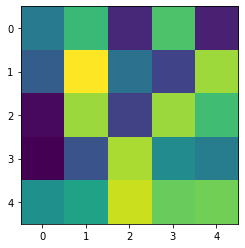

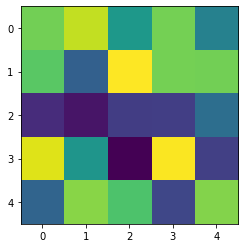

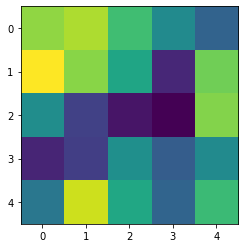

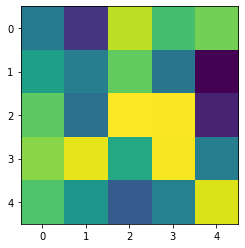

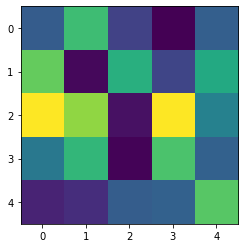

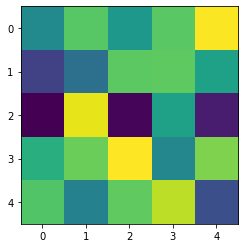

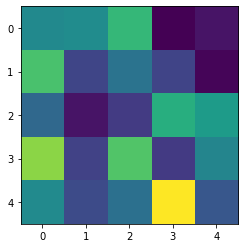

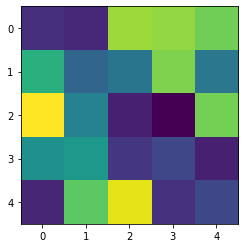

tensor([[[-4.4901e-02, -2.4216e-02, -1.7790e-03, -4.5003e-02,  1.1701e-02],
         [-2.0516e-02, -7.5539e-03, -2.5184e-02, -6.5014e-02,  2.7165e-02],
         [-6.0884e-02, -5.7782e-02, -6.3421e-02, -2.8794e-02,  2.8483e-02],
         [ 5.7874e-03, -7.2944e-02, -1.3224e-02,  3.1912e-02, -1.1947e-02],
         [-2.5772e-02, -6.7430e-02, -1.0373e-02,  3.6767e-02, -1.2398e-02]],

        [[-6.0789e-02, -1.8569e-02,  1.9244e-02, -3.3683e-02, -8.2085e-03],
         [-7.1389e-02, -4.4837e-02, -3.2597e-04, -5.8394e-02, -5.0359e-02],
         [-7.2054e-02, -6.1776e-02, -4.2367e-02, -4.9932e-02, -6.9043e-03],
         [-3.9768e-02, -2.3555e-02, -2.4374e-02, -4.4888e-02, -2.8718e-02],
         [-4.8510e-02, -3.1096e-02, -3.2638e-02, -5.9072e-02, -6.4049e-02]],

        [[-2.4098e-02,  4.9453e-03, -2.0263e-02,  3.6848e-02, -5.0178e-03],
         [ 7.9683e-03,  1.0345e-02, -1.8576e-02, -7.1787e-02, -6.3897e-02],
         [ 1.4399e-02,  8.6244e-02,  9.0921e-02,  3.9351e-02,  1.0217e-02],
        

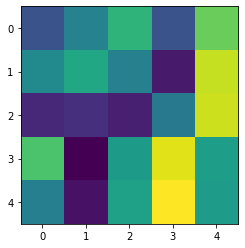

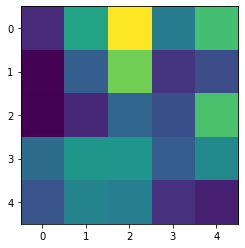

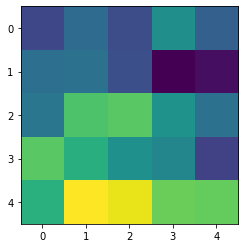

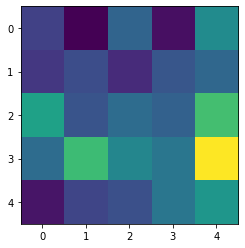

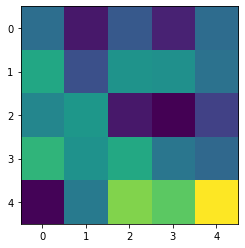

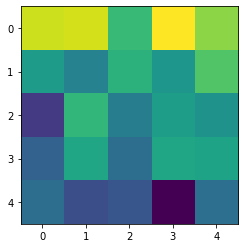

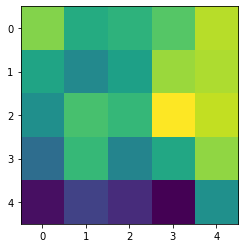

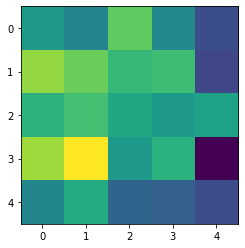

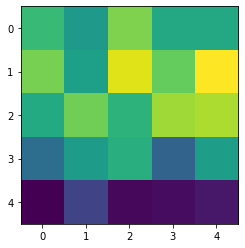

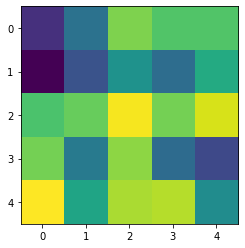

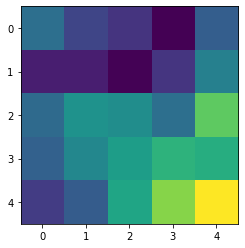

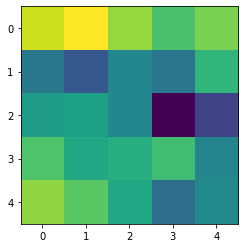

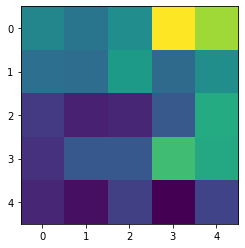

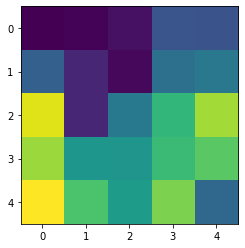

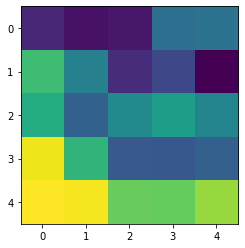

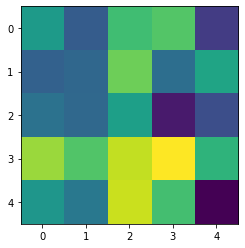

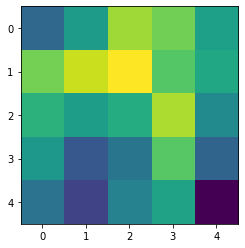

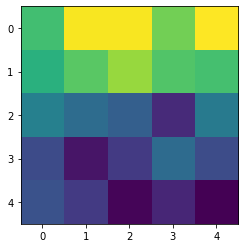

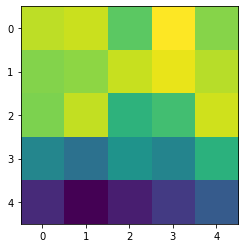

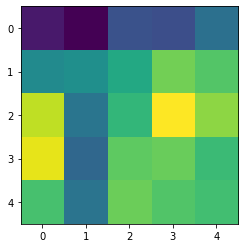

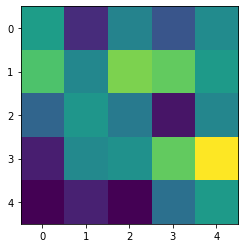

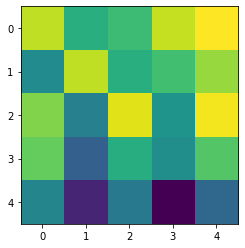

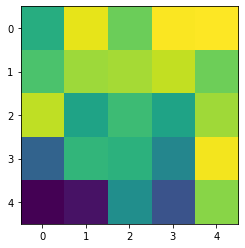

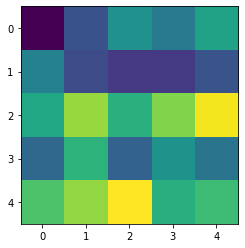

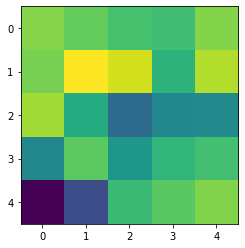

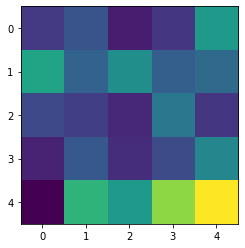

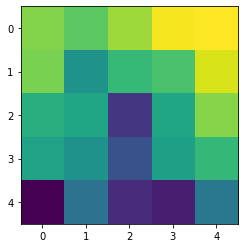

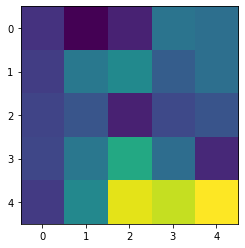

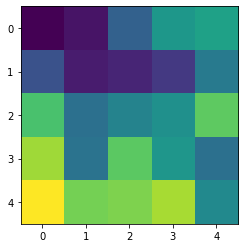

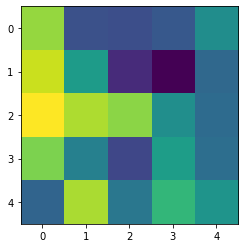

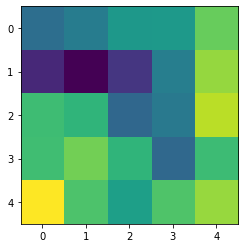

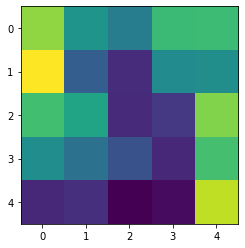

tensor([[[ 4.7558e-02,  9.4311e-04, -2.2067e-02, -4.0659e-02, -1.0036e-03],
         [ 2.1679e-02, -5.0260e-02, -3.9370e-02,  1.1595e-03, -1.8445e-02],
         [ 3.4141e-02, -5.3132e-02, -1.5167e-02,  2.8499e-02, -3.8887e-02],
         [ 9.3993e-02, -3.5022e-02, -2.8003e-02,  6.7582e-02, -3.4089e-02],
         [ 7.8178e-02, -4.0169e-02, -7.3920e-02,  5.4550e-02, -2.0719e-02]],

        [[-1.9510e-02, -9.9033e-03, -4.7175e-03,  1.2942e-03,  8.0662e-03],
         [-7.2544e-03, -2.7438e-02,  2.1431e-03, -2.9565e-02,  1.5794e-02],
         [-4.1714e-02, -4.0852e-02, -3.3081e-02, -1.6452e-02, -4.2805e-02],
         [-1.3283e-02, -6.3919e-02, -4.5254e-02, -8.8723e-03, -5.0397e-02],
         [-3.9651e-02, -2.9534e-02, -5.4176e-02, -5.9479e-02, -2.2190e-02]],

        [[ 1.2005e-02,  1.8031e-02,  1.6751e-02,  2.3598e-02, -3.9802e-02],
         [ 1.6328e-02,  3.9121e-02, -5.9645e-03,  4.6418e-02, -1.6174e-02],
         [ 4.4929e-02,  3.9170e-02,  6.0928e-03, -1.9094e-02, -3.4684e-02],
        

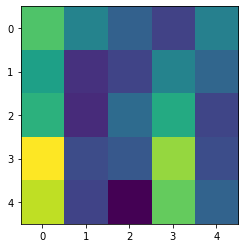

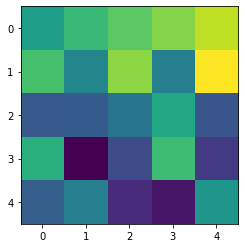

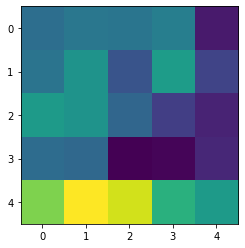

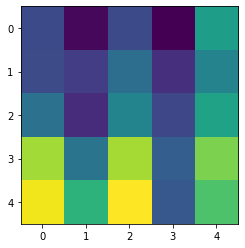

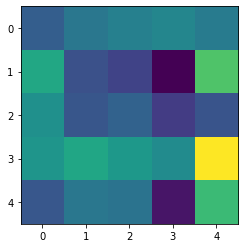

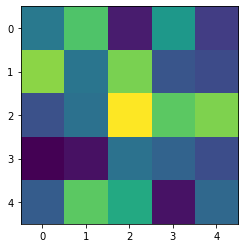

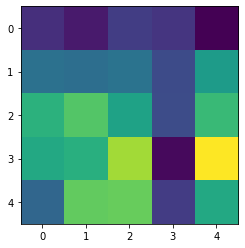

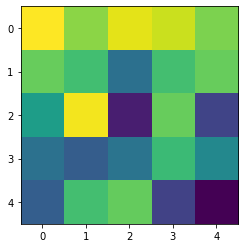

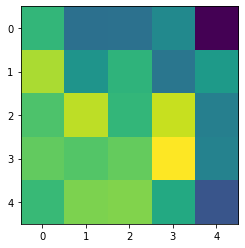

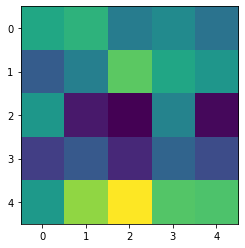

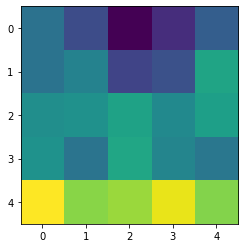

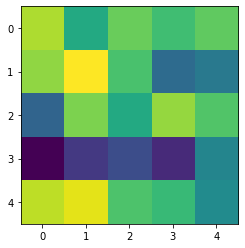

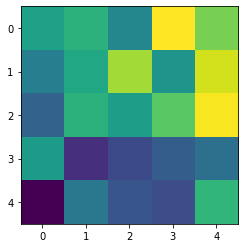

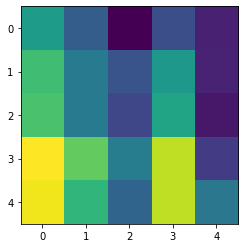

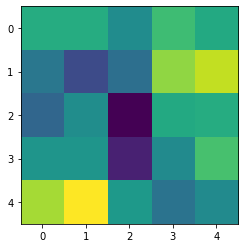

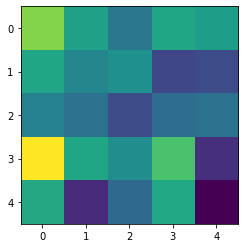

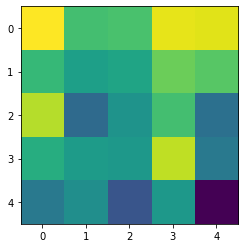

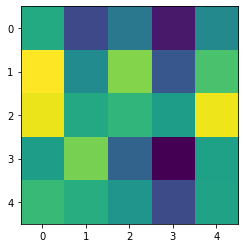

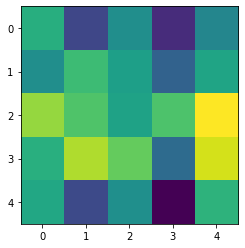

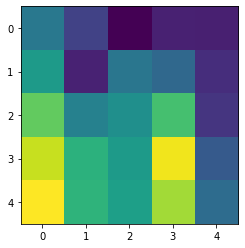

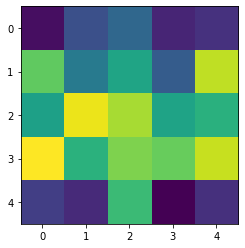

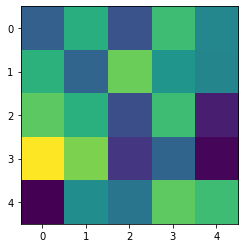

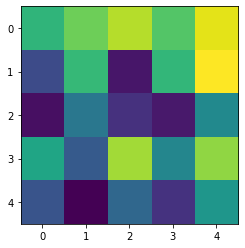

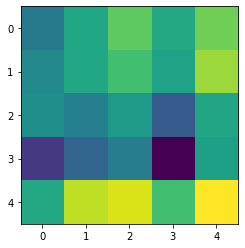

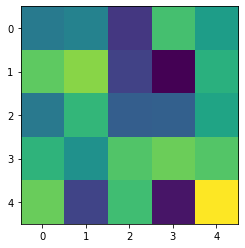

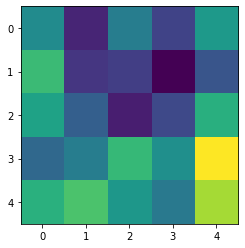

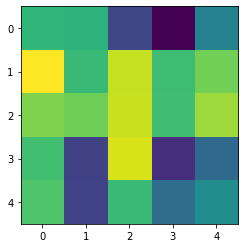

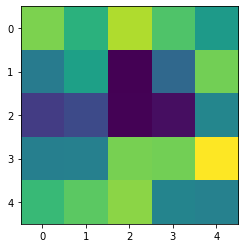

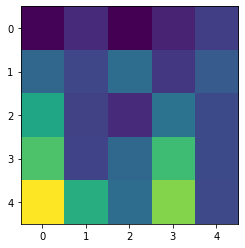

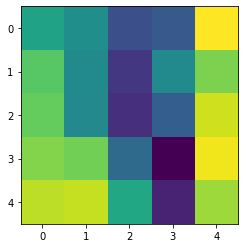

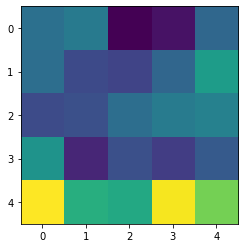

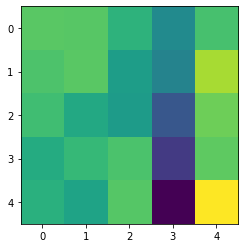

tensor([[[ 1.8045e-02,  2.2854e-02, -9.2341e-03,  2.6242e-02, -2.6278e-02],
         [-2.0570e-02, -5.8765e-02, -8.2711e-03, -2.3998e-02, -2.7830e-02],
         [-3.8053e-02, -3.5851e-02, -1.7991e-03,  3.8651e-02,  5.0163e-02],
         [ 2.0808e-02,  4.8128e-02,  2.8247e-02,  1.7471e-02,  8.0807e-02],
         [ 1.1995e-02,  3.2635e-02,  9.5444e-03, -3.9314e-02,  3.7487e-03]],

        [[ 9.0083e-02,  7.2098e-02,  7.6471e-02,  8.6224e-02,  4.7890e-02],
         [ 6.1528e-02,  7.2522e-02,  3.4012e-02,  6.2911e-02,  8.2730e-02],
         [ 7.2882e-02,  3.8276e-02,  7.6131e-03,  4.0736e-02,  2.8761e-02],
         [ 4.2285e-02,  6.0367e-02,  5.0696e-02,  6.1870e-02,  4.4167e-02],
         [ 5.4937e-02,  1.5400e-02,  1.1145e-02,  4.3374e-02,  8.2870e-02]],

        [[-4.0248e-02, -3.4791e-02, -7.0185e-02, -6.1632e-02, -1.5770e-03],
         [-5.0093e-02, -7.2859e-02, -6.4257e-02,  2.0693e-02, -5.0576e-02],
         [-5.9902e-02, -7.2047e-02, -1.4489e-01, -9.7333e-02, -8.5878e-02],
        

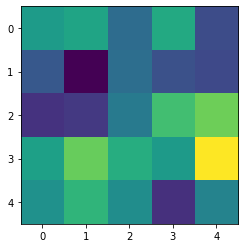

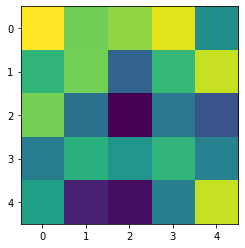

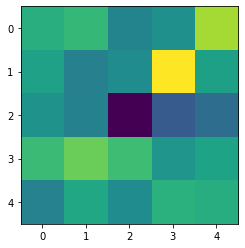

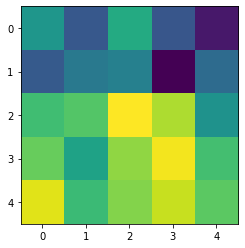

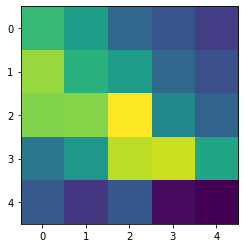

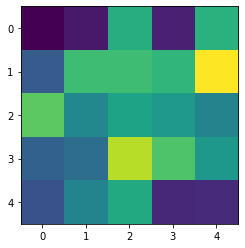

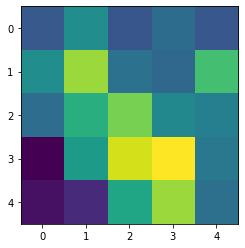

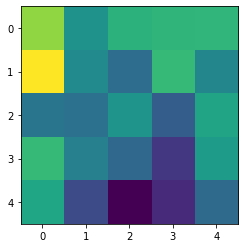

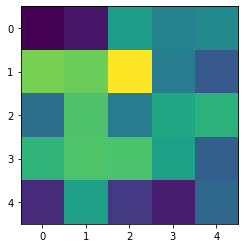

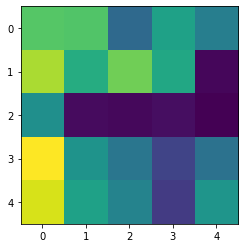

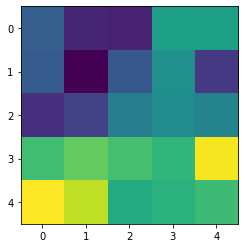

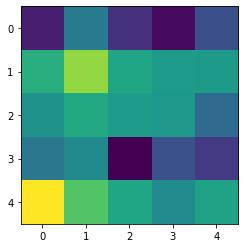

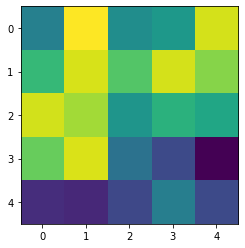

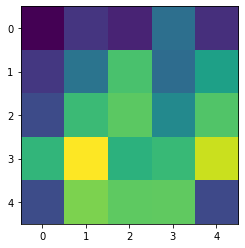

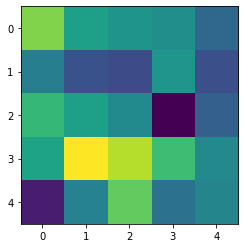

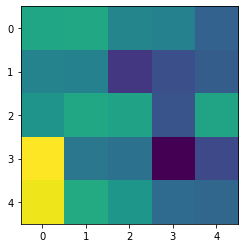

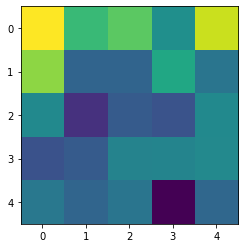

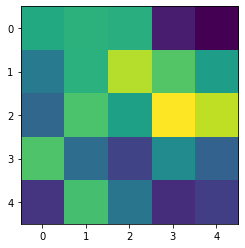

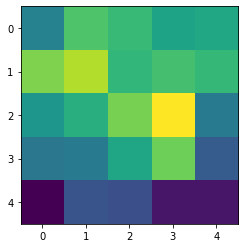

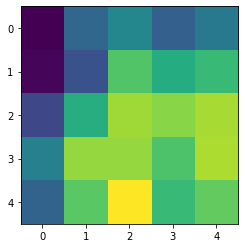

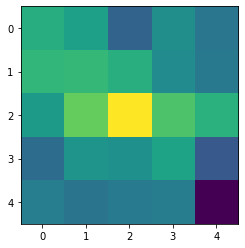

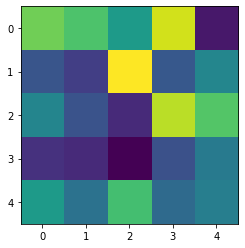

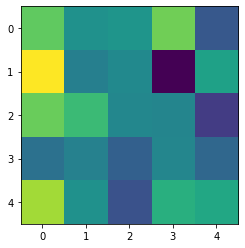

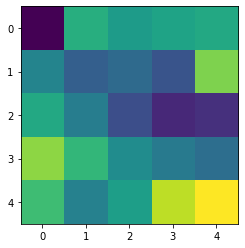

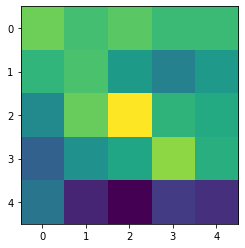

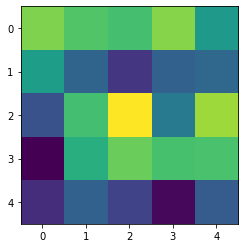

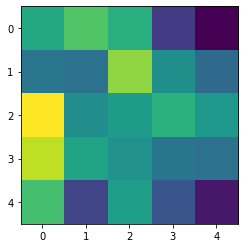

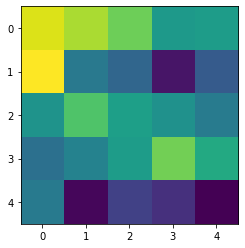

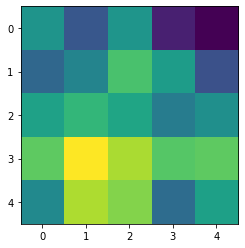

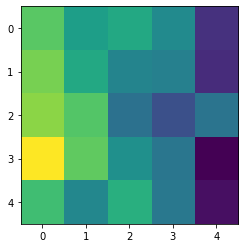

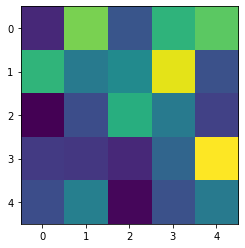

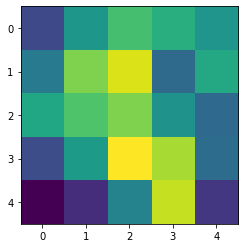

tensor([[[-3.8003e-03, -3.3410e-02, -4.2274e-02, -4.0135e-02, -2.0729e-02],
         [-1.1604e-02, -1.3233e-02, -8.4463e-02, -8.9576e-02, -5.0261e-02],
         [-4.4877e-02, -1.4231e-02, -7.2426e-02, -9.4985e-02,  2.4673e-04],
         [-8.6692e-02, -6.3466e-02, -8.2413e-02, -3.4440e-02, -1.0487e-02],
         [-5.9280e-02, -8.3441e-02, -3.2610e-02, -2.6080e-02,  3.6537e-02]],

        [[ 4.9342e-03, -1.8414e-03,  2.7316e-02,  3.4432e-04,  3.9884e-02],
         [-1.6661e-02, -4.9740e-03, -2.5001e-02,  2.3161e-03,  1.8181e-02],
         [-6.0190e-03,  3.3059e-02, -3.0083e-02,  1.7687e-04,  2.1828e-02],
         [ 9.3503e-03,  1.5867e-02,  3.6219e-02,  3.7484e-02,  1.8437e-02],
         [ 3.7519e-03,  5.8117e-04,  2.0487e-02,  2.4676e-02,  3.8330e-03]],

        [[ 3.7317e-02,  5.1769e-03,  1.1206e-02, -1.1179e-02,  7.9918e-03],
         [ 7.2235e-02,  4.4334e-02,  8.0413e-04,  1.7145e-02,  1.3098e-02],
         [ 2.9230e-02, -4.7073e-04,  1.3567e-02, -1.6772e-03, -4.2278e-02],
        

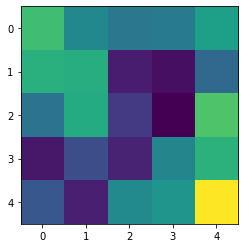

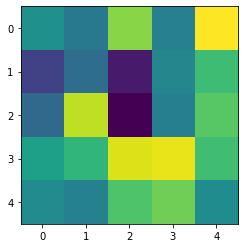

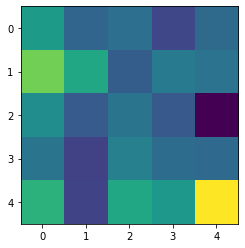

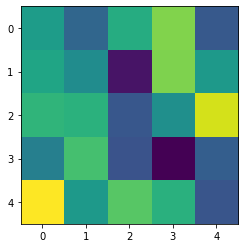

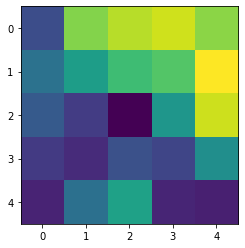

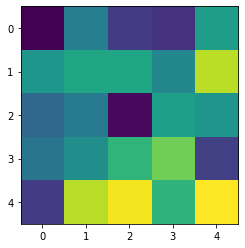

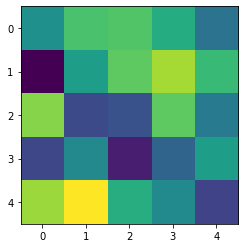

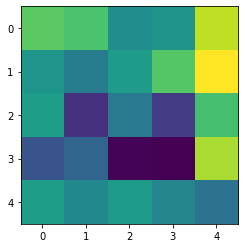

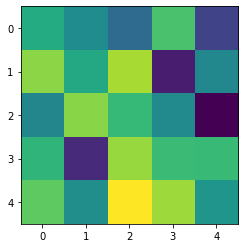

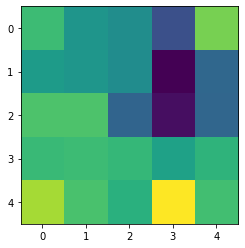

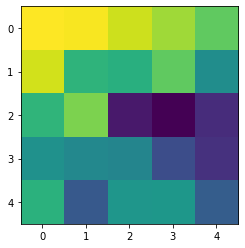

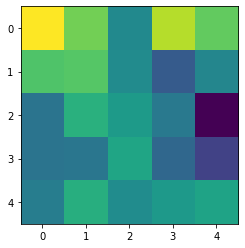

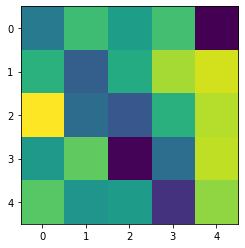

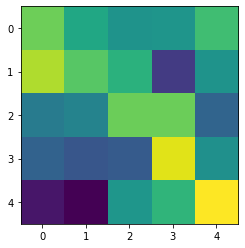

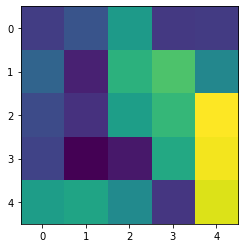

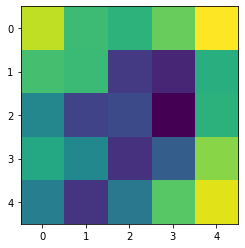

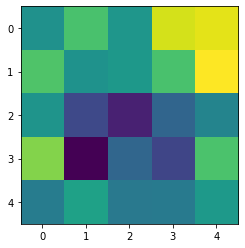

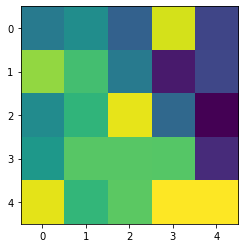

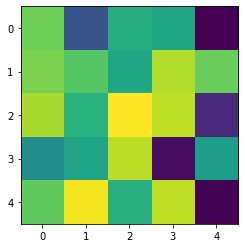

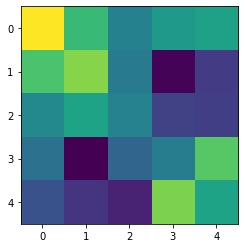

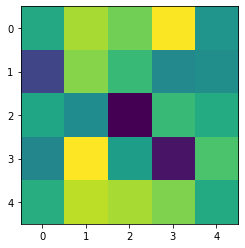

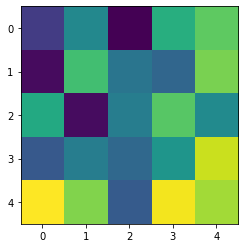

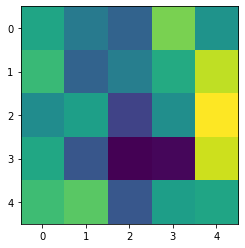

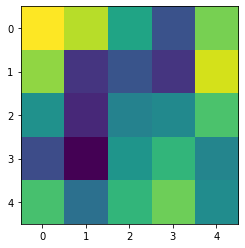

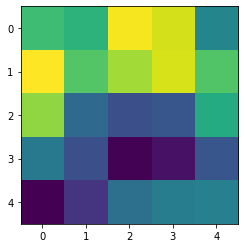

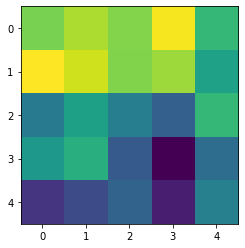

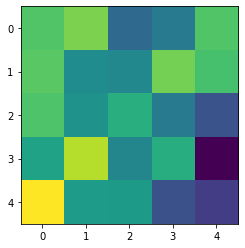

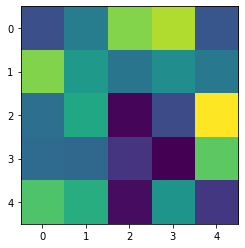

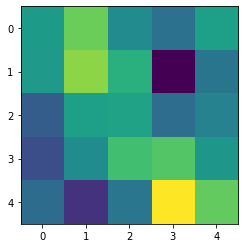

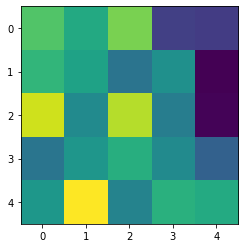

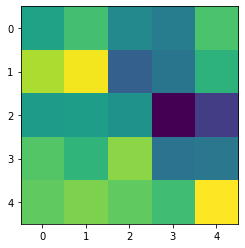

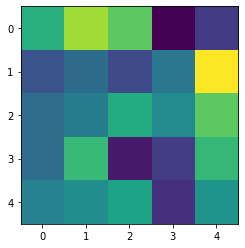

tensor([[[ 9.6703e-02,  5.5083e-02,  6.1499e-02,  5.0973e-03,  9.5435e-02],
         [ 5.2112e-02, -1.2641e-02, -3.1272e-02, -2.8376e-02,  3.8134e-02],
         [ 4.9648e-02, -3.4371e-02, -7.7540e-03, -4.8371e-04,  8.9291e-02],
         [ 3.3761e-02,  1.5224e-02,  9.3499e-03, -1.8218e-02,  1.0237e-01],
         [ 7.1960e-02,  4.5658e-02, -1.2526e-03,  5.9806e-02,  1.5428e-01]],

        [[ 1.5867e-02, -2.8176e-04,  1.8449e-02,  4.1560e-02,  6.6973e-02],
         [ 5.1452e-02,  1.5913e-02,  2.1777e-02, -2.1915e-02, -6.0271e-03],
         [ 3.1360e-02, -2.6868e-05,  2.3113e-02, -1.7067e-02, -2.4579e-02],
         [-1.2021e-02,  6.6986e-03, -3.5593e-02,  7.8568e-04,  1.5947e-02],
         [-1.0166e-02, -2.1000e-02, -1.9328e-02, -1.6519e-02, -3.8208e-02]],

        [[-1.6900e-02, -2.4903e-02, -3.1029e-03, -1.6254e-02,  5.7803e-02],
         [ 8.6208e-02,  7.7960e-02,  6.7419e-02,  2.4028e-02,  5.5415e-02],
         [ 5.7664e-02,  2.1394e-02, -5.7980e-02, -4.7101e-02, -7.2660e-02],
        

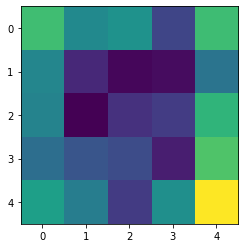

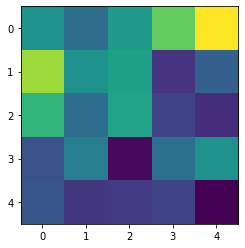

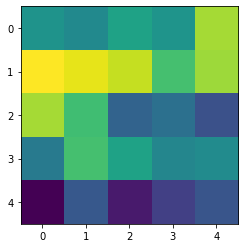

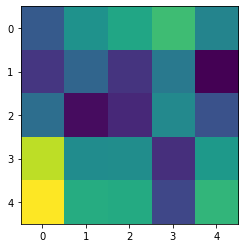

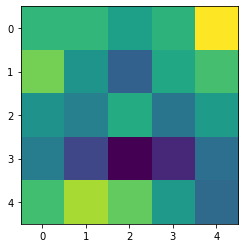

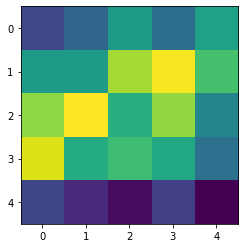

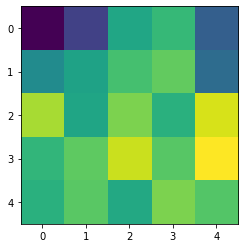

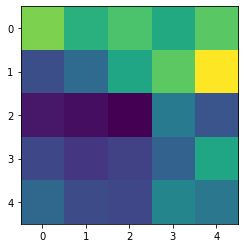

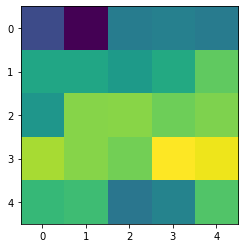

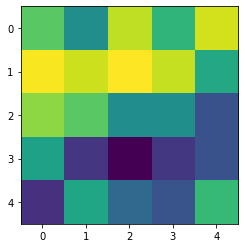

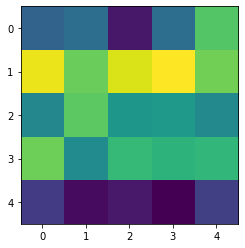

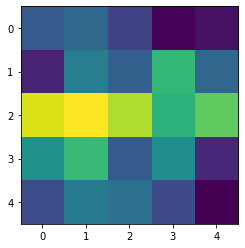

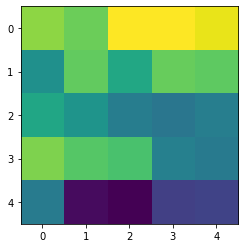

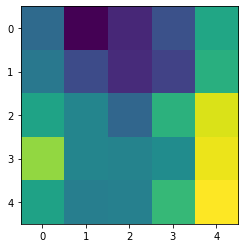

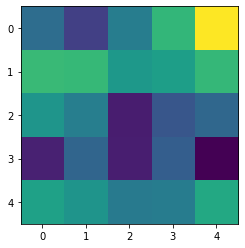

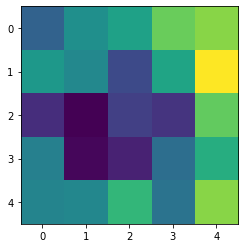

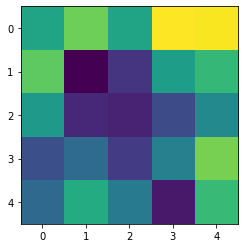

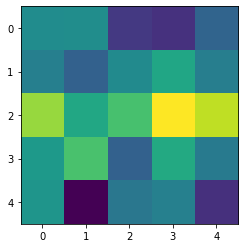

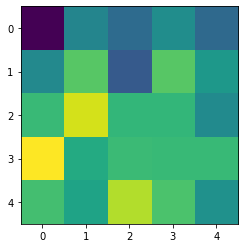

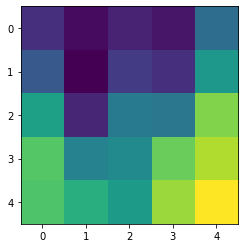

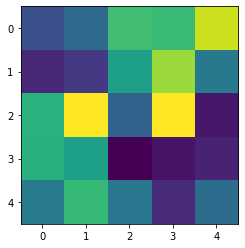

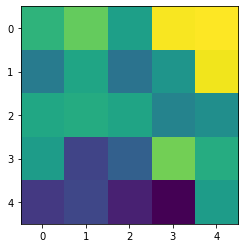

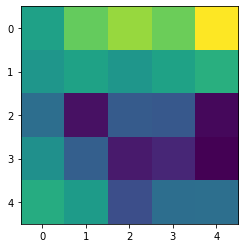

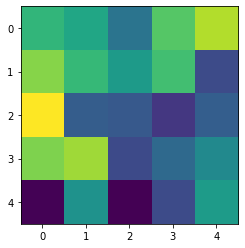

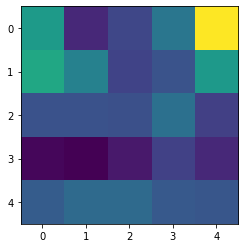

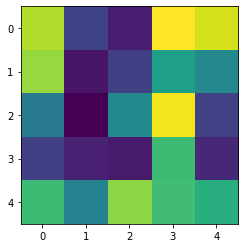

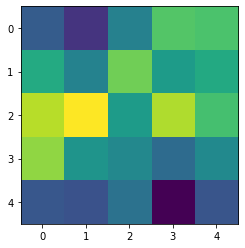

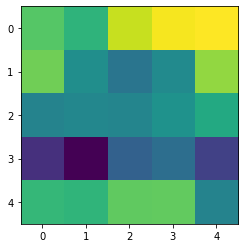

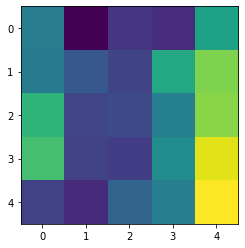

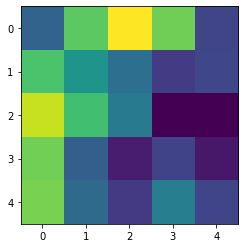

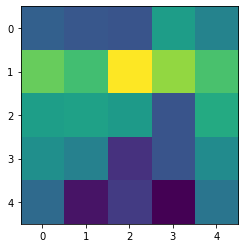

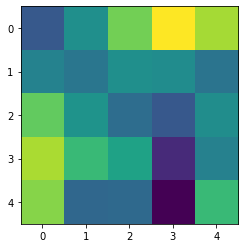

tensor([[[-5.1290e-03,  1.6302e-02,  2.4057e-02, -3.5400e-02,  2.4449e-02],
         [-4.8749e-04,  1.6438e-02, -4.3597e-02,  1.3588e-02, -4.0846e-02],
         [ 3.0095e-03, -4.7375e-02, -1.3172e-02,  7.5177e-03,  1.2652e-02],
         [ 1.3041e-02, -1.8638e-02, -1.3329e-03,  9.4932e-03, -3.5273e-02],
         [ 7.4466e-03,  1.7981e-02, -6.1613e-03, -3.8378e-02,  1.4730e-02]],

        [[-4.6683e-02, -5.1212e-03, -2.4714e-02,  1.6528e-03, -3.9248e-03],
         [ 9.0142e-03, -3.4632e-02, -2.5922e-02,  4.4188e-04, -4.0648e-03],
         [-4.7425e-02, -2.0634e-02, -3.1503e-02, -4.7919e-03, -3.4676e-02],
         [-3.9953e-03, -1.1769e-02, -5.7294e-03, -3.3129e-02, -4.5035e-02],
         [-4.9102e-02,  1.6868e-02, -3.5957e-03, -3.1106e-02, -3.2337e-02]],

        [[ 2.1763e-02, -1.5821e-02, -2.8946e-02, -5.4888e-03,  3.0940e-02],
         [-5.1961e-03, -3.8261e-02, -1.4123e-02, -4.1273e-03, -2.9483e-02],
         [ 2.7535e-03, -1.7915e-02,  3.2648e-02, -1.3849e-02, -3.4802e-02],
        

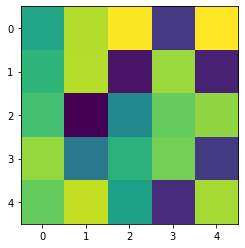

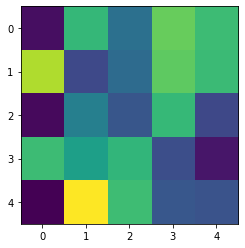

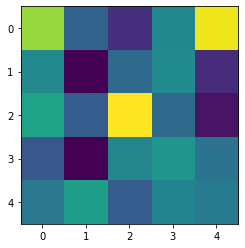

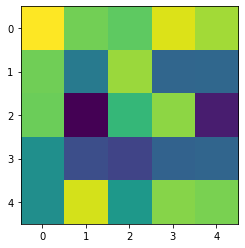

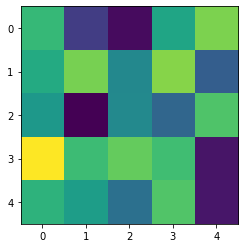

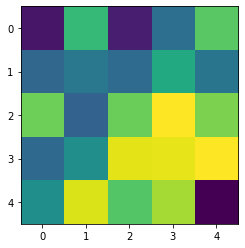

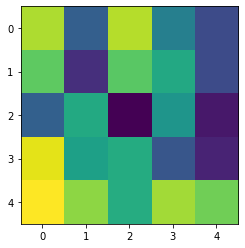

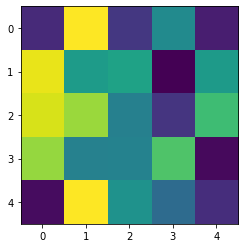

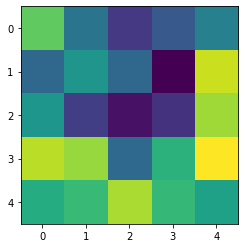

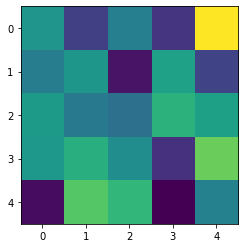

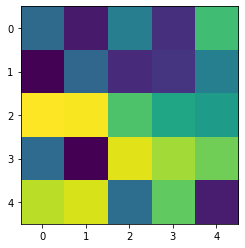

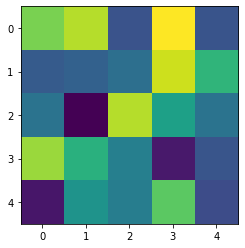

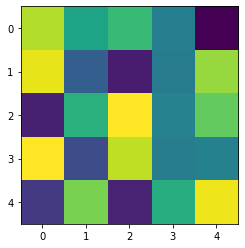

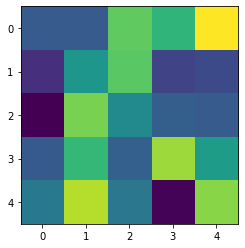

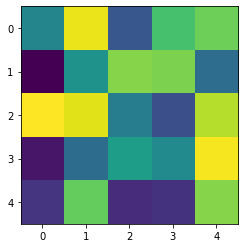

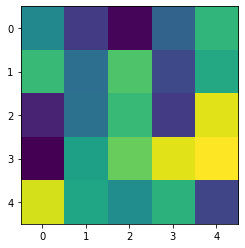

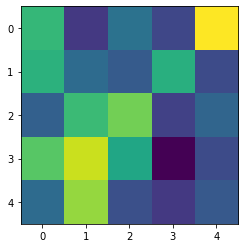

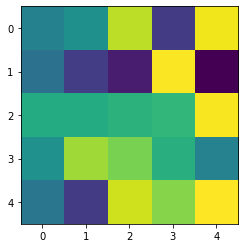

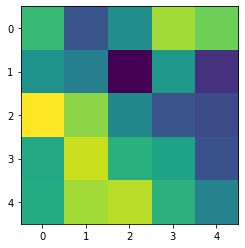

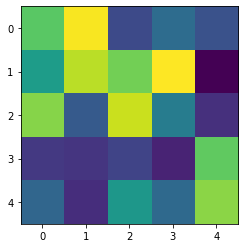

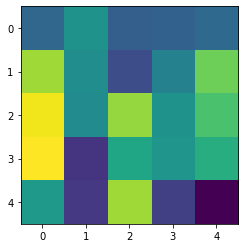

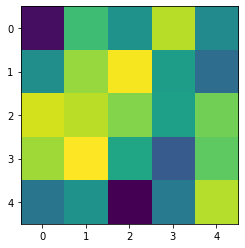

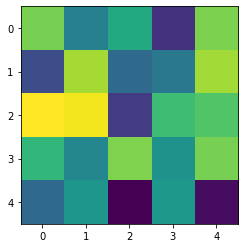

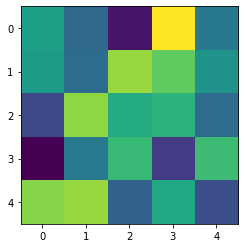

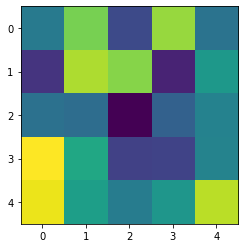

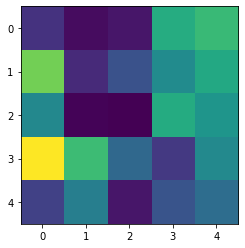

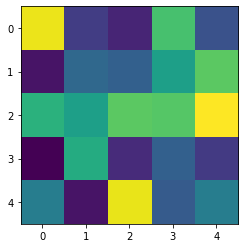

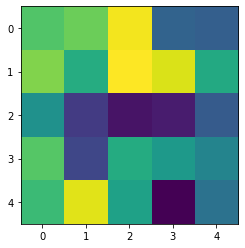

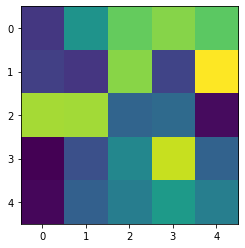

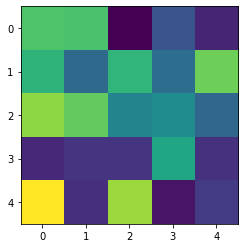

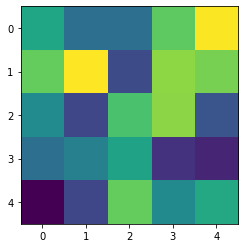

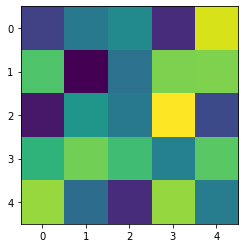

tensor([[[ 2.9743e-03, -1.0559e-02, -3.1764e-02,  2.3960e-02, -3.9298e-02],
         [-3.0306e-02, -1.7686e-04, -5.5526e-03, -2.2855e-02,  1.8616e-02],
         [-3.2325e-02,  5.3018e-03, -2.7529e-02,  2.1638e-02, -4.0660e-02],
         [ 5.1923e-03,  1.1541e-02,  2.5327e-02, -4.1047e-02, -2.5402e-02],
         [ 2.2300e-03, -1.6256e-02, -3.7784e-02, -3.2347e-02, -3.3336e-02]],

        [[ 1.8554e-02, -7.7439e-03, -4.0398e-02, -3.7698e-02, -1.6905e-02],
         [ 9.7351e-05, -1.6050e-02, -6.3315e-03, -2.7066e-02, -2.2290e-02],
         [-2.9293e-02,  2.0748e-02, -1.7456e-02, -8.6800e-03,  1.8658e-02],
         [-1.6299e-02, -1.5242e-02,  1.1852e-02,  2.6528e-02, -5.7613e-03],
         [ 1.8320e-03, -3.2806e-02,  2.1554e-02, -2.1969e-02,  1.9720e-02]],

        [[-3.7512e-02, -2.0795e-02, -3.3045e-02,  1.4424e-02, -1.2734e-02],
         [-2.4310e-02, -2.7761e-02,  7.1622e-03, -1.6258e-02,  8.3031e-03],
         [ 1.0832e-02,  5.5022e-03, -2.3131e-02,  2.7472e-02, -3.4118e-02],
        

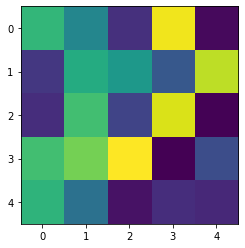

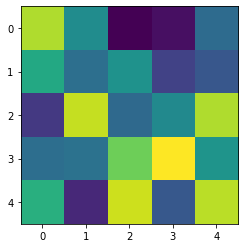

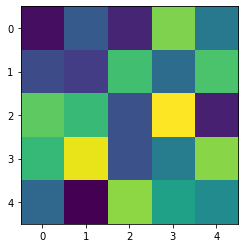

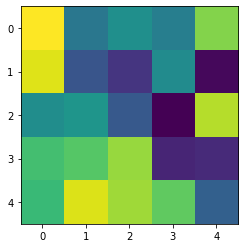

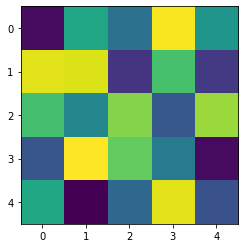

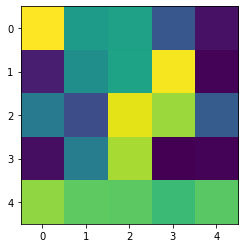

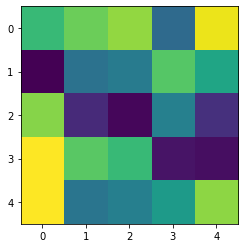

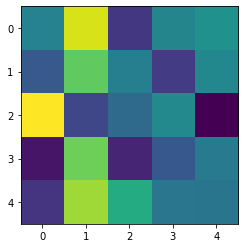

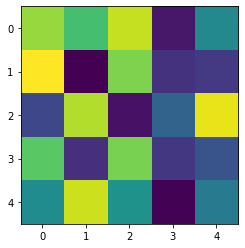

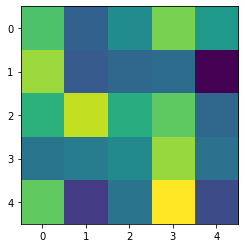

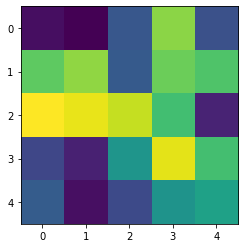

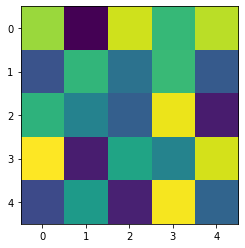

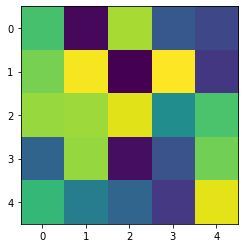

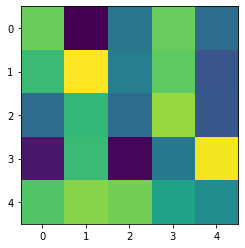

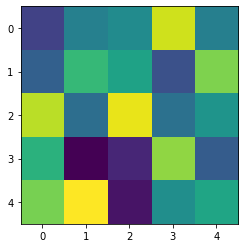

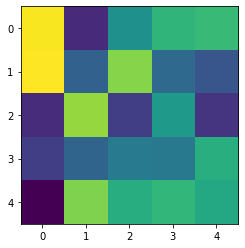

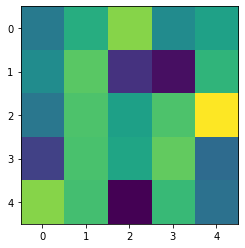

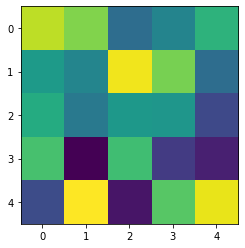

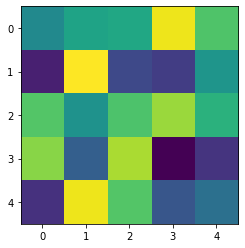

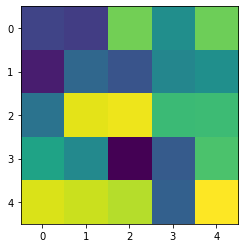

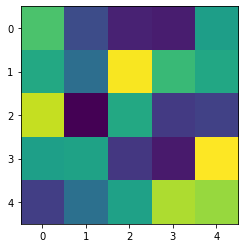

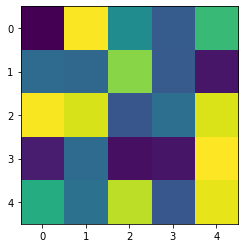

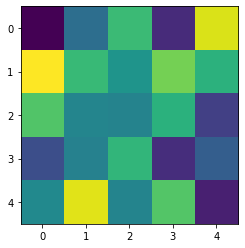

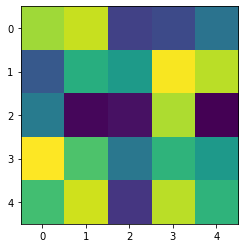

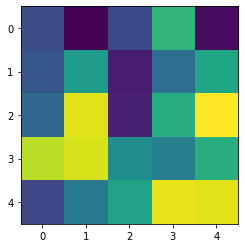

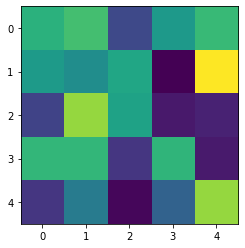

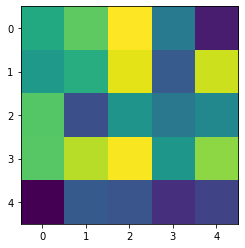

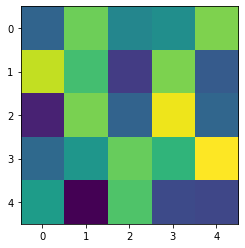

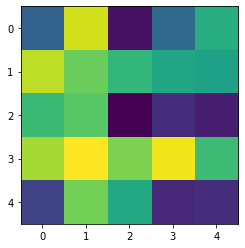

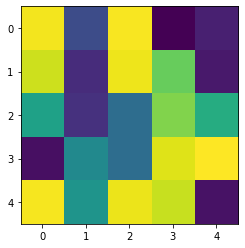

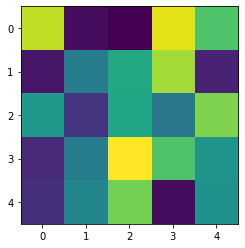

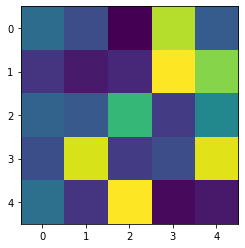

tensor([[[-4.7384e-02,  1.3704e-02, -2.2630e-02, -8.0224e-02, -3.7213e-02],
         [-1.5136e-02, -1.4791e-02, -6.7852e-02, -1.5711e-01,  1.4736e-03],
         [-5.5961e-02, -1.8805e-02, -1.6054e-01, -1.0563e-01, -4.2516e-02],
         [ 3.6771e-02, -1.1897e-02,  3.2557e-02,  1.1834e-04,  4.2718e-02],
         [ 6.4865e-02,  8.3120e-02,  1.1470e-01,  1.8348e-02,  8.6632e-02]],

        [[-6.9964e-04,  2.7969e-02,  8.3447e-03,  4.0049e-02,  1.3064e-02],
         [ 4.1506e-02, -3.5846e-03,  1.2954e-02, -1.3489e-02, -1.4534e-02],
         [ 3.4064e-02,  8.2323e-03, -2.2876e-02, -9.3339e-03,  5.6272e-03],
         [ 5.3264e-02,  2.7929e-02,  2.6052e-02,  1.0301e-02, -7.4680e-03],
         [ 3.8304e-03,  1.1831e-02,  6.8179e-02,  5.4438e-02,  2.2969e-02]],

        [[-1.1577e-01, -1.5634e-01, -2.0125e-01, -1.4625e-01, -7.7801e-02],
         [-2.9578e-02, -8.1295e-02, -4.0074e-02, -1.0761e-01, -5.0133e-02],
         [ 5.8022e-02,  2.2310e-02,  6.9860e-02,  3.0899e-02,  1.0674e-01],
        

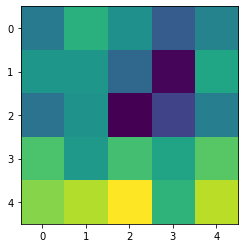

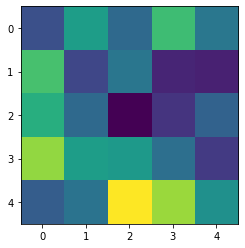

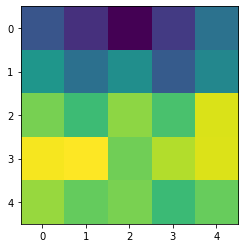

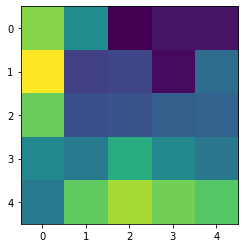

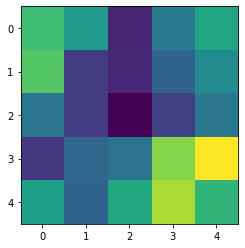

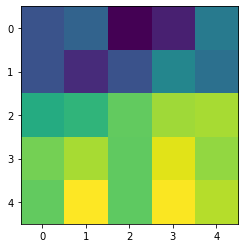

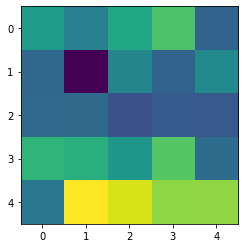

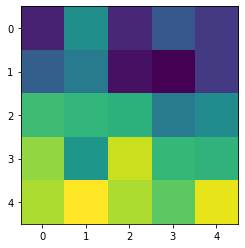

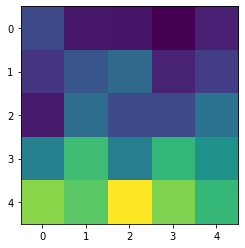

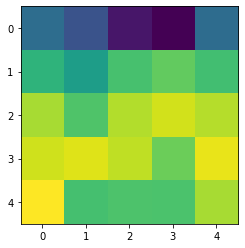

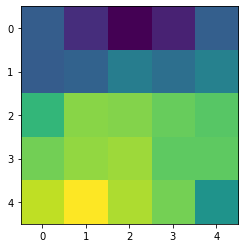

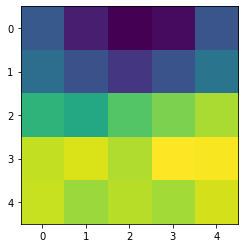

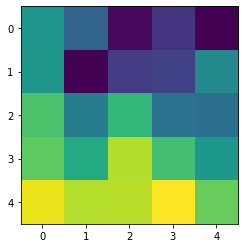

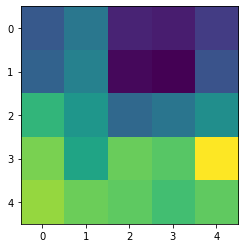

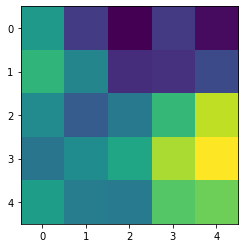

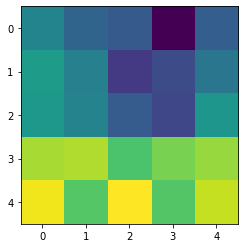

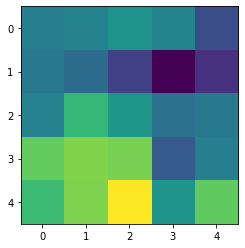

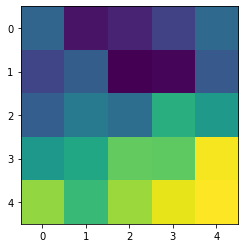

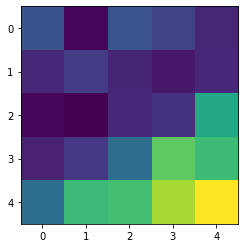

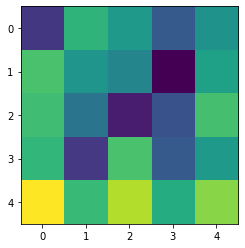

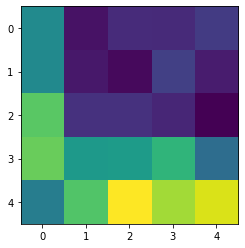

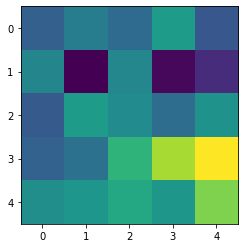

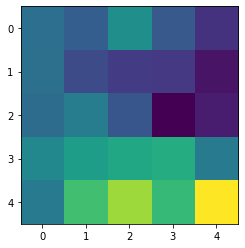

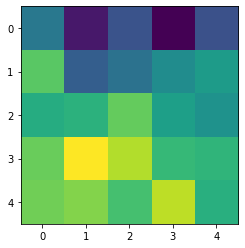

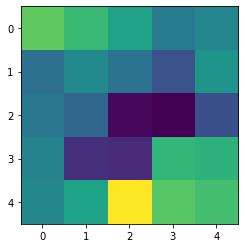

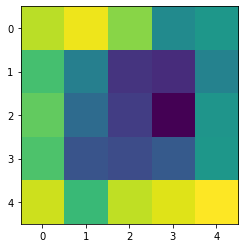

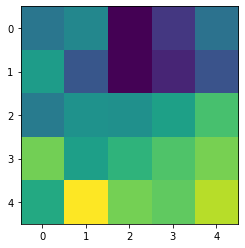

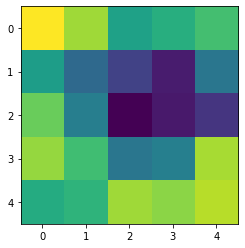

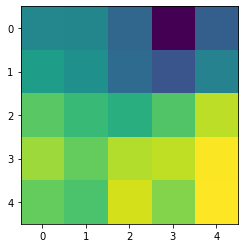

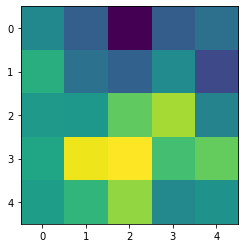

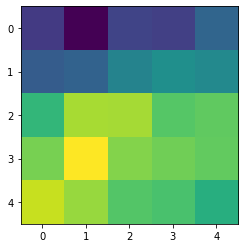

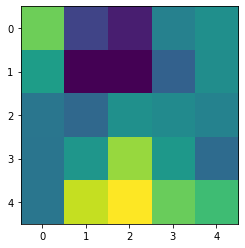

tensor([[[-7.4997e-02, -7.6255e-02, -4.6603e-02,  9.5873e-02,  9.6770e-02],
         [-1.6042e-02, -1.0914e-01, -7.1128e-02,  6.4211e-02,  4.1601e-02],
         [-1.2797e-02, -9.2754e-02, -2.9778e-02,  4.7411e-02,  7.5256e-02],
         [-1.0058e-01, -3.0622e-02, -2.3982e-02, -4.3733e-02,  5.8880e-02],
         [-2.3764e-01, -1.1352e-01, -2.1251e-02, -9.0269e-02, -1.7269e-01]],

        [[-6.1431e-02, -7.0149e-02, -3.5299e-02, -3.3284e-02, -3.3855e-02],
         [-1.7909e-02, -1.4146e-02, -1.8263e-04,  1.0161e-02, -8.6674e-03],
         [-1.4540e-02, -4.9730e-02, -3.2892e-02,  2.2314e-03, -3.5593e-02],
         [-2.3694e-02,  1.2282e-02, -4.6787e-03, -8.9399e-03, -6.3353e-04],
         [-1.8852e-02,  1.0733e-02, -2.0910e-02, -2.6927e-02, -1.4874e-02]],

        [[-3.3572e-02, -8.3933e-02, -9.3446e-02, -7.8375e-02, -7.9026e-02],
         [ 1.9848e-02,  4.2765e-02, -6.4502e-02, -7.6763e-02,  1.0932e-02],
         [ 2.1884e-02, -3.8035e-03, -4.2160e-02, -1.1849e-02, -1.1433e-02],
        

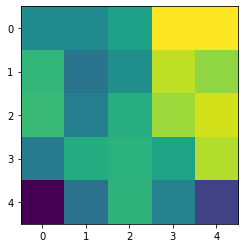

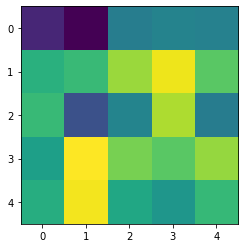

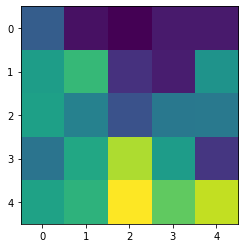

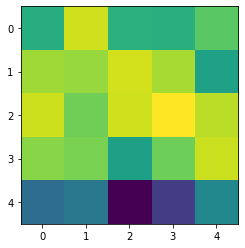

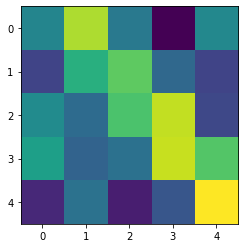

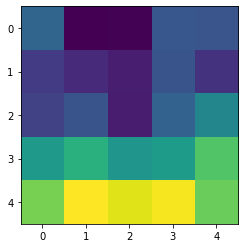

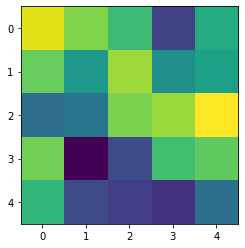

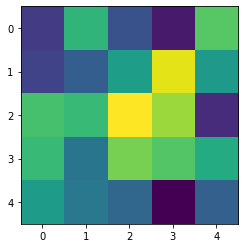

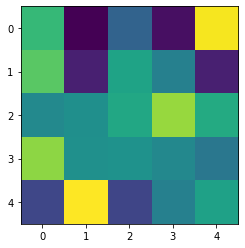

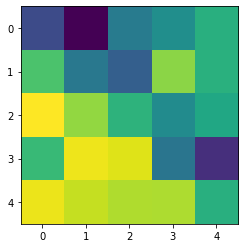

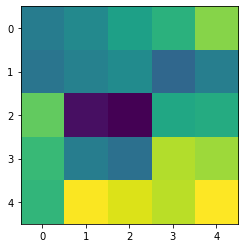

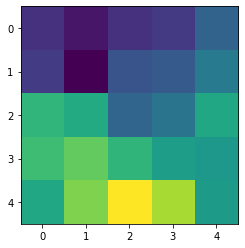

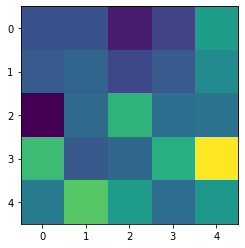

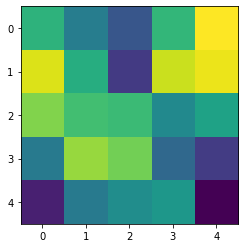

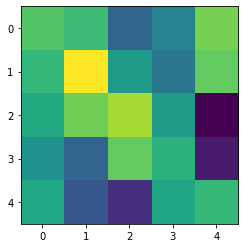

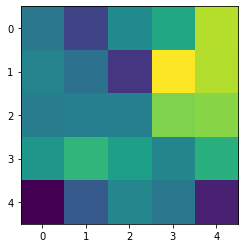

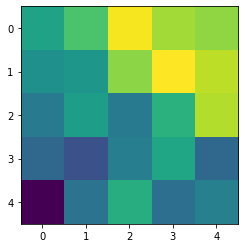

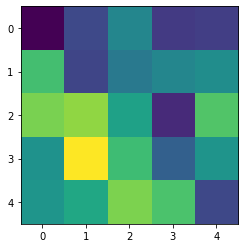

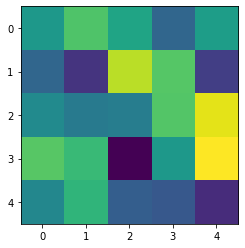

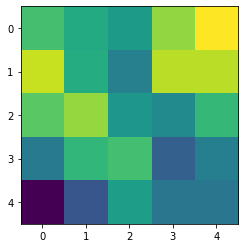

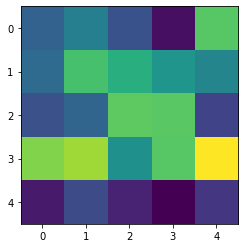

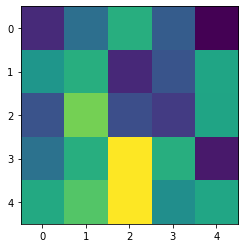

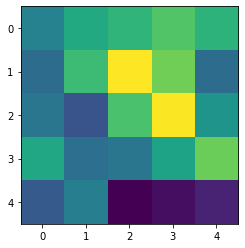

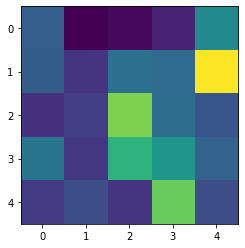

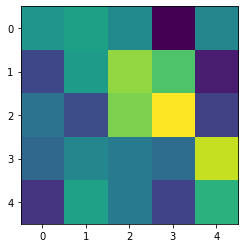

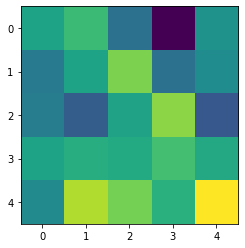

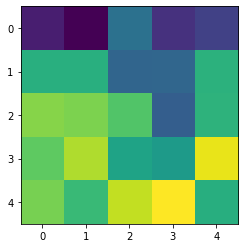

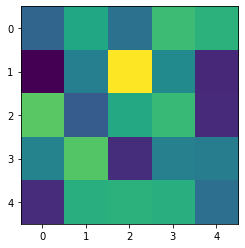

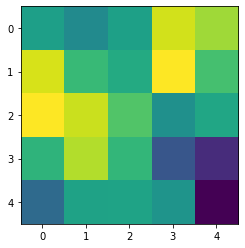

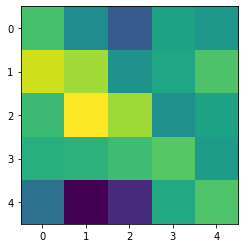

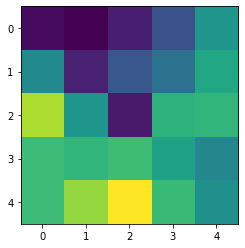

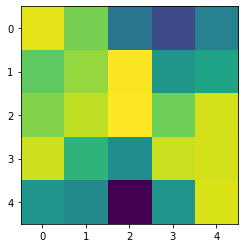

tensor([[[-3.9330e-02, -1.6031e-02, -5.4810e-03,  2.3555e-02,  2.2596e-02],
         [-3.6804e-02, -2.4905e-02,  2.8663e-02,  6.1067e-03,  5.4084e-02],
         [ 3.3073e-02,  6.1189e-02,  5.6232e-02, -3.5244e-03,  5.2713e-02],
         [-3.0602e-03,  1.6534e-02,  3.1652e-02,  1.2346e-02,  1.7750e-02],
         [-1.7363e-02,  3.9844e-02, -2.7872e-02, -7.9074e-03,  5.8352e-02]],

        [[ 2.1961e-02,  3.0885e-02, -2.8389e-02, -2.3913e-02, -5.0681e-02],
         [-3.1782e-02, -2.9821e-04, -6.1954e-03, -2.4348e-02, -3.0651e-02],
         [-2.5014e-02,  1.9872e-02,  5.8589e-03, -8.6632e-03,  3.0510e-02],
         [-5.1762e-03,  2.2613e-02, -1.1608e-02, -1.8502e-02, -3.3198e-02],
         [-3.8145e-02, -3.6981e-02, -2.3277e-02,  2.5580e-02, -5.2937e-02]],

        [[ 3.3697e-02, -2.4224e-02, -3.5971e-02,  1.1193e-02, -3.3242e-02],
         [-1.4836e-02,  1.3293e-02, -1.5098e-02,  7.2356e-03,  1.9695e-02],
         [-1.0381e-02, -2.7287e-02, -2.2739e-02,  5.1763e-03, -1.9111e-02],
        

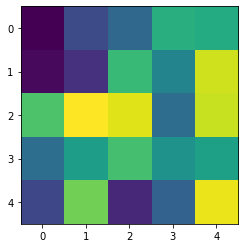

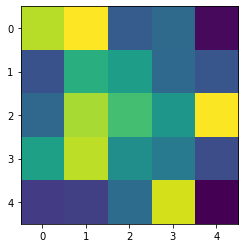

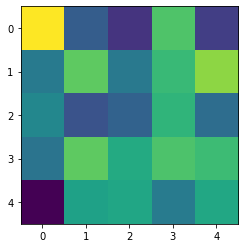

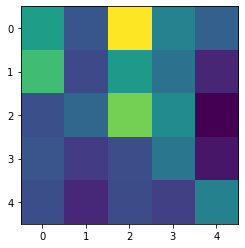

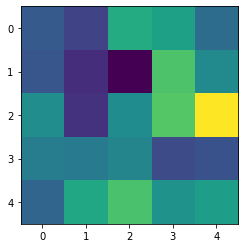

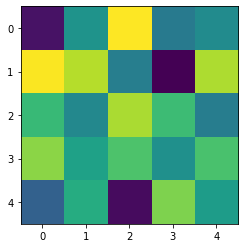

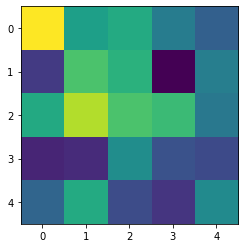

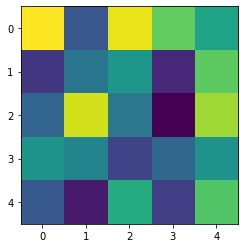

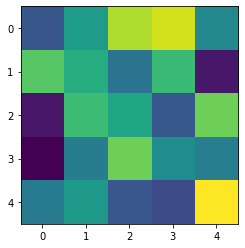

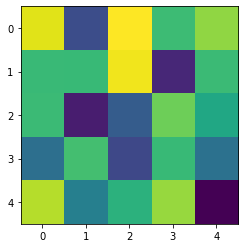

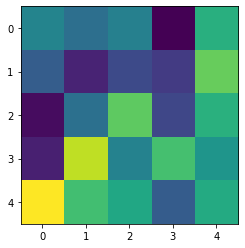

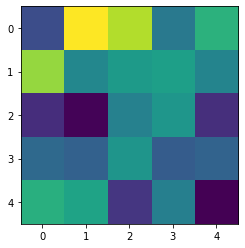

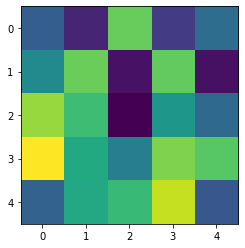

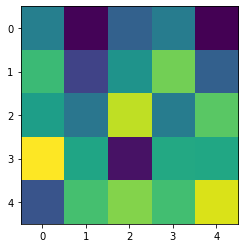

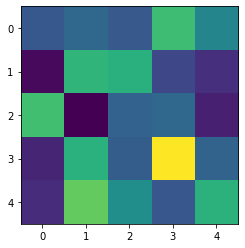

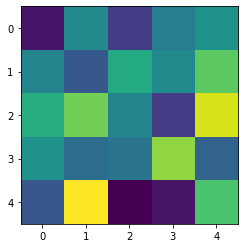

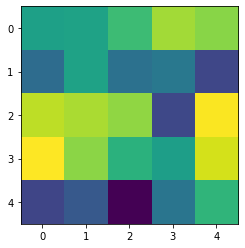

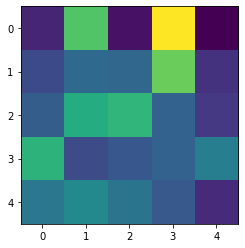

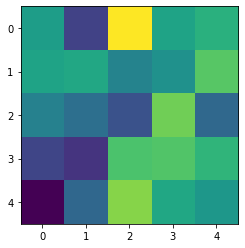

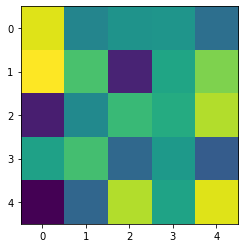

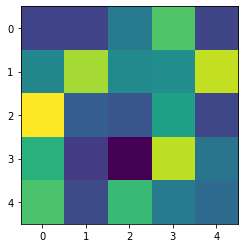

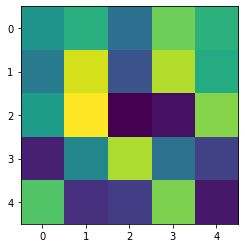

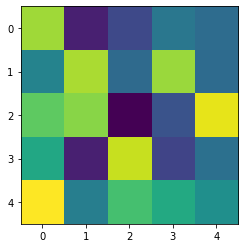

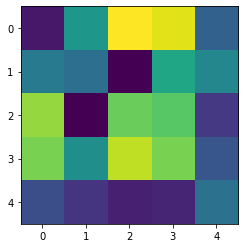

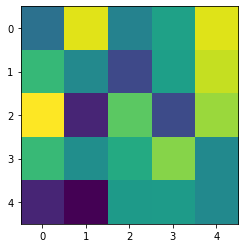

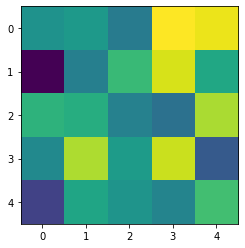

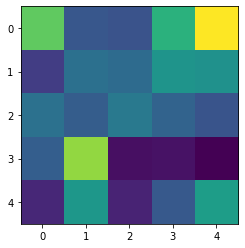

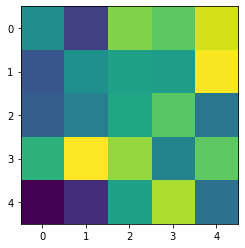

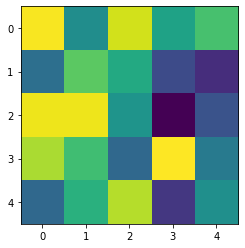

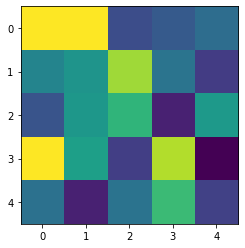

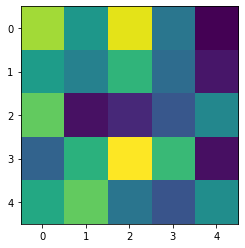

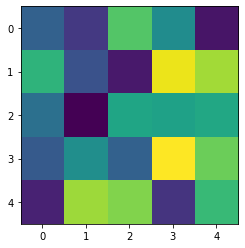

tensor([[[-1.8306e-02,  3.5238e-02,  5.7576e-02,  2.3239e-02,  6.5098e-02],
         [-1.9659e-02,  7.2382e-02,  7.2181e-02,  5.4671e-02,  1.0349e-01],
         [-1.0941e-01, -2.3134e-02, -2.4063e-02,  8.5806e-02,  8.6366e-02],
         [-1.8059e-01, -1.3377e-01, -8.7696e-02,  6.5167e-02,  5.3410e-02],
         [-2.5730e-01, -2.7245e-01, -1.6170e-01, -1.0430e-02, -1.8601e-03]],

        [[ 9.0717e-03,  7.1474e-02,  5.8362e-02,  4.3032e-02,  4.3024e-02],
         [ 4.5884e-02,  4.3096e-02,  3.8964e-02,  1.1764e-02, -4.3266e-03],
         [ 4.4316e-02,  7.4019e-03, -3.1760e-03,  5.6271e-02,  7.7732e-03],
         [ 4.4957e-03,  2.4787e-02,  3.8667e-02, -4.7696e-03,  4.8238e-03],
         [ 1.6264e-02,  2.1095e-02,  3.5885e-02,  4.0484e-02, -2.5012e-02]],

        [[ 6.6813e-02,  8.6434e-02,  1.3612e-01,  1.1061e-01,  1.2832e-01],
         [ 3.2685e-02,  3.0589e-02,  7.1245e-02,  6.0720e-02,  1.2708e-02],
         [ 2.2185e-02, -4.2615e-02, -2.7898e-02,  6.1120e-03,  3.8408e-02],
        

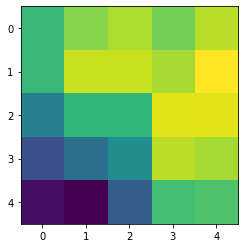

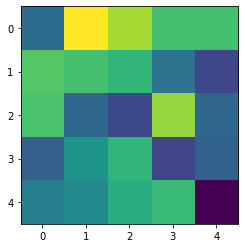

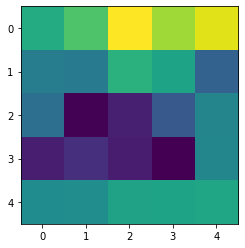

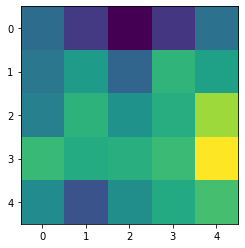

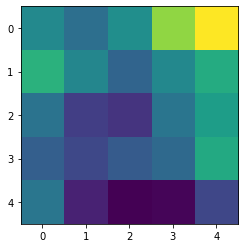

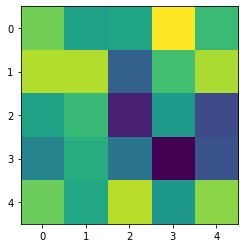

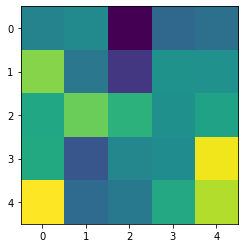

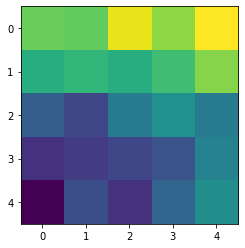

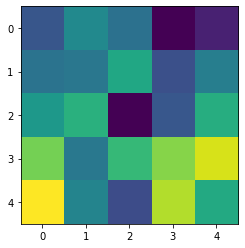

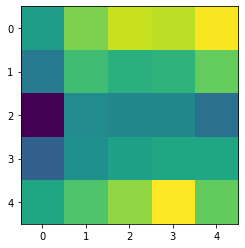

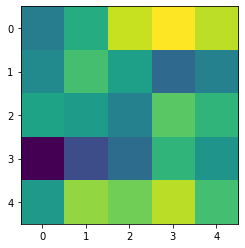

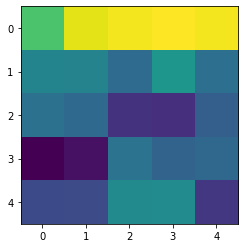

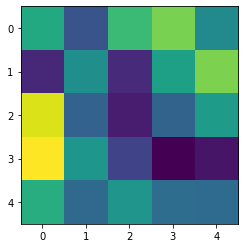

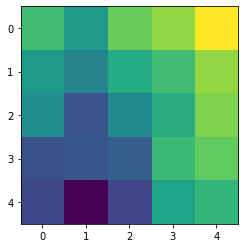

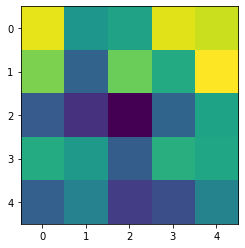

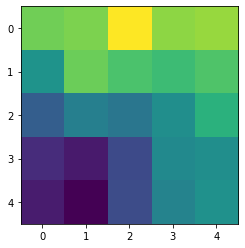

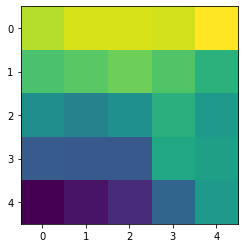

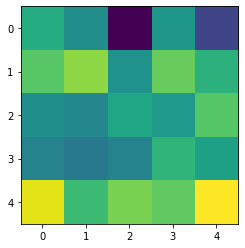

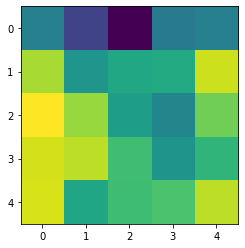

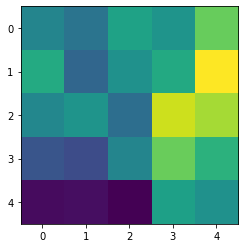

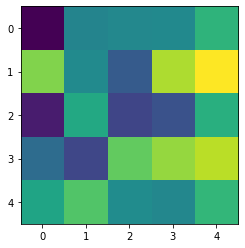

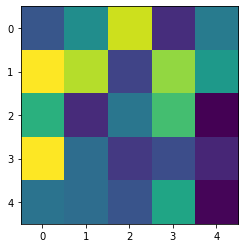

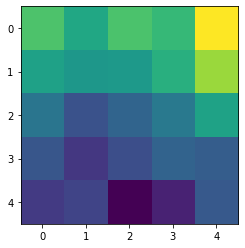

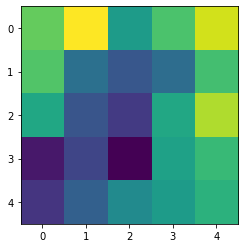

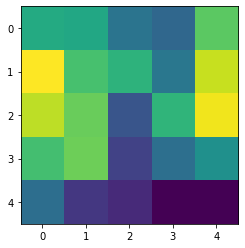

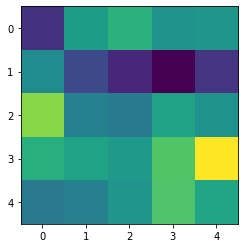

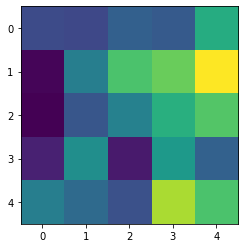

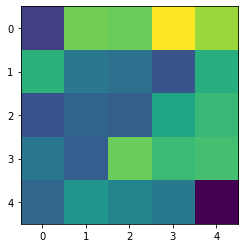

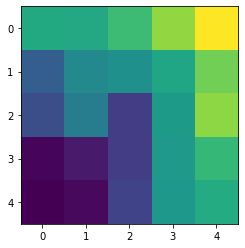

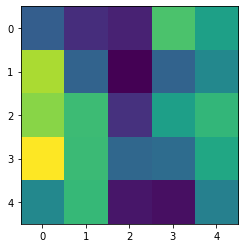

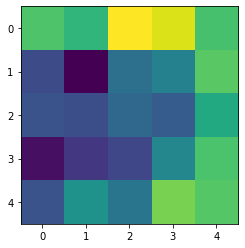

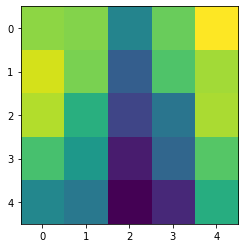

tensor([[[-5.7047e-02, -7.0271e-02, -5.9372e-02, -4.3279e-02,  2.1093e-03],
         [ 2.2326e-03, -1.0676e-01, -7.9969e-02, -5.9585e-02,  8.3572e-03],
         [ 2.4265e-02, -7.4670e-02, -1.1171e-01, -7.2803e-02, -4.7734e-02],
         [ 7.3731e-02,  1.8354e-03, -9.6905e-02, -4.1253e-02, -4.2942e-02],
         [ 8.6863e-04,  8.3695e-03, -5.8124e-02, -1.9549e-02, -1.4523e-01]],

        [[-2.4837e-02, -2.0018e-02, -9.0537e-03, -3.3069e-02, -9.6971e-03],
         [ 3.1849e-02, -3.8465e-02, -2.3368e-02,  1.7451e-03, -3.5793e-02],
         [ 5.4345e-02, -2.1780e-02, -2.1451e-02, -3.4280e-02, -4.6442e-02],
         [ 4.6821e-02, -1.7708e-02,  1.4301e-03, -8.6484e-03, -1.7442e-02],
         [ 1.0567e-02,  4.3817e-02, -8.3579e-03, -2.5063e-02, -4.5005e-03]],

        [[-7.0839e-02, -2.6087e-02, -4.7668e-02, -1.5150e-02, -2.5263e-02],
         [-6.4005e-02,  4.6556e-02, -1.1680e-02, -2.5219e-02, -6.9968e-03],
         [-7.8692e-02, -1.4809e-02, -2.7971e-03, -5.6422e-02, -3.3807e-02],
        

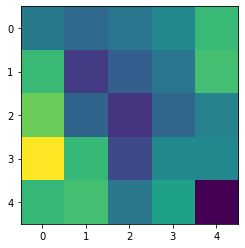

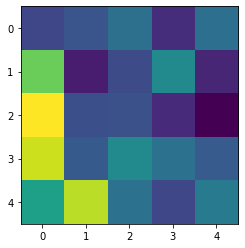

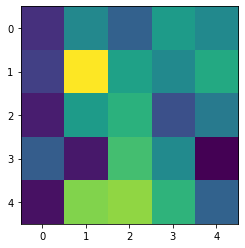

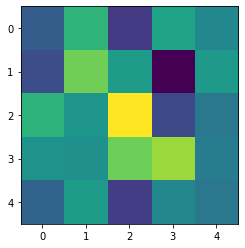

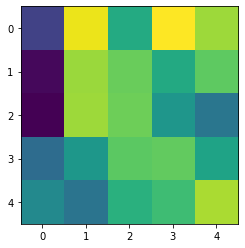

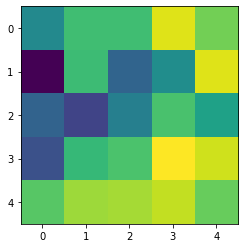

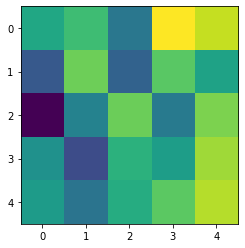

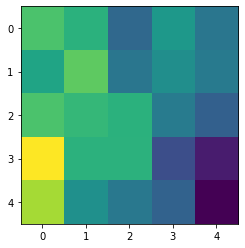

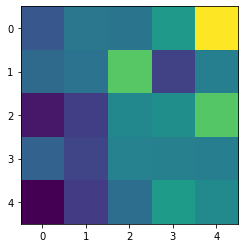

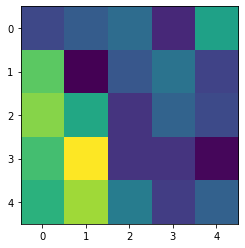

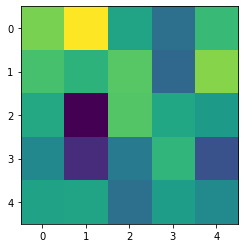

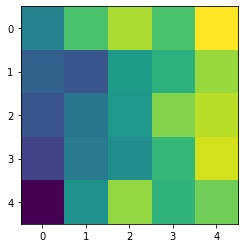

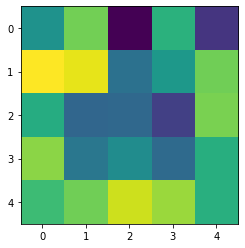

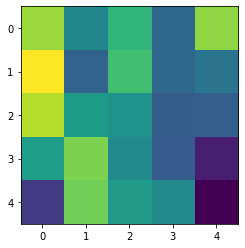

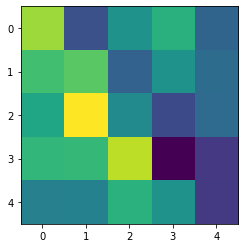

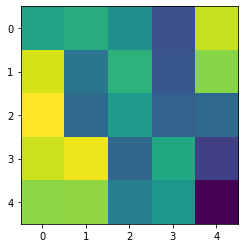

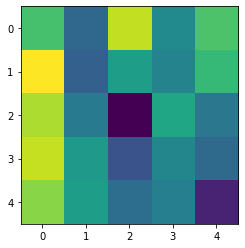

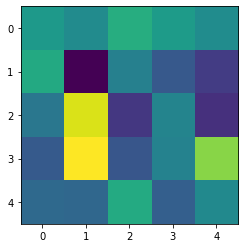

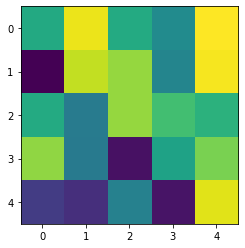

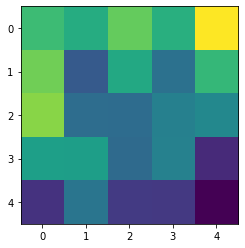

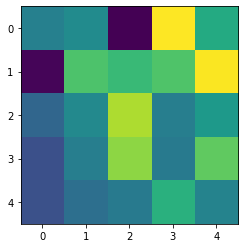

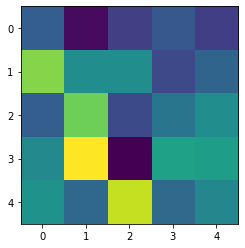

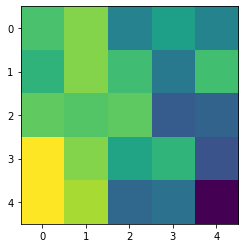

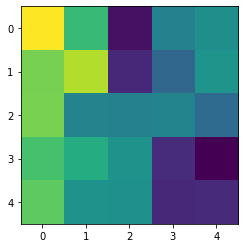

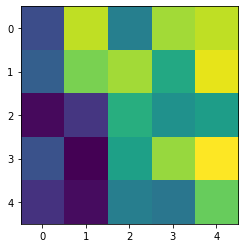

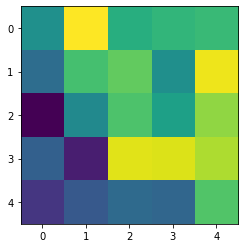

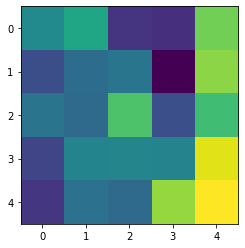

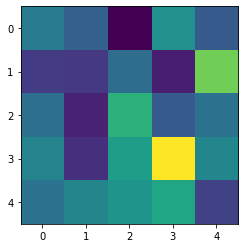

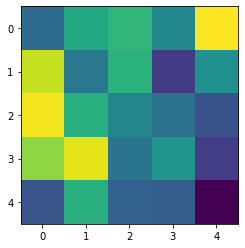

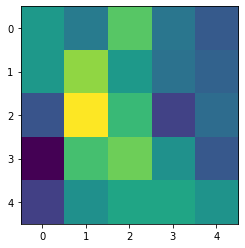

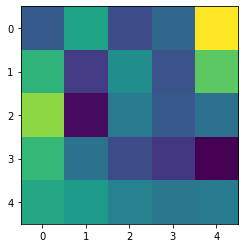

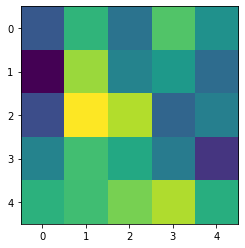

tensor([[[-4.8126e-02, -4.9114e-02, -1.9379e-02, -7.7617e-03, -4.1700e-02],
         [-1.0468e-01, -8.4603e-02, -1.3139e-02, -1.6417e-02, -6.5647e-02],
         [-7.3708e-02, -7.3619e-02, -5.4810e-02, -5.3047e-02, -1.2544e-01],
         [-5.4413e-02, -6.5552e-02, -1.1561e-01, -1.7334e-01, -1.6601e-01],
         [-5.1255e-02, -8.0084e-02, -1.6399e-01, -2.0045e-01, -1.4086e-01]],

        [[-1.1145e-02,  1.1453e-02,  2.6142e-02,  1.8279e-02,  3.6271e-02],
         [ 3.3174e-02, -3.0526e-03,  9.0849e-03,  2.0938e-02, -2.1079e-02],
         [-1.0153e-02, -3.3743e-02, -1.6821e-02, -7.3126e-03, -3.8741e-02],
         [ 3.2753e-02, -1.1320e-02,  2.5166e-03,  8.8762e-03, -3.1248e-02],
         [-2.2510e-02, -1.9650e-02, -8.8458e-03, -2.5629e-02, -1.5324e-02]],

        [[-1.4234e-02, -4.7164e-03, -5.3764e-02, -5.3872e-03, -2.9802e-02],
         [ 6.9808e-02,  6.0454e-02,  3.3316e-02,  4.8135e-02,  6.4698e-02],
         [ 4.8452e-02,  5.9975e-03,  3.0222e-02,  4.9892e-02,  1.2158e-01],
        

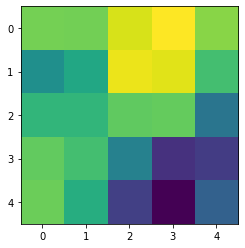

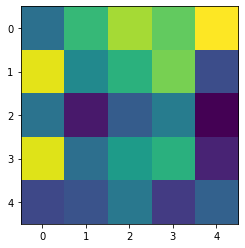

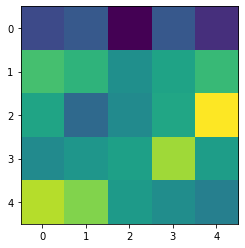

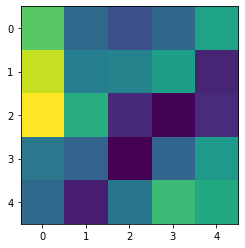

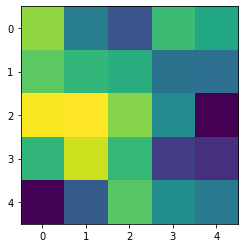

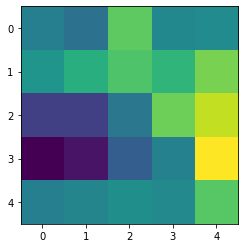

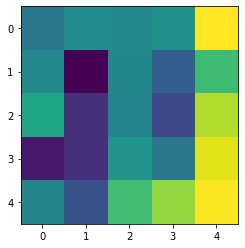

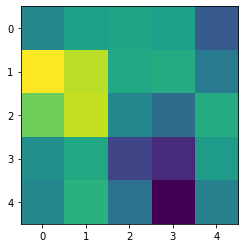

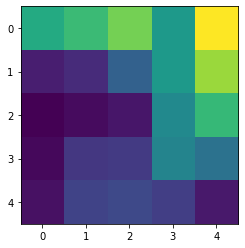

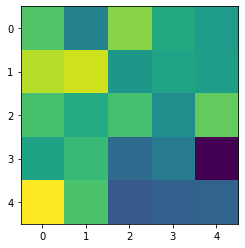

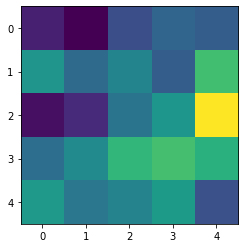

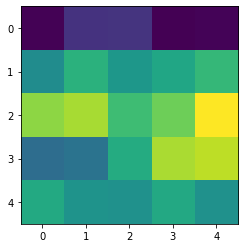

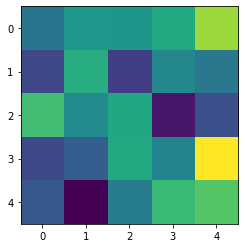

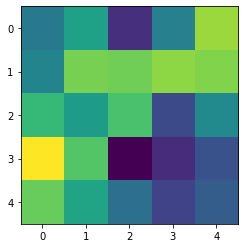

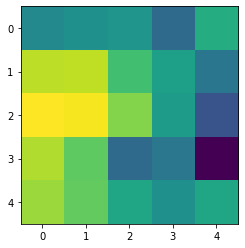

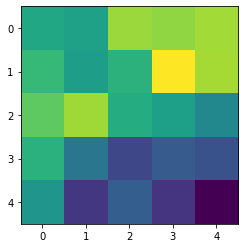

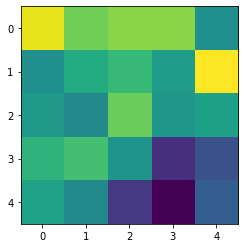

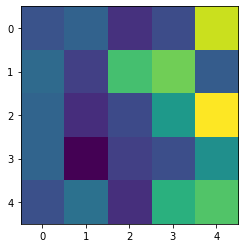

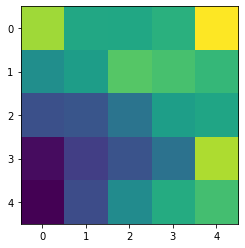

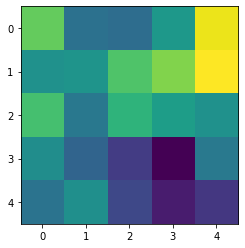

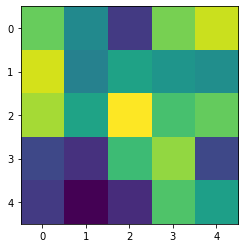

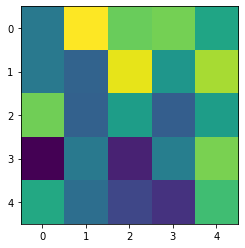

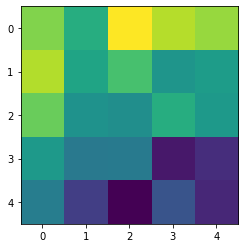

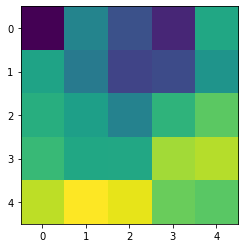

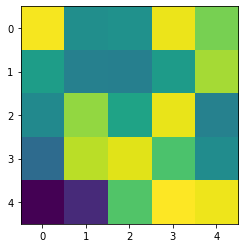

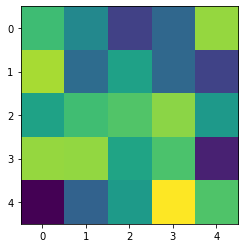

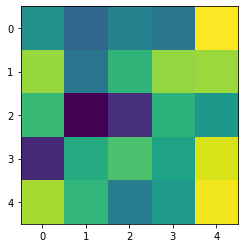

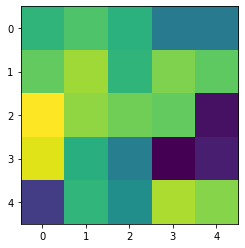

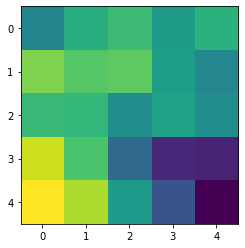

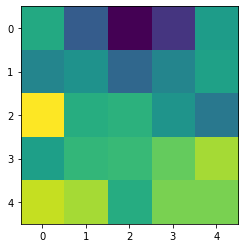

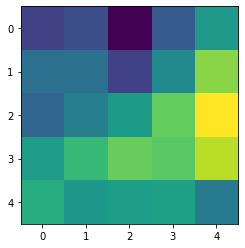

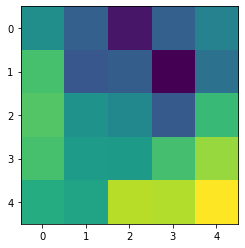

tensor([[[ 0.0011,  0.0251, -0.0163, -0.0340,  0.0002],
         [ 0.0216, -0.0314, -0.0200,  0.0242, -0.0191],
         [-0.0421, -0.0251, -0.0183, -0.0397,  0.0018],
         [ 0.0039, -0.0402, -0.0392, -0.0256, -0.0316],
         [ 0.0076,  0.0279,  0.0131, -0.0205,  0.0073]],

        [[-0.0345, -0.0177, -0.0060, -0.0083,  0.0191],
         [ 0.0155, -0.0057, -0.0215, -0.0131, -0.0301],
         [-0.0116,  0.0162, -0.0378,  0.0111, -0.0236],
         [ 0.0287,  0.0176,  0.0289, -0.0376, -0.0327],
         [ 0.0197,  0.0107, -0.0150, -0.0071, -0.0331]],

        [[ 0.0127,  0.0189, -0.0205, -0.0074,  0.0191],
         [ 0.0287, -0.0367, -0.0099, -0.0078,  0.0229],
         [-0.0189,  0.0076,  0.0178, -0.0346,  0.0196],
         [ 0.0011,  0.0269, -0.0402, -0.0054, -0.0360],
         [-0.0050, -0.0236,  0.0249,  0.0239, -0.0288]],

        [[-0.0001,  0.0171, -0.0299, -0.0246, -0.0164],
         [ 0.0090, -0.0239, -0.0327,  0.0080, -0.0203],
         [-0.0020,  0.0084, -0.0169,  0.01

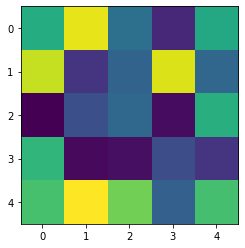

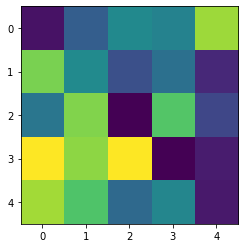

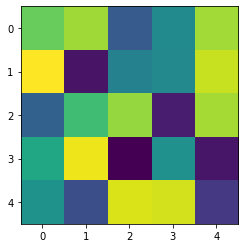

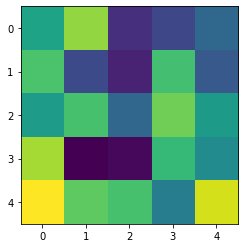

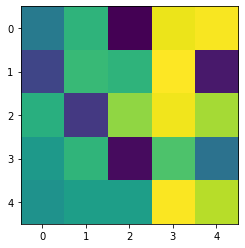

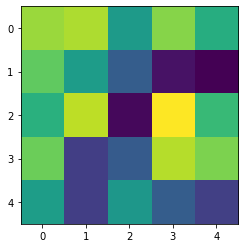

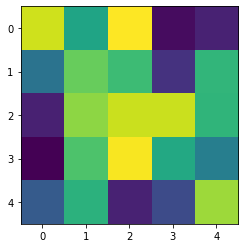

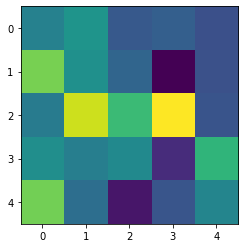

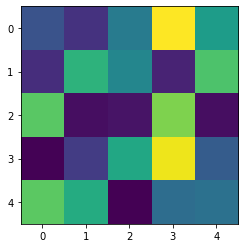

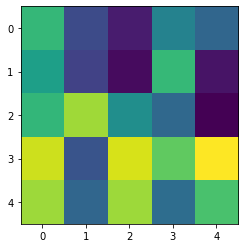

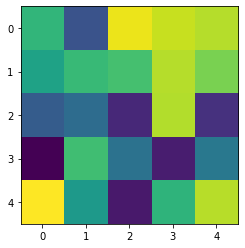

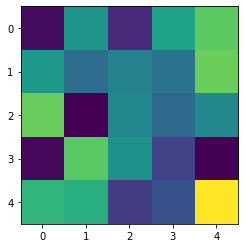

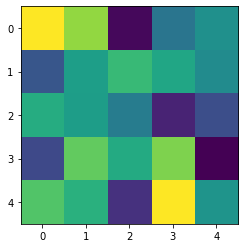

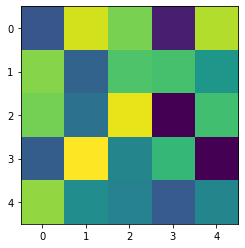

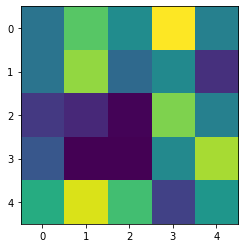

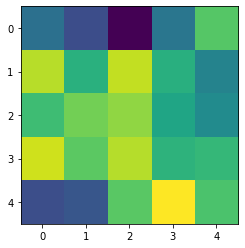

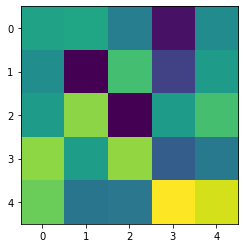

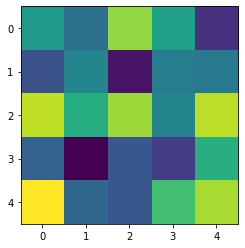

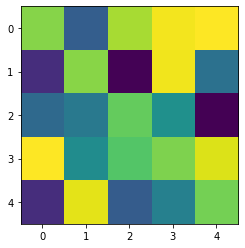

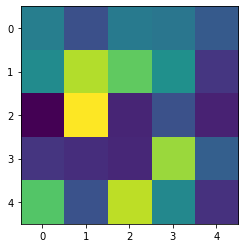

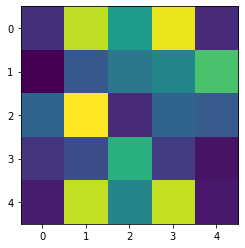

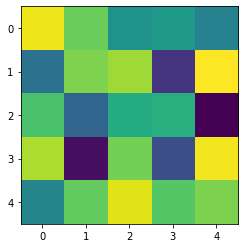

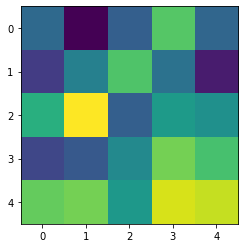

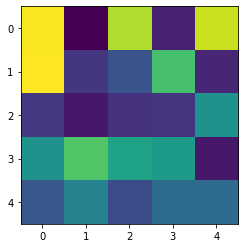

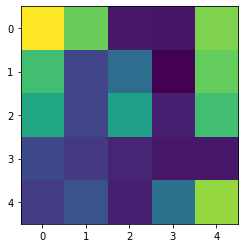

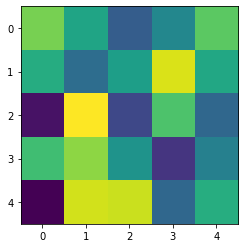

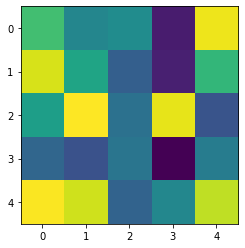

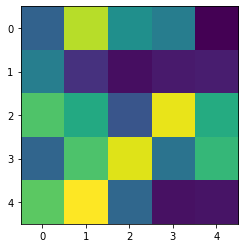

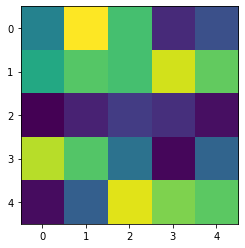

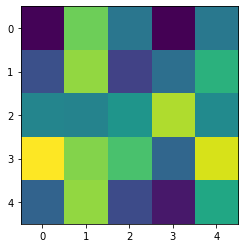

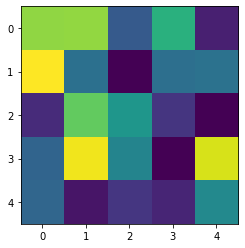

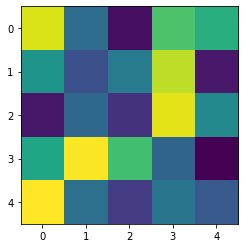

tensor([[[-2.2515e-02,  4.2222e-03, -3.1184e-02, -2.6024e-02,  2.9331e-02],
         [ 2.1812e-02, -1.7611e-02,  2.7920e-02, -3.9256e-02,  5.8068e-03],
         [-3.9980e-03,  1.6781e-02, -2.4301e-02, -1.7178e-02, -1.3180e-02],
         [ 2.3339e-02, -2.1877e-03, -3.5347e-02,  1.1595e-02,  2.2362e-02],
         [ 6.0769e-03, -3.2549e-02, -2.5782e-03, -2.1727e-02, -5.7911e-03]],

        [[-4.4583e-03,  1.8204e-02,  8.0866e-03,  2.8340e-02,  2.0749e-02],
         [-4.0909e-02, -2.4318e-02, -3.7913e-02, -1.4731e-02, -3.4277e-02],
         [-2.3770e-02, -3.3680e-03, -1.6492e-02,  3.3219e-03, -9.8827e-06],
         [-6.5449e-03, -4.0174e-02, -2.4114e-02, -2.4276e-02, -1.4914e-02],
         [-1.0312e-02, -2.0570e-03, -2.1913e-02, -9.7276e-03,  8.8282e-03]],

        [[ 1.7012e-02, -2.7469e-02,  5.3400e-03, -2.8474e-02, -3.4161e-02],
         [-4.0063e-02,  2.8476e-02, -1.3785e-02, -4.3388e-03, -1.2535e-03],
         [-1.0528e-02, -7.6526e-04, -2.3428e-02, -6.6291e-03, -2.2049e-02],
        

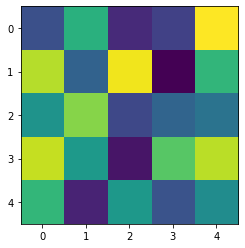

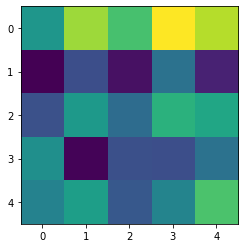

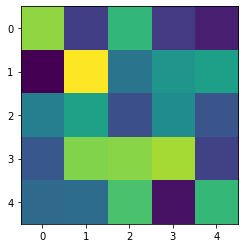

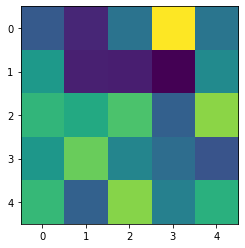

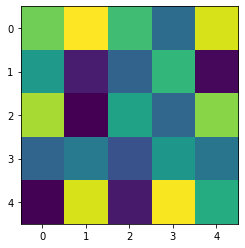

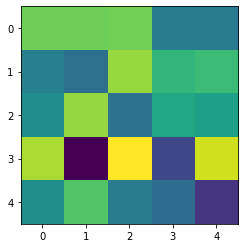

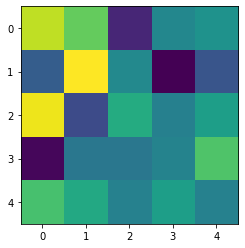

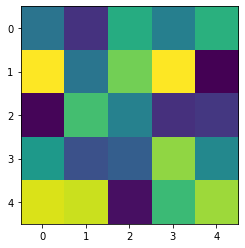

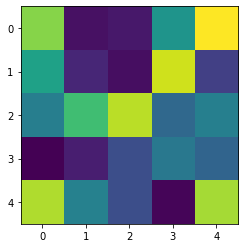

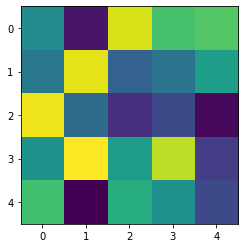

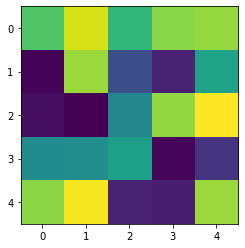

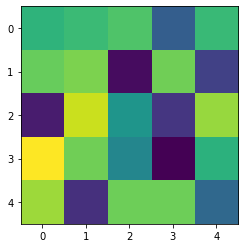

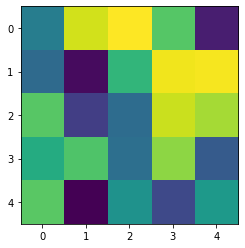

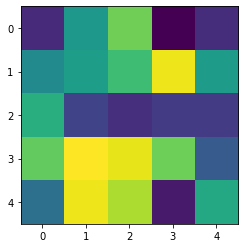

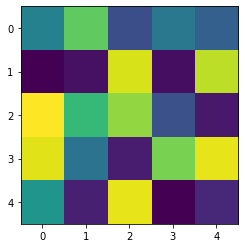

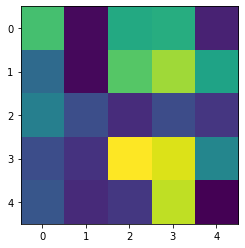

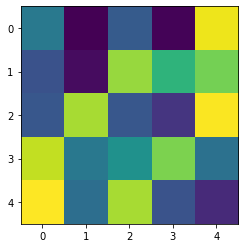

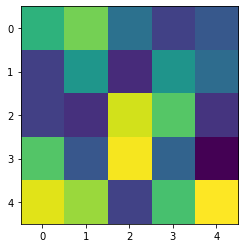

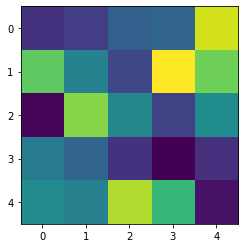

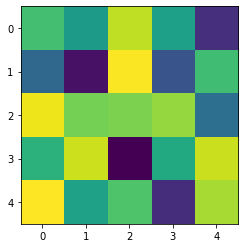

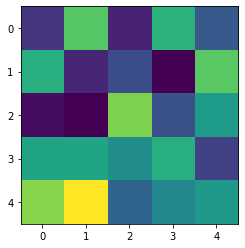

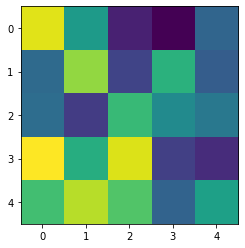

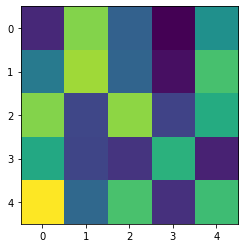

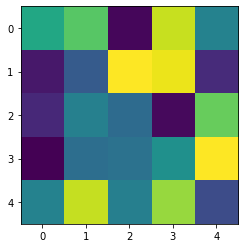

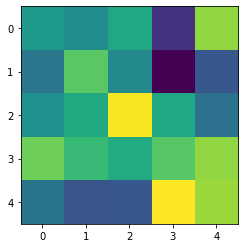

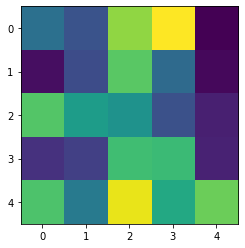

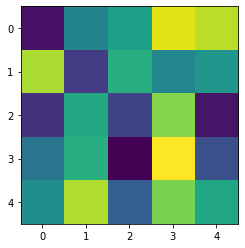

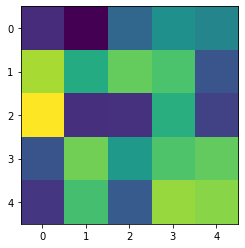

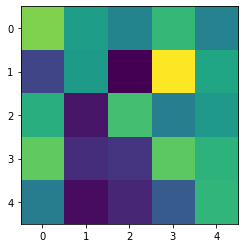

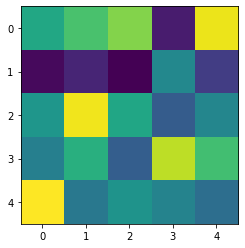

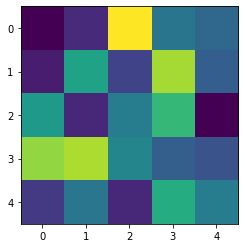

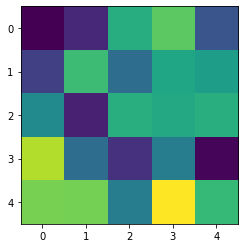

tensor([[[ 6.3036e-02,  5.7219e-02,  6.8113e-02,  3.3809e-02, -9.0371e-03],
         [ 1.6180e-02,  4.3162e-02,  1.2242e-02, -1.0235e-02, -5.1652e-02],
         [ 7.4305e-03,  4.8920e-04,  4.2036e-02,  2.8398e-03, -6.5061e-02],
         [ 6.3525e-02, -5.9450e-02, -3.0502e-02, -3.5130e-02, -8.8292e-02],
         [ 3.9336e-02,  9.9888e-03, -2.0344e-02, -3.6322e-02, -3.6863e-02]],

        [[ 7.1396e-02,  3.7847e-02,  5.2607e-02,  4.3427e-02,  4.3412e-02],
         [ 2.3099e-02, -2.8751e-02, -4.9702e-03, -2.9610e-02, -3.1413e-02],
         [-5.8261e-03, -3.9088e-02, -2.9581e-02, -5.0433e-02,  9.4353e-03],
         [ 3.0701e-03, -2.6390e-02, -8.9887e-03, -5.1582e-02, -3.4132e-04],
         [-1.6549e-02, -5.6537e-02, -1.7658e-03, -5.3475e-02, -5.5654e-02]],

        [[ 6.8469e-03,  3.1271e-02, -2.7130e-02, -3.8677e-02,  3.2180e-02],
         [-3.7594e-02,  4.6993e-03, -1.6618e-02, -7.9098e-02, -3.7633e-02],
         [-3.8728e-02, -4.5889e-02,  1.3732e-02,  1.9216e-02,  3.2501e-02],
        

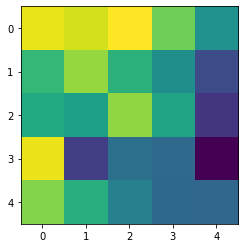

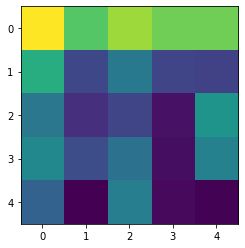

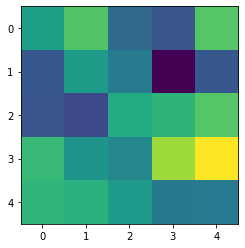

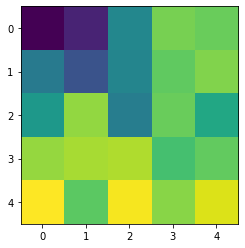

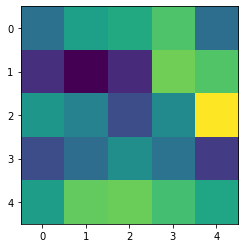

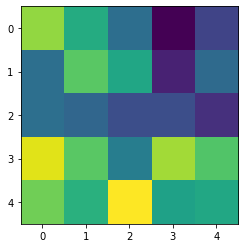

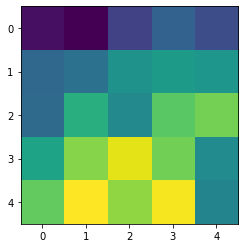

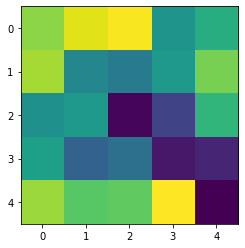

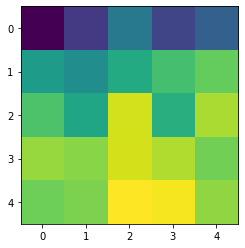

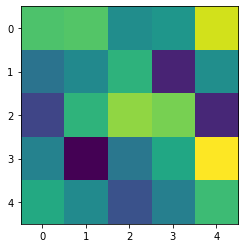

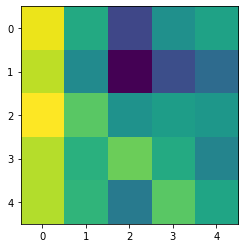

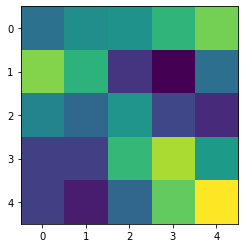

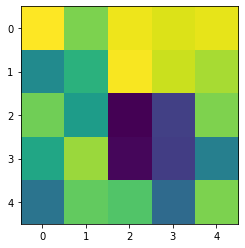

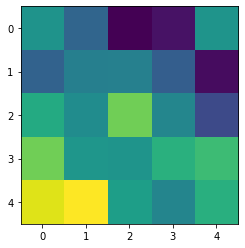

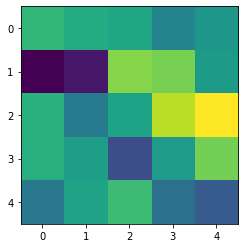

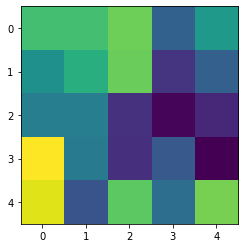

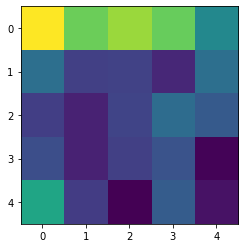

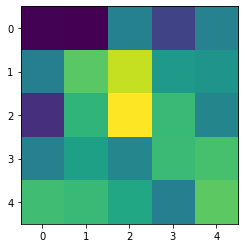

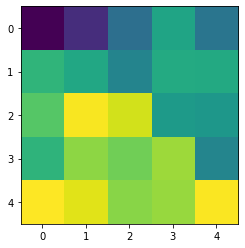

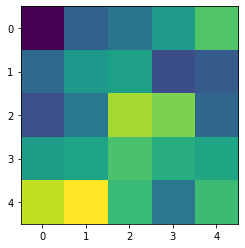

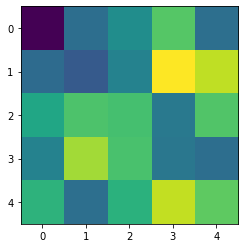

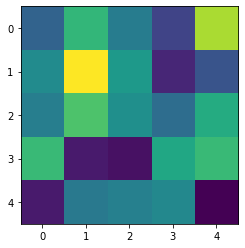

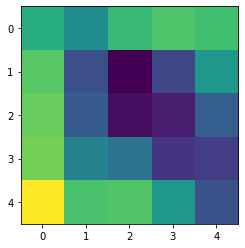

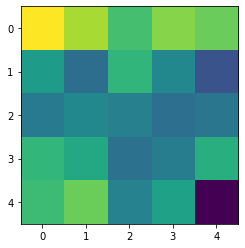

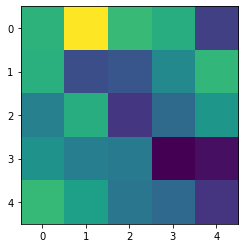

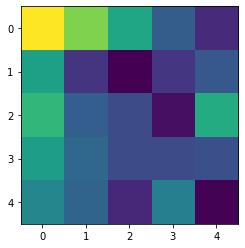

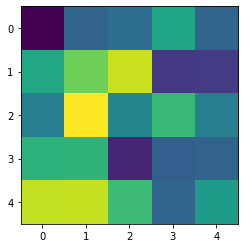

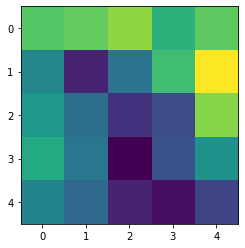

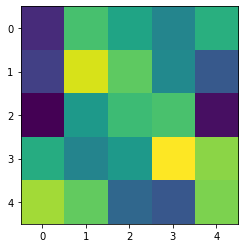

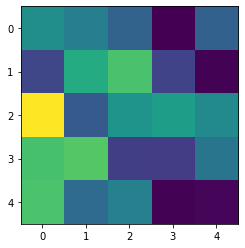

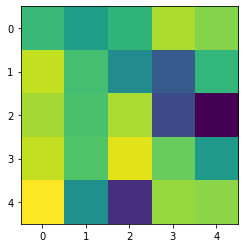

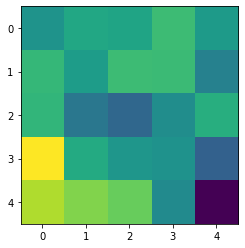

tensor([[[ 3.5730e-03,  3.2089e-02,  8.3267e-02, -2.0683e-02,  3.4189e-02],
         [ 4.4452e-02,  7.2454e-02,  3.5068e-02,  6.2071e-02,  1.8264e-01],
         [ 2.8305e-02, -4.1301e-02, -2.5289e-02,  1.1030e-01,  9.8473e-02],
         [-3.0495e-02, -3.5406e-02,  6.2988e-02,  1.1917e-01,  4.6008e-02],
         [-4.0139e-02,  5.8416e-02,  5.1873e-02,  5.6010e-02,  3.7610e-02]],

        [[-4.9072e-03,  6.5536e-03, -1.9614e-02, -3.5825e-03,  6.8339e-02],
         [-8.9243e-03,  4.3623e-02, -9.9582e-03,  1.0789e-02,  5.8956e-02],
         [ 1.3513e-02,  1.6166e-02, -8.1517e-03,  6.5310e-02,  8.3016e-03],
         [-2.8692e-02,  5.1103e-03,  1.5292e-02,  3.8608e-03,  3.0943e-02],
         [ 3.8085e-02, -2.5039e-02,  2.2374e-02,  3.1301e-03, -7.1445e-03]],

        [[-1.1030e-02, -1.0091e-01, -6.8220e-02,  3.9945e-02, -4.9455e-02],
         [-1.4868e-01,  1.0950e-02,  9.5786e-02,  5.1015e-02, -2.2064e-01],
         [-2.5309e-02,  5.9168e-02,  2.1411e-02, -1.2504e-01, -5.8920e-02],
        

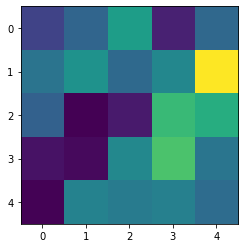

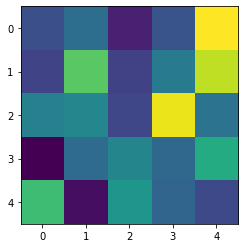

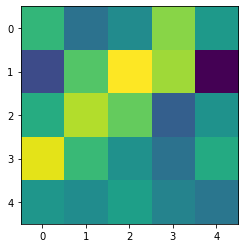

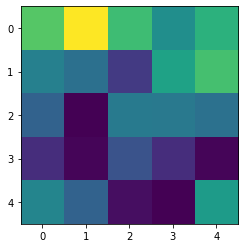

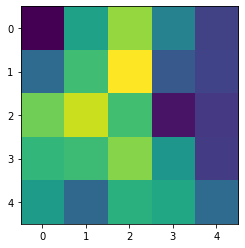

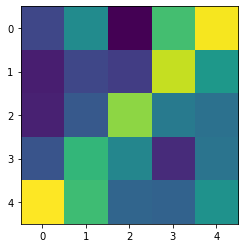

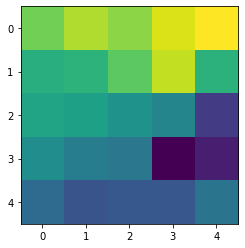

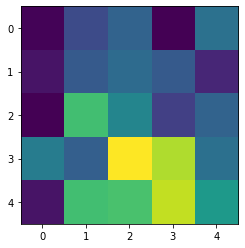

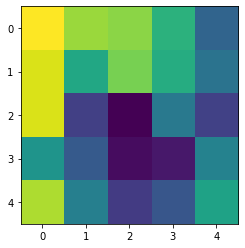

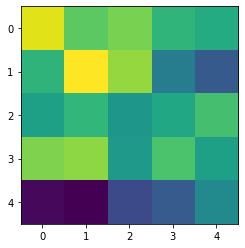

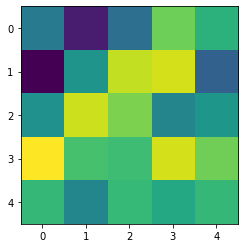

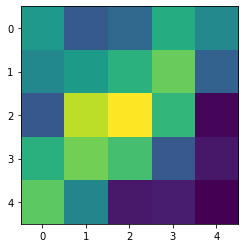

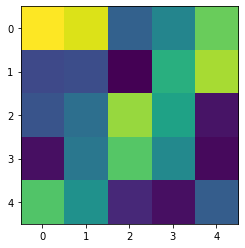

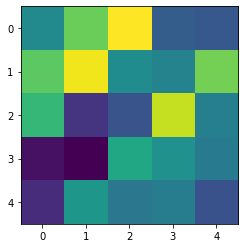

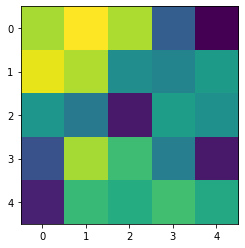

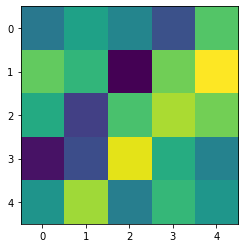

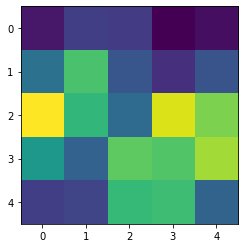

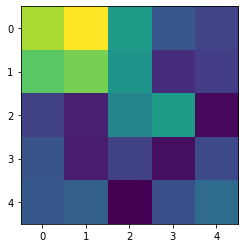

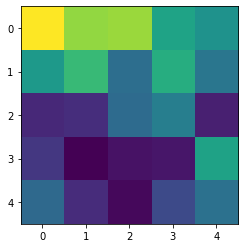

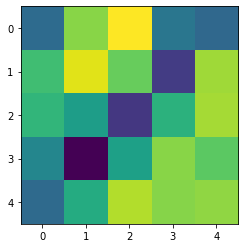

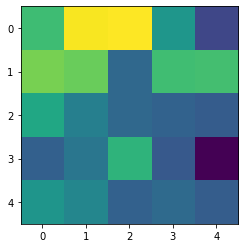

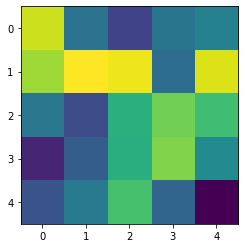

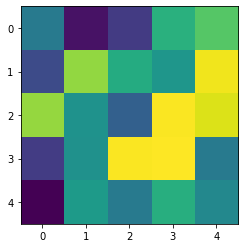

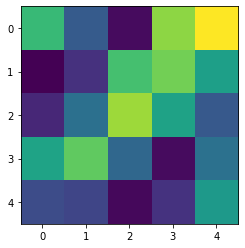

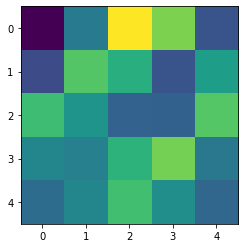

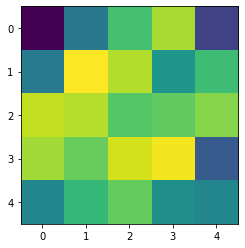

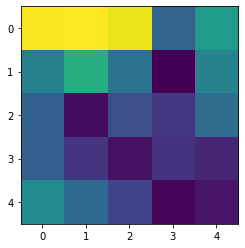

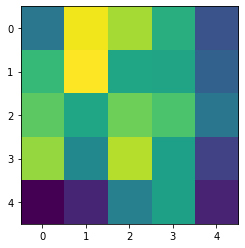

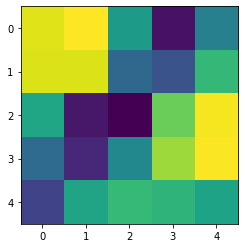

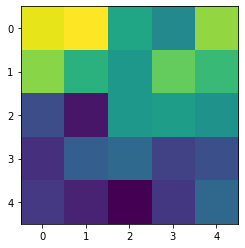

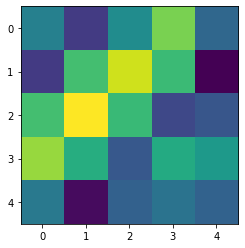

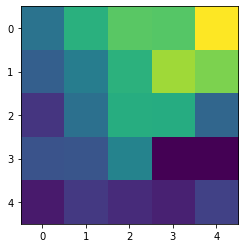

tensor([[[ 1.5069e-02,  1.9076e-02, -1.6932e-02,  2.5966e-02, -1.0934e-03],
         [-1.9635e-02,  2.9730e-03, -5.9707e-03,  2.7508e-02, -1.3841e-02],
         [ 6.3157e-03, -3.3071e-02, -8.4439e-03,  9.5559e-03,  7.4897e-03],
         [ 9.1226e-03, -1.5854e-03, -3.1706e-02, -1.0638e-02, -3.1315e-02],
         [-7.3624e-03, -1.0004e-02, -1.1711e-02, -9.3053e-03, -5.7374e-03]],

        [[ 1.0531e-02, -1.9058e-02,  6.8501e-03,  2.7872e-02, -2.7146e-02],
         [-2.5830e-02, -2.2553e-02,  3.2859e-03, -2.4337e-03,  1.7044e-02],
         [ 2.2712e-02,  3.4651e-03, -4.2188e-02,  8.2246e-03,  1.5896e-02],
         [-1.1557e-02, -3.7873e-02, -3.2970e-02, -1.5863e-02, -2.5313e-02],
         [-1.2980e-02, -3.8181e-02, -4.0938e-02,  2.7132e-02,  4.5731e-03]],

        [[ 2.6415e-02, -2.6234e-02,  1.9236e-02,  1.0679e-03,  1.8226e-02],
         [-2.3812e-02,  1.2690e-02, -3.9520e-02, -5.5939e-03,  1.1340e-02],
         [ 1.5481e-02, -1.7439e-02, -1.1861e-02, -1.8404e-02,  1.2084e-02],
        

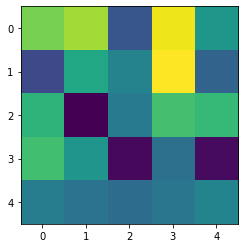

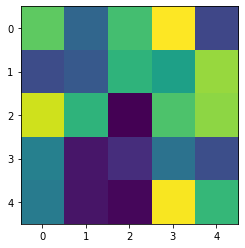

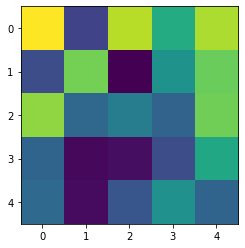

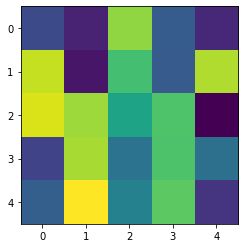

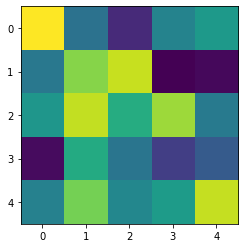

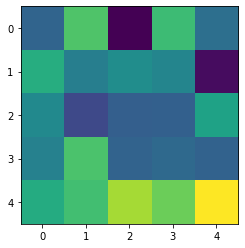

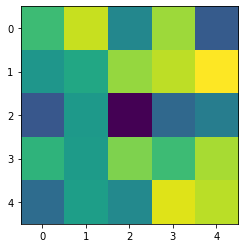

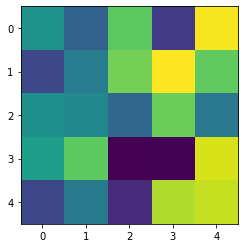

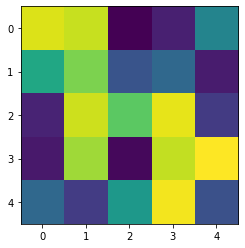

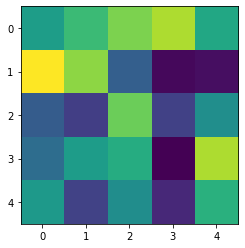

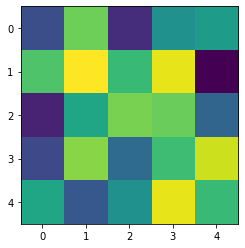

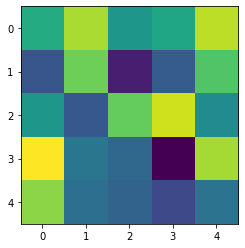

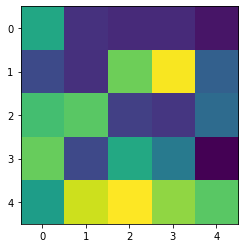

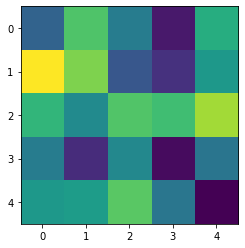

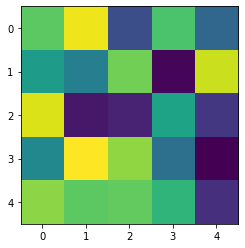

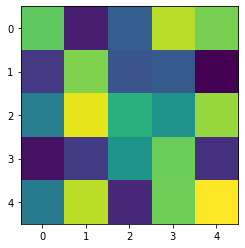

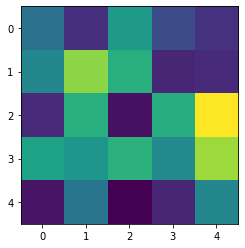

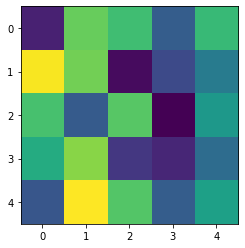

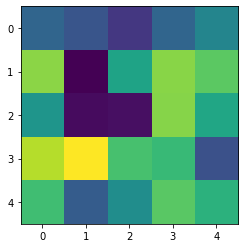

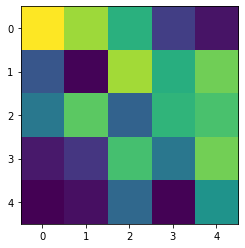

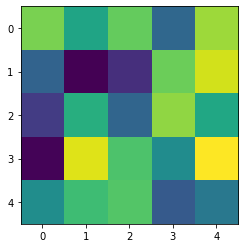

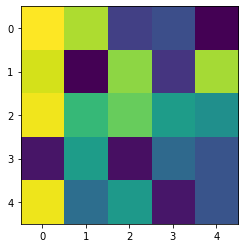

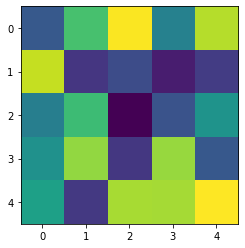

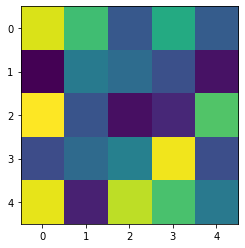

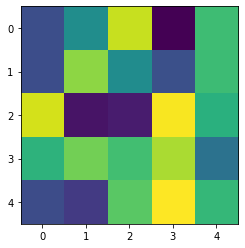

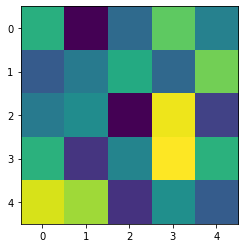

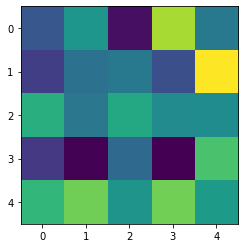

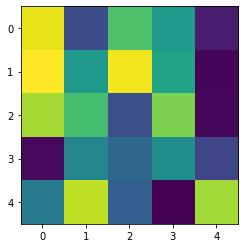

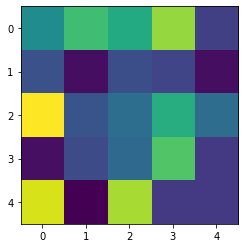

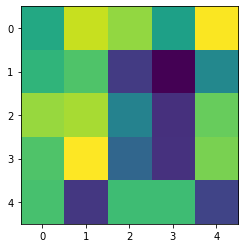

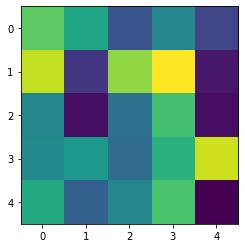

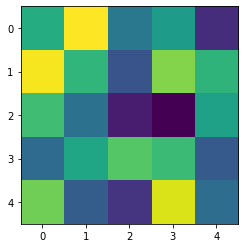

tensor([[[ 5.5915e-02,  4.3281e-02,  1.1769e-02, -1.0282e-01, -9.5133e-02],
         [ 2.5574e-02, -9.1627e-02, -1.0587e-01, -1.3629e-01, -1.1690e-01],
         [-4.0790e-02, -1.7449e-01, -1.6677e-01, -1.2270e-01, -1.4154e-01],
         [-1.5074e-01, -2.3247e-01, -1.8403e-01, -1.6959e-01, -1.6911e-01],
         [-1.3355e-01, -1.8051e-01, -2.4432e-01, -1.9819e-01, -1.9427e-01]],

        [[-9.0131e-03,  2.6120e-03, -1.5657e-02, -3.1693e-02, -3.6830e-02],
         [ 3.2410e-02, -2.9186e-02,  3.5160e-03, -3.5755e-02,  1.5635e-02],
         [ 5.4751e-03,  1.5392e-03, -3.2373e-02, -4.0768e-02,  1.4084e-02],
         [-1.9936e-02, -2.3545e-03,  1.6925e-02,  3.5476e-02, -1.6308e-03],
         [ 3.3871e-02,  2.4176e-03, -1.2812e-02,  1.7591e-02,  4.5920e-02]],

        [[ 8.0815e-02, -1.0815e-02, -1.0304e-02,  7.3126e-02,  1.0002e-01],
         [ 2.7935e-02,  4.0166e-02,  8.8905e-02,  1.0406e-03, -3.2552e-02],
         [ 4.9862e-02,  1.2316e-02, -1.5739e-02,  6.2218e-02,  7.6875e-02],
        

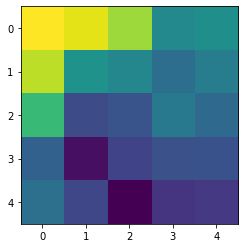

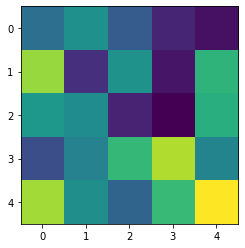

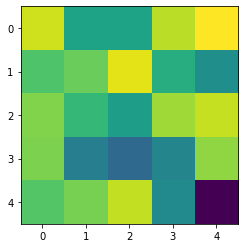

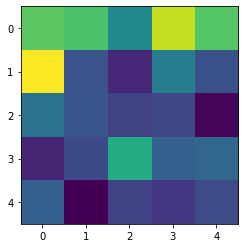

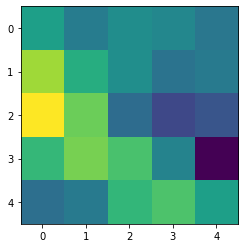

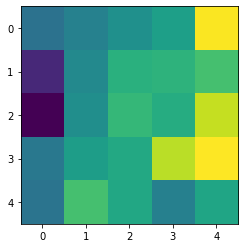

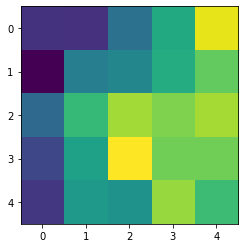

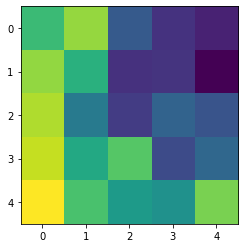

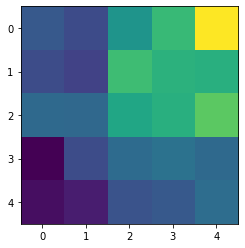

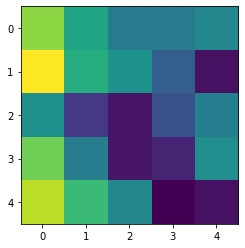

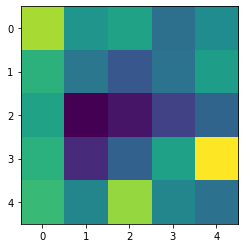

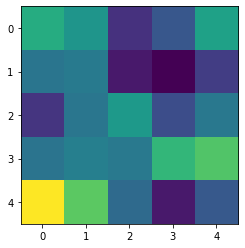

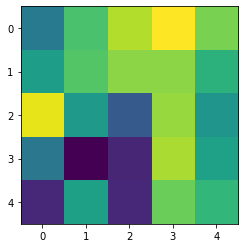

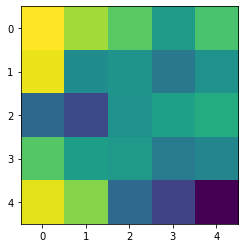

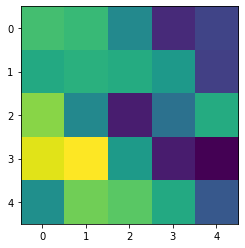

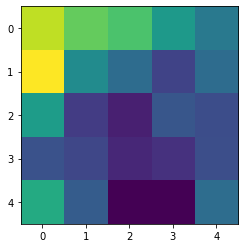

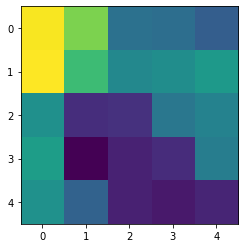

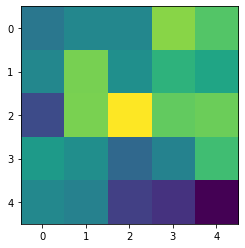

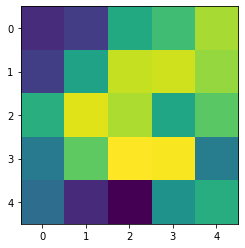

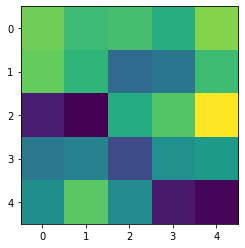

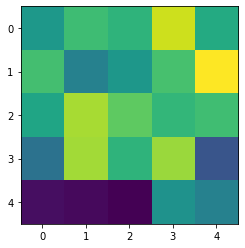

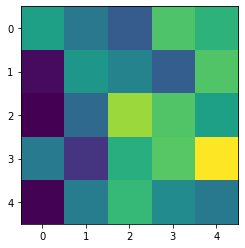

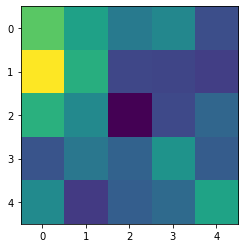

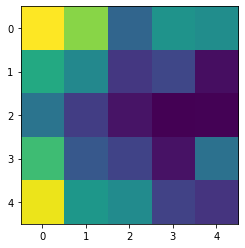

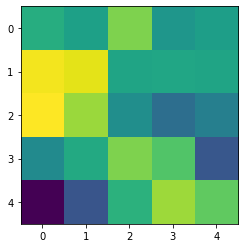

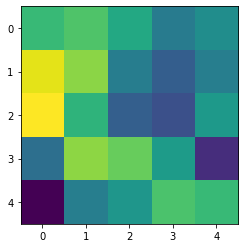

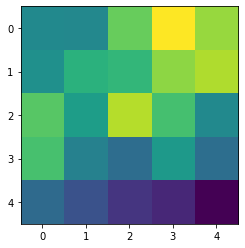

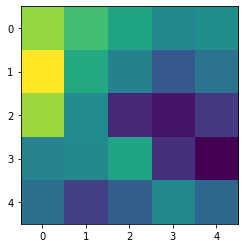

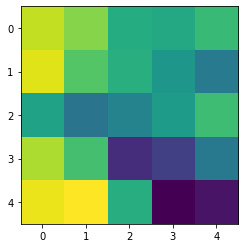

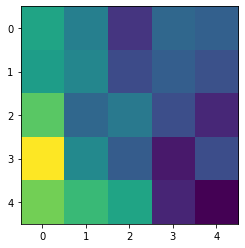

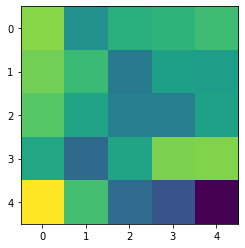

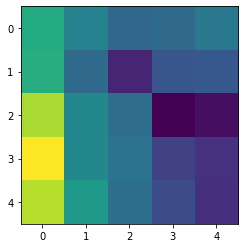

tensor([[[ 1.0375e-01,  2.8911e-02,  4.1555e-02,  5.4879e-03,  1.8635e-02],
         [ 4.5027e-02,  6.4595e-02,  7.9500e-02, -4.5239e-02,  4.4383e-02],
         [ 2.3607e-02,  4.8856e-02,  1.2651e-01, -9.3972e-02,  5.3888e-02],
         [-1.2808e-02,  5.2527e-02,  9.2740e-02, -8.2324e-02,  1.1587e-02],
         [-5.6082e-02,  4.0761e-03,  3.0397e-02, -1.4920e-01, -5.6230e-02]],

        [[-4.3603e-02,  1.2548e-02,  7.2700e-03,  3.4364e-04, -2.8412e-02],
         [-3.4098e-02,  2.9350e-02, -2.0475e-02,  1.7448e-02, -1.5361e-02],
         [-2.3165e-02,  9.4450e-03,  4.0491e-03, -1.3261e-02, -1.2311e-02],
         [-1.7366e-02,  4.0914e-03,  1.2564e-02, -2.9515e-02,  1.0775e-02],
         [-1.2037e-02, -1.2813e-02, -5.0876e-02, -6.3933e-02, -2.0075e-03]],

        [[-1.4915e-02, -6.4184e-02, -4.1631e-02, -3.1263e-02, -2.9552e-03],
         [ 8.0966e-03, -1.3542e-02, -1.2914e-02, -2.3489e-02,  8.8381e-03],
         [ 4.1296e-02, -2.2554e-02, -8.5154e-02, -8.4035e-03, -6.9048e-02],
        

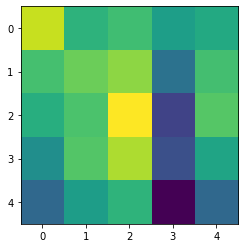

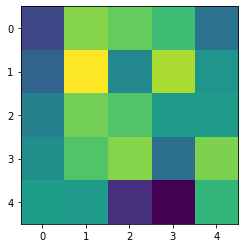

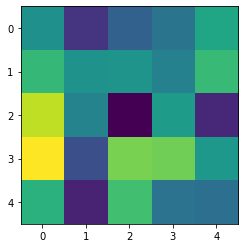

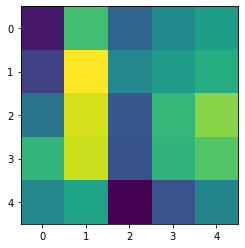

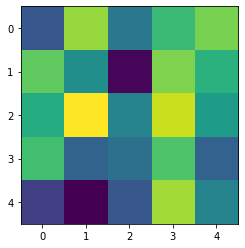

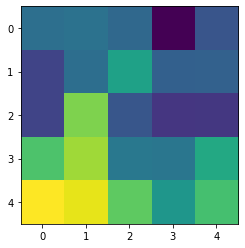

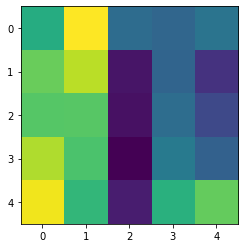

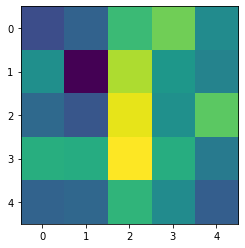

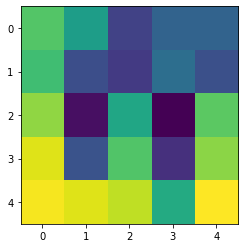

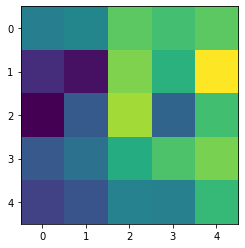

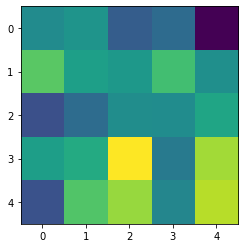

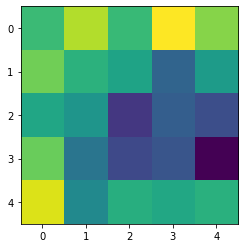

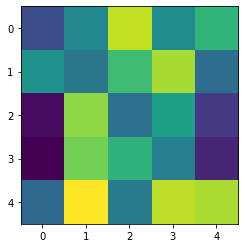

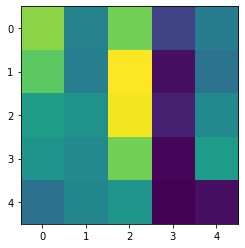

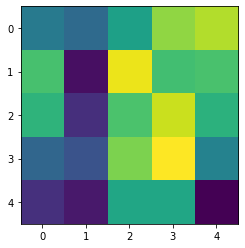

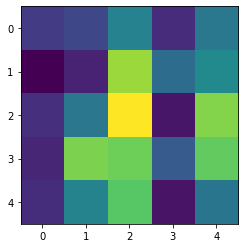

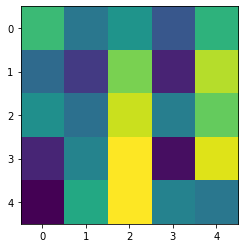

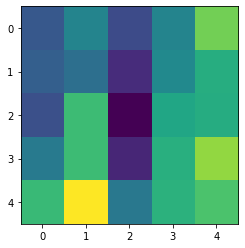

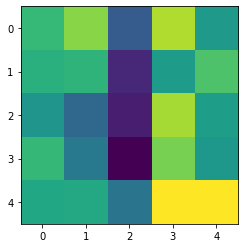

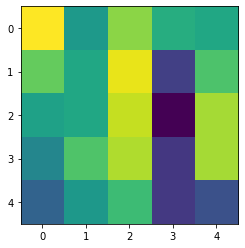

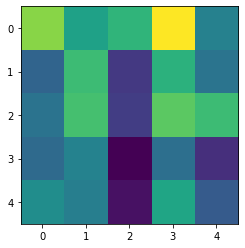

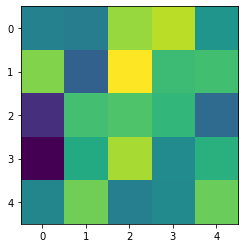

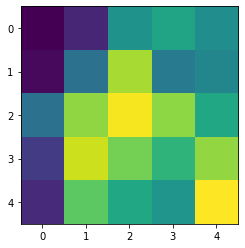

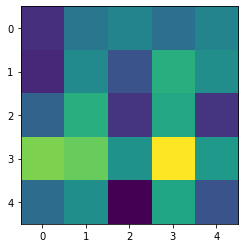

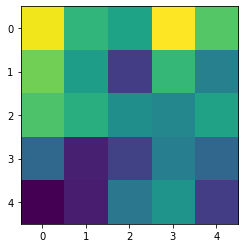

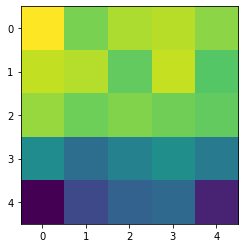

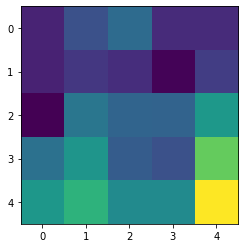

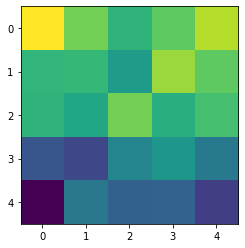

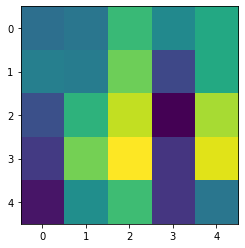

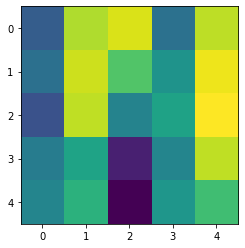

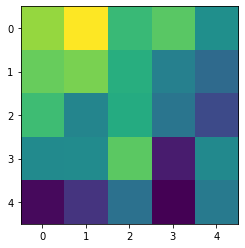

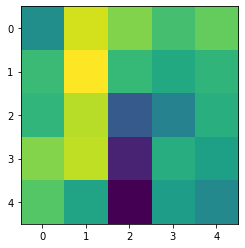

tensor([[[-1.6329e-01, -9.2274e-02, -1.6769e-01, -6.2748e-02, -4.4003e-02],
         [-1.1300e-01, -1.6508e-01, -1.5379e-01, -1.5381e-01, -5.5679e-02],
         [-6.0663e-02, -1.6298e-01, -1.3972e-01, -1.5117e-01, -1.1745e-01],
         [-9.3944e-02, -1.3509e-01, -1.4068e-01, -1.0053e-01, -8.8563e-02],
         [-3.1590e-02, -6.0017e-02, -1.0330e-01, -7.9818e-02, -2.8176e-02]],

        [[ 3.0223e-02,  8.7019e-03,  5.2368e-02,  1.2213e-02,  1.5608e-02],
         [ 1.7895e-02,  4.8633e-02,  1.1412e-02,  7.0321e-03,  6.4255e-02],
         [ 1.7168e-02, -1.8445e-02,  3.0057e-02,  4.7006e-02,  3.4542e-02],
         [ 1.3958e-02, -1.9297e-02, -1.8722e-02, -1.0171e-02,  4.0409e-02],
         [ 7.6509e-03,  4.8205e-02,  3.5288e-02, -5.0734e-03,  5.2740e-02]],

        [[ 1.1808e-01,  6.5959e-02,  7.2934e-02,  4.6821e-02,  8.6582e-02],
         [ 1.4740e-01,  7.1870e-02,  6.3087e-02,  8.8632e-02,  1.0949e-01],
         [ 7.1835e-02,  1.2973e-01,  6.7774e-02,  1.0479e-01,  5.6800e-02],
        

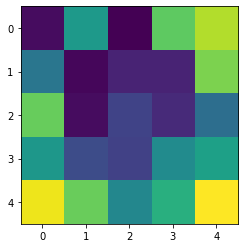

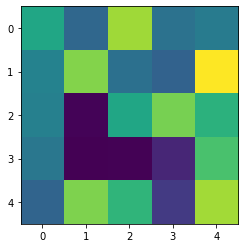

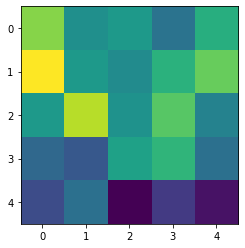

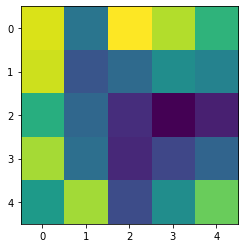

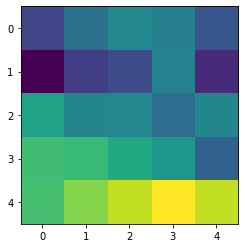

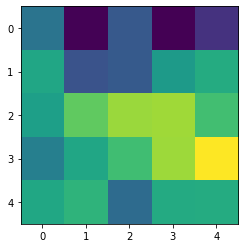

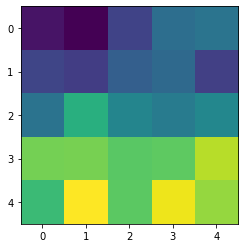

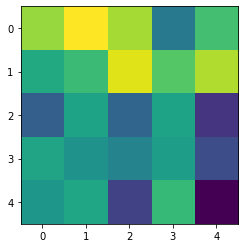

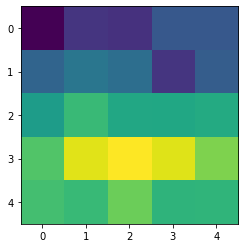

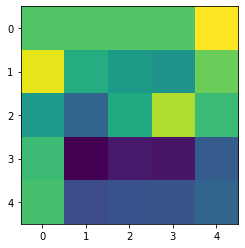

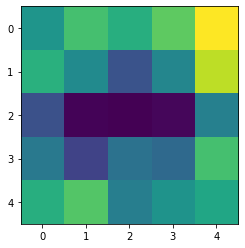

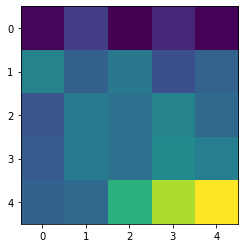

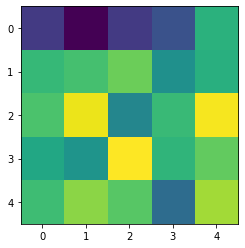

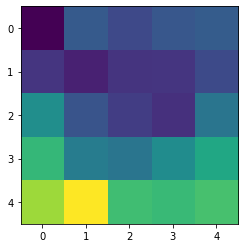

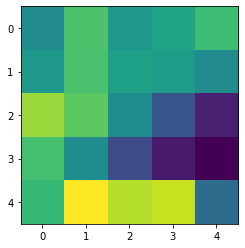

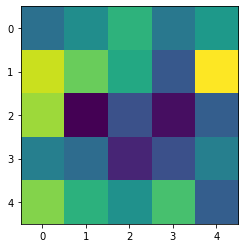

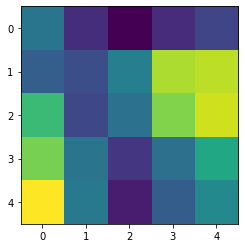

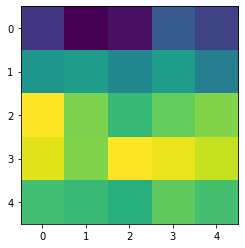

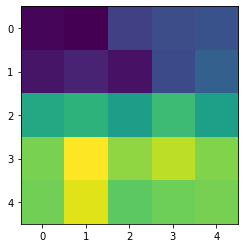

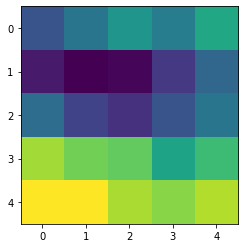

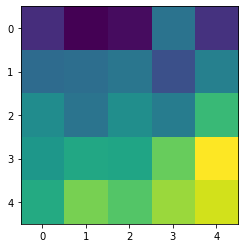

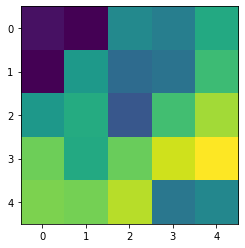

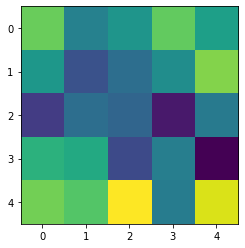

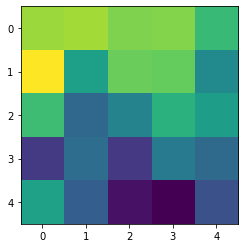

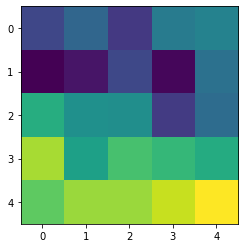

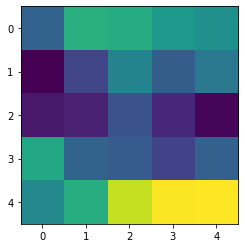

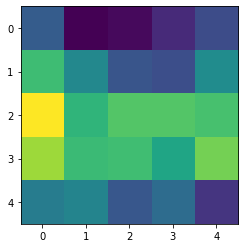

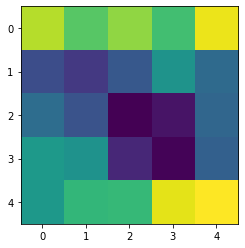

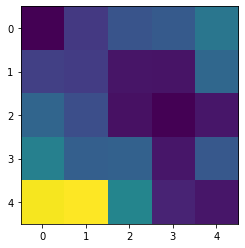

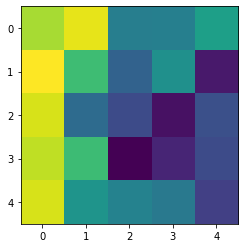

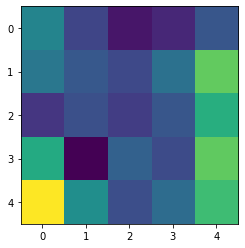

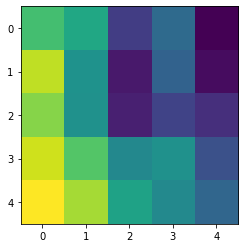

tensor([[[-1.9516e-02,  2.6808e-02,  2.0433e-02,  2.4054e-02,  3.0062e-02],
         [-1.3626e-02,  3.0020e-02,  1.3708e-03, -6.2928e-04, -3.5830e-02],
         [-2.8317e-02, -2.7430e-03, -1.2591e-02, -3.6738e-02, -9.3734e-03],
         [ 3.0310e-02, -5.6376e-02, -9.2140e-02, -5.1393e-02, -3.1103e-03],
         [-3.1482e-02, -1.3534e-01, -9.9201e-02, -6.9433e-02, -1.0568e-01]],

        [[-3.8334e-02,  8.0306e-03, -3.6896e-02,  1.3844e-02, -1.3805e-02],
         [-1.4268e-02,  1.4953e-02, -2.5887e-02, -4.0102e-02, -2.2568e-02],
         [-3.0691e-02, -3.7603e-02, -1.0656e-02, -4.7964e-02,  1.8272e-02],
         [ 1.8098e-02,  3.3747e-03, -1.7829e-02, -5.3227e-02, -5.0962e-02],
         [-3.8092e-02, -5.2870e-03, -4.1362e-02, -1.3478e-02,  1.9490e-02]],

        [[ 3.6132e-03,  9.1125e-02,  2.9288e-02,  8.2519e-02,  6.4386e-02],
         [ 5.7254e-02,  1.0368e-01,  1.2933e-01,  1.1375e-01,  6.2279e-02],
         [-3.1941e-03,  7.9001e-02,  6.9868e-02,  8.4689e-02,  7.7347e-02],
        

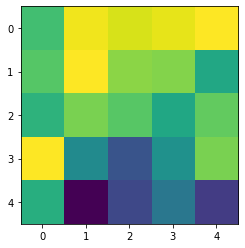

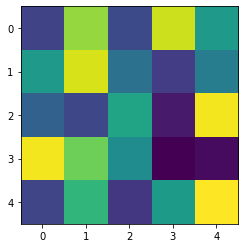

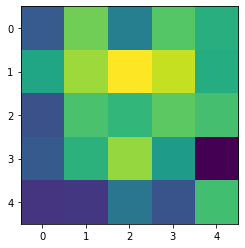

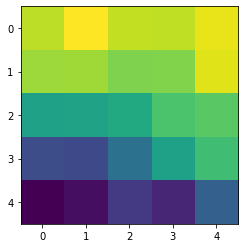

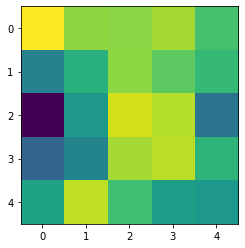

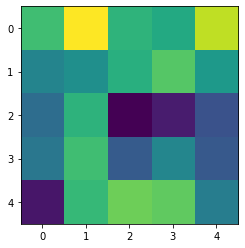

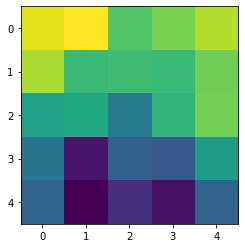

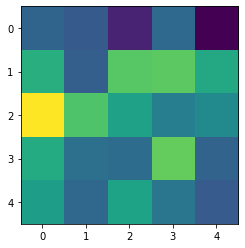

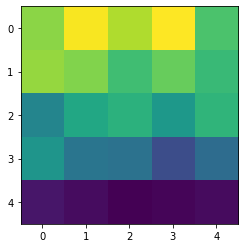

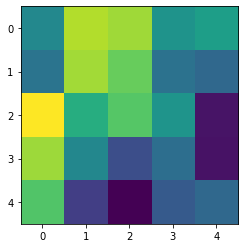

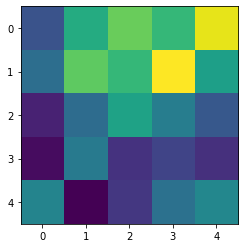

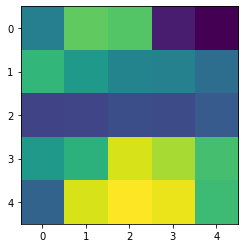

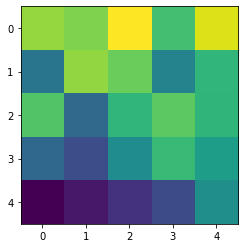

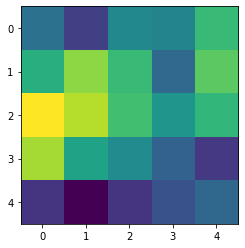

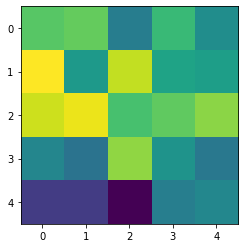

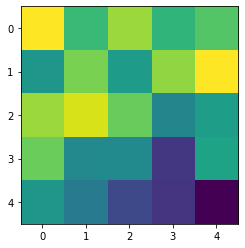

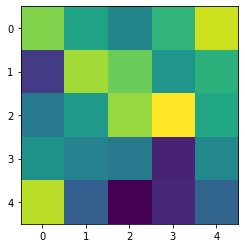

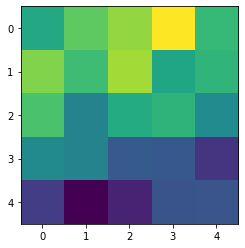

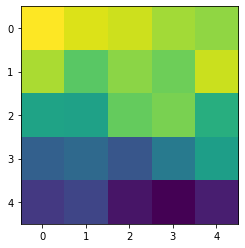

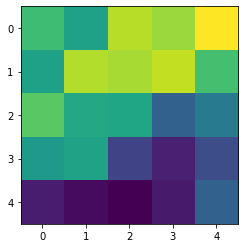

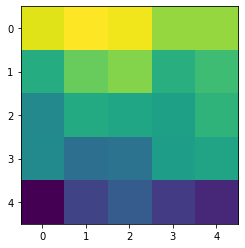

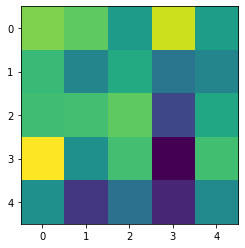

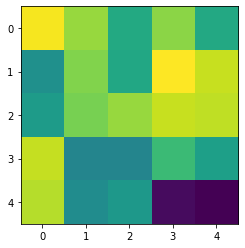

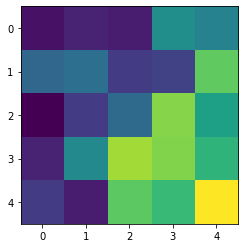

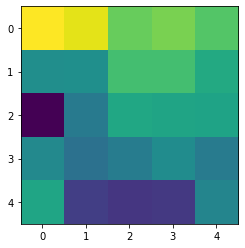

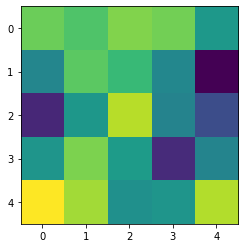

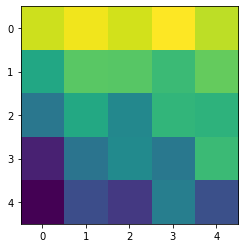

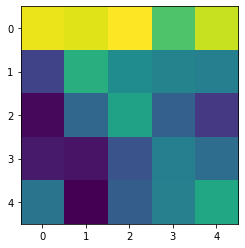

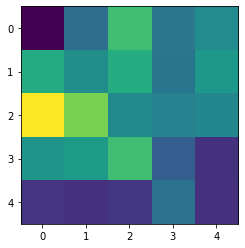

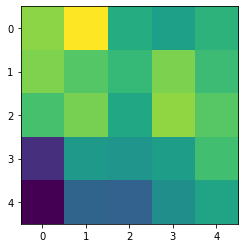

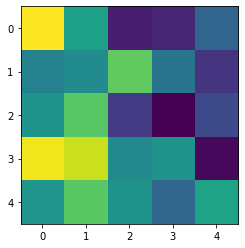

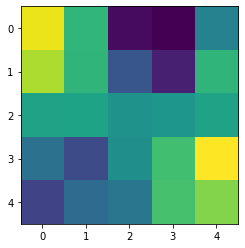

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

for name, parameters in model.named_parameters():
  if(not 'cnn' in name):
    continue
  if(not 'weight' in name):
    continue
  print(name + ' : NEW LAYER')
  param_cpu = torch.FloatTensor(parameters.cpu().detach().numpy())
  for i in range(len(param_cpu)):
    print(param_cpu[i])
    for j in range(len(param_cpu[i])):
      plt.imshow(param_cpu[i][j])
      plt.show()

<class 'method'>


In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/